In [4]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import re
import math
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange
from transformers import AutoTokenizer
from tokenizers.processors import TemplateProcessing

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Imports for Cosmos tokenizer
from huggingface_hub import snapshot_download
from cosmos_tokenizer.image_lib import ImageTokenizer

from nanofm.utils.checkpoint import load_model_from_safetensors
from nanofm.data.multimodal.simple_multimodal_dataset import SimpleMultimodalDataset
from nanofm.data.multimodal.masking import SimpleMultimodalMasking

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

In [6]:
snapshot_download(
    repo_id='nvidia/Cosmos-0.1-Tokenizer-DI16x16', 
    local_dir='/tmp/nvidia12/Cosmos-0.1-Tokenizer-DI16x16'
)
image_tokenizer = ImageTokenizer(
    checkpoint_enc='/tmp/nvidia12/Cosmos-0.1-Tokenizer-DI16x16/encoder.jit',
    checkpoint_dec='/tmp/nvidia12/Cosmos-0.1-Tokenizer-DI16x16/decoder.jit',
).to(device)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# Cell 1: Import Libraries and Setup
import os
import glob
import random
import numpy as np
from PIL import Image, ImageDraw
import torchvision.transforms as TF
import torch
import cv2
import shutil
# Constants
BASE_INPUT_DIR = "/work/com-304/IAY_neurons_u2/dataset/keyframes"
BASE_OUTPUT_DIR = "/work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset"
 # No GPU acceleration as requested
SEED = 42
VAL_FRAC = 0.085
TEST_FRAC = 0.085
BATCH_SIZE = 16

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


print("✅ Tokenizer and libraries set up")

✅ Tokenizer and libraries set up


In [8]:
# Cell 2: Definition of Key Functions
def enhance_keypoint_image(img, keypoints_data, height=256, width=256):
    """Enhance the original keypoint image with JSON coordinates for hands and face only."""
    img_enhanced = img.convert('RGBA')
    draw = ImageDraw.Draw(img_enhanced)
    
    hand_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
    ]
    
    def scale_coords(coords):
        return int(coords[0] * width / 1280), int(coords[1] * height / 720)
    
    face_keypoints = keypoints_data.get('face_keypoints_2d', [])
    hand_left_keypoints = keypoints_data.get('hand_left_keypoints_2d', [])
    hand_right_keypoints = keypoints_data.get('hand_right_keypoints_2d', [])
    
    for hand_keypoints, color in [(hand_left_keypoints, 'blue'), (hand_right_keypoints, 'blue')]:
        for i in range(0, len(hand_keypoints), 3):
            if i + 2 < len(hand_keypoints) and hand_keypoints[i + 2] > 0:
                x, y = scale_coords(hand_keypoints[i:i+2])
                if 0 <= x < width and 0 <= y < height:
                    draw.ellipse([x-1, y-1, x+1, y+1], fill=color)
        for start, end in hand_connections:
            if start * 3 + 2 < len(hand_keypoints) and end * 3 + 2 < len(hand_keypoints):
                if hand_keypoints[start * 3 + 2] > 0 and hand_keypoints[end * 3 + 2] > 0:
                    x1, y1 = scale_coords(hand_keypoints[start * 3:start * 3 + 2])
                    x2, y2 = scale_coords(hand_keypoints[end * 3:end * 3 + 2])
                    if 0 <= x1 < width and 0 <= y1 < height and 0 <= x2 < width and 0 <= y2 < height:
                        draw.line([x1, y1, x2, y2], fill=color, width=7)
    
    for i in range(0, len(face_keypoints), 3):
        if i + 2 < len(face_keypoints) and face_keypoints[i + 2] > 0:
            x, y = scale_coords(face_keypoints[i:i+2])
            if 0 <= x < width and 0 <= y < height:
                draw.ellipse([x-1.5, y-1.7, x+1.7, y+1.7], fill='green')
    
    return img_enhanced.convert('RGB')

def make_positional_ids(*dims: int) -> np.ndarray:
    """Create positional IDs for frames."""
    T, *rest = dims
    size_rest = int(np.prod(rest)) if rest else 1
    ids = np.arange(T, dtype=np.int64)[:, None]
    flat = np.repeat(ids, size_rest, axis=1)
    return flat.reshape((T, *rest)) if rest else flat[:,0]

print("✅ Functions defined")

✅ Functions defined


In [6]:
# Cell 3: Prepare Dataset Splits
import pathlib

DATASET_DIR = pathlib.Path(BASE_INPUT_DIR)
all_samples = [d.name for d in DATASET_DIR.iterdir() if d.is_dir()]
random.seed(SEED)
random.shuffle(all_samples)

n = len(all_samples)
n_val = int(n * VAL_FRAC)
n_test = int(n * TEST_FRAC)

splits = {
    "val": all_samples[:n_val],
    "test": all_samples[n_val:n_val + n_test],
    "train": all_samples[n_val + n_test:],
}

# Create output directories for tokenized data
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, "pose"), exist_ok=True)
    os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, "rgb"), exist_ok=True)
    os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, "caption"), exist_ok=True)

print(f"✅ Prepared splits: train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")

✅ Prepared splits: train=25106, val=2570, test=2570


In [ ]:
# Cell 4: Tokenize and Save Dataset
from tqdm import tqdm
import torchvision.transforms.functional as F  # Added for to_tensor
import json

for split_name, sample_list in splits.items():
    for sample_dir_name in tqdm(sample_list, desc=f"Processing {split_name} samples", unit="sample"):
        sample_dir = os.path.join(BASE_INPUT_DIR, sample_dir_name)
        output_base_dir = os.path.join(BASE_OUTPUT_DIR, split_name)

        # Handle caption file
        caption_file = pathlib.Path(sample_dir) / "caption.txt"
        print(f"Checking caption file: {caption_file}")
        if caption_file.exists() and caption_file.is_file():
            suffix = ".json"
            dst = pathlib.Path(output_base_dir) / "caption" / f"{sample_dir_name}{suffix}"
            os.makedirs(dst.parent, exist_ok=True)
            shutil.copy(caption_file, dst)
            print(f"✅ Copied caption to {dst}")
        else:
            print(f"[WARN] Pas de caption pour {sample_dir_name}")

        # Process pose_keyframes (save in rgb directory)
        pose_dir = os.path.join(sample_dir, "pose_keyframes")
        output_pose_dir = os.path.join(output_base_dir, "rgb")  # No subdirectory
        os.makedirs(output_pose_dir, exist_ok=True)

        image_paths_pose = glob.glob(os.path.join(pose_dir, "*.jpg"))
        if not image_paths_pose:
            image_paths_pose = glob.glob(os.path.join(pose_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(pose_dir, '*.[jJ][pP][gG]'))

        pose_tokens_list = []
        for img_path in image_paths_pose:
            try:
                original_img = Image.open(img_path).convert('RGB')
                img_np = np.array(original_img)
                h, w, _ = img_np.shape
                xmin, ymin, xmax, ymax = 372, 77, 900, 570
                cropped_img_np = img_np[ymin:ymax, xmin:xmax]
                if cropped_img_np.size == 0:
                    print(f"❌ Cropped image is empty for {img_path}")
                    continue
                cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
                # Use torchvision.transforms.functional.to_tensor
                img_tensor = F.to_tensor(cropped_img).unsqueeze(0) * 2 - 1
                # Tokenize individual frame
                tokens, _ = image_tokenizer.encode(img_tensor.to(DEVICE))
                pose_tokens_list.append(tokens)
            except Exception as e:
                print(f"❌ Error processing {img_path}: {e}")
                continue

        if pose_tokens_list:
            pose_tokens = torch.cat(pose_tokens_list, dim=0)
            positional_ids = make_positional_ids(pose_tokens.shape[0], pose_tokens.shape[1])
            np.savez(os.path.join(output_pose_dir, f"{sample_dir_name}.npz"),
                     tokens=pose_tokens.cpu().numpy(),
                     positional_ids=positional_ids)
            print(f"✅ Tokenized and saved {len(pose_tokens_list)} pose frames for {sample_dir_name} in rgb directory")

        # Process rgb_keyframes (save in pose directory) with updated JSON matching
        rgb_dir = os.path.join(sample_dir, "rgb_keyframes")
        output_rgb_dir = os.path.join(output_base_dir, "pose")  # No subdirectory
        os.makedirs(output_rgb_dir, exist_ok=True)

        image_paths_rgb = glob.glob(os.path.join(rgb_dir, "*.jpg"))
        if not image_paths_rgb:
            image_paths_rgb = glob.glob(os.path.join(rgb_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(rgb_dir, '*.[jJ][pP][gG]'))

        # Updated JSON directory for openpose output
        openpose_json_dir = os.path.join("/work/com-304/IAY_neurons_u2/dataset/dataset_unprocessed/openpose_output/json", sample_dir_name)
        json_files = sorted(glob.glob(os.path.join(openpose_json_dir, "*.json")))
        json_indices = {
            int(re.search(r'_(\d{12})_keypoints\.json', os.path.basename(json_path)).group(1)): json_path
            for json_path in json_files
        }

        rgb_tokens_list = []
        for img_path in image_paths_rgb:
            filename = os.path.basename(img_path)
            match = re.search(r'keyframe_\d{2}_idx(\d+)\.jpg', filename)
            if match:
                img_index = int(match.group(1))
                # Match with the 12-digit suffix from JSON filenames
                json_path = next((path for key, path in json_indices.items() if key == img_index), None)
                if json_path:
                    with open(json_path, 'r') as f:
                        data = json.load(f)
                    person = data['people'][0] if data['people'] else None
                    if person:
                        try:
                            original_img = Image.open(img_path).convert('RGB')
                            img_enhanced = enhance_keypoint_image(original_img, person, height=original_img.height, width=original_img.width)
                            img_np = np.array(img_enhanced)
                            h, w, _ = img_np.shape
                            xmin, ymin, xmax, ymax = 372, 77, 900, 570
                            cropped_img_np = img_np[ymin:ymax, xmin:xmax]
                            if cropped_img_np.size == 0:
                                print(f"❌ Cropped image is empty for {img_path}")
                                continue
                            cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
                            # Use torchvision.transforms.functional.to_tensor
                            img_tensor = F.to_tensor(cropped_img).unsqueeze(0) * 2 - 1
                            # Tokenize individual frame
                            tokens, _ = image_tokenizer.encode(img_tensor.to(DEVICE))
                            rgb_tokens_list.append(tokens)
                        except Exception as e:
                            print(f"❌ Error processing {img_path}: {e}")
                            continue
                    else:
                        print(f"❌ No person data in {json_path}")
                else:
                    print(f"❌ No matching JSON for index {img_index} in {openpose_json_dir}")
            else:
                print(f"❌ Invalid filename format: {filename}")

        if rgb_tokens_list:
            rgb_tokens = torch.cat(rgb_tokens_list, dim=0)
            positional_ids = make_positional_ids(rgb_tokens.shape[0], rgb_tokens.shape[1])
            np.savez(os.path.join(output_rgb_dir, f"{sample_dir_name}.npz"),
                     tokens=rgb_tokens.cpu().numpy(),
                     positional_ids=positional_ids)
            print(f"✅ Tokenized and saved {len(rgb_tokens_list)} rgb frames for {sample_dir_name} in pose directory")

print(f"✅ Completed tokenizing all samples in {BASE_INPUT_DIR}")

Processing val samples:   0%|                                                                                                                  | 0/2570 [00:00<?, ?sample/s]

Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1avHo4qZ86Q_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1avHo4qZ86Q_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1avHo4qZ86Q_10-8-rgb_front in rgb directory


Processing val samples:   0%|                                                                                                          | 1/2570 [00:00<39:06,  1.09sample/s]

✅ Tokenized and saved 17 rgb frames for 1avHo4qZ86Q_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcpSAcbj81w_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcpSAcbj81w_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcpSAcbj81w_6-5-rgb_front in rgb directory


Processing val samples:   0%|                                                                                                          | 2/2570 [00:01<39:00,  1.10sample/s]

✅ Tokenized and saved 17 rgb frames for DcpSAcbj81w_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3JQwNCrx0Wo_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3JQwNCrx0Wo_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3JQwNCrx0Wo_4-5-rgb_front in rgb directory


Processing val samples:   0%|                                                                                                          | 3/2570 [00:02<39:04,  1.09sample/s]

✅ Tokenized and saved 17 rgb frames for 3JQwNCrx0Wo_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aCc-DzPTDo4_31-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aCc-DzPTDo4_31-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aCc-DzPTDo4_31-5-rgb_front in rgb directory


Processing val samples:   0%|▏                                                                                                         | 4/2570 [00:03<38:57,  1.10sample/s]

✅ Tokenized and saved 17 rgb frames for aCc-DzPTDo4_31-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Aq_KJZR-2w_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Aq_KJZR-2w_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Aq_KJZR-2w_0-5-rgb_front in rgb directory


Processing val samples:   0%|▏                                                                                                         | 5/2570 [00:04<38:57,  1.10sample/s]

✅ Tokenized and saved 17 rgb frames for 3Aq_KJZR-2w_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2fTOklTjdMM_15-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2fTOklTjdMM_15-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2fTOklTjdMM_15-1-rgb_front in rgb directory


Processing val samples:   0%|▏                                                                                                         | 6/2570 [00:05<38:58,  1.10sample/s]

✅ Tokenized and saved 17 rgb frames for 2fTOklTjdMM_15-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15XTbrrGLDY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15XTbrrGLDY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15XTbrrGLDY_2-8-rgb_front in rgb directory


Processing val samples:   0%|▎                                                                                                         | 7/2570 [00:06<38:56,  1.10sample/s]

✅ Tokenized and saved 17 rgb frames for 15XTbrrGLDY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1l6MC-9BQa0_28-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1l6MC-9BQa0_28-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1l6MC-9BQa0_28-5-rgb_front in rgb directory


Processing val samples:   0%|▎                                                                                                         | 8/2570 [00:07<39:03,  1.09sample/s]

✅ Tokenized and saved 17 rgb frames for 1l6MC-9BQa0_28-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1c9hnVZvojI_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1c9hnVZvojI_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1c9hnVZvojI_4-8-rgb_front in rgb directory


Processing val samples:   0%|▎                                                                                                         | 9/2570 [00:08<39:04,  1.09sample/s]

✅ Tokenized and saved 17 rgb frames for 1c9hnVZvojI_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D76exYVD-sY_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D76exYVD-sY_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D76exYVD-sY_3-8-rgb_front in rgb directory


Processing val samples:   0%|▍                                                                                                        | 10/2570 [00:09<39:05,  1.09sample/s]

✅ Tokenized and saved 17 rgb frames for D76exYVD-sY_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v1XIVZ_GzM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0v1XIVZ_GzM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v1XIVZ_GzM_9-8-rgb_front in rgb directory


Processing val samples:   0%|▍                                                                                                        | 11/2570 [00:10<41:09,  1.04sample/s]

✅ Tokenized and saved 17 rgb frames for 0v1XIVZ_GzM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bALpZEr8flU_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bALpZEr8flU_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bALpZEr8flU_12-8-rgb_front in rgb directory


Processing val samples:   0%|▍                                                                                                        | 12/2570 [00:11<44:06,  1.03s/sample]

✅ Tokenized and saved 17 rgb frames for bALpZEr8flU_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CxWzH1-UlNk_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CxWzH1-UlNk_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CxWzH1-UlNk_6-3-rgb_front in rgb directory


Processing val samples:   1%|▌                                                                                                        | 13/2570 [00:12<45:44,  1.07s/sample]

✅ Tokenized and saved 17 rgb frames for CxWzH1-UlNk_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFZqxH4r1mA_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFZqxH4r1mA_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFZqxH4r1mA_4-8-rgb_front in rgb directory


Processing val samples:   1%|▌                                                                                                        | 14/2570 [00:13<46:24,  1.09s/sample]

✅ Tokenized and saved 17 rgb frames for DFZqxH4r1mA_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E6Cnf4SEZc0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E6Cnf4SEZc0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for E6Cnf4SEZc0_8-8-rgb_front in rgb directory


Processing val samples:   1%|▌                                                                                                        | 15/2570 [00:14<47:05,  1.11s/sample]

✅ Tokenized and saved 17 rgb frames for E6Cnf4SEZc0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Ca0Mc1SqpA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Ca0Mc1SqpA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Ca0Mc1SqpA_7-8-rgb_front in rgb directory


Processing val samples:   1%|▋                                                                                                        | 16/2570 [00:15<47:06,  1.11s/sample]

✅ Tokenized and saved 17 rgb frames for 0Ca0Mc1SqpA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EahG_9V_nEc_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EahG_9V_nEc_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EahG_9V_nEc_2-8-rgb_front in rgb directory


Processing val samples:   1%|▋                                                                                                        | 17/2570 [00:17<47:26,  1.12s/sample]

✅ Tokenized and saved 17 rgb frames for EahG_9V_nEc_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcnH1GxziLs_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcnH1GxziLs_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcnH1GxziLs_4-8-rgb_front in rgb directory


Processing val samples:   1%|▋                                                                                                        | 18/2570 [00:18<48:17,  1.14s/sample]

✅ Tokenized and saved 17 rgb frames for DcnH1GxziLs_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DK4Orp3D7wA_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DK4Orp3D7wA_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DK4Orp3D7wA_3-8-rgb_front in rgb directory


Processing val samples:   1%|▊                                                                                                        | 19/2570 [00:19<47:15,  1.11s/sample]

✅ Tokenized and saved 17 rgb frames for DK4Orp3D7wA_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1wmA0tuWzRI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1wmA0tuWzRI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1wmA0tuWzRI_5-8-rgb_front in rgb directory


Processing val samples:   1%|▊                                                                                                        | 20/2570 [00:20<47:20,  1.11s/sample]

✅ Tokenized and saved 17 rgb frames for 1wmA0tuWzRI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKo1xJauj4_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKo1xJauj4_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKo1xJauj4_4-5-rgb_front in rgb directory


Processing val samples:   1%|▊                                                                                                        | 21/2570 [00:21<48:54,  1.15s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKo1xJauj4_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dPDIWKLSjBw_0-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dPDIWKLSjBw_0-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for dPDIWKLSjBw_0-2-rgb_front in rgb directory


Processing val samples:   1%|▉                                                                                                        | 22/2570 [00:22<49:05,  1.16s/sample]

✅ Tokenized and saved 17 rgb frames for dPDIWKLSjBw_0-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MQCIqeTLk0_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MQCIqeTLk0_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MQCIqeTLk0_2-5-rgb_front in rgb directory


Processing val samples:   1%|▉                                                                                                        | 23/2570 [00:24<52:42,  1.24s/sample]

✅ Tokenized and saved 17 rgb frames for 1MQCIqeTLk0_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5k66qfWaM7E_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5k66qfWaM7E_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5k66qfWaM7E_2-8-rgb_front in rgb directory


Processing val samples:   1%|▉                                                                                                        | 24/2570 [00:25<53:10,  1.25s/sample]

✅ Tokenized and saved 17 rgb frames for 5k66qfWaM7E_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PyZfKulLtI_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PyZfKulLtI_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PyZfKulLtI_10-8-rgb_front in rgb directory


Processing val samples:   1%|█                                                                                                        | 25/2570 [00:26<53:56,  1.27s/sample]

✅ Tokenized and saved 17 rgb frames for 1PyZfKulLtI_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10VglhbVIwI_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10VglhbVIwI_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10VglhbVIwI_3-5-rgb_front in rgb directory


Processing val samples:   1%|█                                                                                                        | 26/2570 [00:28<54:20,  1.28s/sample]

✅ Tokenized and saved 17 rgb frames for 10VglhbVIwI_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/btwQXw3e8G8_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/btwQXw3e8G8_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for btwQXw3e8G8_10-8-rgb_front in rgb directory


Processing val samples:   1%|█                                                                                                        | 27/2570 [00:29<53:19,  1.26s/sample]

✅ Tokenized and saved 17 rgb frames for btwQXw3e8G8_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/46wX8xjt7mA_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/46wX8xjt7mA_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 46wX8xjt7mA_3-5-rgb_front in rgb directory


Processing val samples:   1%|█▏                                                                                                       | 28/2570 [00:30<53:32,  1.26s/sample]

✅ Tokenized and saved 17 rgb frames for 46wX8xjt7mA_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-CH0nKReGk_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-CH0nKReGk_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-CH0nKReGk_4-5-rgb_front in rgb directory


Processing val samples:   1%|█▏                                                                                                       | 29/2570 [00:31<53:47,  1.27s/sample]

✅ Tokenized and saved 17 rgb frames for 0-CH0nKReGk_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5myLxfF9NWM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5myLxfF9NWM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5myLxfF9NWM_6-8-rgb_front in rgb directory


Processing val samples:   1%|█▏                                                                                                       | 30/2570 [00:33<53:23,  1.26s/sample]

✅ Tokenized and saved 17 rgb frames for 5myLxfF9NWM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1T7lJGCShG0_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1T7lJGCShG0_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1T7lJGCShG0_18-5-rgb_front in rgb directory


Processing val samples:   1%|█▎                                                                                                       | 31/2570 [00:34<53:37,  1.27s/sample]

✅ Tokenized and saved 17 rgb frames for 1T7lJGCShG0_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5S5lUNRT85M_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5S5lUNRT85M_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5S5lUNRT85M_15-8-rgb_front in rgb directory


Processing val samples:   1%|█▎                                                                                                       | 32/2570 [00:35<54:03,  1.28s/sample]

✅ Tokenized and saved 17 rgb frames for 5S5lUNRT85M_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bx5X9wxho4_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bx5X9wxho4_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bx5X9wxho4_12-5-rgb_front in rgb directory


Processing val samples:   1%|█▎                                                                                                       | 33/2570 [00:37<54:47,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for -bx5X9wxho4_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ox8b-TwKEs_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ox8b-TwKEs_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ox8b-TwKEs_10-5-rgb_front in rgb directory


Processing val samples:   1%|█▍                                                                                                       | 34/2570 [00:38<55:11,  1.31s/sample]

✅ Tokenized and saved 17 rgb frames for 0ox8b-TwKEs_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EsiznYw5CVA_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EsiznYw5CVA_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EsiznYw5CVA_5-5-rgb_front in rgb directory


Processing val samples:   1%|█▍                                                                                                       | 35/2570 [00:39<54:48,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for EsiznYw5CVA_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02LnULLXds4_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02LnULLXds4_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02LnULLXds4_15-8-rgb_front in rgb directory


Processing val samples:   1%|█▍                                                                                                       | 36/2570 [00:41<55:26,  1.31s/sample]

✅ Tokenized and saved 17 rgb frames for 02LnULLXds4_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48QmLVn7fqQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/48QmLVn7fqQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48QmLVn7fqQ_15-8-rgb_front in rgb directory


Processing val samples:   1%|█▌                                                                                                       | 37/2570 [00:42<55:03,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for 48QmLVn7fqQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F9ULOg0Q9jk_4-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F9ULOg0Q9jk_4-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for F9ULOg0Q9jk_4-9-rgb_front in rgb directory


Processing val samples:   1%|█▌                                                                                                       | 38/2570 [00:43<55:01,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for F9ULOg0Q9jk_4-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TsfCQyFt1A_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TsfCQyFt1A_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TsfCQyFt1A_6-5-rgb_front in rgb directory


Processing val samples:   2%|█▌                                                                                                       | 39/2570 [00:44<54:43,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for 1TsfCQyFt1A_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CnycvXFq8H4_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CnycvXFq8H4_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CnycvXFq8H4_11-5-rgb_front in rgb directory


Processing val samples:   2%|█▋                                                                                                       | 40/2570 [00:46<55:44,  1.32s/sample]

✅ Tokenized and saved 17 rgb frames for CnycvXFq8H4_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22ULOqFXTdI_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22ULOqFXTdI_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22ULOqFXTdI_2-5-rgb_front in rgb directory


Processing val samples:   2%|█▋                                                                                                       | 41/2570 [00:47<55:02,  1.31s/sample]

✅ Tokenized and saved 17 rgb frames for 22ULOqFXTdI_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3LhPYQ2oVrc_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3LhPYQ2oVrc_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3LhPYQ2oVrc_1-3-rgb_front in rgb directory


Processing val samples:   2%|█▋                                                                                                       | 42/2570 [00:48<54:55,  1.30s/sample]

✅ Tokenized and saved 17 rgb frames for 3LhPYQ2oVrc_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AUIJ6-UEzM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AUIJ6-UEzM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AUIJ6-UEzM_0-8-rgb_front in rgb directory


Processing val samples:   2%|█▊                                                                                                       | 43/2570 [00:50<55:16,  1.31s/sample]

✅ Tokenized and saved 17 rgb frames for -AUIJ6-UEzM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BM_Z20gA5Ko_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BM_Z20gA5Ko_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BM_Z20gA5Ko_6-8-rgb_front in rgb directory


Processing val samples:   2%|█▊                                                                                                       | 44/2570 [00:51<56:55,  1.35s/sample]

✅ Tokenized and saved 17 rgb frames for BM_Z20gA5Ko_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fPFcBdBziw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fPFcBdBziw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fPFcBdBziw_2-8-rgb_front in rgb directory


Processing val samples:   2%|█▊                                                                                                       | 45/2570 [00:53<58:02,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1fPFcBdBziw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PhHBWErK9Q_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PhHBWErK9Q_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PhHBWErK9Q_0-8-rgb_front in rgb directory


Processing val samples:   2%|█▉                                                                                                       | 46/2570 [00:54<58:58,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1PhHBWErK9Q_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PD7HXermBM_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PD7HXermBM_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PD7HXermBM_3-8-rgb_front in rgb directory


Processing val samples:   2%|█▉                                                                                                       | 47/2570 [00:56<59:25,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1PD7HXermBM_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EnTdOClhYyo_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EnTdOClhYyo_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EnTdOClhYyo_8-5-rgb_front in rgb directory


Processing val samples:   2%|█▉                                                                                                     | 48/2570 [00:57<1:00:59,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EnTdOClhYyo_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01m9yM04RwY_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01m9yM04RwY_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01m9yM04RwY_2-3-rgb_front in rgb directory


Processing val samples:   2%|█▉                                                                                                     | 49/2570 [00:58<1:00:50,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 01m9yM04RwY_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1S1JzjPJGp0_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1S1JzjPJGp0_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1S1JzjPJGp0_4-5-rgb_front in rgb directory


Processing val samples:   2%|██                                                                                                     | 50/2570 [01:00<1:01:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1S1JzjPJGp0_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bcM7xvycZAs_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bcM7xvycZAs_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bcM7xvycZAs_0-8-rgb_front in rgb directory


Processing val samples:   2%|██                                                                                                     | 51/2570 [01:01<1:01:13,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bcM7xvycZAs_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13yrKJ6yOPQ_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13yrKJ6yOPQ_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13yrKJ6yOPQ_4-8-rgb_front in rgb directory


Processing val samples:   2%|██                                                                                                     | 52/2570 [01:03<1:01:26,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 13yrKJ6yOPQ_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cNZVa2285k_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cNZVa2285k_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cNZVa2285k_10-8-rgb_front in rgb directory


Processing val samples:   2%|██                                                                                                     | 53/2570 [01:04<1:01:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1cNZVa2285k_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08nsvHZLNfE_35-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08nsvHZLNfE_35-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08nsvHZLNfE_35-5-rgb_front in rgb directory


Processing val samples:   2%|██▏                                                                                                    | 54/2570 [01:06<1:00:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 08nsvHZLNfE_35-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jAFRRkU4ic_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jAFRRkU4ic_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jAFRRkU4ic_12-8-rgb_front in rgb directory


Processing val samples:   2%|██▏                                                                                                    | 55/2570 [01:07<1:00:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jAFRRkU4ic_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_32-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_32-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_32-8-rgb_front in rgb directory


Processing val samples:   2%|██▎                                                                                                      | 56/2570 [01:09<59:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_32-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bziHM2QeX8_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bziHM2QeX8_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bziHM2QeX8_0-8-rgb_front in rgb directory


Processing val samples:   2%|██▎                                                                                                    | 57/2570 [01:10<1:00:24,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1bziHM2QeX8_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1T7lJGCShG0_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1T7lJGCShG0_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1T7lJGCShG0_12-5-rgb_front in rgb directory


Processing val samples:   2%|██▎                                                                                                    | 58/2570 [01:12<1:00:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1T7lJGCShG0_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD-Fbewpd3s_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD-Fbewpd3s_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD-Fbewpd3s_3-8-rgb_front in rgb directory


Processing val samples:   2%|██▎                                                                                                    | 59/2570 [01:13<1:00:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aD-Fbewpd3s_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/De2llnXYz1U_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/De2llnXYz1U_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for De2llnXYz1U_3-5-rgb_front in rgb directory


Processing val samples:   2%|██▍                                                                                                    | 60/2570 [01:15<1:02:11,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for De2llnXYz1U_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bcGTWy6jndk_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bcGTWy6jndk_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bcGTWy6jndk_13-8-rgb_front in rgb directory


Processing val samples:   2%|██▍                                                                                                    | 61/2570 [01:16<1:01:46,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bcGTWy6jndk_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EW2ql96Ksc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EW2ql96Ksc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EW2ql96Ksc_7-8-rgb_front in rgb directory


Processing val samples:   2%|██▍                                                                                                    | 62/2570 [01:17<1:00:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0EW2ql96Ksc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-avT5MztdU0_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-avT5MztdU0_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -avT5MztdU0_2-8-rgb_front in rgb directory


Processing val samples:   2%|██▌                                                                                                    | 63/2570 [01:19<1:01:13,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -avT5MztdU0_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CISGeIWfI8I_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CISGeIWfI8I_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CISGeIWfI8I_4-3-rgb_front in rgb directory


Processing val samples:   2%|██▌                                                                                                    | 64/2570 [01:20<1:00:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CISGeIWfI8I_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qksnbHvJLY_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qksnbHvJLY_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qksnbHvJLY_0-8-rgb_front in rgb directory


Processing val samples:   3%|██▌                                                                                                    | 65/2570 [01:22<1:00:45,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1qksnbHvJLY_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jWbf4jhzGA_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jWbf4jhzGA_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jWbf4jhzGA_8-8-rgb_front in rgb directory


Processing val samples:   3%|██▋                                                                                                    | 66/2570 [01:23<1:00:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1jWbf4jhzGA_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CKearM4IZws_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CKearM4IZws_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CKearM4IZws_1-8-rgb_front in rgb directory


Processing val samples:   3%|██▋                                                                                                    | 67/2570 [01:25<1:01:46,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for CKearM4IZws_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwnfdMdvWFQ_8-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwnfdMdvWFQ_8-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwnfdMdvWFQ_8-4-rgb_front in rgb directory


Processing val samples:   3%|██▋                                                                                                    | 68/2570 [01:26<1:01:31,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bwnfdMdvWFQ_8-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dJkZC7IchGs_22-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dJkZC7IchGs_22-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for dJkZC7IchGs_22-1-rgb_front in rgb directory


Processing val samples:   3%|██▊                                                                                                    | 69/2570 [01:28<1:00:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for dJkZC7IchGs_22-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-B1PA__Pemg_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-B1PA__Pemg_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -B1PA__Pemg_0-8-rgb_front in rgb directory


Processing val samples:   3%|██▊                                                                                                    | 70/2570 [01:29<1:00:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -B1PA__Pemg_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eSzXQQUgH1A_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eSzXQQUgH1A_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eSzXQQUgH1A_11-5-rgb_front in rgb directory


Processing val samples:   3%|██▊                                                                                                    | 71/2570 [01:31<1:02:21,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for eSzXQQUgH1A_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lEWHTj1gi0_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lEWHTj1gi0_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lEWHTj1gi0_16-8-rgb_front in rgb directory


Processing val samples:   3%|██▉                                                                                                    | 72/2570 [01:32<1:02:03,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1lEWHTj1gi0_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BTjsEc67kyM_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BTjsEc67kyM_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BTjsEc67kyM_0-5-rgb_front in rgb directory


Processing val samples:   3%|██▉                                                                                                    | 73/2570 [01:34<1:01:05,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for BTjsEc67kyM_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FQXYLLhiWG0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FQXYLLhiWG0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FQXYLLhiWG0_3-8-rgb_front in rgb directory


Processing val samples:   3%|██▉                                                                                                    | 74/2570 [01:35<1:00:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FQXYLLhiWG0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rc77BaY7jg_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rc77BaY7jg_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rc77BaY7jg_12-8-rgb_front in rgb directory


Processing val samples:   3%|███                                                                                                    | 75/2570 [01:36<1:00:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1rc77BaY7jg_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eUP1a-9q2aA_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eUP1a-9q2aA_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eUP1a-9q2aA_4-8-rgb_front in rgb directory


Processing val samples:   3%|███                                                                                                    | 76/2570 [01:38<1:00:31,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for eUP1a-9q2aA_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bbNhK0g8fJY_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bbNhK0g8fJY_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bbNhK0g8fJY_8-8-rgb_front in rgb directory


Processing val samples:   3%|███▏                                                                                                     | 77/2570 [01:39<59:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bbNhK0g8fJY_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1wtSe0nk5Tk_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1wtSe0nk5Tk_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1wtSe0nk5Tk_0-8-rgb_front in rgb directory


Processing val samples:   3%|███▏                                                                                                     | 78/2570 [01:41<59:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1wtSe0nk5Tk_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_8-8-rgb_front in rgb directory


Processing val samples:   3%|███▏                                                                                                     | 79/2570 [01:42<59:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11oEwlBqF2M_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11oEwlBqF2M_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11oEwlBqF2M_0-8-rgb_front in rgb directory


Processing val samples:   3%|███▎                                                                                                     | 80/2570 [01:44<59:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 11oEwlBqF2M_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f9OsarAxuIQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f9OsarAxuIQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f9OsarAxuIQ_15-8-rgb_front in rgb directory


Processing val samples:   3%|███▎                                                                                                     | 81/2570 [01:45<59:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for f9OsarAxuIQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IHiA_6XXrI_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IHiA_6XXrI_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IHiA_6XXrI_21-5-rgb_front in rgb directory


Processing val samples:   3%|███▎                                                                                                     | 82/2570 [01:46<58:56,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1IHiA_6XXrI_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sat-Ibig34_8-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sat-Ibig34_8-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sat-Ibig34_8-11-rgb_front in rgb directory


Processing val samples:   3%|███▍                                                                                                     | 83/2570 [01:48<59:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0sat-Ibig34_8-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-23PZTqtDBw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-23PZTqtDBw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -23PZTqtDBw_1-5-rgb_front in rgb directory


Processing val samples:   3%|███▍                                                                                                     | 84/2570 [01:49<58:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -23PZTqtDBw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1NSanqJ8AS4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1NSanqJ8AS4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1NSanqJ8AS4_5-5-rgb_front in rgb directory


Processing val samples:   3%|███▍                                                                                                     | 85/2570 [01:51<58:43,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1NSanqJ8AS4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lGojKZsjI4_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lGojKZsjI4_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lGojKZsjI4_11-8-rgb_front in rgb directory


Processing val samples:   3%|███▌                                                                                                     | 86/2570 [01:52<59:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1lGojKZsjI4_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/477ZE29Y6eU_3_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/477ZE29Y6eU_3_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 477ZE29Y6eU_3_4-8-rgb_front in rgb directory


Processing val samples:   3%|███▌                                                                                                     | 87/2570 [01:54<59:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 477ZE29Y6eU_3_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cP4ZkVUIKGE_7-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cP4ZkVUIKGE_7-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cP4ZkVUIKGE_7-9-rgb_front in rgb directory


Processing val samples:   3%|███▌                                                                                                   | 88/2570 [01:55<1:00:04,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cP4ZkVUIKGE_7-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f9OsarAxuIQ_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f9OsarAxuIQ_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f9OsarAxuIQ_10-8-rgb_front in rgb directory


Processing val samples:   3%|███▋                                                                                                     | 89/2570 [01:56<58:56,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for f9OsarAxuIQ_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gXWDKek85Y_36-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gXWDKek85Y_36-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gXWDKek85Y_36-8-rgb_front in rgb directory


Processing val samples:   4%|███▋                                                                                                     | 90/2570 [01:58<59:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1gXWDKek85Y_36-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BQoH1leUUlk_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BQoH1leUUlk_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BQoH1leUUlk_21-5-rgb_front in rgb directory


Processing val samples:   4%|███▋                                                                                                     | 91/2570 [01:59<59:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BQoH1leUUlk_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_ci1ieBsGVw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_ci1ieBsGVw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _ci1ieBsGVw_4-8-rgb_front in rgb directory


Processing val samples:   4%|███▊                                                                                                     | 92/2570 [02:01<59:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for _ci1ieBsGVw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e5SqBxoPVzw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e5SqBxoPVzw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for e5SqBxoPVzw_5-5-rgb_front in rgb directory


Processing val samples:   4%|███▊                                                                                                     | 93/2570 [02:02<59:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for e5SqBxoPVzw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02QGTJlJYnM_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02QGTJlJYnM_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02QGTJlJYnM_15-8-rgb_front in rgb directory


Processing val samples:   4%|███▊                                                                                                     | 94/2570 [02:04<59:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 02QGTJlJYnM_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FJwlsdc-urQ_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FJwlsdc-urQ_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FJwlsdc-urQ_17-8-rgb_front in rgb directory


Processing val samples:   4%|███▉                                                                                                     | 95/2570 [02:05<59:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for FJwlsdc-urQ_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C5tmJXRemUM_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C5tmJXRemUM_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for C5tmJXRemUM_8-8-rgb_front in rgb directory


Processing val samples:   4%|███▉                                                                                                     | 96/2570 [02:07<59:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for C5tmJXRemUM_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c11S3-7gekg_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c11S3-7gekg_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for c11S3-7gekg_9-5-rgb_front in rgb directory


Processing val samples:   4%|███▉                                                                                                     | 97/2570 [02:08<59:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for c11S3-7gekg_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BbBdxWO88-I_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BbBdxWO88-I_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BbBdxWO88-I_25-8-rgb_front in rgb directory


Processing val samples:   4%|████                                                                                                     | 98/2570 [02:10<59:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for BbBdxWO88-I_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOQgnuYJzyw_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOQgnuYJzyw_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOQgnuYJzyw_8-8-rgb_front in rgb directory


Processing val samples:   4%|████                                                                                                     | 99/2570 [02:11<59:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cOQgnuYJzyw_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cZhGkz4jNnk_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cZhGkz4jNnk_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cZhGkz4jNnk_13-8-rgb_front in rgb directory


Processing val samples:   4%|████                                                                                                    | 100/2570 [02:12<59:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cZhGkz4jNnk_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4CIAc6TPZ8o_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4CIAc6TPZ8o_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4CIAc6TPZ8o_5-3-rgb_front in rgb directory


Processing val samples:   4%|████                                                                                                    | 101/2570 [02:14<59:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4CIAc6TPZ8o_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Ah1r8OnmMM_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Ah1r8OnmMM_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Ah1r8OnmMM_3-8-rgb_front in rgb directory


Processing val samples:   4%|████▏                                                                                                   | 102/2570 [02:15<58:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -Ah1r8OnmMM_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cueklcakdUc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cueklcakdUc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cueklcakdUc_1-8-rgb_front in rgb directory


Processing val samples:   4%|████▏                                                                                                   | 103/2570 [02:17<58:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for cueklcakdUc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IRHEhx1lBs_31-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IRHEhx1lBs_31-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IRHEhx1lBs_31-5-rgb_front in rgb directory


Processing val samples:   4%|████▏                                                                                                   | 104/2570 [02:18<58:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1IRHEhx1lBs_31-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CI0wTBVlaI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CI0wTBVlaI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CI0wTBVlaI_0-8-rgb_front in rgb directory


Processing val samples:   4%|████▏                                                                                                   | 105/2570 [02:20<59:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -CI0wTBVlaI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Mn7LZ6xOX4_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Mn7LZ6xOX4_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Mn7LZ6xOX4_13-5-rgb_front in rgb directory


Processing val samples:   4%|████▎                                                                                                   | 106/2570 [02:21<58:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Mn7LZ6xOX4_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UBFtrCAL1c_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UBFtrCAL1c_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UBFtrCAL1c_4-5-rgb_front in rgb directory


Processing val samples:   4%|████▎                                                                                                   | 107/2570 [02:22<57:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1UBFtrCAL1c_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1I7YRWosiJ8_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1I7YRWosiJ8_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1I7YRWosiJ8_8-5-rgb_front in rgb directory


Processing val samples:   4%|████▎                                                                                                   | 108/2570 [02:24<58:37,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1I7YRWosiJ8_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1P6n7Tv8oco_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1P6n7Tv8oco_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1P6n7Tv8oco_21-8-rgb_front in rgb directory


Processing val samples:   4%|████▍                                                                                                   | 109/2570 [02:25<58:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1P6n7Tv8oco_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xxbsy0Ek9I_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xxbsy0Ek9I_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xxbsy0Ek9I_12-5-rgb_front in rgb directory


Processing val samples:   4%|████▎                                                                                                 | 110/2570 [02:27<1:00:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0xxbsy0Ek9I_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C16xFUBT3c_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C16xFUBT3c_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C16xFUBT3c_9-3-rgb_front in rgb directory


Processing val samples:   4%|████▍                                                                                                 | 111/2570 [02:28<1:00:36,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0C16xFUBT3c_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DBDddxX-CJA_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DBDddxX-CJA_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DBDddxX-CJA_21-8-rgb_front in rgb directory


Processing val samples:   4%|████▍                                                                                                 | 112/2570 [02:30<1:00:22,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DBDddxX-CJA_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dBIPltG0S5k_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dBIPltG0S5k_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dBIPltG0S5k_1-8-rgb_front in rgb directory


Processing val samples:   4%|████▍                                                                                                 | 113/2570 [02:31<1:00:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for dBIPltG0S5k_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f0h1J3POAg_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f0h1J3POAg_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f0h1J3POAg_6-5-rgb_front in rgb directory


Processing val samples:   4%|████▌                                                                                                 | 114/2570 [02:33<1:00:55,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for -f0h1J3POAg_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VkXcJblh4o_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5VkXcJblh4o_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VkXcJblh4o_7-8-rgb_front in rgb directory


Processing val samples:   4%|████▌                                                                                                 | 115/2570 [02:34<1:00:49,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 5VkXcJblh4o_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/034pv2RSK8E_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/034pv2RSK8E_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 034pv2RSK8E_9-8-rgb_front in rgb directory


Processing val samples:   5%|████▌                                                                                                 | 116/2570 [02:36<1:00:21,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 034pv2RSK8E_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eS8QaBYoDU0_7-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eS8QaBYoDU0_7-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for eS8QaBYoDU0_7-9-rgb_front in rgb directory


Processing val samples:   5%|████▋                                                                                                   | 117/2570 [02:37<58:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eS8QaBYoDU0_7-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c7sX43YU__U_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c7sX43YU__U_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c7sX43YU__U_6-8-rgb_front in rgb directory


Processing val samples:   5%|████▊                                                                                                   | 118/2570 [02:39<58:48,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for c7sX43YU__U_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dMiu8bJuCM_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dMiu8bJuCM_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dMiu8bJuCM_3-5-rgb_front in rgb directory


Processing val samples:   5%|████▊                                                                                                   | 119/2570 [02:40<57:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -dMiu8bJuCM_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-F6vN4bOBWs_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-F6vN4bOBWs_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -F6vN4bOBWs_5-8-rgb_front in rgb directory


Processing val samples:   5%|████▊                                                                                                   | 120/2570 [02:41<57:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -F6vN4bOBWs_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02yXvi1VmPI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02yXvi1VmPI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02yXvi1VmPI_7-8-rgb_front in rgb directory


Processing val samples:   5%|████▉                                                                                                   | 121/2570 [02:43<56:48,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 02yXvi1VmPI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IKLsLfTtLs_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IKLsLfTtLs_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IKLsLfTtLs_11-5-rgb_front in rgb directory


Processing val samples:   5%|████▉                                                                                                   | 122/2570 [02:44<57:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1IKLsLfTtLs_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1NnjqlLI_6s_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1NnjqlLI_6s_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1NnjqlLI_6s_5-8-rgb_front in rgb directory


Processing val samples:   5%|████▉                                                                                                   | 123/2570 [02:46<57:54,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1NnjqlLI_6s_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ckGjVDGnYE_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ckGjVDGnYE_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ckGjVDGnYE_12-8-rgb_front in rgb directory


Processing val samples:   5%|█████                                                                                                   | 124/2570 [02:47<57:43,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2ckGjVDGnYE_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0yIzZP0UGdw_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0yIzZP0UGdw_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0yIzZP0UGdw_1-8-rgb_front in rgb directory


Processing val samples:   5%|█████                                                                                                   | 125/2570 [02:48<57:31,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0yIzZP0UGdw_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dNt6nmRfFE_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dNt6nmRfFE_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dNt6nmRfFE_4-5-rgb_front in rgb directory


Processing val samples:   5%|█████                                                                                                   | 126/2570 [02:50<58:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -dNt6nmRfFE_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_6Fmz29bhU_17-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_6Fmz29bhU_17-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_6Fmz29bhU_17-1-rgb_front in rgb directory


Processing val samples:   5%|█████▏                                                                                                  | 127/2570 [02:51<59:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -_6Fmz29bhU_17-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-Y7znCfSNs_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-Y7znCfSNs_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-Y7znCfSNs_3-5-rgb_front in rgb directory


Processing val samples:   5%|█████                                                                                                 | 128/2570 [02:53<1:02:25,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 1-Y7znCfSNs_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/19FB-dmluQw_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/19FB-dmluQw_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 19FB-dmluQw_10-3-rgb_front in rgb directory


Processing val samples:   5%|█████                                                                                                 | 129/2570 [02:55<1:01:56,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 19FB-dmluQw_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bH1KCt78l7c_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bH1KCt78l7c_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bH1KCt78l7c_7-8-rgb_front in rgb directory


Processing val samples:   5%|█████▏                                                                                                | 130/2570 [02:56<1:00:43,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for bH1KCt78l7c_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bUsxa-igAF0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bUsxa-igAF0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bUsxa-igAF0_4-8-rgb_front in rgb directory


Processing val samples:   5%|█████▏                                                                                                | 131/2570 [02:57<1:00:23,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for bUsxa-igAF0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/21GuMyj5bUw_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/21GuMyj5bUw_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 21GuMyj5bUw_13-5-rgb_front in rgb directory


Processing val samples:   5%|█████▎                                                                                                  | 132/2570 [02:59<59:34,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 21GuMyj5bUw_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EVXMvKdabuc_22-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EVXMvKdabuc_22-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EVXMvKdabuc_22-1-rgb_front in rgb directory


Processing val samples:   5%|█████▎                                                                                                | 133/2570 [03:00<1:00:01,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for EVXMvKdabuc_22-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Db5SUQvNsHc_7-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Db5SUQvNsHc_7-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for Db5SUQvNsHc_7-1-rgb_front in rgb directory


Processing val samples:   5%|█████▍                                                                                                  | 134/2570 [03:02<59:51,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for Db5SUQvNsHc_7-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2vDX6po-uCQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2vDX6po-uCQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2vDX6po-uCQ_0-8-rgb_front in rgb directory


Processing val samples:   5%|█████▍                                                                                                  | 135/2570 [03:03<59:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 2vDX6po-uCQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dE8T2Quw3I_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dE8T2Quw3I_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dE8T2Quw3I_2-5-rgb_front in rgb directory


Processing val samples:   5%|█████▌                                                                                                  | 136/2570 [03:05<59:21,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -dE8T2Quw3I_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dq9LGNzm2Mo_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dq9LGNzm2Mo_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dq9LGNzm2Mo_5-8-rgb_front in rgb directory


Processing val samples:   5%|█████▌                                                                                                  | 137/2570 [03:06<59:58,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for dq9LGNzm2Mo_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/19FB-dmluQw_15-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/19FB-dmluQw_15-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 19FB-dmluQw_15-3-rgb_front in rgb directory


Processing val samples:   5%|█████▌                                                                                                  | 138/2570 [03:08<58:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 19FB-dmluQw_15-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0JZYw74996E_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0JZYw74996E_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0JZYw74996E_22-5-rgb_front in rgb directory


Processing val samples:   5%|█████▌                                                                                                  | 139/2570 [03:09<58:25,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0JZYw74996E_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EVXMvKdabuc_29-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EVXMvKdabuc_29-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EVXMvKdabuc_29-1-rgb_front in rgb directory


Processing val samples:   5%|█████▋                                                                                                  | 140/2570 [03:10<57:29,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EVXMvKdabuc_29-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ft6HeVUlcuM_16-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ft6HeVUlcuM_16-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for ft6HeVUlcuM_16-3-rgb_front in rgb directory


Processing val samples:   5%|█████▋                                                                                                  | 141/2570 [03:12<57:49,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for ft6HeVUlcuM_16-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t7zBQHtvaM_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0t7zBQHtvaM_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t7zBQHtvaM_2-5-rgb_front in rgb directory


Processing val samples:   6%|█████▋                                                                                                  | 142/2570 [03:13<58:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0t7zBQHtvaM_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvxqsvKq3o_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvxqsvKq3o_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvxqsvKq3o_6-5-rgb_front in rgb directory


Processing val samples:   6%|█████▊                                                                                                  | 143/2570 [03:15<58:41,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvxqsvKq3o_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c2KLK-rr89U_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c2KLK-rr89U_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c2KLK-rr89U_10-8-rgb_front in rgb directory


Processing val samples:   6%|█████▊                                                                                                  | 144/2570 [03:16<58:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for c2KLK-rr89U_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-b4_y6LOSx0_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-b4_y6LOSx0_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -b4_y6LOSx0_6-8-rgb_front in rgb directory


Processing val samples:   6%|█████▊                                                                                                  | 145/2570 [03:18<58:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -b4_y6LOSx0_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13Omn2P3DcA_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13Omn2P3DcA_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13Omn2P3DcA_3-8-rgb_front in rgb directory


Processing val samples:   6%|█████▉                                                                                                  | 146/2570 [03:19<58:15,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 13Omn2P3DcA_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D9gCaLiAB4c_10-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D9gCaLiAB4c_10-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for D9gCaLiAB4c_10-11-rgb_front in rgb directory


Processing val samples:   6%|█████▉                                                                                                  | 147/2570 [03:21<58:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for D9gCaLiAB4c_10-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HMTm0ljVl8_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HMTm0ljVl8_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HMTm0ljVl8_5-5-rgb_front in rgb directory


Processing val samples:   6%|█████▉                                                                                                  | 148/2570 [03:22<59:32,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0HMTm0ljVl8_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/477ZE29Y6eU_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/477ZE29Y6eU_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 477ZE29Y6eU_18-8-rgb_front in rgb directory


Processing val samples:   6%|██████                                                                                                  | 149/2570 [03:24<59:23,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 477ZE29Y6eU_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1t4zyrqIw1s_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1t4zyrqIw1s_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1t4zyrqIw1s_2-8-rgb_front in rgb directory


Processing val samples:   6%|██████                                                                                                  | 150/2570 [03:25<58:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1t4zyrqIw1s_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1g8yWLfws8I_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1g8yWLfws8I_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1g8yWLfws8I_2-8-rgb_front in rgb directory


Processing val samples:   6%|██████                                                                                                  | 151/2570 [03:26<58:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1g8yWLfws8I_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a9CgIaOL6WQ_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a9CgIaOL6WQ_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a9CgIaOL6WQ_12-5-rgb_front in rgb directory


Processing val samples:   6%|██████▏                                                                                                 | 152/2570 [03:28<57:51,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for a9CgIaOL6WQ_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Sk_fki9ZOg_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Sk_fki9ZOg_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Sk_fki9ZOg_3-3-rgb_front in rgb directory


Processing val samples:   6%|██████▏                                                                                                 | 153/2570 [03:29<57:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2Sk_fki9ZOg_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EY3NXNHHhc_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EY3NXNHHhc_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EY3NXNHHhc_6-5-rgb_front in rgb directory


Processing val samples:   6%|██████▏                                                                                                 | 154/2570 [03:31<56:24,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1EY3NXNHHhc_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1PeVdIwiq0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1PeVdIwiq0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1PeVdIwiq0_8-8-rgb_front in rgb directory


Processing val samples:   6%|██████▎                                                                                                 | 155/2570 [03:32<57:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -1PeVdIwiq0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_30-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_30-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_30-1-rgb_front in rgb directory


Processing val samples:   6%|██████▎                                                                                                 | 156/2570 [03:34<57:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_30-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DtJh6Hwgu8M_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DtJh6Hwgu8M_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DtJh6Hwgu8M_2-8-rgb_front in rgb directory


Processing val samples:   6%|██████▎                                                                                                 | 157/2570 [03:35<57:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DtJh6Hwgu8M_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EGuNTfFR99Y_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EGuNTfFR99Y_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EGuNTfFR99Y_0-8-rgb_front in rgb directory


Processing val samples:   6%|██████▍                                                                                                 | 158/2570 [03:36<57:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EGuNTfFR99Y_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D4OcStBGJEU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D4OcStBGJEU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D4OcStBGJEU_5-8-rgb_front in rgb directory


Processing val samples:   6%|██████▍                                                                                                 | 159/2570 [03:38<56:50,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for D4OcStBGJEU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SozYg3ZXKM_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SozYg3ZXKM_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SozYg3ZXKM_0-5-rgb_front in rgb directory


Processing val samples:   6%|██████▍                                                                                                 | 160/2570 [03:39<57:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1SozYg3ZXKM_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5L334OJnp7w_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5L334OJnp7w_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5L334OJnp7w_2-5-rgb_front in rgb directory


Processing val samples:   6%|██████▌                                                                                                 | 161/2570 [03:41<58:49,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 5L334OJnp7w_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PafdIFUsPU_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PafdIFUsPU_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PafdIFUsPU_8-5-rgb_front in rgb directory


Processing val samples:   6%|██████▌                                                                                                 | 162/2570 [03:42<58:42,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1PafdIFUsPU_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4RbZmUDyjGc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4RbZmUDyjGc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4RbZmUDyjGc_8-5-rgb_front in rgb directory


Processing val samples:   6%|██████▌                                                                                                 | 163/2570 [03:44<58:47,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 4RbZmUDyjGc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DtJh6Hwgu8M_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DtJh6Hwgu8M_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DtJh6Hwgu8M_7-8-rgb_front in rgb directory


Processing val samples:   6%|██████▋                                                                                                 | 164/2570 [03:45<58:36,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DtJh6Hwgu8M_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0z-gCDC8oOw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0z-gCDC8oOw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0z-gCDC8oOw_5-8-rgb_front in rgb directory


Processing val samples:   6%|██████▋                                                                                                 | 165/2570 [03:47<58:48,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0z-gCDC8oOw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ICZi26jdaQ_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ICZi26jdaQ_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ICZi26jdaQ_1-5-rgb_front in rgb directory


Processing val samples:   6%|██████▋                                                                                                 | 166/2570 [03:48<58:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0ICZi26jdaQ_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FGRuEn1-V4U_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FGRuEn1-V4U_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FGRuEn1-V4U_1-5-rgb_front in rgb directory


Processing val samples:   6%|██████▊                                                                                                 | 167/2570 [03:49<57:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FGRuEn1-V4U_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dZztN9Ewuzo_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dZztN9Ewuzo_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dZztN9Ewuzo_7-5-rgb_front in rgb directory


Processing val samples:   7%|██████▊                                                                                                 | 168/2570 [03:51<57:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dZztN9Ewuzo_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CE23zzfUBDw_32-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CE23zzfUBDw_32-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CE23zzfUBDw_32-5-rgb_front in rgb directory


Processing val samples:   7%|██████▊                                                                                                 | 169/2570 [03:52<58:00,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CE23zzfUBDw_32-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9D6kP1TgbY_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9D6kP1TgbY_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9D6kP1TgbY_22-8-rgb_front in rgb directory


Processing val samples:   7%|██████▋                                                                                               | 170/2570 [03:54<1:00:22,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for -9D6kP1TgbY_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/czBrBQgZIuc_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/czBrBQgZIuc_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for czBrBQgZIuc_13-5-rgb_front in rgb directory


Processing val samples:   7%|██████▊                                                                                               | 171/2570 [03:56<1:02:39,  1.57s/sample]

✅ Tokenized and saved 17 rgb frames for czBrBQgZIuc_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fCk8Md58LK4_16-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fCk8Md58LK4_16-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for fCk8Md58LK4_16-4-rgb_front in rgb directory


Processing val samples:   7%|██████▊                                                                                               | 172/2570 [03:57<1:01:18,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for fCk8Md58LK4_16-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BQGyl8K8KZE_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BQGyl8K8KZE_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BQGyl8K8KZE_4-8-rgb_front in rgb directory


Processing val samples:   7%|██████▊                                                                                               | 173/2570 [03:59<1:01:18,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for BQGyl8K8KZE_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11pWSXWId2A_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11pWSXWId2A_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11pWSXWId2A_9-8-rgb_front in rgb directory


Processing val samples:   7%|███████                                                                                                 | 174/2570 [04:00<59:57,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 11pWSXWId2A_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cu1rDgWOZ9w_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cu1rDgWOZ9w_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cu1rDgWOZ9w_13-8-rgb_front in rgb directory


Processing val samples:   7%|███████                                                                                                 | 175/2570 [04:02<59:35,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for Cu1rDgWOZ9w_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_46-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_46-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_46-5-rgb_front in rgb directory


Processing val samples:   7%|███████                                                                                                 | 176/2570 [04:03<59:26,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_46-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dmUuraVHek8_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dmUuraVHek8_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dmUuraVHek8_3-8-rgb_front in rgb directory


Processing val samples:   7%|███████▏                                                                                                | 177/2570 [04:05<58:51,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for dmUuraVHek8_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dFd3NYkINQ_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dFd3NYkINQ_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dFd3NYkINQ_7-8-rgb_front in rgb directory


Processing val samples:   7%|███████▏                                                                                                | 178/2570 [04:06<58:30,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1dFd3NYkINQ_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/54ERX_j7PGE_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/54ERX_j7PGE_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 54ERX_j7PGE_11-5-rgb_front in rgb directory


Processing val samples:   7%|███████▏                                                                                                | 179/2570 [04:07<57:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 54ERX_j7PGE_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ib_NnOrt6A_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ib_NnOrt6A_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ib_NnOrt6A_14-8-rgb_front in rgb directory


Processing val samples:   7%|███████▎                                                                                                | 180/2570 [04:09<58:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1ib_NnOrt6A_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_23-8-rgb_front in rgb directory


Processing val samples:   7%|███████▎                                                                                                | 181/2570 [04:10<57:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cf7s3sCT3po_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cf7s3sCT3po_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cf7s3sCT3po_0-5-rgb_front in rgb directory


Processing val samples:   7%|███████▎                                                                                                | 182/2570 [04:12<58:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Cf7s3sCT3po_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d7AGobq8bmw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d7AGobq8bmw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for d7AGobq8bmw_2-8-rgb_front in rgb directory


Processing val samples:   7%|███████▎                                                                                              | 183/2570 [04:13<1:00:36,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for d7AGobq8bmw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Rvc-TbUBJ0_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Rvc-TbUBJ0_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Rvc-TbUBJ0_10-5-rgb_front in rgb directory


Processing val samples:   7%|███████▍                                                                                                | 184/2570 [04:15<59:25,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1Rvc-TbUBJ0_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DoASe1QfXuI_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DoASe1QfXuI_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DoASe1QfXuI_9-3-rgb_front in rgb directory


Processing val samples:   7%|███████▍                                                                                                | 185/2570 [04:16<58:34,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DoASe1QfXuI_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GjvLelvNE0_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1GjvLelvNE0_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GjvLelvNE0_7-5-rgb_front in rgb directory


Processing val samples:   7%|███████▌                                                                                                | 186/2570 [04:18<57:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1GjvLelvNE0_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0pryZawZCJI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0pryZawZCJI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0pryZawZCJI_8-5-rgb_front in rgb directory


Processing val samples:   7%|███████▌                                                                                                | 187/2570 [04:19<57:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0pryZawZCJI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BKHAvX9rFw0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BKHAvX9rFw0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BKHAvX9rFw0_0-8-rgb_front in rgb directory


Processing val samples:   7%|███████▌                                                                                                | 188/2570 [04:21<57:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BKHAvX9rFw0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3TmrgNyRYqw_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3TmrgNyRYqw_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3TmrgNyRYqw_2-5-rgb_front in rgb directory


Processing val samples:   7%|███████▋                                                                                                | 189/2570 [04:22<57:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3TmrgNyRYqw_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Oj0xMGOmqc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Oj0xMGOmqc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Oj0xMGOmqc_1-8-rgb_front in rgb directory


Processing val samples:   7%|███████▋                                                                                                | 190/2570 [04:23<56:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Oj0xMGOmqc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1d5AvOuQAUQ_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1d5AvOuQAUQ_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1d5AvOuQAUQ_11-8-rgb_front in rgb directory


Processing val samples:   7%|███████▋                                                                                                | 191/2570 [04:25<56:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1d5AvOuQAUQ_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1aRNY8wFqa0_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1aRNY8wFqa0_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1aRNY8wFqa0_20-8-rgb_front in rgb directory


Processing val samples:   7%|███████▌                                                                                              | 192/2570 [04:27<1:01:32,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1aRNY8wFqa0_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bFWnB7lyEh8_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bFWnB7lyEh8_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bFWnB7lyEh8_11-8-rgb_front in rgb directory


Processing val samples:   8%|███████▋                                                                                              | 193/2570 [04:28<1:00:04,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for bFWnB7lyEh8_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cDoGd8wPfw_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cDoGd8wPfw_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cDoGd8wPfw_19-5-rgb_front in rgb directory


Processing val samples:   8%|███████▊                                                                                                | 194/2570 [04:30<58:49,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1cDoGd8wPfw_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/brD68XY2rZs_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/brD68XY2rZs_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for brD68XY2rZs_24-8-rgb_front in rgb directory


Processing val samples:   8%|███████▉                                                                                                | 195/2570 [04:31<59:31,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for brD68XY2rZs_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09PTYSJ3dmA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09PTYSJ3dmA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09PTYSJ3dmA_7-8-rgb_front in rgb directory


Processing val samples:   8%|███████▉                                                                                                | 196/2570 [04:33<58:54,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 09PTYSJ3dmA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cZMGr3-y6A_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cZMGr3-y6A_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cZMGr3-y6A_9-8-rgb_front in rgb directory


Processing val samples:   8%|███████▉                                                                                                | 197/2570 [04:34<58:11,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1cZMGr3-y6A_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bmBNyPxIU5A_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bmBNyPxIU5A_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bmBNyPxIU5A_2-3-rgb_front in rgb directory


Processing val samples:   8%|████████                                                                                                | 198/2570 [04:35<57:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bmBNyPxIU5A_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03EzcoSP2pc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03EzcoSP2pc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03EzcoSP2pc_3-8-rgb_front in rgb directory


Processing val samples:   8%|████████                                                                                                | 199/2570 [04:37<57:49,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 03EzcoSP2pc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/exoR8fu9q4M_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/exoR8fu9q4M_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for exoR8fu9q4M_15-8-rgb_front in rgb directory


Processing val samples:   8%|████████                                                                                                | 200/2570 [04:38<57:22,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for exoR8fu9q4M_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dhKAQ8Yh0kM_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dhKAQ8Yh0kM_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dhKAQ8Yh0kM_8-5-rgb_front in rgb directory


Processing val samples:   8%|████████▏                                                                                               | 201/2570 [04:40<56:53,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dhKAQ8Yh0kM_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07U8pEf63Pw_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07U8pEf63Pw_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07U8pEf63Pw_18-5-rgb_front in rgb directory


Processing val samples:   8%|████████▏                                                                                               | 202/2570 [04:41<57:04,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 07U8pEf63Pw_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08JotxFsA4Y_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08JotxFsA4Y_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08JotxFsA4Y_3-5-rgb_front in rgb directory


Processing val samples:   8%|████████▏                                                                                               | 203/2570 [04:43<57:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 08JotxFsA4Y_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DlfWkmIQFsA_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DlfWkmIQFsA_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DlfWkmIQFsA_1-5-rgb_front in rgb directory


Processing val samples:   8%|████████▎                                                                                               | 204/2570 [04:44<57:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DlfWkmIQFsA_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02aFykvwx6M_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02aFykvwx6M_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02aFykvwx6M_17-8-rgb_front in rgb directory


Processing val samples:   8%|████████▎                                                                                               | 205/2570 [04:46<57:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 02aFykvwx6M_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23GbjIU50qw_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23GbjIU50qw_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23GbjIU50qw_6-8-rgb_front in rgb directory


Processing val samples:   8%|████████▎                                                                                               | 206/2570 [04:47<57:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 23GbjIU50qw_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qksnbHvJLY_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qksnbHvJLY_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qksnbHvJLY_7-8-rgb_front in rgb directory


Processing val samples:   8%|████████▍                                                                                               | 207/2570 [04:48<57:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1qksnbHvJLY_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bchTW6mS9eM_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bchTW6mS9eM_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bchTW6mS9eM_5-5-rgb_front in rgb directory


Processing val samples:   8%|████████▍                                                                                               | 208/2570 [04:50<57:52,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bchTW6mS9eM_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_5LwGjy_bY8_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_5LwGjy_bY8_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _5LwGjy_bY8_10-5-rgb_front in rgb directory


Processing val samples:   8%|████████▍                                                                                               | 209/2570 [04:51<57:30,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for _5LwGjy_bY8_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1f-Aw3Mq894_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1f-Aw3Mq894_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1f-Aw3Mq894_5-8-rgb_front in rgb directory


Processing val samples:   8%|████████▍                                                                                               | 210/2570 [04:53<57:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1f-Aw3Mq894_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ty3qyrcp-I_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ty3qyrcp-I_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ty3qyrcp-I_0-5-rgb_front in rgb directory


Processing val samples:   8%|████████▌                                                                                               | 211/2570 [04:54<56:04,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ty3qyrcp-I_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOuKK2pnIlc_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOuKK2pnIlc_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOuKK2pnIlc_3-5-rgb_front in rgb directory


Processing val samples:   8%|████████▌                                                                                               | 212/2570 [04:56<56:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cOuKK2pnIlc_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ao9GdnEgTGQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ao9GdnEgTGQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ao9GdnEgTGQ_8-5-rgb_front in rgb directory


Processing val samples:   8%|████████▌                                                                                               | 213/2570 [04:57<56:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for ao9GdnEgTGQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BrxzwEb3E8_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BrxzwEb3E8_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BrxzwEb3E8_1-8-rgb_front in rgb directory


Processing val samples:   8%|████████▋                                                                                               | 214/2570 [04:59<56:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -BrxzwEb3E8_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C225XSGIOXQ_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C225XSGIOXQ_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for C225XSGIOXQ_3-1-rgb_front in rgb directory


Processing val samples:   8%|████████▋                                                                                               | 215/2570 [05:00<56:14,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for C225XSGIOXQ_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18PiUlfjLEQ_22-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18PiUlfjLEQ_22-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18PiUlfjLEQ_22-2-rgb_front in rgb directory


Processing val samples:   8%|████████▋                                                                                               | 216/2570 [05:01<55:13,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 18PiUlfjLEQ_22-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EXgSf1yN-0_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EXgSf1yN-0_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EXgSf1yN-0_12-8-rgb_front in rgb directory


Processing val samples:   8%|████████▊                                                                                               | 217/2570 [05:03<54:59,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 0EXgSf1yN-0_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1udh8eAH5Es_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1udh8eAH5Es_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1udh8eAH5Es_2-8-rgb_front in rgb directory


Processing val samples:   8%|████████▊                                                                                               | 218/2570 [05:04<55:00,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1udh8eAH5Es_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-n5YbN2IZA_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-n5YbN2IZA_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-n5YbN2IZA_10-5-rgb_front in rgb directory


Processing val samples:   9%|████████▊                                                                                               | 219/2570 [05:06<55:26,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0-n5YbN2IZA_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4-Jt6C_aKpc_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4-Jt6C_aKpc_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4-Jt6C_aKpc_3-5-rgb_front in rgb directory


Processing val samples:   9%|████████▉                                                                                               | 220/2570 [05:07<56:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4-Jt6C_aKpc_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10VoWaHH80U_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10VoWaHH80U_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10VoWaHH80U_20-5-rgb_front in rgb directory


Processing val samples:   9%|████████▉                                                                                               | 221/2570 [05:08<55:47,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 10VoWaHH80U_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5XSD1NAFaxA_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5XSD1NAFaxA_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5XSD1NAFaxA_8-8-rgb_front in rgb directory


Processing val samples:   9%|████████▉                                                                                               | 222/2570 [05:10<56:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5XSD1NAFaxA_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/br-gJiD-YfA_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/br-gJiD-YfA_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for br-gJiD-YfA_18-5-rgb_front in rgb directory


Processing val samples:   9%|█████████                                                                                               | 223/2570 [05:11<56:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for br-gJiD-YfA_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eGSa8J2kko_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eGSa8J2kko_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eGSa8J2kko_13-8-rgb_front in rgb directory


Processing val samples:   9%|█████████                                                                                               | 224/2570 [05:13<55:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1eGSa8J2kko_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_dWcUsKVDiU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_dWcUsKVDiU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _dWcUsKVDiU_11-8-rgb_front in rgb directory


Processing val samples:   9%|█████████                                                                                               | 225/2570 [05:14<56:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for _dWcUsKVDiU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/darV50MH6vc_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/darV50MH6vc_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for darV50MH6vc_4-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▏                                                                                              | 226/2570 [05:16<56:48,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for darV50MH6vc_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Fqav67TDEw_3-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Fqav67TDEw_3-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Fqav67TDEw_3-11-rgb_front in rgb directory


Processing val samples:   9%|█████████▏                                                                                              | 227/2570 [05:17<56:18,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0Fqav67TDEw_3-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EicYnoErTkI_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EicYnoErTkI_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EicYnoErTkI_5-1-rgb_front in rgb directory


Processing val samples:   9%|█████████▏                                                                                              | 228/2570 [05:19<56:19,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EicYnoErTkI_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IKGxa-7JfI_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IKGxa-7JfI_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IKGxa-7JfI_7-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▎                                                                                              | 229/2570 [05:20<56:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1IKGxa-7JfI_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YZI_p9Xbh8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YZI_p9Xbh8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YZI_p9Xbh8_6-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▎                                                                                              | 230/2570 [05:22<56:44,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1YZI_p9Xbh8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-6PZkp-zC78_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-6PZkp-zC78_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -6PZkp-zC78_8-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▎                                                                                              | 231/2570 [05:23<56:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -6PZkp-zC78_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E29uPL981ZQ_26-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E29uPL981ZQ_26-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for E29uPL981ZQ_26-1-rgb_front in rgb directory


Processing val samples:   9%|█████████▍                                                                                              | 232/2570 [05:25<57:58,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for E29uPL981ZQ_26-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gjp23WV368_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gjp23WV368_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gjp23WV368_6-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▍                                                                                              | 233/2570 [05:26<57:34,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1gjp23WV368_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EQgj8syKug_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EQgj8syKug_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EQgj8syKug_10-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▍                                                                                              | 234/2570 [05:27<57:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1EQgj8syKug_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cvn7htBA8Xc_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cvn7htBA8Xc_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cvn7htBA8Xc_4-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▌                                                                                              | 235/2570 [05:29<56:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for cvn7htBA8Xc_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9_jI7kWiQY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9_jI7kWiQY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9_jI7kWiQY_2-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▌                                                                                              | 236/2570 [05:30<56:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -9_jI7kWiQY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DAuiP69Xtg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DAuiP69Xtg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DAuiP69Xtg_5-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▌                                                                                              | 237/2570 [05:32<56:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1DAuiP69Xtg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZU0GLcgAjQ_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ZU0GLcgAjQ_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZU0GLcgAjQ_1-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▋                                                                                              | 238/2570 [05:33<56:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZU0GLcgAjQ_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3mjTbgSBlhE_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3mjTbgSBlhE_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3mjTbgSBlhE_14-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▋                                                                                              | 239/2570 [05:35<56:02,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3mjTbgSBlhE_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BTjsEc67kyM_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BTjsEc67kyM_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BTjsEc67kyM_5-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▋                                                                                              | 240/2570 [05:36<56:23,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BTjsEc67kyM_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3LhPYQ2oVrc_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3LhPYQ2oVrc_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3LhPYQ2oVrc_2-3-rgb_front in rgb directory


Processing val samples:   9%|█████████▊                                                                                              | 241/2570 [05:38<55:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3LhPYQ2oVrc_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/072DGdBjfkQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/072DGdBjfkQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 072DGdBjfkQ_3-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▊                                                                                              | 242/2570 [05:39<54:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 072DGdBjfkQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_3bUhnn4PU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_3bUhnn4PU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_3bUhnn4PU_10-8-rgb_front in rgb directory


Processing val samples:   9%|█████████▊                                                                                              | 243/2570 [05:40<54:23,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -_3bUhnn4PU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f1TMEQbc7WY_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f1TMEQbc7WY_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for f1TMEQbc7WY_0-5-rgb_front in rgb directory


Processing val samples:   9%|█████████▊                                                                                              | 244/2570 [05:42<54:14,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for f1TMEQbc7WY_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aUBQCNegrYc_16-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aUBQCNegrYc_16-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aUBQCNegrYc_16-1-rgb_front in rgb directory


Processing val samples:  10%|█████████▉                                                                                              | 245/2570 [05:43<54:22,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for aUBQCNegrYc_16-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-7H7ZHO_4Ao_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-7H7ZHO_4Ao_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -7H7ZHO_4Ao_5-8-rgb_front in rgb directory


Processing val samples:  10%|█████████▉                                                                                              | 246/2570 [05:45<55:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -7H7ZHO_4Ao_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CerG8JKzDIE_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CerG8JKzDIE_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CerG8JKzDIE_11-8-rgb_front in rgb directory


Processing val samples:  10%|█████████▉                                                                                              | 247/2570 [05:46<55:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CerG8JKzDIE_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/53azmnNFcPQ_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/53azmnNFcPQ_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 53azmnNFcPQ_4-5-rgb_front in rgb directory


Processing val samples:  10%|██████████                                                                                              | 248/2570 [05:48<58:39,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 53azmnNFcPQ_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03pzaOT7rPM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03pzaOT7rPM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03pzaOT7rPM_1-8-rgb_front in rgb directory


Processing val samples:  10%|██████████                                                                                              | 249/2570 [05:49<57:36,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 03pzaOT7rPM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0za4Bypd9Y8_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0za4Bypd9Y8_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0za4Bypd9Y8_6-5-rgb_front in rgb directory


Processing val samples:  10%|██████████                                                                                              | 250/2570 [05:51<56:43,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0za4Bypd9Y8_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cP4ZkVUIKGE_5-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cP4ZkVUIKGE_5-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cP4ZkVUIKGE_5-9-rgb_front in rgb directory


Processing val samples:  10%|██████████▏                                                                                             | 251/2570 [05:52<56:51,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for cP4ZkVUIKGE_5-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b4bK9WtPz4A_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b4bK9WtPz4A_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b4bK9WtPz4A_7-5-rgb_front in rgb directory


Processing val samples:  10%|██████████▏                                                                                             | 252/2570 [05:54<56:24,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for b4bK9WtPz4A_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-3DDnF8ZLk_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-3DDnF8ZLk_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-3DDnF8ZLk_5-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▏                                                                                             | 253/2570 [05:55<56:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2-3DDnF8ZLk_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ELYVP7C91YU_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ELYVP7C91YU_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ELYVP7C91YU_3-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▎                                                                                             | 254/2570 [05:56<56:09,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for ELYVP7C91YU_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3xtnvxSmYFU_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3xtnvxSmYFU_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3xtnvxSmYFU_0-3-rgb_front in rgb directory


Processing val samples:  10%|██████████▎                                                                                             | 255/2570 [05:58<55:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3xtnvxSmYFU_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fZfM65z0zk_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fZfM65z0zk_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fZfM65z0zk_10-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▎                                                                                             | 256/2570 [05:59<55:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1fZfM65z0zk_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/04VKILduLSM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/04VKILduLSM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 04VKILduLSM_6-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▍                                                                                             | 257/2570 [06:01<55:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 04VKILduLSM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/furfAAKJFvw_11-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/furfAAKJFvw_11-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for furfAAKJFvw_11-4-rgb_front in rgb directory


Processing val samples:  10%|██████████▍                                                                                             | 258/2570 [06:02<58:54,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for furfAAKJFvw_11-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-916rCqIrfY_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-916rCqIrfY_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -916rCqIrfY_2-5-rgb_front in rgb directory


Processing val samples:  10%|██████████▎                                                                                           | 259/2570 [06:04<1:01:05,  1.59s/sample]

✅ Tokenized and saved 17 rgb frames for -916rCqIrfY_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5SFfLkf65EY_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5SFfLkf65EY_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5SFfLkf65EY_9-5-rgb_front in rgb directory


Processing val samples:  10%|██████████▎                                                                                           | 260/2570 [06:06<1:00:20,  1.57s/sample]

✅ Tokenized and saved 17 rgb frames for 5SFfLkf65EY_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/038vE9JsU9I_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/038vE9JsU9I_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 038vE9JsU9I_4-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▌                                                                                             | 261/2570 [06:07<59:02,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 038vE9JsU9I_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vygqtVIP-s_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vygqtVIP-s_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vygqtVIP-s_7-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▌                                                                                             | 262/2570 [06:09<58:08,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 0vygqtVIP-s_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ghvkzsMgbM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ghvkzsMgbM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ghvkzsMgbM_6-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▋                                                                                             | 263/2570 [06:10<57:44,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1ghvkzsMgbM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CI0wTBVlaI_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CI0wTBVlaI_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CI0wTBVlaI_9-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▋                                                                                             | 264/2570 [06:11<56:45,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for -CI0wTBVlaI_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DG-NczwMCoM_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DG-NczwMCoM_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DG-NczwMCoM_12-5-rgb_front in rgb directory


Processing val samples:  10%|██████████▋                                                                                             | 265/2570 [06:13<56:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DG-NczwMCoM_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D-2jxcZeURM_2-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D-2jxcZeURM_2-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for D-2jxcZeURM_2-4-rgb_front in rgb directory


Processing val samples:  10%|██████████▊                                                                                             | 266/2570 [06:14<55:56,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for D-2jxcZeURM_2-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XoT1-gzWfg_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XoT1-gzWfg_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XoT1-gzWfg_17-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▊                                                                                             | 267/2570 [06:16<55:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1XoT1-gzWfg_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dC0nsP_KIw4_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dC0nsP_KIw4_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dC0nsP_KIw4_1-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▊                                                                                             | 268/2570 [06:17<55:06,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dC0nsP_KIw4_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ce3agDFnApw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ce3agDFnApw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ce3agDFnApw_2-8-rgb_front in rgb directory


Processing val samples:  10%|██████████▉                                                                                             | 269/2570 [06:19<56:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for ce3agDFnApw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bjQrRezhvQU_21-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bjQrRezhvQU_21-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bjQrRezhvQU_21-1-rgb_front in rgb directory


Processing val samples:  11%|██████████▉                                                                                             | 270/2570 [06:20<58:49,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for bjQrRezhvQU_21-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFc9HA0XHvY_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fFc9HA0XHvY_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFc9HA0XHvY_8-5-rgb_front in rgb directory


Processing val samples:  11%|██████████▉                                                                                             | 271/2570 [06:22<58:57,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for fFc9HA0XHvY_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5GEYCf-Gr_k_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5GEYCf-Gr_k_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5GEYCf-Gr_k_4-5-rgb_front in rgb directory


Processing val samples:  11%|███████████                                                                                             | 272/2570 [06:24<59:18,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 5GEYCf-Gr_k_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_4-8-rgb_front in rgb directory


Processing val samples:  11%|███████████                                                                                             | 273/2570 [06:25<59:05,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ez2bCEZMTgc_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ez2bCEZMTgc_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ez2bCEZMTgc_13-5-rgb_front in rgb directory


Processing val samples:  11%|███████████                                                                                             | 274/2570 [06:26<57:49,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for ez2bCEZMTgc_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cBQbvdZQx3g_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cBQbvdZQx3g_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cBQbvdZQx3g_7-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▏                                                                                            | 275/2570 [06:28<56:51,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for cBQbvdZQx3g_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmxarfGOKd0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EmxarfGOKd0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmxarfGOKd0_4-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▏                                                                                            | 276/2570 [06:29<56:29,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for EmxarfGOKd0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aibMW4Xt7wA_6-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aibMW4Xt7wA_6-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for aibMW4Xt7wA_6-4-rgb_front in rgb directory


Processing val samples:  11%|███████████▏                                                                                            | 277/2570 [06:31<55:45,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aibMW4Xt7wA_6-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cEmmjObvNZE_26-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cEmmjObvNZE_26-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cEmmjObvNZE_26-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▏                                                                                            | 278/2570 [06:32<55:49,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for cEmmjObvNZE_26-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJIygZtYwXM_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJIygZtYwXM_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJIygZtYwXM_2-3-rgb_front in rgb directory


Processing val samples:  11%|███████████▎                                                                                            | 279/2570 [06:34<55:10,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BJIygZtYwXM_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10i-zHo6pdw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10i-zHo6pdw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10i-zHo6pdw_4-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▎                                                                                            | 280/2570 [06:35<55:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 10i-zHo6pdw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_20-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▎                                                                                            | 281/2570 [06:37<55:23,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FFwwrRhqSTE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FFwwrRhqSTE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FFwwrRhqSTE_9-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▍                                                                                            | 282/2570 [06:38<55:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FFwwrRhqSTE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0w4x3Eb0Tvs_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0w4x3Eb0Tvs_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0w4x3Eb0Tvs_2-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▍                                                                                            | 283/2570 [06:39<54:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0w4x3Eb0Tvs_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1FGZO3MoD0s_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1FGZO3MoD0s_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1FGZO3MoD0s_13-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▍                                                                                            | 284/2570 [06:41<55:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1FGZO3MoD0s_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cNZVa2285k_7_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cNZVa2285k_7_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cNZVa2285k_7_8-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▌                                                                                            | 285/2570 [06:42<54:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1cNZVa2285k_7_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2oU9Ea0gGsA_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2oU9Ea0gGsA_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2oU9Ea0gGsA_4-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▌                                                                                            | 286/2570 [06:44<55:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2oU9Ea0gGsA_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/002pHlZGEQ8_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/002pHlZGEQ8_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 002pHlZGEQ8_11-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▌                                                                                            | 287/2570 [06:45<56:35,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 002pHlZGEQ8_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZF-GpZ0ofw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ZF-GpZ0ofw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZF-GpZ0ofw_4-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▋                                                                                            | 288/2570 [06:47<56:31,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZF-GpZ0ofw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8smPvP08mU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8smPvP08mU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8smPvP08mU_10-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▋                                                                                            | 289/2570 [06:48<55:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -8smPvP08mU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0H0_rY2_6wQ_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0H0_rY2_6wQ_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0H0_rY2_6wQ_10-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▋                                                                                            | 290/2570 [06:50<55:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0H0_rY2_6wQ_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dpmvQ0Alr_4_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dpmvQ0Alr_4_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dpmvQ0Alr_4_3-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▊                                                                                            | 291/2570 [06:51<53:44,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for dpmvQ0Alr_4_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwvtAII4pG0_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwvtAII4pG0_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwvtAII4pG0_8-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▊                                                                                            | 292/2570 [06:52<53:57,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bwvtAII4pG0_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_EWaSDEvpAY_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_EWaSDEvpAY_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _EWaSDEvpAY_8-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▊                                                                                            | 293/2570 [06:54<54:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for _EWaSDEvpAY_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dvBdWGLzayI_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dvBdWGLzayI_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dvBdWGLzayI_11-8-rgb_front in rgb directory


Processing val samples:  11%|███████████▉                                                                                            | 294/2570 [06:55<54:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dvBdWGLzayI_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rsdwK7sHjE_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0rsdwK7sHjE_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rsdwK7sHjE_6-5-rgb_front in rgb directory


Processing val samples:  11%|███████████▉                                                                                            | 295/2570 [06:57<54:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0rsdwK7sHjE_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EN-WLnmBPjI_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EN-WLnmBPjI_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EN-WLnmBPjI_7-3-rgb_front in rgb directory


Processing val samples:  12%|███████████▉                                                                                            | 296/2570 [06:58<54:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EN-WLnmBPjI_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K6kvm-NRYQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4K6kvm-NRYQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K6kvm-NRYQ_15-8-rgb_front in rgb directory


Processing val samples:  12%|████████████                                                                                            | 297/2570 [07:00<54:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4K6kvm-NRYQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eyRb0KhjU3I_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eyRb0KhjU3I_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eyRb0KhjU3I_8-5-rgb_front in rgb directory


Processing val samples:  12%|████████████                                                                                            | 298/2570 [07:01<54:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eyRb0KhjU3I_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BlsY_rv3ya0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BlsY_rv3ya0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BlsY_rv3ya0_4-8-rgb_front in rgb directory


Processing val samples:  12%|████████████                                                                                            | 299/2570 [07:02<53:29,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BlsY_rv3ya0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BT6nLJAINgo_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BT6nLJAINgo_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BT6nLJAINgo_6-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▏                                                                                           | 300/2570 [07:04<54:25,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BT6nLJAINgo_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1th1WRwLP30_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1th1WRwLP30_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1th1WRwLP30_6-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▏                                                                                           | 301/2570 [07:05<54:48,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1th1WRwLP30_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxDbmYtzT14_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxDbmYtzT14_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxDbmYtzT14_4-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▏                                                                                           | 302/2570 [07:07<54:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DxDbmYtzT14_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/003D1CHLnQs_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/003D1CHLnQs_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 003D1CHLnQs_0-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▎                                                                                           | 303/2570 [07:08<54:25,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 003D1CHLnQs_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a5BJCnXAxWU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a5BJCnXAxWU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a5BJCnXAxWU_10-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▎                                                                                           | 304/2570 [07:10<54:04,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for a5BJCnXAxWU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EUX-PNdmh-g_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EUX-PNdmh-g_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EUX-PNdmh-g_11-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▎                                                                                           | 305/2570 [07:11<53:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EUX-PNdmh-g_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sal9F4RXeY_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sal9F4RXeY_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sal9F4RXeY_14-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▍                                                                                           | 306/2570 [07:13<54:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0sal9F4RXeY_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f8UHZWw9Zs_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f8UHZWw9Zs_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f8UHZWw9Zs_5-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▍                                                                                           | 307/2570 [07:14<54:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -f8UHZWw9Zs_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ah-PM4tolJ4_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ah-PM4tolJ4_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ah-PM4tolJ4_25-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▍                                                                                           | 308/2570 [07:15<54:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for ah-PM4tolJ4_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-96cWDhR4hc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-96cWDhR4hc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -96cWDhR4hc_8-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▌                                                                                           | 309/2570 [07:17<54:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -96cWDhR4hc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CxT4a1Gtkjo_10-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CxT4a1Gtkjo_10-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CxT4a1Gtkjo_10-1-rgb_front in rgb directory


Processing val samples:  12%|████████████▌                                                                                           | 310/2570 [07:18<54:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CxT4a1Gtkjo_10-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0og2_UjYWyg_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0og2_UjYWyg_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0og2_UjYWyg_16-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▌                                                                                           | 311/2570 [07:20<54:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0og2_UjYWyg_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11bX6_dM6UQ_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11bX6_dM6UQ_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11bX6_dM6UQ_2-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▋                                                                                           | 312/2570 [07:21<55:54,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 11bX6_dM6UQ_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_29-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_29-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_29-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▋                                                                                           | 313/2570 [07:23<55:47,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_29-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_9-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▋                                                                                           | 314/2570 [07:24<55:44,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-KLhKET2d4_13-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-KLhKET2d4_13-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-KLhKET2d4_13-2-rgb_front in rgb directory


Processing val samples:  12%|████████████▋                                                                                           | 315/2570 [07:26<55:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for b-KLhKET2d4_13-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/egEQrOLjKxc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/egEQrOLjKxc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for egEQrOLjKxc_7-8-rgb_front in rgb directory


Processing val samples:  12%|████████████▊                                                                                           | 316/2570 [07:27<54:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for egEQrOLjKxc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xpGR4qCpD0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xpGR4qCpD0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xpGR4qCpD0_9-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▊                                                                                           | 317/2570 [07:29<54:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0xpGR4qCpD0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HObK-sd2ds_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HObK-sd2ds_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HObK-sd2ds_15-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▊                                                                                           | 318/2570 [07:30<54:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0HObK-sd2ds_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b11STwEhshU_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b11STwEhshU_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b11STwEhshU_25-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▉                                                                                           | 319/2570 [07:31<54:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b11STwEhshU_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0N0jbyBW6g_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0N0jbyBW6g_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0N0jbyBW6g_9-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▉                                                                                           | 320/2570 [07:33<53:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -0N0jbyBW6g_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fc_C-H8LD3E_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fc_C-H8LD3E_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fc_C-H8LD3E_7-5-rgb_front in rgb directory


Processing val samples:  12%|████████████▉                                                                                           | 321/2570 [07:34<53:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Fc_C-H8LD3E_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DV0RkzXMDQc_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DV0RkzXMDQc_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DV0RkzXMDQc_5-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████                                                                                           | 322/2570 [07:36<54:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DV0RkzXMDQc_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ACeI3_jN3k_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ACeI3_jN3k_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ACeI3_jN3k_11-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████                                                                                           | 323/2570 [07:37<53:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0ACeI3_jN3k_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1--HXyOH4kg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1--HXyOH4kg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1--HXyOH4kg_5-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████                                                                                           | 324/2570 [07:39<52:55,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1--HXyOH4kg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f3A9L7yGmEM_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f3A9L7yGmEM_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for f3A9L7yGmEM_7-3-rgb_front in rgb directory


Processing val samples:  13%|█████████████▏                                                                                          | 325/2570 [07:40<53:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for f3A9L7yGmEM_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-njnp8kIXA_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-njnp8kIXA_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-njnp8kIXA_10-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▏                                                                                          | 326/2570 [07:41<53:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for E-njnp8kIXA_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_37-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EdJgTx0iFeE_37-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_37-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▏                                                                                          | 327/2570 [07:43<53:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_37-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2b7oGpPlAuM_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2b7oGpPlAuM_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2b7oGpPlAuM_0-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▎                                                                                          | 328/2570 [07:44<53:30,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2b7oGpPlAuM_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EVfV97X6iA_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EVfV97X6iA_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EVfV97X6iA_17-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▎                                                                                          | 329/2570 [07:46<53:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1EVfV97X6iA_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cp9sjT_1Tc_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cp9sjT_1Tc_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cp9sjT_1Tc_5-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▎                                                                                          | 330/2570 [07:47<54:03,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1cp9sjT_1Tc_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3XJ68WnqyZ8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3XJ68WnqyZ8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3XJ68WnqyZ8_2-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▍                                                                                          | 331/2570 [07:49<54:04,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3XJ68WnqyZ8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1yq7yP8Dda8_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1yq7yP8Dda8_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1yq7yP8Dda8_19-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▍                                                                                          | 332/2570 [07:50<53:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1yq7yP8Dda8_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b1wLBVvtPCI_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b1wLBVvtPCI_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b1wLBVvtPCI_1-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▍                                                                                          | 333/2570 [07:51<52:03,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for b1wLBVvtPCI_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0og2_UjYWyg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0og2_UjYWyg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0og2_UjYWyg_5-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▌                                                                                          | 334/2570 [07:53<52:49,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0og2_UjYWyg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_FAmYAd2o_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4K_FAmYAd2o_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_FAmYAd2o_13-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▌                                                                                          | 335/2570 [07:54<52:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_FAmYAd2o_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rvY7z3xiv8_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rvY7z3xiv8_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rvY7z3xiv8_13-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▌                                                                                          | 336/2570 [07:56<53:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1rvY7z3xiv8_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lSZAzOSNGs_8_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lSZAzOSNGs_8_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lSZAzOSNGs_8_9-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▋                                                                                          | 337/2570 [07:57<53:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1lSZAzOSNGs_8_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SmCdI9u3Sg_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SmCdI9u3Sg_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SmCdI9u3Sg_2-5-rgb_front in rgb directory


Processing val samples:  13%|█████████████▋                                                                                          | 338/2570 [07:58<51:54,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1SmCdI9u3Sg_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0pCWadlP-9Q_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0pCWadlP-9Q_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0pCWadlP-9Q_5-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▋                                                                                          | 339/2570 [08:00<52:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0pCWadlP-9Q_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BijxDWaiuE8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BijxDWaiuE8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BijxDWaiuE8_6-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▊                                                                                          | 340/2570 [08:01<52:54,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BijxDWaiuE8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/032PDxai5GE_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/032PDxai5GE_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 032PDxai5GE_14-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▊                                                                                          | 341/2570 [08:03<53:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 032PDxai5GE_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FTuTLRq7014_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FTuTLRq7014_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FTuTLRq7014_1-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▊                                                                                          | 342/2570 [08:04<53:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FTuTLRq7014_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4U57Q4XIfoM_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4U57Q4XIfoM_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4U57Q4XIfoM_8-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▉                                                                                          | 343/2570 [08:06<53:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4U57Q4XIfoM_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_21-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_21-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_21-1-rgb_front in rgb directory


Processing val samples:  13%|█████████████▉                                                                                          | 344/2570 [08:07<53:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_21-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BT6nLJAINgo_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BT6nLJAINgo_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BT6nLJAINgo_9-8-rgb_front in rgb directory


Processing val samples:  13%|█████████████▉                                                                                          | 345/2570 [08:09<53:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for BT6nLJAINgo_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bbNhK0g8fJY_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bbNhK0g8fJY_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bbNhK0g8fJY_24-8-rgb_front in rgb directory


Processing val samples:  13%|██████████████                                                                                          | 346/2570 [08:10<53:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bbNhK0g8fJY_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-00cp1iGiDw_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-00cp1iGiDw_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -00cp1iGiDw_6-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████                                                                                          | 347/2570 [08:11<53:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -00cp1iGiDw_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1BYz1IhT5F0_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1BYz1IhT5F0_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1BYz1IhT5F0_11-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████                                                                                          | 348/2570 [08:13<53:13,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1BYz1IhT5F0_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-bR2rq-qps_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-bR2rq-qps_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-bR2rq-qps_12-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████                                                                                          | 349/2570 [08:14<53:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0-bR2rq-qps_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZF-GpZ0ofw_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ZF-GpZ0ofw_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZF-GpZ0ofw_7-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▏                                                                                         | 350/2570 [08:16<53:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZF-GpZ0ofw_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bchTW6mS9eM_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bchTW6mS9eM_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bchTW6mS9eM_7-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▏                                                                                         | 351/2570 [08:17<53:09,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bchTW6mS9eM_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pS3OghYuaA_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pS3OghYuaA_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pS3OghYuaA_6-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▏                                                                                         | 352/2570 [08:19<52:26,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1pS3OghYuaA_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Vofqi_ZdaU_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Vofqi_ZdaU_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Vofqi_ZdaU_2-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▎                                                                                         | 353/2570 [08:20<52:00,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1Vofqi_ZdaU_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/37dhRkNvV0M_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/37dhRkNvV0M_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 37dhRkNvV0M_1-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▎                                                                                         | 354/2570 [08:21<52:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 37dhRkNvV0M_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Wt91-j_DDI_8_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Wt91-j_DDI_8_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Wt91-j_DDI_8_9-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▎                                                                                         | 355/2570 [08:23<52:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2Wt91-j_DDI_8_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C_L5ZTwzLjM_1-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C_L5ZTwzLjM_1-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for C_L5ZTwzLjM_1-11-rgb_front in rgb directory


Processing val samples:  14%|██████████████▍                                                                                         | 356/2570 [08:24<52:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for C_L5ZTwzLjM_1-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3LhPYQ2oVrc_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3LhPYQ2oVrc_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3LhPYQ2oVrc_4-3-rgb_front in rgb directory


Processing val samples:  14%|██████████████▍                                                                                         | 357/2570 [08:26<52:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3LhPYQ2oVrc_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PO6_voQXoc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PO6_voQXoc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PO6_voQXoc_3-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▍                                                                                         | 358/2570 [08:27<52:40,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1PO6_voQXoc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/21PbS6wnHtY_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/21PbS6wnHtY_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 21PbS6wnHtY_12-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▌                                                                                         | 359/2570 [08:29<52:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 21PbS6wnHtY_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KWcAgqPvEw_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KWcAgqPvEw_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KWcAgqPvEw_3-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▌                                                                                         | 360/2570 [08:30<52:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1KWcAgqPvEw_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmmuWoCUgXs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EmmuWoCUgXs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmmuWoCUgXs_3-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▌                                                                                         | 361/2570 [08:32<54:03,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for EmmuWoCUgXs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bWmqBLmHqUY_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bWmqBLmHqUY_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bWmqBLmHqUY_11-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▋                                                                                         | 362/2570 [08:33<53:44,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bWmqBLmHqUY_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dWfNzU-OFZw_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dWfNzU-OFZw_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dWfNzU-OFZw_13-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▋                                                                                         | 363/2570 [08:34<53:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dWfNzU-OFZw_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1szb5o0HENU_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1szb5o0HENU_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1szb5o0HENU_0-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▋                                                                                         | 364/2570 [08:36<52:30,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1szb5o0HENU_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Xj_2_6v1O0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Xj_2_6v1O0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Xj_2_6v1O0_8-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▊                                                                                         | 365/2570 [08:37<52:56,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1Xj_2_6v1O0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dvq-Fc0-Lxk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dvq-Fc0-Lxk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dvq-Fc0-Lxk_1-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▊                                                                                         | 366/2570 [08:39<53:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Dvq-Fc0-Lxk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3wAKK4jQrXw_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3wAKK4jQrXw_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3wAKK4jQrXw_2-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▊                                                                                         | 367/2570 [08:40<52:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3wAKK4jQrXw_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CITqUVKneOc_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CITqUVKneOc_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CITqUVKneOc_4-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▉                                                                                         | 368/2570 [08:42<53:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CITqUVKneOc_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23ln0Sw_8Qo_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23ln0Sw_8Qo_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23ln0Sw_8Qo_11-5-rgb_front in rgb directory


Processing val samples:  14%|██████████████▉                                                                                         | 369/2570 [08:43<52:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 23ln0Sw_8Qo_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ta2ddEzBA0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ta2ddEzBA0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ta2ddEzBA0_0-8-rgb_front in rgb directory


Processing val samples:  14%|██████████████▉                                                                                         | 370/2570 [08:44<51:13,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 0ta2ddEzBA0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beSlOio5zRI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beSlOio5zRI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for beSlOio5zRI_2-8-rgb_front in rgb directory


Processing val samples:  14%|███████████████                                                                                         | 371/2570 [08:46<52:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for beSlOio5zRI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gDezSEPi_o_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gDezSEPi_o_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gDezSEPi_o_13-8-rgb_front in rgb directory


Processing val samples:  14%|███████████████                                                                                         | 372/2570 [08:47<53:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1gDezSEPi_o_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sat-Ibig34_15-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sat-Ibig34_15-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sat-Ibig34_15-11-rgb_front in rgb directory


Processing val samples:  15%|███████████████                                                                                         | 373/2570 [08:49<52:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0sat-Ibig34_15-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aAbdm-MtiSw_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aAbdm-MtiSw_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for aAbdm-MtiSw_6-3-rgb_front in rgb directory


Processing val samples:  15%|███████████████▏                                                                                        | 374/2570 [08:50<52:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aAbdm-MtiSw_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9Kic0QsCYs_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9Kic0QsCYs_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9Kic0QsCYs_14-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▏                                                                                        | 375/2570 [08:52<52:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -9Kic0QsCYs_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFk8oRYSMq0_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fFk8oRYSMq0_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFk8oRYSMq0_19-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▏                                                                                        | 376/2570 [08:53<52:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fFk8oRYSMq0_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5sdZhVCmDJ4_6-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5sdZhVCmDJ4_6-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5sdZhVCmDJ4_6-4-rgb_front in rgb directory


Processing val samples:  15%|███████████████▎                                                                                        | 377/2570 [08:54<52:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5sdZhVCmDJ4_6-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_45-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_45-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_45-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▎                                                                                        | 378/2570 [08:56<54:27,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_45-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bhSWgP3DSYI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bhSWgP3DSYI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bhSWgP3DSYI_2-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▎                                                                                        | 379/2570 [08:58<54:20,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for bhSWgP3DSYI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SMnc4uRVLo_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SMnc4uRVLo_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SMnc4uRVLo_13-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▍                                                                                        | 380/2570 [08:59<53:49,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1SMnc4uRVLo_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s7e4sHQiAs_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s7e4sHQiAs_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s7e4sHQiAs_10-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▍                                                                                        | 381/2570 [09:00<53:38,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1s7e4sHQiAs_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Z3CpALUO9o_39-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Z3CpALUO9o_39-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Z3CpALUO9o_39-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▍                                                                                        | 382/2570 [09:02<52:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2Z3CpALUO9o_39-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1yvskpdZCPs_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1yvskpdZCPs_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1yvskpdZCPs_8-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▍                                                                                        | 383/2570 [09:03<53:40,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1yvskpdZCPs_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/41uzlhDMROA_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/41uzlhDMROA_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 41uzlhDMROA_2-3-rgb_front in rgb directory


Processing val samples:  15%|███████████████▌                                                                                        | 384/2570 [09:05<53:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 41uzlhDMROA_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FWxpecaJ2mA_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FWxpecaJ2mA_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FWxpecaJ2mA_10-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▌                                                                                        | 385/2570 [09:06<53:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FWxpecaJ2mA_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FWi7va17oUQ_5-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FWi7va17oUQ_5-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for FWi7va17oUQ_5-9-rgb_front in rgb directory


Processing val samples:  15%|███████████████▌                                                                                        | 386/2570 [09:08<53:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FWi7va17oUQ_5-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_50-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_50-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_50-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▋                                                                                        | 387/2570 [09:09<52:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_50-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d4gKps6FAO0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d4gKps6FAO0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for d4gKps6FAO0_1-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▋                                                                                        | 388/2570 [09:11<52:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for d4gKps6FAO0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQ4tPCXpWsg_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQ4tPCXpWsg_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQ4tPCXpWsg_13-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▋                                                                                        | 389/2570 [09:12<53:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for EQ4tPCXpWsg_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wf7V55xjvQ_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wf7V55xjvQ_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wf7V55xjvQ_25-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▊                                                                                        | 390/2570 [09:14<52:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0wf7V55xjvQ_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aKF1llwN-O8_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aKF1llwN-O8_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aKF1llwN-O8_5-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▊                                                                                        | 391/2570 [09:15<51:31,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aKF1llwN-O8_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14vF1lPQCgc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14vF1lPQCgc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14vF1lPQCgc_3-8-rgb_front in rgb directory


Processing val samples:  15%|███████████████▊                                                                                        | 392/2570 [09:16<52:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14vF1lPQCgc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Uu9_GGILmc_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Uu9_GGILmc_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Uu9_GGILmc_23-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▉                                                                                        | 393/2570 [09:18<52:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3Uu9_GGILmc_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1XUnputrgk_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1XUnputrgk_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1XUnputrgk_21-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▉                                                                                        | 394/2570 [09:19<54:17,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for -1XUnputrgk_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23YW07EXh34_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23YW07EXh34_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23YW07EXh34_2-5-rgb_front in rgb directory


Processing val samples:  15%|███████████████▉                                                                                        | 395/2570 [09:21<53:27,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 23YW07EXh34_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CQYIOWzYywU_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CQYIOWzYywU_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CQYIOWzYywU_3-5-rgb_front in rgb directory


Processing val samples:  15%|████████████████                                                                                        | 396/2570 [09:22<52:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CQYIOWzYywU_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TymrHMv7nE_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TymrHMv7nE_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TymrHMv7nE_0-5-rgb_front in rgb directory


Processing val samples:  15%|████████████████                                                                                        | 397/2570 [09:24<52:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1TymrHMv7nE_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bchTW6mS9eM_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bchTW6mS9eM_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bchTW6mS9eM_2-5-rgb_front in rgb directory


Processing val samples:  15%|████████████████                                                                                        | 398/2570 [09:25<53:12,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bchTW6mS9eM_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFc9HA0XHvY_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fFc9HA0XHvY_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFc9HA0XHvY_4-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▏                                                                                       | 399/2570 [09:27<53:24,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for fFc9HA0XHvY_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1A1mzX1-l9g_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1A1mzX1-l9g_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1A1mzX1-l9g_0-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▏                                                                                       | 400/2570 [09:28<53:10,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1A1mzX1-l9g_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5ujm3ZXVd-o_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5ujm3ZXVd-o_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5ujm3ZXVd-o_4-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▏                                                                                       | 401/2570 [09:30<52:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5ujm3ZXVd-o_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3IN4lL2Emjg_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3IN4lL2Emjg_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3IN4lL2Emjg_8-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▎                                                                                       | 402/2570 [09:31<52:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3IN4lL2Emjg_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BOBpYTUfuzs_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BOBpYTUfuzs_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BOBpYTUfuzs_1-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▎                                                                                       | 403/2570 [09:33<52:42,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for BOBpYTUfuzs_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DK4Orp3D7wA_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DK4Orp3D7wA_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DK4Orp3D7wA_10-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▎                                                                                       | 404/2570 [09:34<52:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DK4Orp3D7wA_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dg2DjTVCGww_12-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dg2DjTVCGww_12-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dg2DjTVCGww_12-4-rgb_front in rgb directory


Processing val samples:  16%|████████████████▍                                                                                       | 405/2570 [09:35<51:53,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Dg2DjTVCGww_12-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3JQwNCrx0Wo_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3JQwNCrx0Wo_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3JQwNCrx0Wo_3-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▍                                                                                       | 406/2570 [09:37<52:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3JQwNCrx0Wo_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qBxhsvMUps_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qBxhsvMUps_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qBxhsvMUps_12-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▍                                                                                       | 407/2570 [09:38<52:31,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1qBxhsvMUps_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CMJDDVY5Wlo_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CMJDDVY5Wlo_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CMJDDVY5Wlo_3-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▌                                                                                       | 408/2570 [09:40<52:23,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CMJDDVY5Wlo_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1fUFbij2s0_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1fUFbij2s0_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1fUFbij2s0_14-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▌                                                                                       | 409/2570 [09:41<52:26,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -1fUFbij2s0_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/furfAAKJFvw_16-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/furfAAKJFvw_16-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for furfAAKJFvw_16-4-rgb_front in rgb directory


Processing val samples:  16%|████████████████▌                                                                                       | 410/2570 [09:43<51:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for furfAAKJFvw_16-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/byClH8sN7Wg_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/byClH8sN7Wg_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for byClH8sN7Wg_0-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▋                                                                                       | 411/2570 [09:44<51:53,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for byClH8sN7Wg_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eMhscu5bckc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eMhscu5bckc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eMhscu5bckc_8-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▋                                                                                       | 412/2570 [09:46<52:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for eMhscu5bckc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJebuYFoRis_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJebuYFoRis_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJebuYFoRis_22-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▋                                                                                       | 413/2570 [09:47<51:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for BJebuYFoRis_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1LjH--6h_rk_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1LjH--6h_rk_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1LjH--6h_rk_7-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▊                                                                                       | 414/2570 [09:48<50:46,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1LjH--6h_rk_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bVR-LN22vWk_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bVR-LN22vWk_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bVR-LN22vWk_6-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▊                                                                                       | 415/2570 [09:50<50:57,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bVR-LN22vWk_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CFC40Yw8CyQ_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CFC40Yw8CyQ_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CFC40Yw8CyQ_10-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▊                                                                                       | 416/2570 [09:51<50:43,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for CFC40Yw8CyQ_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QBezkHsXd4_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QBezkHsXd4_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QBezkHsXd4_16-8-rgb_front in rgb directory


Processing val samples:  16%|████████████████▊                                                                                       | 417/2570 [09:53<50:21,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1QBezkHsXd4_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QcVn72JzLw_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QcVn72JzLw_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QcVn72JzLw_6-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▉                                                                                       | 418/2570 [09:54<51:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1QcVn72JzLw_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13X0vEMNm7M_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13X0vEMNm7M_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13X0vEMNm7M_14-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▉                                                                                       | 419/2570 [09:55<51:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 13X0vEMNm7M_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aGITk8jgtwQ_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aGITk8jgtwQ_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aGITk8jgtwQ_5-5-rgb_front in rgb directory


Processing val samples:  16%|████████████████▉                                                                                       | 420/2570 [09:57<51:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aGITk8jgtwQ_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcFCY1OFhCw_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcFCY1OFhCw_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcFCY1OFhCw_8-3-rgb_front in rgb directory


Processing val samples:  16%|█████████████████                                                                                       | 421/2570 [09:58<52:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DcFCY1OFhCw_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0plX1nykYwE_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0plX1nykYwE_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0plX1nykYwE_12-5-rgb_front in rgb directory


Processing val samples:  16%|█████████████████                                                                                       | 422/2570 [10:00<52:21,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0plX1nykYwE_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0tbZoN0v4OE_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0tbZoN0v4OE_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0tbZoN0v4OE_8-8-rgb_front in rgb directory


Processing val samples:  16%|█████████████████                                                                                       | 423/2570 [10:01<52:12,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0tbZoN0v4OE_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5agwuoxNssM_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5agwuoxNssM_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5agwuoxNssM_4-5-rgb_front in rgb directory


Processing val samples:  16%|█████████████████▏                                                                                      | 424/2570 [10:03<51:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5agwuoxNssM_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aty4pljzC1I_12-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aty4pljzC1I_12-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for aty4pljzC1I_12-4-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▏                                                                                      | 425/2570 [10:04<52:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aty4pljzC1I_12-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bP8YvikdELg_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bP8YvikdELg_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bP8YvikdELg_4-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▏                                                                                      | 426/2570 [10:06<51:55,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bP8YvikdELg_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BbM3wYI7H8U_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BbM3wYI7H8U_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BbM3wYI7H8U_22-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▎                                                                                      | 427/2570 [10:07<51:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BbM3wYI7H8U_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VseAeFbfgI_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5VseAeFbfgI_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VseAeFbfgI_22-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▎                                                                                      | 428/2570 [10:08<50:50,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5VseAeFbfgI_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0JZYw74996E_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0JZYw74996E_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0JZYw74996E_13-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▎                                                                                      | 429/2570 [10:10<51:13,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0JZYw74996E_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03w0fj9vLpo_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03w0fj9vLpo_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03w0fj9vLpo_7-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▍                                                                                      | 430/2570 [10:11<51:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 03w0fj9vLpo_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FQsLcgxOReU_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FQsLcgxOReU_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FQsLcgxOReU_6-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▍                                                                                      | 431/2570 [10:13<51:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FQsLcgxOReU_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wj8qq7-SSs_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wj8qq7-SSs_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wj8qq7-SSs_6-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▍                                                                                      | 432/2570 [10:14<51:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5wj8qq7-SSs_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ymOkVCAqT4_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ymOkVCAqT4_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ymOkVCAqT4_3-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▌                                                                                      | 433/2570 [10:16<51:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0ymOkVCAqT4_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFS78Sd76ek_12-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFS78Sd76ek_12-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFS78Sd76ek_12-4-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▌                                                                                      | 434/2570 [10:17<50:42,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DFS78Sd76ek_12-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vygqtVIP-s_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vygqtVIP-s_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vygqtVIP-s_2-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▌                                                                                      | 435/2570 [10:19<50:39,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0vygqtVIP-s_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ch8DtxId3Ng_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ch8DtxId3Ng_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ch8DtxId3Ng_7-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▋                                                                                      | 436/2570 [10:20<50:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ch8DtxId3Ng_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/drNQMr0iNRk_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/drNQMr0iNRk_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for drNQMr0iNRk_7-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▋                                                                                      | 437/2570 [10:21<50:13,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for drNQMr0iNRk_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0yiQ9NTT6Ek_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0yiQ9NTT6Ek_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0yiQ9NTT6Ek_5-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▋                                                                                      | 438/2570 [10:23<50:40,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0yiQ9NTT6Ek_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cYdu_WW4808_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cYdu_WW4808_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cYdu_WW4808_3-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▊                                                                                      | 439/2570 [10:24<50:29,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for cYdu_WW4808_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/btwQXw3e8G8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/btwQXw3e8G8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for btwQXw3e8G8_2-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▊                                                                                      | 440/2570 [10:26<50:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for btwQXw3e8G8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3uWEhIUwMrY_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3uWEhIUwMrY_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3uWEhIUwMrY_15-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▊                                                                                      | 441/2570 [10:27<50:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3uWEhIUwMrY_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16_CbprlCb0_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16_CbprlCb0_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16_CbprlCb0_10-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▉                                                                                      | 442/2570 [10:28<49:19,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 16_CbprlCb0_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQ9eIUHjxIo_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DQ9eIUHjxIo_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQ9eIUHjxIo_5-8-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▉                                                                                      | 443/2570 [10:30<50:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DQ9eIUHjxIo_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2nNj-H5maS0_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2nNj-H5maS0_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2nNj-H5maS0_10-5-rgb_front in rgb directory


Processing val samples:  17%|█████████████████▉                                                                                      | 444/2570 [10:31<50:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2nNj-H5maS0_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bt24OQG3gHA_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bt24OQG3gHA_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bt24OQG3gHA_3-3-rgb_front in rgb directory


Processing val samples:  17%|██████████████████                                                                                      | 445/2570 [10:33<50:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Bt24OQG3gHA_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ioOCZFiWWU_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ioOCZFiWWU_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ioOCZFiWWU_3-5-rgb_front in rgb directory


Processing val samples:  17%|██████████████████                                                                                      | 446/2570 [10:34<50:14,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2ioOCZFiWWU_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cxNfMA-d_n8_13-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cxNfMA-d_n8_13-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for cxNfMA-d_n8_13-1-rgb_front in rgb directory


Processing val samples:  17%|██████████████████                                                                                      | 447/2570 [10:36<50:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cxNfMA-d_n8_13-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/075s9DECj2k_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/075s9DECj2k_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 075s9DECj2k_6-5-rgb_front in rgb directory


Processing val samples:  17%|██████████████████▏                                                                                     | 448/2570 [10:37<50:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 075s9DECj2k_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b1hxJIvcgls_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b1hxJIvcgls_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for b1hxJIvcgls_14-8-rgb_front in rgb directory


Processing val samples:  17%|██████████████████▏                                                                                     | 449/2570 [10:38<49:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for b1hxJIvcgls_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1yvskpdZCPs_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1yvskpdZCPs_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1yvskpdZCPs_2-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▏                                                                                     | 450/2570 [10:40<50:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1yvskpdZCPs_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5TIHwgy4F1s_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5TIHwgy4F1s_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5TIHwgy4F1s_7-3-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▎                                                                                     | 451/2570 [10:41<50:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5TIHwgy4F1s_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lEWHTj1gi0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lEWHTj1gi0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lEWHTj1gi0_8-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▎                                                                                     | 452/2570 [10:43<50:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1lEWHTj1gi0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EGuNTfFR99Y_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EGuNTfFR99Y_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EGuNTfFR99Y_4-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▎                                                                                     | 453/2570 [10:44<50:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EGuNTfFR99Y_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8AYi1n0UWo_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8AYi1n0UWo_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8AYi1n0UWo_2-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▎                                                                                     | 454/2570 [10:46<50:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -8AYi1n0UWo_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJIygZtYwXM_19-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJIygZtYwXM_19-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJIygZtYwXM_19-3-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▍                                                                                     | 455/2570 [10:47<49:23,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for BJIygZtYwXM_19-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-c2l2JnRBU_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-c2l2JnRBU_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-c2l2JnRBU_7-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▍                                                                                     | 456/2570 [10:48<49:18,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2-c2l2JnRBU_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bQq6NvgulaY_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bQq6NvgulaY_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bQq6NvgulaY_4-3-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▍                                                                                     | 457/2570 [10:50<49:07,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for bQq6NvgulaY_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2i72vxkUJAs_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2i72vxkUJAs_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2i72vxkUJAs_2-5-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▌                                                                                     | 458/2570 [10:51<49:25,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2i72vxkUJAs_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3LhPYQ2oVrc_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3LhPYQ2oVrc_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3LhPYQ2oVrc_6-3-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▌                                                                                     | 459/2570 [10:53<50:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3LhPYQ2oVrc_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YnA7Iv3oJ8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YnA7Iv3oJ8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YnA7Iv3oJ8_6-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▌                                                                                     | 460/2570 [10:54<51:12,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1YnA7Iv3oJ8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1S-FjorJFpI_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1S-FjorJFpI_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1S-FjorJFpI_4-5-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▋                                                                                     | 461/2570 [10:56<50:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1S-FjorJFpI_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bRkUI98OdoQ_8-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bRkUI98OdoQ_8-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bRkUI98OdoQ_8-1-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▋                                                                                     | 462/2570 [10:57<50:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bRkUI98OdoQ_8-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOQgnuYJzyw_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOQgnuYJzyw_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOQgnuYJzyw_21-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▋                                                                                     | 463/2570 [10:58<50:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cOQgnuYJzyw_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c8qCeBSlaOw_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c8qCeBSlaOw_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c8qCeBSlaOw_11-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▊                                                                                     | 464/2570 [11:00<50:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for c8qCeBSlaOw_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-B0GueDqaoY_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-B0GueDqaoY_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -B0GueDqaoY_4-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▊                                                                                     | 465/2570 [11:01<49:40,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -B0GueDqaoY_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/077rQK39ycg_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/077rQK39ycg_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 077rQK39ycg_10-5-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▊                                                                                     | 466/2570 [11:03<49:31,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 077rQK39ycg_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9D6kP1TgbY_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9D6kP1TgbY_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9D6kP1TgbY_19-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▉                                                                                     | 467/2570 [11:04<49:37,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -9D6kP1TgbY_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aa3nSACjDQM_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aa3nSACjDQM_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aa3nSACjDQM_5-5-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▉                                                                                     | 468/2570 [11:06<50:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aa3nSACjDQM_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFZqxH4r1mA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFZqxH4r1mA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFZqxH4r1mA_2-8-rgb_front in rgb directory


Processing val samples:  18%|██████████████████▉                                                                                     | 469/2570 [11:07<49:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DFZqxH4r1mA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cTsJTnEs_hs_4-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cTsJTnEs_hs_4-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for cTsJTnEs_hs_4-1-rgb_front in rgb directory


Processing val samples:  18%|███████████████████                                                                                     | 470/2570 [11:08<49:13,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for cTsJTnEs_hs_4-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F1rpKrSiqNU_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F1rpKrSiqNU_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F1rpKrSiqNU_0-5-rgb_front in rgb directory


Processing val samples:  18%|███████████████████                                                                                     | 471/2570 [11:10<49:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for F1rpKrSiqNU_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-00cp1iGiDw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-00cp1iGiDw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -00cp1iGiDw_5-5-rgb_front in rgb directory


Processing val samples:  18%|███████████████████                                                                                     | 472/2570 [11:11<50:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -00cp1iGiDw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5uS1lEos3KI_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5uS1lEos3KI_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5uS1lEos3KI_20-8-rgb_front in rgb directory


Processing val samples:  18%|███████████████████▏                                                                                    | 473/2570 [11:13<50:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5uS1lEos3KI_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01ucR6XreJw_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01ucR6XreJw_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01ucR6XreJw_10-5-rgb_front in rgb directory


Processing val samples:  18%|███████████████████▏                                                                                    | 474/2570 [11:14<50:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 01ucR6XreJw_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BoBx1pDyFog_43-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BoBx1pDyFog_43-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BoBx1pDyFog_43-8-rgb_front in rgb directory


Processing val samples:  18%|███████████████████▏                                                                                    | 475/2570 [11:16<49:42,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BoBx1pDyFog_43-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ezvP_trD6O8_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ezvP_trD6O8_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ezvP_trD6O8_12-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▎                                                                                    | 476/2570 [11:17<49:41,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ezvP_trD6O8_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Db5SUQvNsHc_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Db5SUQvNsHc_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for Db5SUQvNsHc_3-1-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▎                                                                                    | 477/2570 [11:18<50:48,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Db5SUQvNsHc_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v5btE6B2xQ_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0v5btE6B2xQ_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v5btE6B2xQ_17-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▎                                                                                    | 478/2570 [11:20<50:49,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0v5btE6B2xQ_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c2KLK-rr89U_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c2KLK-rr89U_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c2KLK-rr89U_3-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▍                                                                                    | 479/2570 [11:21<50:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for c2KLK-rr89U_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_16-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▍                                                                                    | 480/2570 [11:23<50:48,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WUTV5ttnjg_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WUTV5ttnjg_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WUTV5ttnjg_2-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▍                                                                                    | 481/2570 [11:24<50:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1WUTV5ttnjg_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c2KLK-rr89U_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c2KLK-rr89U_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c2KLK-rr89U_13-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▌                                                                                    | 482/2570 [11:26<50:21,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for c2KLK-rr89U_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3qf2Ggfmlf4_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3qf2Ggfmlf4_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3qf2Ggfmlf4_7-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▌                                                                                    | 483/2570 [11:27<50:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3qf2Ggfmlf4_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bCpx9dkhBgc_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bCpx9dkhBgc_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bCpx9dkhBgc_4-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▌                                                                                    | 484/2570 [11:29<50:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bCpx9dkhBgc_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C7hSO0aZSFA_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C7hSO0aZSFA_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for C7hSO0aZSFA_14-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▋                                                                                    | 485/2570 [11:30<49:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for C7hSO0aZSFA_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EeikJuDNao_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EeikJuDNao_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EeikJuDNao_2-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▋                                                                                    | 486/2570 [11:31<49:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1EeikJuDNao_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/edhG6Fflhtg_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/edhG6Fflhtg_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for edhG6Fflhtg_13-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▋                                                                                    | 487/2570 [11:33<49:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for edhG6Fflhtg_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08nsvHZLNfE_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08nsvHZLNfE_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08nsvHZLNfE_13-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▋                                                                                    | 488/2570 [11:35<53:05,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 08nsvHZLNfE_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-98tdkCF-sY_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-98tdkCF-sY_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -98tdkCF-sY_9-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▊                                                                                    | 489/2570 [11:36<52:44,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for -98tdkCF-sY_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f3A9L7yGmEM_32-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f3A9L7yGmEM_32-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for f3A9L7yGmEM_32-3-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▊                                                                                    | 490/2570 [11:38<51:58,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for f3A9L7yGmEM_32-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4PE3myd8L3Q_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4PE3myd8L3Q_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4PE3myd8L3Q_1-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▊                                                                                    | 491/2570 [11:39<51:15,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 4PE3myd8L3Q_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17ayMGoQfKw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17ayMGoQfKw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17ayMGoQfKw_5-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▉                                                                                    | 492/2570 [11:40<49:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 17ayMGoQfKw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3oSvyY2f4ZQ_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3oSvyY2f4ZQ_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3oSvyY2f4ZQ_22-5-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▉                                                                                    | 493/2570 [11:42<49:07,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3oSvyY2f4ZQ_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eYT03gNpayI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eYT03gNpayI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eYT03gNpayI_2-8-rgb_front in rgb directory


Processing val samples:  19%|███████████████████▉                                                                                    | 494/2570 [11:43<48:57,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for eYT03gNpayI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1roNMBxogDE_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1roNMBxogDE_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1roNMBxogDE_16-8-rgb_front in rgb directory


Processing val samples:  19%|████████████████████                                                                                    | 495/2570 [11:45<49:03,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1roNMBxogDE_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-cmG4MzqyjE_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-cmG4MzqyjE_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -cmG4MzqyjE_18-5-rgb_front in rgb directory


Processing val samples:  19%|████████████████████                                                                                    | 496/2570 [11:46<47:46,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for -cmG4MzqyjE_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16W1jnZzfi4_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16W1jnZzfi4_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16W1jnZzfi4_10-8-rgb_front in rgb directory


Processing val samples:  19%|████████████████████                                                                                    | 497/2570 [11:47<48:30,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 16W1jnZzfi4_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CgyzNU5IMtQ_15-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CgyzNU5IMtQ_15-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for CgyzNU5IMtQ_15-4-rgb_front in rgb directory


Processing val samples:  19%|████████████████████▏                                                                                   | 498/2570 [11:49<47:59,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for CgyzNU5IMtQ_15-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zEwB1EoDZw_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zEwB1EoDZw_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zEwB1EoDZw_6-8-rgb_front in rgb directory


Processing val samples:  19%|████████████████████▏                                                                                   | 499/2570 [11:50<48:03,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1zEwB1EoDZw_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3-zQaHVXTsI_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3-zQaHVXTsI_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3-zQaHVXTsI_6-8-rgb_front in rgb directory


Processing val samples:  19%|████████████████████▏                                                                                   | 500/2570 [11:51<47:28,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 3-zQaHVXTsI_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17_gIYmULK8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17_gIYmULK8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17_gIYmULK8_4-8-rgb_front in rgb directory


Processing val samples:  19%|████████████████████▎                                                                                   | 501/2570 [11:53<48:14,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 17_gIYmULK8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EA5TtaqpJ9w_11-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EA5TtaqpJ9w_11-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for EA5TtaqpJ9w_11-4-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▎                                                                                   | 502/2570 [11:54<48:41,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EA5TtaqpJ9w_11-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4C6UadTF65I_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4C6UadTF65I_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4C6UadTF65I_4-5-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▎                                                                                   | 503/2570 [11:56<48:24,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4C6UadTF65I_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ENBcYRl4X3Y_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ENBcYRl4X3Y_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ENBcYRl4X3Y_6-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▍                                                                                   | 504/2570 [11:57<47:51,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for ENBcYRl4X3Y_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2qocWX8zNpc_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2qocWX8zNpc_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2qocWX8zNpc_2-5-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▍                                                                                   | 505/2570 [11:58<48:06,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2qocWX8zNpc_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0yuQhcAGSbs_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0yuQhcAGSbs_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0yuQhcAGSbs_2-5-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▍                                                                                   | 506/2570 [12:00<48:23,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0yuQhcAGSbs_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1b7CDv-Ssuw_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1b7CDv-Ssuw_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1b7CDv-Ssuw_0-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▌                                                                                   | 507/2570 [12:01<48:54,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1b7CDv-Ssuw_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CITqUVKneOc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CITqUVKneOc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CITqUVKneOc_3-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▌                                                                                   | 508/2570 [12:03<48:23,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for CITqUVKneOc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eOCzDL-1dOw_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eOCzDL-1dOw_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for eOCzDL-1dOw_11-1-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▌                                                                                   | 509/2570 [12:04<49:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eOCzDL-1dOw_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fy64LazcBA4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fy64LazcBA4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fy64LazcBA4_2-5-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▋                                                                                   | 510/2570 [12:06<49:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fy64LazcBA4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1inaLz6I4pE_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1inaLz6I4pE_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1inaLz6I4pE_2-11-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▋                                                                                   | 511/2570 [12:07<49:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1inaLz6I4pE_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sff0qsiAbw_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sff0qsiAbw_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sff0qsiAbw_9-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▋                                                                                   | 512/2570 [12:08<48:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0sff0qsiAbw_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5sFOPW5LyA4_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5sFOPW5LyA4_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5sFOPW5LyA4_10-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▊                                                                                   | 513/2570 [12:10<48:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5sFOPW5LyA4_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57bbRJn0xec_17-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57bbRJn0xec_17-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57bbRJn0xec_17-1-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▊                                                                                   | 514/2570 [12:11<48:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 57bbRJn0xec_17-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1e2wDf5R_zk_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1e2wDf5R_zk_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1e2wDf5R_zk_5-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▊                                                                                   | 515/2570 [12:13<48:45,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1e2wDf5R_zk_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18cpZSBTUQE_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18cpZSBTUQE_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18cpZSBTUQE_13-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▉                                                                                   | 516/2570 [12:14<48:12,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 18cpZSBTUQE_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ia4jmyCnyk_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ia4jmyCnyk_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ia4jmyCnyk_1-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▉                                                                                   | 517/2570 [12:16<48:40,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1ia4jmyCnyk_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CylhtiqMiTc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CylhtiqMiTc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CylhtiqMiTc_3-8-rgb_front in rgb directory


Processing val samples:  20%|████████████████████▉                                                                                   | 518/2570 [12:17<49:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CylhtiqMiTc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CmdMw3PKV8_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CmdMw3PKV8_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CmdMw3PKV8_17-8-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████                                                                                   | 519/2570 [12:18<48:55,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -CmdMw3PKV8_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BKq3iOBB9k_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BKq3iOBB9k_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BKq3iOBB9k_3-3-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████                                                                                   | 520/2570 [12:20<49:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -BKq3iOBB9k_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c1lkiz9M8xo_16-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c1lkiz9M8xo_16-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for c1lkiz9M8xo_16-9-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████                                                                                   | 521/2570 [12:21<48:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for c1lkiz9M8xo_16-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xkcq_PvKLI_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xkcq_PvKLI_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xkcq_PvKLI_2-5-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████                                                                                   | 522/2570 [12:23<49:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0xkcq_PvKLI_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bq4LWVsU-8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bq4LWVsU-8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bq4LWVsU-8_6-8-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████▏                                                                                  | 523/2570 [12:24<49:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1bq4LWVsU-8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1_ydoQEkeWA_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1_ydoQEkeWA_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1_ydoQEkeWA_1-8-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████▏                                                                                  | 524/2570 [12:26<52:55,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1_ydoQEkeWA_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FC1L5gtPmkU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FC1L5gtPmkU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FC1L5gtPmkU_10-8-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████▏                                                                                  | 525/2570 [12:27<51:17,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for FC1L5gtPmkU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zkdvbrsm-U_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zkdvbrsm-U_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zkdvbrsm-U_8-5-rgb_front in rgb directory


Processing val samples:  20%|█████████████████████▎                                                                                  | 526/2570 [12:29<49:49,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0zkdvbrsm-U_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5jTzjzuPJ88_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5jTzjzuPJ88_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5jTzjzuPJ88_1-3-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▎                                                                                  | 527/2570 [12:30<50:25,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 5jTzjzuPJ88_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3TmrgNyRYqw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3TmrgNyRYqw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3TmrgNyRYqw_5-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▎                                                                                  | 528/2570 [12:32<50:19,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 3TmrgNyRYqw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EeikJuDNao_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EeikJuDNao_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EeikJuDNao_6-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▍                                                                                  | 529/2570 [12:33<50:45,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1EeikJuDNao_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oASaT1qCwc_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oASaT1qCwc_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oASaT1qCwc_2-3-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▍                                                                                  | 530/2570 [12:35<50:28,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1oASaT1qCwc_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dYKLsoFtbU_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dYKLsoFtbU_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dYKLsoFtbU_3-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▍                                                                                  | 531/2570 [12:36<49:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -dYKLsoFtbU_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dJ3lnqaocV4_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dJ3lnqaocV4_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dJ3lnqaocV4_9-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▌                                                                                  | 532/2570 [12:38<49:32,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for dJ3lnqaocV4_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Q2z61azPg_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Q2z61azPg_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Q2z61azPg_3-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▌                                                                                  | 533/2570 [12:39<49:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 12Q2z61azPg_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3BMKbpgned0_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3BMKbpgned0_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3BMKbpgned0_11-3-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▌                                                                                  | 534/2570 [12:40<48:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3BMKbpgned0_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2L0cIk45VhA_6-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2L0cIk45VhA_6-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2L0cIk45VhA_6-1-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▋                                                                                  | 535/2570 [12:42<48:33,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2L0cIk45VhA_6-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rT2MDvamqU_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rT2MDvamqU_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rT2MDvamqU_7-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▋                                                                                  | 536/2570 [12:43<49:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1rT2MDvamqU_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CanYlZX_uyE_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CanYlZX_uyE_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CanYlZX_uyE_6-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▋                                                                                  | 537/2570 [12:45<49:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CanYlZX_uyE_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-JvO5SCsCc_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-JvO5SCsCc_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-JvO5SCsCc_11-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▊                                                                                  | 538/2570 [12:46<49:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2-JvO5SCsCc_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AP1d_fHmeM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AP1d_fHmeM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AP1d_fHmeM_1-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▊                                                                                  | 539/2570 [12:48<49:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -AP1d_fHmeM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E4dMO7t5pBI_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E4dMO7t5pBI_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for E4dMO7t5pBI_15-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▊                                                                                  | 540/2570 [12:49<49:21,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for E4dMO7t5pBI_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aBvr3KFxFRw_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aBvr3KFxFRw_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aBvr3KFxFRw_8-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▉                                                                                  | 541/2570 [12:51<49:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aBvr3KFxFRw_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3FJsNfuPILA_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3FJsNfuPILA_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3FJsNfuPILA_9-8-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▉                                                                                  | 542/2570 [12:52<49:01,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3FJsNfuPILA_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aygp09D7Z_w_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aygp09D7Z_w_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aygp09D7Z_w_24-5-rgb_front in rgb directory


Processing val samples:  21%|█████████████████████▉                                                                                  | 543/2570 [12:54<49:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aygp09D7Z_w_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22iGdujk5HE_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22iGdujk5HE_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22iGdujk5HE_4-5-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████                                                                                  | 544/2570 [12:55<49:03,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 22iGdujk5HE_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ICZi26jdaQ_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ICZi26jdaQ_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ICZi26jdaQ_18-5-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████                                                                                  | 545/2570 [12:57<49:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0ICZi26jdaQ_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sSMKEvVetg_0-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sSMKEvVetg_0-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sSMKEvVetg_0-11-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████                                                                                  | 546/2570 [12:58<49:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0sSMKEvVetg_0-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/chdVD0wH8HU_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/chdVD0wH8HU_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for chdVD0wH8HU_15-5-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▏                                                                                 | 547/2570 [13:00<50:05,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for chdVD0wH8HU_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oUPuXTsifY_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oUPuXTsifY_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oUPuXTsifY_9-8-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▏                                                                                 | 548/2570 [13:01<49:52,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1oUPuXTsifY_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s5gc78drOE_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s5gc78drOE_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s5gc78drOE_17-8-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▏                                                                                 | 549/2570 [13:02<48:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1s5gc78drOE_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BFCJ9zmfOo_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BFCJ9zmfOo_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BFCJ9zmfOo_10-8-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▎                                                                                 | 550/2570 [13:04<48:55,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -BFCJ9zmfOo_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-eJI_YOtHNE_0_2_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-eJI_YOtHNE_0_2_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -eJI_YOtHNE_0_2_3-5-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▎                                                                                 | 551/2570 [13:05<49:04,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -eJI_YOtHNE_0_2_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BFTBP-LfR0A_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BFTBP-LfR0A_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BFTBP-LfR0A_7-8-rgb_front in rgb directory


Processing val samples:  21%|██████████████████████▎                                                                                 | 552/2570 [13:07<48:48,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BFTBP-LfR0A_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v1XIVZ_GzM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0v1XIVZ_GzM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v1XIVZ_GzM_0-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▍                                                                                 | 553/2570 [13:08<48:56,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0v1XIVZ_GzM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TulVSuotyY_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TulVSuotyY_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TulVSuotyY_4-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▍                                                                                 | 554/2570 [13:10<48:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1TulVSuotyY_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Rvc-TbUBJ0_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Rvc-TbUBJ0_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Rvc-TbUBJ0_0-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▍                                                                                 | 555/2570 [13:11<48:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Rvc-TbUBJ0_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fAtXQBL65O8_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fAtXQBL65O8_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fAtXQBL65O8_5-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▍                                                                                 | 556/2570 [13:13<49:19,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for fAtXQBL65O8_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11dfT7iY3kI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11dfT7iY3kI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11dfT7iY3kI_0-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▌                                                                                 | 557/2570 [13:14<49:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 11dfT7iY3kI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ot-mwXOTuQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ot-mwXOTuQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ot-mwXOTuQ_5-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▌                                                                                 | 558/2570 [13:16<49:09,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ot-mwXOTuQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02LnULLXds4_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02LnULLXds4_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02LnULLXds4_10-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▌                                                                                 | 559/2570 [13:17<49:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 02LnULLXds4_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_24-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_24-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_24-1-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▋                                                                                 | 560/2570 [13:18<48:36,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_24-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmJxMCutzz0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EmJxMCutzz0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmJxMCutzz0_9-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▋                                                                                 | 561/2570 [13:20<48:56,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EmJxMCutzz0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eK4B85cNKOo_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eK4B85cNKOo_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eK4B85cNKOo_2-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▋                                                                                 | 562/2570 [13:21<48:19,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eK4B85cNKOo_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06Yvm4X81WI_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06Yvm4X81WI_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06Yvm4X81WI_4-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▊                                                                                 | 563/2570 [13:23<48:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 06Yvm4X81WI_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IKLsLfTtLs_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IKLsLfTtLs_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IKLsLfTtLs_13-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▊                                                                                 | 564/2570 [13:24<48:18,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1IKLsLfTtLs_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14z8c3QqV0E_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14z8c3QqV0E_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14z8c3QqV0E_2-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▊                                                                                 | 565/2570 [13:26<48:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 14z8c3QqV0E_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03SgrpiJkSw_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03SgrpiJkSw_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03SgrpiJkSw_1-8-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▉                                                                                 | 566/2570 [13:27<48:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 03SgrpiJkSw_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ck8Pd1xb2hM_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ck8Pd1xb2hM_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ck8Pd1xb2hM_4-5-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▉                                                                                 | 567/2570 [13:29<49:09,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for ck8Pd1xb2hM_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0GJk5oID0PA_3_4_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0GJk5oID0PA_3_4_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0GJk5oID0PA_3_4_5-3-rgb_front in rgb directory


Processing val samples:  22%|██████████████████████▉                                                                                 | 568/2570 [13:30<48:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0GJk5oID0PA_3_4_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8L6L9fFWK8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8L6L9fFWK8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8L6L9fFWK8_2-8-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████                                                                                 | 569/2570 [13:31<48:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -8L6L9fFWK8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EYhtLj97b8_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EYhtLj97b8_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EYhtLj97b8_2-5-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████                                                                                 | 570/2570 [13:33<48:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1EYhtLj97b8_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2A_JTXsVmVc_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2A_JTXsVmVc_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2A_JTXsVmVc_10-8-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████                                                                                 | 571/2570 [13:34<47:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2A_JTXsVmVc_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beiObN0JB7c_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beiObN0JB7c_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for beiObN0JB7c_2-5-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▏                                                                                | 572/2570 [13:36<46:28,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for beiObN0JB7c_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_6Fmz29bhU_24-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_6Fmz29bhU_24-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_6Fmz29bhU_24-1-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▏                                                                                | 573/2570 [13:37<46:40,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -_6Fmz29bhU_24-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17a7OrcTz2k_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17a7OrcTz2k_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17a7OrcTz2k_2-3-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▏                                                                                | 574/2570 [13:39<47:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 17a7OrcTz2k_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2nOClTVZ-0w_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2nOClTVZ-0w_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2nOClTVZ-0w_3-8-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▎                                                                                | 575/2570 [13:40<46:49,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2nOClTVZ-0w_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-8SiQSW9oU_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-8SiQSW9oU_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-8SiQSW9oU_13-8-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▎                                                                                | 576/2570 [13:41<46:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2-8SiQSW9oU_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sIQ1SMNHqM_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sIQ1SMNHqM_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sIQ1SMNHqM_20-8-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▎                                                                                | 577/2570 [13:43<47:33,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1sIQ1SMNHqM_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d-wjMWfpeZc_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d-wjMWfpeZc_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for d-wjMWfpeZc_16-5-rgb_front in rgb directory


Processing val samples:  22%|███████████████████████▍                                                                                | 578/2570 [13:44<47:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for d-wjMWfpeZc_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aOZYGJYBzAo_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aOZYGJYBzAo_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aOZYGJYBzAo_6-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▍                                                                                | 579/2570 [13:46<47:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aOZYGJYBzAo_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0syI-83QSVM_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0syI-83QSVM_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0syI-83QSVM_4-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▍                                                                                | 580/2570 [13:47<47:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0syI-83QSVM_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2A_JTXsVmVc_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2A_JTXsVmVc_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2A_JTXsVmVc_22-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▌                                                                                | 581/2570 [13:48<46:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2A_JTXsVmVc_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ELYVP7C91YU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ELYVP7C91YU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ELYVP7C91YU_4-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▌                                                                                | 582/2570 [13:50<47:03,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ELYVP7C91YU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10d1oeViKYw_27-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10d1oeViKYw_27-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10d1oeViKYw_27-5-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▌                                                                                | 583/2570 [13:51<46:56,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 10d1oeViKYw_27-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pycas4XL9U_6-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pycas4XL9U_6-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pycas4XL9U_6-11-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▋                                                                                | 584/2570 [13:53<47:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1pycas4XL9U_6-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0pRM2UWUFLQ_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0pRM2UWUFLQ_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0pRM2UWUFLQ_7-5-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▋                                                                                | 585/2570 [13:54<47:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0pRM2UWUFLQ_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dh9XkH0EOMA_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dh9XkH0EOMA_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dh9XkH0EOMA_0-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▋                                                                                | 586/2570 [13:56<46:29,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Dh9XkH0EOMA_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_2-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▊                                                                                | 587/2570 [13:57<46:09,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zkdvbrsm-U_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zkdvbrsm-U_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zkdvbrsm-U_1-5-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▊                                                                                | 588/2570 [13:58<46:24,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 0zkdvbrsm-U_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_28-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▊                                                                                | 589/2570 [14:00<47:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5YMC8pMGeTA_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5YMC8pMGeTA_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5YMC8pMGeTA_11-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▉                                                                                | 590/2570 [14:01<46:41,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 5YMC8pMGeTA_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPlDljTG2Bo_10-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPlDljTG2Bo_10-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPlDljTG2Bo_10-1-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▉                                                                                | 591/2570 [14:03<46:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for aPlDljTG2Bo_10-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c6difzHesqQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c6difzHesqQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c6difzHesqQ_6-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▉                                                                                | 592/2570 [14:04<47:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for c6difzHesqQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cZbKzFhPbsg_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cZbKzFhPbsg_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cZbKzFhPbsg_7-8-rgb_front in rgb directory


Processing val samples:  23%|███████████████████████▉                                                                                | 593/2570 [14:06<47:36,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cZbKzFhPbsg_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MUKBwc84DA_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MUKBwc84DA_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MUKBwc84DA_12-8-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████                                                                                | 594/2570 [14:07<47:42,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1MUKBwc84DA_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQudsojO17s_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DQudsojO17s_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQudsojO17s_18-8-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████                                                                                | 595/2570 [14:08<48:03,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DQudsojO17s_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DE8YkWRpvYA_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DE8YkWRpvYA_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DE8YkWRpvYA_9-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████                                                                                | 596/2570 [14:10<47:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DE8YkWRpvYA_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dbSAB8F8GYc_21-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dbSAB8F8GYc_21-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for dbSAB8F8GYc_21-9-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▏                                                                               | 597/2570 [14:11<47:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dbSAB8F8GYc_21-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CSAuZM2jAU_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CSAuZM2jAU_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CSAuZM2jAU_4-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▏                                                                               | 598/2570 [14:13<48:04,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0CSAuZM2jAU_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dqMEvM8Sr4Y_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dqMEvM8Sr4Y_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dqMEvM8Sr4Y_7-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▏                                                                               | 599/2570 [14:14<47:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dqMEvM8Sr4Y_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ED008VqMDJU_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ED008VqMDJU_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for ED008VqMDJU_11-3-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▎                                                                               | 600/2570 [14:16<48:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for ED008VqMDJU_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/54XXeg5CY-0_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/54XXeg5CY-0_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 54XXeg5CY-0_6-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▎                                                                               | 601/2570 [14:17<47:47,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 54XXeg5CY-0_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aSafa3cyBuw_32-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aSafa3cyBuw_32-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aSafa3cyBuw_32-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▎                                                                               | 602/2570 [14:19<47:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aSafa3cyBuw_32-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/077IIb5uuCs_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/077IIb5uuCs_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 077IIb5uuCs_12-5-rgb_front in rgb directory


Processing val samples:  23%|████████████████████████▍                                                                               | 603/2570 [14:20<49:49,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 077IIb5uuCs_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11bX6_dM6UQ_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11bX6_dM6UQ_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11bX6_dM6UQ_8-8-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▍                                                                               | 604/2570 [14:22<49:54,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 11bX6_dM6UQ_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_15-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▍                                                                               | 605/2570 [14:23<48:36,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FWi7va17oUQ_1-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FWi7va17oUQ_1-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for FWi7va17oUQ_1-9-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▌                                                                               | 606/2570 [14:25<47:27,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for FWi7va17oUQ_1-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lSZAzOSNGs_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lSZAzOSNGs_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lSZAzOSNGs_10-8-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▌                                                                               | 607/2570 [14:26<47:19,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1lSZAzOSNGs_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ERpBK4lEjfI_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ERpBK4lEjfI_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ERpBK4lEjfI_28-8-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▌                                                                               | 608/2570 [14:28<47:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ERpBK4lEjfI_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1fUFbij2s0_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1fUFbij2s0_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1fUFbij2s0_10-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▋                                                                               | 609/2570 [14:29<46:52,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -1fUFbij2s0_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fNgnONv_3I_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fNgnONv_3I_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fNgnONv_3I_16-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▋                                                                               | 610/2570 [14:30<47:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -fNgnONv_3I_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Eh697LCFjTw_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Eh697LCFjTw_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Eh697LCFjTw_3-3-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▋                                                                               | 611/2570 [14:32<47:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Eh697LCFjTw_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ISBP6Ar-7I_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ISBP6Ar-7I_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ISBP6Ar-7I_2-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▊                                                                               | 612/2570 [14:33<47:17,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1ISBP6Ar-7I_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EY3NXNHHhc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EY3NXNHHhc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EY3NXNHHhc_0-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▊                                                                               | 613/2570 [14:35<45:44,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1EY3NXNHHhc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qQEz4pbQkM_8-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qQEz4pbQkM_8-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qQEz4pbQkM_8-11-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▊                                                                               | 614/2570 [14:36<46:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1qQEz4pbQkM_8-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eflyfJi9EVQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eflyfJi9EVQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eflyfJi9EVQ_5-8-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▉                                                                               | 615/2570 [14:38<46:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eflyfJi9EVQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dyT7rtkAMk_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dyT7rtkAMk_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dyT7rtkAMk_18-5-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▉                                                                               | 616/2570 [14:39<46:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -dyT7rtkAMk_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1q7brn6q5IE_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1q7brn6q5IE_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1q7brn6q5IE_18-8-rgb_front in rgb directory


Processing val samples:  24%|████████████████████████▉                                                                               | 617/2570 [14:40<46:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1q7brn6q5IE_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sY5frjH9nw_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sY5frjH9nw_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sY5frjH9nw_13-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████                                                                               | 618/2570 [14:42<46:10,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0sY5frjH9nw_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Ah1r8OnmMM_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Ah1r8OnmMM_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Ah1r8OnmMM_2-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████                                                                               | 619/2570 [14:43<46:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -Ah1r8OnmMM_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BiBFHSdmhrM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BiBFHSdmhrM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BiBFHSdmhrM_6-5-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████                                                                               | 620/2570 [14:45<45:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BiBFHSdmhrM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VX_yUTOwcU_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5VX_yUTOwcU_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VX_yUTOwcU_4-3-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▏                                                                              | 621/2570 [14:46<46:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5VX_yUTOwcU_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wj8qq7-SSs_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wj8qq7-SSs_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wj8qq7-SSs_12-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▏                                                                              | 622/2570 [14:47<46:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5wj8qq7-SSs_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bQq6NvgulaY_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bQq6NvgulaY_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bQq6NvgulaY_2-3-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▏                                                                              | 623/2570 [14:49<45:39,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for bQq6NvgulaY_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18cpZSBTUQE_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18cpZSBTUQE_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18cpZSBTUQE_7-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▎                                                                              | 624/2570 [14:50<45:49,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 18cpZSBTUQE_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HR9yZVt2F4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HR9yZVt2F4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HR9yZVt2F4_5-5-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▎                                                                              | 625/2570 [14:52<45:39,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0HR9yZVt2F4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rtpRuLChqk_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rtpRuLChqk_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rtpRuLChqk_19-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▎                                                                              | 626/2570 [14:53<46:07,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1rtpRuLChqk_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DSVW7Ak0qQw_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DSVW7Ak0qQw_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DSVW7Ak0qQw_0-5-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▎                                                                              | 627/2570 [14:55<46:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DSVW7Ak0qQw_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sg84_vTrqg_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sg84_vTrqg_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sg84_vTrqg_4-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▍                                                                              | 628/2570 [14:56<47:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1sg84_vTrqg_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmxarfGOKd0_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EmxarfGOKd0_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmxarfGOKd0_23-8-rgb_front in rgb directory


Processing val samples:  24%|█████████████████████████▍                                                                              | 629/2570 [14:58<46:57,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EmxarfGOKd0_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Q2BYTlbdiE_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Q2BYTlbdiE_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Q2BYTlbdiE_7-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▍                                                                              | 630/2570 [14:59<47:14,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1Q2BYTlbdiE_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4EFBr4Oe2ZE_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4EFBr4Oe2ZE_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4EFBr4Oe2ZE_14-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▌                                                                              | 631/2570 [15:00<46:57,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4EFBr4Oe2ZE_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxHtXNKvCDA_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxHtXNKvCDA_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxHtXNKvCDA_5-5-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▌                                                                              | 632/2570 [15:02<46:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DxHtXNKvCDA_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10SU1bmcfAw_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10SU1bmcfAw_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10SU1bmcfAw_10-5-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▌                                                                              | 633/2570 [15:03<46:37,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 10SU1bmcfAw_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zG5l_e5sKU_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zG5l_e5sKU_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zG5l_e5sKU_6-5-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▋                                                                              | 634/2570 [15:05<46:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0zG5l_e5sKU_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EFaag-4WI58_4-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EFaag-4WI58_4-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for EFaag-4WI58_4-2-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▋                                                                              | 635/2570 [15:06<45:25,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EFaag-4WI58_4-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4YRehZfsLDY_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4YRehZfsLDY_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4YRehZfsLDY_2-5-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▋                                                                              | 636/2570 [15:07<45:26,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4YRehZfsLDY_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-FE9cQO9pmU_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-FE9cQO9pmU_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -FE9cQO9pmU_2-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▊                                                                              | 637/2570 [15:09<45:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -FE9cQO9pmU_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AZVqXtWGg0_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AZVqXtWGg0_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AZVqXtWGg0_18-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▊                                                                              | 638/2570 [15:10<44:59,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -AZVqXtWGg0_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvJ0mvrOPw_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvJ0mvrOPw_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvJ0mvrOPw_11-5-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▊                                                                              | 639/2570 [15:12<44:20,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvJ0mvrOPw_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jREUW8hcAY_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jREUW8hcAY_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jREUW8hcAY_6-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▉                                                                              | 640/2570 [15:13<46:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jREUW8hcAY_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zRg1-tq9Uc_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zRg1-tq9Uc_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zRg1-tq9Uc_9-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▉                                                                              | 641/2570 [15:15<45:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1zRg1-tq9Uc_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmKfz4AyeQ_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmKfz4AyeQ_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmKfz4AyeQ_11-8-rgb_front in rgb directory


Processing val samples:  25%|█████████████████████████▉                                                                              | 642/2570 [15:16<46:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmKfz4AyeQ_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Uy3r6Sl4pM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Uy3r6Sl4pM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Uy3r6Sl4pM_6-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████                                                                              | 643/2570 [15:17<45:27,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5Uy3r6Sl4pM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D2nOIpFXjYE_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D2nOIpFXjYE_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for D2nOIpFXjYE_2-5-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████                                                                              | 644/2570 [15:19<45:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for D2nOIpFXjYE_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0qVx3q_poVg_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0qVx3q_poVg_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0qVx3q_poVg_11-5-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████                                                                              | 645/2570 [15:20<46:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0qVx3q_poVg_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4UKcwg0pk90_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4UKcwg0pk90_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4UKcwg0pk90_8-3-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▏                                                                             | 646/2570 [15:22<46:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4UKcwg0pk90_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1D29htgrRv4_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1D29htgrRv4_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1D29htgrRv4_0-5-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▏                                                                             | 647/2570 [15:23<46:22,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1D29htgrRv4_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cP4ZkVUIKGE_10-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cP4ZkVUIKGE_10-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cP4ZkVUIKGE_10-9-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▏                                                                             | 648/2570 [15:25<46:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cP4ZkVUIKGE_10-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dtFZRmK3tro_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dtFZRmK3tro_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dtFZRmK3tro_0-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▎                                                                             | 649/2570 [15:26<45:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dtFZRmK3tro_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/brD68XY2rZs_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/brD68XY2rZs_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for brD68XY2rZs_15-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▎                                                                             | 650/2570 [15:27<45:35,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for brD68XY2rZs_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BOAuIAm-p_A_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BOAuIAm-p_A_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BOAuIAm-p_A_16-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▎                                                                             | 651/2570 [15:29<46:19,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BOAuIAm-p_A_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oys0KyRSS0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oys0KyRSS0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oys0KyRSS0_3-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▍                                                                             | 652/2570 [15:30<46:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1oys0KyRSS0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E5cOv1SZCKg_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E5cOv1SZCKg_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for E5cOv1SZCKg_6-3-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▍                                                                             | 653/2570 [15:32<44:56,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for E5cOv1SZCKg_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fjObGfnwLI_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fjObGfnwLI_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fjObGfnwLI_14-8-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▍                                                                             | 654/2570 [15:33<45:40,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1fjObGfnwLI_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f7htdZ3Kk0_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f7htdZ3Kk0_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f7htdZ3Kk0_4-5-rgb_front in rgb directory


Processing val samples:  25%|██████████████████████████▌                                                                             | 655/2570 [15:35<45:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -f7htdZ3Kk0_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-3bw4dQEyF8_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-3bw4dQEyF8_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -3bw4dQEyF8_5-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▌                                                                             | 656/2570 [15:36<45:56,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -3bw4dQEyF8_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4XAeTaoXAa0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4XAeTaoXAa0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4XAeTaoXAa0_5-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▌                                                                             | 657/2570 [15:38<45:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4XAeTaoXAa0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1W4YokNwUtY_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1W4YokNwUtY_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1W4YokNwUtY_7-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▋                                                                             | 658/2570 [15:39<45:33,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1W4YokNwUtY_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eA1cI1yI7w_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eA1cI1yI7w_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eA1cI1yI7w_3-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▋                                                                             | 659/2570 [15:40<45:55,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1eA1cI1yI7w_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQ2jzTipt_E_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DQ2jzTipt_E_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQ2jzTipt_E_7-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▋                                                                             | 660/2570 [15:42<45:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DQ2jzTipt_E_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E6Cnf4SEZc0_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E6Cnf4SEZc0_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for E6Cnf4SEZc0_2-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▋                                                                             | 661/2570 [15:43<46:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for E6Cnf4SEZc0_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/248tLEQWg-U_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/248tLEQWg-U_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 248tLEQWg-U_2-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▊                                                                             | 662/2570 [15:45<46:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 248tLEQWg-U_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03SgrpiJkSw_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03SgrpiJkSw_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03SgrpiJkSw_11-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▊                                                                             | 663/2570 [15:46<44:58,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 03SgrpiJkSw_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0w4x3Eb0Tvs_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0w4x3Eb0Tvs_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0w4x3Eb0Tvs_9-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▊                                                                             | 664/2570 [15:48<45:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0w4x3Eb0Tvs_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_FAmYAd2o_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4K_FAmYAd2o_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_FAmYAd2o_9-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▉                                                                             | 665/2570 [15:49<45:10,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_FAmYAd2o_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CCHRQOsb1gc_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CCHRQOsb1gc_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CCHRQOsb1gc_5-5-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▉                                                                             | 666/2570 [15:50<45:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CCHRQOsb1gc_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3JIZryXZ-AA_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3JIZryXZ-AA_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3JIZryXZ-AA_14-8-rgb_front in rgb directory


Processing val samples:  26%|██████████████████████████▉                                                                             | 667/2570 [15:52<44:36,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3JIZryXZ-AA_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zAgxIlYtwM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zAgxIlYtwM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zAgxIlYtwM_1-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████                                                                             | 668/2570 [15:53<44:30,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1zAgxIlYtwM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/24-ujdkcwaE_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/24-ujdkcwaE_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 24-ujdkcwaE_13-5-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████                                                                             | 669/2570 [15:55<45:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 24-ujdkcwaE_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bL2Lb4XEQdQ_6-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bL2Lb4XEQdQ_6-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for bL2Lb4XEQdQ_6-9-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████                                                                             | 670/2570 [15:56<45:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bL2Lb4XEQdQ_6-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t94zPbIPTw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0t94zPbIPTw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t94zPbIPTw_4-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▏                                                                            | 671/2570 [15:58<45:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0t94zPbIPTw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4U57Q4XIfoM_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4U57Q4XIfoM_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4U57Q4XIfoM_16-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▏                                                                            | 672/2570 [15:59<45:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4U57Q4XIfoM_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E29uPL981ZQ_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E29uPL981ZQ_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for E29uPL981ZQ_5-1-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▏                                                                            | 673/2570 [16:00<44:48,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for E29uPL981ZQ_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4UlmDZi98fk_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4UlmDZi98fk_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4UlmDZi98fk_11-5-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▎                                                                            | 674/2570 [16:02<45:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4UlmDZi98fk_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18PiUlfjLEQ_14-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18PiUlfjLEQ_14-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18PiUlfjLEQ_14-2-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▎                                                                            | 675/2570 [16:03<44:23,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 18PiUlfjLEQ_14-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14z8c3QqV0E_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14z8c3QqV0E_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14z8c3QqV0E_6-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▎                                                                            | 676/2570 [16:05<44:29,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 14z8c3QqV0E_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CUWThEnO-OQ_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CUWThEnO-OQ_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CUWThEnO-OQ_6-5-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▍                                                                            | 677/2570 [16:06<43:28,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for CUWThEnO-OQ_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01G_nWgaYAQ_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01G_nWgaYAQ_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01G_nWgaYAQ_8-3-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▍                                                                            | 678/2570 [16:07<43:14,  1.37s/sample]

✅ Tokenized and saved 17 rgb frames for 01G_nWgaYAQ_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/btwQXw3e8G8_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/btwQXw3e8G8_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for btwQXw3e8G8_17-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▍                                                                            | 679/2570 [16:09<44:09,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for btwQXw3e8G8_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4BZVj8FDDvY_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4BZVj8FDDvY_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4BZVj8FDDvY_10-8-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▌                                                                            | 680/2570 [16:10<43:33,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 4BZVj8FDDvY_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cm8RAgN4w0A_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cm8RAgN4w0A_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cm8RAgN4w0A_2-5-rgb_front in rgb directory


Processing val samples:  26%|███████████████████████████▌                                                                            | 681/2570 [16:12<44:08,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for Cm8RAgN4w0A_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FqtRy8RJa7E_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FqtRy8RJa7E_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for FqtRy8RJa7E_8-3-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▌                                                                            | 682/2570 [16:13<44:16,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for FqtRy8RJa7E_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3RqJnxOWNyM_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3RqJnxOWNyM_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3RqJnxOWNyM_4-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▋                                                                            | 683/2570 [16:14<45:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3RqJnxOWNyM_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EN_Lv4gfL_A_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EN_Lv4gfL_A_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EN_Lv4gfL_A_2-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▋                                                                            | 684/2570 [16:16<44:46,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EN_Lv4gfL_A_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BlhCuryvt88_30-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BlhCuryvt88_30-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BlhCuryvt88_30-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▋                                                                            | 685/2570 [16:17<46:15,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for BlhCuryvt88_30-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UAQ4pUqRwo_12-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UAQ4pUqRwo_12-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UAQ4pUqRwo_12-3-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▊                                                                            | 686/2570 [16:19<46:11,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1UAQ4pUqRwo_12-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EjXICFqrKo_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EjXICFqrKo_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EjXICFqrKo_5-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▊                                                                            | 687/2570 [16:20<46:23,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0EjXICFqrKo_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10om04b2LIw_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10om04b2LIw_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10om04b2LIw_0-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▊                                                                            | 688/2570 [16:22<46:48,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 10om04b2LIw_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ahki1p2lqPI_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ahki1p2lqPI_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ahki1p2lqPI_3-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▉                                                                            | 689/2570 [16:23<46:17,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for ahki1p2lqPI_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EsVrbRTMU4_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EsVrbRTMU4_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EsVrbRTMU4_16-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▉                                                                            | 690/2570 [16:25<45:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -EsVrbRTMU4_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_11-8-rgb_front in rgb directory


Processing val samples:  27%|███████████████████████████▉                                                                            | 691/2570 [16:26<45:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bvyUUBpwesg_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bvyUUBpwesg_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bvyUUBpwesg_2-3-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████                                                                            | 692/2570 [16:28<45:42,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bvyUUBpwesg_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aewpNjI88kw_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aewpNjI88kw_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aewpNjI88kw_6-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████                                                                            | 693/2570 [16:29<45:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aewpNjI88kw_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s7e4sHQiAs_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s7e4sHQiAs_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s7e4sHQiAs_12-8-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████                                                                            | 694/2570 [16:31<45:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1s7e4sHQiAs_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-CH0nKReGk_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-CH0nKReGk_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-CH0nKReGk_8-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████                                                                            | 695/2570 [16:32<45:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0-CH0nKReGk_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fdMM1LuAsY_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fdMM1LuAsY_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fdMM1LuAsY_19-8-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▏                                                                           | 696/2570 [16:33<45:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1fdMM1LuAsY_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/coyY7sDvMac_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/coyY7sDvMac_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for coyY7sDvMac_15-8-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▏                                                                           | 697/2570 [16:35<43:46,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for coyY7sDvMac_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b29zLYHSim0_13-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b29zLYHSim0_13-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for b29zLYHSim0_13-9-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▏                                                                           | 698/2570 [16:36<44:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for b29zLYHSim0_13-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BQoH1leUUlk_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BQoH1leUUlk_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BQoH1leUUlk_6-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▎                                                                           | 699/2570 [16:38<44:51,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BQoH1leUUlk_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CzXICdEaWaY_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CzXICdEaWaY_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CzXICdEaWaY_11-8-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▎                                                                           | 700/2570 [16:39<44:58,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CzXICdEaWaY_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CmFW0P_9Tmw_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CmFW0P_9Tmw_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CmFW0P_9Tmw_3-8-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▎                                                                           | 701/2570 [16:41<45:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CmFW0P_9Tmw_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XE5LtnrkWk_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XE5LtnrkWk_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XE5LtnrkWk_5-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▍                                                                           | 702/2570 [16:42<44:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1XE5LtnrkWk_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-cSzPRipb94_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-cSzPRipb94_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -cSzPRipb94_0-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▍                                                                           | 703/2570 [16:43<44:37,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -cSzPRipb94_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DwB2ujCHykM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DwB2ujCHykM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DwB2ujCHykM_6-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▍                                                                           | 704/2570 [16:45<44:51,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DwB2ujCHykM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D9gCaLiAB4c_4-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D9gCaLiAB4c_4-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for D9gCaLiAB4c_4-11-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▌                                                                           | 705/2570 [16:46<44:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for D9gCaLiAB4c_4-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eyRb0KhjU3I_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eyRb0KhjU3I_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eyRb0KhjU3I_6-5-rgb_front in rgb directory


Processing val samples:  27%|████████████████████████████▌                                                                           | 706/2570 [16:48<44:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eyRb0KhjU3I_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EnTdOClhYyo_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EnTdOClhYyo_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EnTdOClhYyo_6-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▌                                                                           | 707/2570 [16:49<44:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EnTdOClhYyo_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QBezkHsXd4_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QBezkHsXd4_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QBezkHsXd4_0-8-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▋                                                                           | 708/2570 [16:51<45:14,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1QBezkHsXd4_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2SHrot4ryPk_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2SHrot4ryPk_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2SHrot4ryPk_7-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▋                                                                           | 709/2570 [16:52<44:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2SHrot4ryPk_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-cv1gZaGtNk_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-cv1gZaGtNk_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -cv1gZaGtNk_15-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▋                                                                           | 710/2570 [16:54<44:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -cv1gZaGtNk_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1avHo4qZ86Q_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1avHo4qZ86Q_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1avHo4qZ86Q_1-8-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▊                                                                           | 711/2570 [16:55<45:58,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1avHo4qZ86Q_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PCzfhknC_s_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PCzfhknC_s_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PCzfhknC_s_3-8-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▊                                                                           | 712/2570 [16:57<45:32,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1PCzfhknC_s_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3AZ3qDTv1BM_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3AZ3qDTv1BM_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3AZ3qDTv1BM_10-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▊                                                                           | 713/2570 [16:58<45:20,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 3AZ3qDTv1BM_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UhvxT9ri7U_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UhvxT9ri7U_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UhvxT9ri7U_3-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▉                                                                           | 714/2570 [16:59<45:06,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UhvxT9ri7U_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/199hEEkd1aU_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/199hEEkd1aU_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 199hEEkd1aU_19-8-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▉                                                                           | 715/2570 [17:01<44:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 199hEEkd1aU_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2G29ijsPVXI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2G29ijsPVXI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2G29ijsPVXI_8-5-rgb_front in rgb directory


Processing val samples:  28%|████████████████████████████▉                                                                           | 716/2570 [17:02<44:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2G29ijsPVXI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-4Sl9mPOlfA_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-4Sl9mPOlfA_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -4Sl9mPOlfA_5-3-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████                                                                           | 717/2570 [17:04<44:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -4Sl9mPOlfA_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cH27PiYX6gI_9-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cH27PiYX6gI_9-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cH27PiYX6gI_9-9-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████                                                                           | 718/2570 [17:05<45:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for cH27PiYX6gI_9-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ibh1eWsoug_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ibh1eWsoug_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ibh1eWsoug_6-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████                                                                           | 719/2570 [17:07<44:50,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ibh1eWsoug_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EwP7HtNYR4_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EwP7HtNYR4_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EwP7HtNYR4_8-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▏                                                                          | 720/2570 [17:08<44:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1EwP7HtNYR4_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wPJGhjnX-s_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wPJGhjnX-s_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wPJGhjnX-s_6-8-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▏                                                                          | 721/2570 [17:10<44:24,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0wPJGhjnX-s_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a7BqyLnTfqo_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a7BqyLnTfqo_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a7BqyLnTfqo_4-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▏                                                                          | 722/2570 [17:11<44:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for a7BqyLnTfqo_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23O-xRuWVdA_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23O-xRuWVdA_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23O-xRuWVdA_13-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▎                                                                          | 723/2570 [17:12<44:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 23O-xRuWVdA_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c1lkiz9M8xo_17-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c1lkiz9M8xo_17-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for c1lkiz9M8xo_17-9-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▎                                                                          | 724/2570 [17:14<44:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for c1lkiz9M8xo_17-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOQgnuYJzyw_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOQgnuYJzyw_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOQgnuYJzyw_11-8-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▎                                                                          | 725/2570 [17:15<43:32,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for cOQgnuYJzyw_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dw9swLUK-Ek_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dw9swLUK-Ek_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dw9swLUK-Ek_2-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▍                                                                          | 726/2570 [17:17<44:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Dw9swLUK-Ek_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MvVj9F775U_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MvVj9F775U_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MvVj9F775U_1-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▍                                                                          | 727/2570 [17:18<44:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1MvVj9F775U_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ptcPCWBvBc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ptcPCWBvBc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ptcPCWBvBc_3-8-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▍                                                                          | 728/2570 [17:20<44:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1ptcPCWBvBc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5YMC8pMGeTA_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5YMC8pMGeTA_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5YMC8pMGeTA_8-8-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▌                                                                          | 729/2570 [17:21<44:13,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5YMC8pMGeTA_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-YP10G7QdI_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-YP10G7QdI_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-YP10G7QdI_1-3-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▌                                                                          | 730/2570 [17:22<43:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for E-YP10G7QdI_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1m26k_CAHlQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1m26k_CAHlQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1m26k_CAHlQ_9-8-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▌                                                                          | 731/2570 [17:24<43:39,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1m26k_CAHlQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IKGxa-7JfI_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IKGxa-7JfI_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IKGxa-7JfI_19-5-rgb_front in rgb directory


Processing val samples:  28%|█████████████████████████████▌                                                                          | 732/2570 [17:25<43:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1IKGxa-7JfI_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1f6MTI3qidQ_30-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1f6MTI3qidQ_30-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1f6MTI3qidQ_30-8-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▋                                                                          | 733/2570 [17:27<46:50,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 1f6MTI3qidQ_30-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cx9q2GQwZCo_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cx9q2GQwZCo_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cx9q2GQwZCo_17-8-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▋                                                                          | 734/2570 [17:29<46:18,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for cx9q2GQwZCo_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dPDIWKLSjBw_11-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dPDIWKLSjBw_11-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for dPDIWKLSjBw_11-2-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▋                                                                          | 735/2570 [17:30<45:50,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for dPDIWKLSjBw_11-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5qji7JFwR3M_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5qji7JFwR3M_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5qji7JFwR3M_4-8-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▊                                                                          | 736/2570 [17:31<44:58,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 5qji7JFwR3M_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Klw2OYcfoE_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Klw2OYcfoE_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Klw2OYcfoE_16-5-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▊                                                                          | 737/2570 [17:33<44:45,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0Klw2OYcfoE_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CVmyQR31Dr4_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CVmyQR31Dr4_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CVmyQR31Dr4_7-3-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▊                                                                          | 738/2570 [17:34<44:34,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CVmyQR31Dr4_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rtpRuLChqk_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rtpRuLChqk_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rtpRuLChqk_0-8-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▉                                                                          | 739/2570 [17:36<44:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1rtpRuLChqk_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DopLUa7Gl8s_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DopLUa7Gl8s_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DopLUa7Gl8s_14-5-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▉                                                                          | 740/2570 [17:37<44:38,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DopLUa7Gl8s_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-DV52J2dGWQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-DV52J2dGWQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -DV52J2dGWQ_6-8-rgb_front in rgb directory


Processing val samples:  29%|█████████████████████████████▉                                                                          | 741/2570 [17:39<44:27,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -DV52J2dGWQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fyFTnt9w9Q_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fyFTnt9w9Q_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fyFTnt9w9Q_5-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████                                                                          | 742/2570 [17:40<44:28,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -fyFTnt9w9Q_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Ch6nqZwWgbw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Ch6nqZwWgbw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Ch6nqZwWgbw_5-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████                                                                          | 743/2570 [17:42<44:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Ch6nqZwWgbw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fwdg09U5WqQ_17-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fwdg09U5WqQ_17-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fwdg09U5WqQ_17-1-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████                                                                          | 744/2570 [17:43<44:33,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Fwdg09U5WqQ_17-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1J3UAD2lU-g_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1J3UAD2lU-g_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1J3UAD2lU-g_2-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▏                                                                         | 745/2570 [17:45<44:30,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1J3UAD2lU-g_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FWOQPBc3kyY_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FWOQPBc3kyY_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FWOQPBc3kyY_7-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▏                                                                         | 746/2570 [17:46<45:06,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for FWOQPBc3kyY_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_13-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▏                                                                         | 747/2570 [17:48<44:46,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2kOoZjewAkY_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2kOoZjewAkY_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2kOoZjewAkY_3-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▎                                                                         | 748/2570 [17:49<44:48,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2kOoZjewAkY_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/097l3R1JCFQ_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/097l3R1JCFQ_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 097l3R1JCFQ_12-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▎                                                                         | 749/2570 [17:50<43:25,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 097l3R1JCFQ_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cnbUSqFT5hc_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cnbUSqFT5hc_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cnbUSqFT5hc_2-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▎                                                                         | 750/2570 [17:52<43:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for cnbUSqFT5hc_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dz1K0E0eewQ_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dz1K0E0eewQ_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dz1K0E0eewQ_21-5-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▍                                                                         | 751/2570 [17:53<43:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for dz1K0E0eewQ_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D1oFZIWbw_0_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D1oFZIWbw_0_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D1oFZIWbw_0_7-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▍                                                                         | 752/2570 [17:55<43:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for D1oFZIWbw_0_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17wFk7bkWoo_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17wFk7bkWoo_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17wFk7bkWoo_13-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▍                                                                         | 753/2570 [17:56<43:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 17wFk7bkWoo_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4U57Q4XIfoM_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4U57Q4XIfoM_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4U57Q4XIfoM_2-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▌                                                                         | 754/2570 [17:58<43:56,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4U57Q4XIfoM_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CQsuwAS9zJk_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CQsuwAS9zJk_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CQsuwAS9zJk_3-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▌                                                                         | 755/2570 [17:59<43:47,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CQsuwAS9zJk_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aty4pljzC1I_6-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aty4pljzC1I_6-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for aty4pljzC1I_6-4-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▌                                                                         | 756/2570 [18:00<43:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aty4pljzC1I_6-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bEAy71HZC9M_7-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bEAy71HZC9M_7-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bEAy71HZC9M_7-1-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▋                                                                         | 757/2570 [18:02<43:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bEAy71HZC9M_7-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bA53FmWDNPU_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bA53FmWDNPU_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bA53FmWDNPU_6-8-rgb_front in rgb directory


Processing val samples:  29%|██████████████████████████████▋                                                                         | 758/2570 [18:03<43:56,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bA53FmWDNPU_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b11STwEhshU_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b11STwEhshU_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b11STwEhshU_8-5-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▋                                                                         | 759/2570 [18:05<44:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for b11STwEhshU_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0H60j0VxTaE_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0H60j0VxTaE_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0H60j0VxTaE_24-5-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▊                                                                         | 760/2570 [18:06<44:14,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0H60j0VxTaE_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rc77BaY7jg_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rc77BaY7jg_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rc77BaY7jg_17-8-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▊                                                                         | 761/2570 [18:08<44:11,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1rc77BaY7jg_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EsVrbRTMU4_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EsVrbRTMU4_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EsVrbRTMU4_3-8-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▊                                                                         | 762/2570 [18:09<43:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -EsVrbRTMU4_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ta2ddEzBA0_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ta2ddEzBA0_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ta2ddEzBA0_1-8-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▉                                                                         | 763/2570 [18:11<43:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0ta2ddEzBA0_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3IN4lL2Emjg_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3IN4lL2Emjg_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3IN4lL2Emjg_1-5-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▉                                                                         | 764/2570 [18:12<43:27,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3IN4lL2Emjg_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ta2ddEzBA0_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ta2ddEzBA0_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ta2ddEzBA0_10-8-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▉                                                                         | 765/2570 [18:14<43:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0ta2ddEzBA0_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BT6nLJAINgo_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BT6nLJAINgo_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BT6nLJAINgo_13-8-rgb_front in rgb directory


Processing val samples:  30%|██████████████████████████████▉                                                                         | 766/2570 [18:15<43:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for BT6nLJAINgo_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKltss46fg_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKltss46fg_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKltss46fg_16-5-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████                                                                         | 767/2570 [18:16<44:14,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKltss46fg_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Q2BYTlbdiE_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Q2BYTlbdiE_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Q2BYTlbdiE_3-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████                                                                         | 768/2570 [18:18<42:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Q2BYTlbdiE_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bEAy71HZC9M_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bEAy71HZC9M_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bEAy71HZC9M_11-1-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████                                                                         | 769/2570 [18:19<43:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bEAy71HZC9M_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1d3UApdR58M_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1d3UApdR58M_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1d3UApdR58M_14-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▏                                                                        | 770/2570 [18:21<43:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1d3UApdR58M_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E6Cnf4SEZc0_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E6Cnf4SEZc0_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for E6Cnf4SEZc0_6-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▏                                                                        | 771/2570 [18:22<43:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for E6Cnf4SEZc0_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_19-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▏                                                                        | 772/2570 [18:24<43:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DpzyzJvORMg_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DpzyzJvORMg_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DpzyzJvORMg_9-3-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▎                                                                        | 773/2570 [18:25<43:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DpzyzJvORMg_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ptbP5xTIdw_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ptbP5xTIdw_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ptbP5xTIdw_12-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▎                                                                        | 774/2570 [18:27<43:51,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1ptbP5xTIdw_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-zlrJXlOGA_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-zlrJXlOGA_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-zlrJXlOGA_14-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▎                                                                        | 775/2570 [18:28<43:35,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2-zlrJXlOGA_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fJ5vO67Ktnw_13-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fJ5vO67Ktnw_13-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fJ5vO67Ktnw_13-3-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▍                                                                        | 776/2570 [18:30<43:32,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for fJ5vO67Ktnw_13-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CuqR-BVLU9k_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CuqR-BVLU9k_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CuqR-BVLU9k_15-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▍                                                                        | 777/2570 [18:31<43:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CuqR-BVLU9k_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-_hOoXzsWw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-_hOoXzsWw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-_hOoXzsWw_4-5-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▍                                                                        | 778/2570 [18:32<43:23,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0-_hOoXzsWw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1h3mvQDZnBw_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1h3mvQDZnBw_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1h3mvQDZnBw_24-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▌                                                                        | 779/2570 [18:34<42:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1h3mvQDZnBw_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cx9q2GQwZCo_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cx9q2GQwZCo_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cx9q2GQwZCo_12-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▌                                                                        | 780/2570 [18:35<43:19,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cx9q2GQwZCo_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DV0RkzXMDQc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DV0RkzXMDQc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DV0RkzXMDQc_0-5-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▌                                                                        | 781/2570 [18:37<43:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DV0RkzXMDQc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bSr7V1-5eUI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bSr7V1-5eUI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bSr7V1-5eUI_0-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▋                                                                        | 782/2570 [18:38<45:13,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for bSr7V1-5eUI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rs4i373I7w_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rs4i373I7w_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rs4i373I7w_19-8-rgb_front in rgb directory


Processing val samples:  30%|███████████████████████████████▋                                                                        | 783/2570 [18:40<44:39,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1rs4i373I7w_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dy0raZ2UbmU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dy0raZ2UbmU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dy0raZ2UbmU_11-8-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▋                                                                        | 784/2570 [18:41<44:00,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for Dy0raZ2UbmU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CXf8I9XN144_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CXf8I9XN144_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CXf8I9XN144_2-3-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▊                                                                        | 785/2570 [18:43<43:42,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for CXf8I9XN144_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1REXebJzhBs_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1REXebJzhBs_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1REXebJzhBs_9-5-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▊                                                                        | 786/2570 [18:44<43:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1REXebJzhBs_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F2p-lvoavoI_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F2p-lvoavoI_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F2p-lvoavoI_6-5-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▊                                                                        | 787/2570 [18:46<43:34,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for F2p-lvoavoI_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22OyLDVZI6c_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22OyLDVZI6c_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22OyLDVZI6c_10-5-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▉                                                                        | 788/2570 [18:47<43:18,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 22OyLDVZI6c_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CGoYyy61p8_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CGoYyy61p8_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CGoYyy61p8_13-8-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▉                                                                        | 789/2570 [18:49<43:53,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0CGoYyy61p8_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKbOiQngXo_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKbOiQngXo_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKbOiQngXo_4-5-rgb_front in rgb directory


Processing val samples:  31%|███████████████████████████████▉                                                                        | 790/2570 [18:50<43:23,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKbOiQngXo_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fxIoWLKHOuo_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fxIoWLKHOuo_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fxIoWLKHOuo_6-3-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████                                                                        | 791/2570 [18:52<43:03,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for fxIoWLKHOuo_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AL_w4FP-vA_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AL_w4FP-vA_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AL_w4FP-vA_1-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████                                                                        | 792/2570 [18:53<43:12,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0AL_w4FP-vA_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bz-afk_q_1w_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bz-afk_q_1w_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bz-afk_q_1w_0-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████                                                                        | 793/2570 [18:54<43:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bz-afk_q_1w_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gWf0iJUvyg_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gWf0iJUvyg_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gWf0iJUvyg_6-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▏                                                                       | 794/2570 [18:56<42:44,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1gWf0iJUvyg_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eefsk97G-44_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eefsk97G-44_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eefsk97G-44_8-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▏                                                                       | 795/2570 [18:57<42:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eefsk97G-44_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bnIoz-4U3xw_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bnIoz-4U3xw_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bnIoz-4U3xw_8-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▏                                                                       | 796/2570 [18:59<42:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bnIoz-4U3xw_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bda6fYAIFgg_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bda6fYAIFgg_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bda6fYAIFgg_3-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▎                                                                       | 797/2570 [19:00<42:46,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Bda6fYAIFgg_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v5btE6B2xQ_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0v5btE6B2xQ_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v5btE6B2xQ_14-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▎                                                                       | 798/2570 [19:02<42:39,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0v5btE6B2xQ_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mdMz4RkRdA_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mdMz4RkRdA_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mdMz4RkRdA_1-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▎                                                                       | 799/2570 [19:03<42:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1mdMz4RkRdA_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bFaFfad7uCs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bFaFfad7uCs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bFaFfad7uCs_3-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▎                                                                       | 800/2570 [19:05<42:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bFaFfad7uCs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SPQ72XcQ6U_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SPQ72XcQ6U_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SPQ72XcQ6U_9-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▍                                                                       | 801/2570 [19:06<43:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1SPQ72XcQ6U_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aLhtVMR3SNw_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aLhtVMR3SNw_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aLhtVMR3SNw_2-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▍                                                                       | 802/2570 [19:08<43:33,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for aLhtVMR3SNw_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/asnjOLvpsoQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/asnjOLvpsoQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for asnjOLvpsoQ_5-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▍                                                                       | 803/2570 [19:09<43:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for asnjOLvpsoQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5agwuoxNssM_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5agwuoxNssM_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5agwuoxNssM_9-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▌                                                                       | 804/2570 [19:10<42:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5agwuoxNssM_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-PDvv4N-uE_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-PDvv4N-uE_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-PDvv4N-uE_10-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▌                                                                       | 805/2570 [19:12<42:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for E-PDvv4N-uE_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cNLpx_e0_kk_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cNLpx_e0_kk_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cNLpx_e0_kk_3-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▌                                                                       | 806/2570 [19:13<42:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cNLpx_e0_kk_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mcmnmxg64U_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mcmnmxg64U_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mcmnmxg64U_21-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▋                                                                       | 807/2570 [19:15<43:35,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1mcmnmxg64U_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4RbZmUDyjGc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4RbZmUDyjGc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4RbZmUDyjGc_0-5-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▋                                                                       | 808/2570 [19:16<43:36,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 4RbZmUDyjGc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bh1nzi3BHMQ_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bh1nzi3BHMQ_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bh1nzi3BHMQ_4-8-rgb_front in rgb directory


Processing val samples:  31%|████████████████████████████████▋                                                                       | 809/2570 [19:18<43:10,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for Bh1nzi3BHMQ_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_21-8-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▊                                                                       | 810/2570 [19:19<42:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eJMq87Wk94_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eJMq87Wk94_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eJMq87Wk94_11-3-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▊                                                                       | 811/2570 [19:21<42:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1eJMq87Wk94_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fxtkHe6zRFg_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fxtkHe6zRFg_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fxtkHe6zRFg_19-5-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▊                                                                       | 812/2570 [19:22<41:56,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fxtkHe6zRFg_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EF4dlnqkJ3w_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EF4dlnqkJ3w_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EF4dlnqkJ3w_24-8-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▉                                                                       | 813/2570 [19:23<41:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EF4dlnqkJ3w_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rGiqgUx360_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rGiqgUx360_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rGiqgUx360_15-8-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▉                                                                       | 814/2570 [19:25<42:23,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1rGiqgUx360_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_39-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EdJgTx0iFeE_39-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_39-5-rgb_front in rgb directory


Processing val samples:  32%|████████████████████████████████▉                                                                       | 815/2570 [19:26<42:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_39-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b33htMHPtl8_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b33htMHPtl8_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b33htMHPtl8_7-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████                                                                       | 816/2570 [19:28<42:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b33htMHPtl8_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0FA6OhxZSE_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0FA6OhxZSE_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0FA6OhxZSE_10-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████                                                                       | 817/2570 [19:29<42:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -0FA6OhxZSE_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dZztN9Ewuzo_39-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dZztN9Ewuzo_39-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dZztN9Ewuzo_39-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████                                                                       | 818/2570 [19:31<42:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dZztN9Ewuzo_39-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CJ8RyW9pzKU_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CJ8RyW9pzKU_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CJ8RyW9pzKU_8-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▏                                                                      | 819/2570 [19:32<42:02,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CJ8RyW9pzKU_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DpzyzJvORMg_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DpzyzJvORMg_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DpzyzJvORMg_0-3-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▏                                                                      | 820/2570 [19:34<42:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DpzyzJvORMg_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11oEwlBqF2M_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11oEwlBqF2M_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11oEwlBqF2M_12-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▏                                                                      | 821/2570 [19:35<41:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 11oEwlBqF2M_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zAgxIlYtwM_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zAgxIlYtwM_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zAgxIlYtwM_2-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▎                                                                      | 822/2570 [19:36<42:17,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1zAgxIlYtwM_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFc9HA0XHvY_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fFc9HA0XHvY_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFc9HA0XHvY_7-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▎                                                                      | 823/2570 [19:38<42:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for fFc9HA0XHvY_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RgGCJ0hw6k_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RgGCJ0hw6k_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RgGCJ0hw6k_3-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▎                                                                      | 824/2570 [19:40<43:17,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1RgGCJ0hw6k_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fqh6k6uOUs_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fqh6k6uOUs_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fqh6k6uOUs_7-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▍                                                                      | 825/2570 [19:41<42:53,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -fqh6k6uOUs_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bq4LWVsU-8_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bq4LWVsU-8_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bq4LWVsU-8_23-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▍                                                                      | 826/2570 [19:42<42:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1bq4LWVsU-8_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eANyqXdSpSk_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eANyqXdSpSk_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eANyqXdSpSk_5-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▍                                                                      | 827/2570 [19:44<42:33,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for eANyqXdSpSk_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HPNKFjr1KQ_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HPNKFjr1KQ_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HPNKFjr1KQ_7-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▌                                                                      | 828/2570 [19:45<42:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0HPNKFjr1KQ_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cj15Is-Wjs_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cj15Is-Wjs_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cj15Is-Wjs_14-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▌                                                                      | 829/2570 [19:47<42:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1cj15Is-Wjs_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s3UAxaRWbI_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s3UAxaRWbI_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s3UAxaRWbI_1-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▌                                                                      | 830/2570 [19:48<42:16,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1s3UAxaRWbI_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qNsErmkIiU_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qNsErmkIiU_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qNsErmkIiU_8-3-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▋                                                                      | 831/2570 [19:50<41:59,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1qNsErmkIiU_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bALpZEr8flU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bALpZEr8flU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bALpZEr8flU_10-8-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▋                                                                      | 832/2570 [19:51<42:17,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bALpZEr8flU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CxT4a1Gtkjo_15-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CxT4a1Gtkjo_15-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CxT4a1Gtkjo_15-1-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▋                                                                      | 833/2570 [19:53<42:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CxT4a1Gtkjo_15-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1rM0t5FMiE_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1rM0t5FMiE_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1rM0t5FMiE_2-5-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▋                                                                      | 834/2570 [19:54<42:38,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -1rM0t5FMiE_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0GJk5oID0PA_18-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0GJk5oID0PA_18-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0GJk5oID0PA_18-3-rgb_front in rgb directory


Processing val samples:  32%|█████████████████████████████████▊                                                                      | 835/2570 [19:55<41:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0GJk5oID0PA_18-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FDWeetAw9Sc_4-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FDWeetAw9Sc_4-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for FDWeetAw9Sc_4-1-rgb_front in rgb directory


Processing val samples:  33%|█████████████████████████████████▊                                                                      | 836/2570 [19:57<42:12,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FDWeetAw9Sc_4-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dFaHc--TlxQ_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dFaHc--TlxQ_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dFaHc--TlxQ_2-5-rgb_front in rgb directory


Processing val samples:  33%|█████████████████████████████████▊                                                                      | 837/2570 [19:58<41:46,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dFaHc--TlxQ_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1aRcg_P7Vow_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1aRcg_P7Vow_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1aRcg_P7Vow_5-8-rgb_front in rgb directory


Processing val samples:  33%|█████████████████████████████████▉                                                                      | 838/2570 [20:00<45:15,  1.57s/sample]

✅ Tokenized and saved 17 rgb frames for 1aRcg_P7Vow_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dy0raZ2UbmU_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dy0raZ2UbmU_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dy0raZ2UbmU_0-8-rgb_front in rgb directory


Processing val samples:  33%|█████████████████████████████████▉                                                                      | 839/2570 [20:02<44:17,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for Dy0raZ2UbmU_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcpSAcbj81w_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcpSAcbj81w_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcpSAcbj81w_1-5-rgb_front in rgb directory


Processing val samples:  33%|█████████████████████████████████▉                                                                      | 840/2570 [20:03<43:26,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for DcpSAcbj81w_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5qji7JFwR3M_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5qji7JFwR3M_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5qji7JFwR3M_14-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████                                                                      | 841/2570 [20:05<42:39,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 5qji7JFwR3M_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5O8kZa59YZU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5O8kZa59YZU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5O8kZa59YZU_5-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████                                                                      | 842/2570 [20:06<42:16,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 5O8kZa59YZU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EtbvdM_PTy0_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EtbvdM_PTy0_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EtbvdM_PTy0_14-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████                                                                      | 843/2570 [20:07<42:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EtbvdM_PTy0_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3xag4Y3JqHo_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3xag4Y3JqHo_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3xag4Y3JqHo_4-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▏                                                                     | 844/2570 [20:09<41:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3xag4Y3JqHo_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bZfiiqG_cF8_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bZfiiqG_cF8_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bZfiiqG_cF8_9-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▏                                                                     | 845/2570 [20:10<42:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bZfiiqG_cF8_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dz1K0E0eewQ_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dz1K0E0eewQ_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dz1K0E0eewQ_1-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▏                                                                     | 846/2570 [20:12<42:10,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for dz1K0E0eewQ_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1aRNY8wFqa0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1aRNY8wFqa0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1aRNY8wFqa0_8-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▎                                                                     | 847/2570 [20:14<44:37,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1aRNY8wFqa0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ERpBK4lEjfI_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ERpBK4lEjfI_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ERpBK4lEjfI_1-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▎                                                                     | 848/2570 [20:15<44:05,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for ERpBK4lEjfI_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-b44ieHORm4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-b44ieHORm4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -b44ieHORm4_5-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▎                                                                     | 849/2570 [20:17<43:48,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for -b44ieHORm4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MUKBwc84DA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MUKBwc84DA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MUKBwc84DA_2-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▍                                                                     | 850/2570 [20:18<42:59,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1MUKBwc84DA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_44-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_44-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_44-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▍                                                                     | 851/2570 [20:19<42:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_44-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aSjHu-I75bE_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aSjHu-I75bE_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aSjHu-I75bE_2-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▍                                                                     | 852/2570 [20:21<41:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aSjHu-I75bE_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AL_w4FP-vA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AL_w4FP-vA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AL_w4FP-vA_2-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▌                                                                     | 853/2570 [20:22<42:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0AL_w4FP-vA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5c6jezj8l68_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5c6jezj8l68_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5c6jezj8l68_3-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▌                                                                     | 854/2570 [20:24<41:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5c6jezj8l68_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DhN9zRgCbBU_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DhN9zRgCbBU_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DhN9zRgCbBU_9-5-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▌                                                                     | 855/2570 [20:25<41:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DhN9zRgCbBU_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_9-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▋                                                                     | 856/2570 [20:27<41:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EVXMvKdabuc_24-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EVXMvKdabuc_24-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EVXMvKdabuc_24-1-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▋                                                                     | 857/2570 [20:28<41:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EVXMvKdabuc_24-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmWJvzyngE_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmWJvzyngE_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmWJvzyngE_10-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▋                                                                     | 858/2570 [20:30<41:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmWJvzyngE_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1B-uqjIDMKk_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1B-uqjIDMKk_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1B-uqjIDMKk_14-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▊                                                                     | 859/2570 [20:31<41:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1B-uqjIDMKk_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2uM9Vdo_uLQ_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2uM9Vdo_uLQ_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2uM9Vdo_uLQ_8-8-rgb_front in rgb directory


Processing val samples:  33%|██████████████████████████████████▊                                                                     | 860/2570 [20:32<41:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2uM9Vdo_uLQ_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eAWErqR6vtQ_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eAWErqR6vtQ_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eAWErqR6vtQ_3-8-rgb_front in rgb directory


Processing val samples:  34%|██████████████████████████████████▊                                                                     | 861/2570 [20:34<41:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for eAWErqR6vtQ_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ED0DdlXJMFQ_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ED0DdlXJMFQ_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ED0DdlXJMFQ_2-8-rgb_front in rgb directory


Processing val samples:  34%|██████████████████████████████████▉                                                                     | 862/2570 [20:35<41:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ED0DdlXJMFQ_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1fUFbij2s0_29-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1fUFbij2s0_29-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1fUFbij2s0_29-5-rgb_front in rgb directory


Processing val samples:  34%|██████████████████████████████████▉                                                                     | 863/2570 [20:37<41:38,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -1fUFbij2s0_29-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_4-5-rgb_front in rgb directory


Processing val samples:  34%|██████████████████████████████████▉                                                                     | 864/2570 [20:38<41:32,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IRHEhx1lBs_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IRHEhx1lBs_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IRHEhx1lBs_18-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████                                                                     | 865/2570 [20:40<40:27,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1IRHEhx1lBs_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UG52nvLLVA_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UG52nvLLVA_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UG52nvLLVA_20-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████                                                                     | 866/2570 [20:41<40:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1UG52nvLLVA_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EhkIOccpxGw_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EhkIOccpxGw_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EhkIOccpxGw_11-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████                                                                     | 867/2570 [20:42<40:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EhkIOccpxGw_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0pzZP3RhYeo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0pzZP3RhYeo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0pzZP3RhYeo_2-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▏                                                                    | 868/2570 [20:44<40:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0pzZP3RhYeo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/476vh2-HlV0_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/476vh2-HlV0_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 476vh2-HlV0_15-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▏                                                                    | 869/2570 [20:45<40:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 476vh2-HlV0_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5dqnMgr62_w_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5dqnMgr62_w_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5dqnMgr62_w_8-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▏                                                                    | 870/2570 [20:47<41:16,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5dqnMgr62_w_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BbM3wYI7H8U_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BbM3wYI7H8U_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BbM3wYI7H8U_13-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▏                                                                    | 871/2570 [20:48<40:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BbM3wYI7H8U_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e9KEGfUEhMk_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e9KEGfUEhMk_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for e9KEGfUEhMk_14-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▎                                                                    | 872/2570 [20:50<40:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for e9KEGfUEhMk_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/20xez8y80RI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/20xez8y80RI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 20xez8y80RI_7-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▎                                                                    | 873/2570 [20:51<40:48,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 20xez8y80RI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bYIR6SR9Qs_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bYIR6SR9Qs_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bYIR6SR9Qs_2-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▎                                                                    | 874/2570 [20:53<40:55,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1bYIR6SR9Qs_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10SU1bmcfAw_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10SU1bmcfAw_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10SU1bmcfAw_22-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▍                                                                    | 875/2570 [20:54<40:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 10SU1bmcfAw_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1iQ5DtFbgT4_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1iQ5DtFbgT4_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1iQ5DtFbgT4_8-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▍                                                                    | 876/2570 [20:55<41:01,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1iQ5DtFbgT4_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a0te0H5ms1Y_1-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a0te0H5ms1Y_1-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for a0te0H5ms1Y_1-9-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▍                                                                    | 877/2570 [20:57<41:00,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for a0te0H5ms1Y_1-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SMnc4uRVLo_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SMnc4uRVLo_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SMnc4uRVLo_9-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▌                                                                    | 878/2570 [20:58<40:44,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1SMnc4uRVLo_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/04hnjLKHh2g_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/04hnjLKHh2g_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 04hnjLKHh2g_9-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▌                                                                    | 879/2570 [21:00<40:48,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 04hnjLKHh2g_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EF4dlnqkJ3w_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EF4dlnqkJ3w_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EF4dlnqkJ3w_1-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▌                                                                    | 880/2570 [21:01<41:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EF4dlnqkJ3w_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bhSWgP3DSYI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bhSWgP3DSYI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bhSWgP3DSYI_0-8-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▋                                                                    | 881/2570 [21:03<40:37,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bhSWgP3DSYI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bLSpqPnZ15Y_4-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bLSpqPnZ15Y_4-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bLSpqPnZ15Y_4-1-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▋                                                                    | 882/2570 [21:04<40:49,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bLSpqPnZ15Y_4-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-cSzPRipb94_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-cSzPRipb94_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -cSzPRipb94_5-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▋                                                                    | 883/2570 [21:06<40:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -cSzPRipb94_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvJ0mvrOPw_28-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvJ0mvrOPw_28-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvJ0mvrOPw_28-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▊                                                                    | 884/2570 [21:07<41:04,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvJ0mvrOPw_28-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aAbdm-MtiSw_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aAbdm-MtiSw_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for aAbdm-MtiSw_0-3-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▊                                                                    | 885/2570 [21:09<43:09,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for aAbdm-MtiSw_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xh74_xfC5A_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xh74_xfC5A_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xh74_xfC5A_3-5-rgb_front in rgb directory


Processing val samples:  34%|███████████████████████████████████▊                                                                    | 886/2570 [21:10<41:53,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 0xh74_xfC5A_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3bw1RCf2ZrY_12-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3bw1RCf2ZrY_12-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3bw1RCf2ZrY_12-3-rgb_front in rgb directory


Processing val samples:  35%|███████████████████████████████████▉                                                                    | 887/2570 [21:12<41:35,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 3bw1RCf2ZrY_12-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14weIYQswlE_29-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14weIYQswlE_29-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14weIYQswlE_29-8-rgb_front in rgb directory


Processing val samples:  35%|███████████████████████████████████▉                                                                    | 888/2570 [21:13<41:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 14weIYQswlE_29-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CJ8RyW9pzKU_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CJ8RyW9pzKU_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CJ8RyW9pzKU_16-8-rgb_front in rgb directory


Processing val samples:  35%|███████████████████████████████████▉                                                                    | 889/2570 [21:15<41:31,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for CJ8RyW9pzKU_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bEAy71HZC9M_8-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bEAy71HZC9M_8-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bEAy71HZC9M_8-1-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████                                                                    | 890/2570 [21:16<41:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bEAy71HZC9M_8-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1A368owTj0E_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1A368owTj0E_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1A368owTj0E_11-3-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████                                                                    | 891/2570 [21:18<40:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1A368owTj0E_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/darV50MH6vc_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/darV50MH6vc_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for darV50MH6vc_8-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████                                                                    | 892/2570 [21:19<43:02,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for darV50MH6vc_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-zewtxhuR8_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-zewtxhuR8_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-zewtxhuR8_2-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▏                                                                   | 893/2570 [21:21<42:58,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 0-zewtxhuR8_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3o7onKJWX7c_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3o7onKJWX7c_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3o7onKJWX7c_0-3-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▏                                                                   | 894/2570 [21:22<41:22,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 3o7onKJWX7c_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57bbRJn0xec_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57bbRJn0xec_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57bbRJn0xec_5-1-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▏                                                                   | 895/2570 [21:24<41:10,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 57bbRJn0xec_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PyZfKulLtI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PyZfKulLtI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PyZfKulLtI_2-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▎                                                                   | 896/2570 [21:25<42:52,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 1PyZfKulLtI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DBwEyk9ilmg_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DBwEyk9ilmg_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DBwEyk9ilmg_1-3-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▎                                                                   | 897/2570 [21:27<42:10,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for DBwEyk9ilmg_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beZVrUpjpwk_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beZVrUpjpwk_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for beZVrUpjpwk_8-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▎                                                                   | 898/2570 [21:28<41:08,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for beZVrUpjpwk_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AZFdfnzrog_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AZFdfnzrog_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AZFdfnzrog_6-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▍                                                                   | 899/2570 [21:30<40:56,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0AZFdfnzrog_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cEmmjObvNZE_23_24_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cEmmjObvNZE_23_24_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cEmmjObvNZE_23_24_25-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▍                                                                   | 900/2570 [21:31<41:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for cEmmjObvNZE_23_24_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaDSFhcBlHI_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FaDSFhcBlHI_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaDSFhcBlHI_1-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▍                                                                   | 901/2570 [21:32<40:47,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FaDSFhcBlHI_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2lxxViTXhMs_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2lxxViTXhMs_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2lxxViTXhMs_1-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▌                                                                   | 902/2570 [21:34<41:20,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 2lxxViTXhMs_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aKsbJ8peDKQ_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aKsbJ8peDKQ_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aKsbJ8peDKQ_3-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▌                                                                   | 903/2570 [21:35<40:39,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aKsbJ8peDKQ_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/COKcDItUTA8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/COKcDItUTA8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for COKcDItUTA8_6-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▌                                                                   | 904/2570 [21:37<39:31,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for COKcDItUTA8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dh9XkH0EOMA_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dh9XkH0EOMA_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dh9XkH0EOMA_12-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▌                                                                   | 905/2570 [21:38<39:11,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Dh9XkH0EOMA_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EeVXp0hN3qY_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EeVXp0hN3qY_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EeVXp0hN3qY_5-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▋                                                                   | 906/2570 [21:40<39:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EeVXp0hN3qY_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_5-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▋                                                                   | 907/2570 [21:41<39:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_18-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▋                                                                   | 908/2570 [21:42<39:40,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SokWkmngI8_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SokWkmngI8_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SokWkmngI8_3-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▊                                                                   | 909/2570 [21:44<40:23,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1SokWkmngI8_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1xKU91ggLeI_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1xKU91ggLeI_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1xKU91ggLeI_12-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▊                                                                   | 910/2570 [21:45<40:26,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1xKU91ggLeI_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1b7CDv-Ssuw_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1b7CDv-Ssuw_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1b7CDv-Ssuw_8-8-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▊                                                                   | 911/2570 [21:47<39:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1b7CDv-Ssuw_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5agwuoxNssM_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5agwuoxNssM_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5agwuoxNssM_14-5-rgb_front in rgb directory


Processing val samples:  35%|████████████████████████████████████▉                                                                   | 912/2570 [21:48<39:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5agwuoxNssM_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5_w9QWHoI1E_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5_w9QWHoI1E_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5_w9QWHoI1E_7-8-rgb_front in rgb directory


Processing val samples:  36%|████████████████████████████████████▉                                                                   | 913/2570 [21:50<39:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5_w9QWHoI1E_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16W1jnZzfi4_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16W1jnZzfi4_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16W1jnZzfi4_21-8-rgb_front in rgb directory


Processing val samples:  36%|████████████████████████████████████▉                                                                   | 914/2570 [21:51<39:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 16W1jnZzfi4_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-B1PA__Pemg_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-B1PA__Pemg_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -B1PA__Pemg_5-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████                                                                   | 915/2570 [21:53<39:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -B1PA__Pemg_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_5-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████                                                                   | 916/2570 [21:54<39:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-cv1gZaGtNk_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-cv1gZaGtNk_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -cv1gZaGtNk_14-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████                                                                   | 917/2570 [21:56<40:36,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -cv1gZaGtNk_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aCc-DzPTDo4_28-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aCc-DzPTDo4_28-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aCc-DzPTDo4_28-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▏                                                                  | 918/2570 [21:57<40:20,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for aCc-DzPTDo4_28-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5k66qfWaM7E_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5k66qfWaM7E_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5k66qfWaM7E_5-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▏                                                                  | 919/2570 [21:59<41:47,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 5k66qfWaM7E_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1iNZfYho0yc_1-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1iNZfYho0yc_1-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1iNZfYho0yc_1-11-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▏                                                                  | 920/2570 [22:00<41:10,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1iNZfYho0yc_1-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bx5X9wxho4_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bx5X9wxho4_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bx5X9wxho4_10-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▎                                                                  | 921/2570 [22:02<40:40,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for -bx5X9wxho4_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c6difzHesqQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c6difzHesqQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c6difzHesqQ_9-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▎                                                                  | 922/2570 [22:03<40:23,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for c6difzHesqQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AhZpejVexQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AhZpejVexQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AhZpejVexQ_3-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▎                                                                  | 923/2570 [22:04<40:17,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -AhZpejVexQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EdJgTx0iFeE_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_13-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▍                                                                  | 924/2570 [22:06<40:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ei1kVTw23A_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ei1kVTw23A_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ei1kVTw23A_17-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▍                                                                  | 925/2570 [22:07<39:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1ei1kVTw23A_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a7BqyLnTfqo_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a7BqyLnTfqo_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a7BqyLnTfqo_5-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▍                                                                  | 926/2570 [22:09<39:47,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for a7BqyLnTfqo_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mq3cb7aA-Q_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mq3cb7aA-Q_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mq3cb7aA-Q_6-3-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▌                                                                  | 927/2570 [22:10<40:34,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1mq3cb7aA-Q_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ajzZA5OKRvc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ajzZA5OKRvc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ajzZA5OKRvc_0-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▌                                                                  | 928/2570 [22:12<40:25,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for ajzZA5OKRvc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gOQLPDtr3c_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gOQLPDtr3c_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gOQLPDtr3c_14-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▌                                                                  | 929/2570 [22:13<40:09,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1gOQLPDtr3c_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-FE9cQO9pmU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-FE9cQO9pmU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -FE9cQO9pmU_10-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▋                                                                  | 930/2570 [22:15<39:51,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -FE9cQO9pmU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EicYnoErTkI_0-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EicYnoErTkI_0-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EicYnoErTkI_0-1-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▋                                                                  | 931/2570 [22:16<39:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EicYnoErTkI_0-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eUP1a-9q2aA_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eUP1a-9q2aA_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eUP1a-9q2aA_17-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▋                                                                  | 932/2570 [22:17<38:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for eUP1a-9q2aA_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Bz0BNwqAE4_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Bz0BNwqAE4_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Bz0BNwqAE4_4-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▊                                                                  | 933/2570 [22:19<39:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -Bz0BNwqAE4_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aSafa3cyBuw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aSafa3cyBuw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aSafa3cyBuw_5-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▊                                                                  | 934/2570 [22:20<39:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aSafa3cyBuw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PyZfKulLtI_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PyZfKulLtI_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PyZfKulLtI_6-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▊                                                                  | 935/2570 [22:22<39:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1PyZfKulLtI_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_f93M-BrA_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4K_f93M-BrA_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_f93M-BrA_3-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▉                                                                  | 936/2570 [22:23<39:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_f93M-BrA_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aCc-DzPTDo4_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aCc-DzPTDo4_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aCc-DzPTDo4_10-5-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▉                                                                  | 937/2570 [22:25<38:38,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aCc-DzPTDo4_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1BE6JW91TyM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1BE6JW91TyM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1BE6JW91TyM_6-8-rgb_front in rgb directory


Processing val samples:  36%|█████████████████████████████████████▉                                                                  | 938/2570 [22:26<38:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1BE6JW91TyM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_7-8-rgb_front in rgb directory


Processing val samples:  37%|█████████████████████████████████████▉                                                                  | 939/2570 [22:27<38:21,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Vxwre210Oc_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Vxwre210Oc_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Vxwre210Oc_11-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████                                                                  | 940/2570 [22:29<38:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Vxwre210Oc_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5TIHwgy4F1s_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5TIHwgy4F1s_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5TIHwgy4F1s_1-3-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████                                                                  | 941/2570 [22:31<41:55,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 5TIHwgy4F1s_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Dna82kryPY_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Dna82kryPY_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Dna82kryPY_10-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████                                                                  | 942/2570 [22:32<41:37,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 3Dna82kryPY_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a5BJCnXAxWU_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a5BJCnXAxWU_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a5BJCnXAxWU_12-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▏                                                                 | 943/2570 [22:34<40:55,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for a5BJCnXAxWU_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0tKYBKBXuv0_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0tKYBKBXuv0_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0tKYBKBXuv0_2-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▏                                                                 | 944/2570 [22:35<40:59,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 0tKYBKBXuv0_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UB3Hyum1m4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UB3Hyum1m4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UB3Hyum1m4_2-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▏                                                                 | 945/2570 [22:37<39:38,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UB3Hyum1m4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cdwEY8_WfZA_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cdwEY8_WfZA_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cdwEY8_WfZA_9-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▎                                                                 | 946/2570 [22:38<39:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cdwEY8_WfZA_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cp9sjT_1Tc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cp9sjT_1Tc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cp9sjT_1Tc_7-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▎                                                                 | 947/2570 [22:39<38:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1cp9sjT_1Tc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2QE61mte5v4_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2QE61mte5v4_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2QE61mte5v4_1-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▎                                                                 | 948/2570 [22:41<38:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2QE61mte5v4_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fDph69wPVBA_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fDph69wPVBA_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fDph69wPVBA_11-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▍                                                                 | 949/2570 [22:42<38:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for fDph69wPVBA_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3EUv9chnujY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3EUv9chnujY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3EUv9chnujY_2-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▍                                                                 | 950/2570 [22:44<38:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3EUv9chnujY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dbSAB8F8GYc_16-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dbSAB8F8GYc_16-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for dbSAB8F8GYc_16-9-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▍                                                                 | 951/2570 [22:45<38:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dbSAB8F8GYc_16-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3LhPYQ2oVrc_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3LhPYQ2oVrc_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3LhPYQ2oVrc_3-3-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▌                                                                 | 952/2570 [22:47<38:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3LhPYQ2oVrc_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/53azmnNFcPQ_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/53azmnNFcPQ_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 53azmnNFcPQ_6-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▌                                                                 | 953/2570 [22:48<39:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 53azmnNFcPQ_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1m26k_CAHlQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1m26k_CAHlQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1m26k_CAHlQ_15-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▌                                                                 | 954/2570 [22:49<39:00,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1m26k_CAHlQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cssfh2Ujyxw_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cssfh2Ujyxw_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cssfh2Ujyxw_10-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▋                                                                 | 955/2570 [22:51<38:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Cssfh2Ujyxw_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eJIeFdrw4hM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eJIeFdrw4hM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eJIeFdrw4hM_9-8-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▋                                                                 | 956/2570 [22:52<38:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for eJIeFdrw4hM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/21qQL15lUNY_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/21qQL15lUNY_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 21qQL15lUNY_1-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▋                                                                 | 957/2570 [22:54<38:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 21qQL15lUNY_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Esq_TAc-1Y_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Esq_TAc-1Y_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Esq_TAc-1Y_15-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▊                                                                 | 958/2570 [22:55<38:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0Esq_TAc-1Y_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F5zIuQnrWNc_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F5zIuQnrWNc_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F5zIuQnrWNc_11-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▊                                                                 | 959/2570 [22:57<38:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for F5zIuQnrWNc_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f0h1J3POAg_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f0h1J3POAg_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f0h1J3POAg_4-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▊                                                                 | 960/2570 [22:58<38:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -f0h1J3POAg_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aNfi7CP8vM_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-aNfi7CP8vM_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aNfi7CP8vM_8-3-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▉                                                                 | 961/2570 [23:00<39:03,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -aNfi7CP8vM_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0JZYw74996E_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0JZYw74996E_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0JZYw74996E_5-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▉                                                                 | 962/2570 [23:01<38:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0JZYw74996E_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SwTfvvyM_Y_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SwTfvvyM_Y_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SwTfvvyM_Y_5-5-rgb_front in rgb directory


Processing val samples:  37%|██████████████████████████████████████▉                                                                 | 963/2570 [23:02<37:52,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1SwTfvvyM_Y_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_FAmYAd2o_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4K_FAmYAd2o_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_FAmYAd2o_5-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████                                                                 | 964/2570 [23:04<38:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_FAmYAd2o_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00Fc7cZX1gM_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00Fc7cZX1gM_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00Fc7cZX1gM_5-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████                                                                 | 965/2570 [23:05<37:48,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 00Fc7cZX1gM_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Bz0BNwqAE4_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Bz0BNwqAE4_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Bz0BNwqAE4_14-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████                                                                 | 966/2570 [23:07<38:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -Bz0BNwqAE4_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gycdY2pcYc_7-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gycdY2pcYc_7-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gycdY2pcYc_7-11-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▏                                                                | 967/2570 [23:08<37:42,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1gycdY2pcYc_7-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3GgkyZLNZkA_9-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3GgkyZLNZkA_9-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3GgkyZLNZkA_9-2-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▏                                                                | 968/2570 [23:09<37:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3GgkyZLNZkA_9-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HPNKFjr1KQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HPNKFjr1KQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HPNKFjr1KQ_8-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▏                                                                | 969/2570 [23:11<38:19,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0HPNKFjr1KQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2p_XEJ6uL5U_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2p_XEJ6uL5U_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2p_XEJ6uL5U_9-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▎                                                                | 970/2570 [23:12<38:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2p_XEJ6uL5U_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2oU9Ea0gGsA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2oU9Ea0gGsA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2oU9Ea0gGsA_2-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▎                                                                | 971/2570 [23:14<38:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2oU9Ea0gGsA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dK6mH2v-64_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dK6mH2v-64_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dK6mH2v-64_0-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▎                                                                | 972/2570 [23:15<37:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -dK6mH2v-64_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07EGkSiMsL0_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07EGkSiMsL0_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07EGkSiMsL0_18-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▎                                                                | 973/2570 [23:17<37:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 07EGkSiMsL0_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fAtXQBL65O8_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fAtXQBL65O8_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fAtXQBL65O8_2-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▍                                                                | 974/2570 [23:18<38:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fAtXQBL65O8_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_26-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_26-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_26-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▍                                                                | 975/2570 [23:19<37:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_26-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D2nOIpFXjYE_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D2nOIpFXjYE_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for D2nOIpFXjYE_11-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▍                                                                | 976/2570 [23:21<39:13,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for D2nOIpFXjYE_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Avq_ST7qPU_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Avq_ST7qPU_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Avq_ST7qPU_7-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▌                                                                | 977/2570 [23:23<40:33,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 2Avq_ST7qPU_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/55iR3RXwuTA_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/55iR3RXwuTA_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 55iR3RXwuTA_12-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▌                                                                | 978/2570 [23:24<40:35,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 55iR3RXwuTA_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3BuvrAJDzyk_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3BuvrAJDzyk_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3BuvrAJDzyk_10-3-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▌                                                                | 979/2570 [23:26<40:28,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 3BuvrAJDzyk_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJZFpsaYwgI_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJZFpsaYwgI_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJZFpsaYwgI_8-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▋                                                                | 980/2570 [23:27<39:53,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for BJZFpsaYwgI_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/av-Klzbg3HI_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/av-Klzbg3HI_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for av-Klzbg3HI_3-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▋                                                                | 981/2570 [23:29<39:49,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for av-Klzbg3HI_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bUM8cFhqG64_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bUM8cFhqG64_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bUM8cFhqG64_3-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▋                                                                | 982/2570 [23:30<39:20,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for bUM8cFhqG64_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F38nf-l4VmU_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F38nf-l4VmU_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F38nf-l4VmU_14-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▊                                                                | 983/2570 [23:32<39:05,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for F38nf-l4VmU_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-6vHGMCTYyI_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-6vHGMCTYyI_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -6vHGMCTYyI_3-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▊                                                                | 984/2570 [23:33<38:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -6vHGMCTYyI_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5GF2D_lAus4_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5GF2D_lAus4_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5GF2D_lAus4_10-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▊                                                                | 985/2570 [23:34<38:09,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5GF2D_lAus4_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aziKlBI09Ug_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aziKlBI09Ug_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aziKlBI09Ug_8-8-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▉                                                                | 986/2570 [23:36<38:27,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aziKlBI09Ug_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EtbvdM_PTy0_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EtbvdM_PTy0_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EtbvdM_PTy0_13-5-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▉                                                                | 987/2570 [23:37<38:39,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for EtbvdM_PTy0_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C9oP_Vhf-5E_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C9oP_Vhf-5E_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for C9oP_Vhf-5E_3-3-rgb_front in rgb directory


Processing val samples:  38%|███████████████████████████████████████▉                                                                | 988/2570 [23:39<38:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for C9oP_Vhf-5E_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YAa5_d-zg0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YAa5_d-zg0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YAa5_d-zg0_3-8-rgb_front in rgb directory


Processing val samples:  38%|████████████████████████████████████████                                                                | 989/2570 [23:40<38:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1YAa5_d-zg0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cG6jFsMdpnw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cG6jFsMdpnw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cG6jFsMdpnw_5-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████                                                                | 990/2570 [23:42<37:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cG6jFsMdpnw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3S3CGwIQgVk_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3S3CGwIQgVk_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3S3CGwIQgVk_12-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████                                                                | 991/2570 [23:43<37:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3S3CGwIQgVk_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eI9bNFa07x4_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eI9bNFa07x4_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eI9bNFa07x4_18-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                               | 992/2570 [23:45<37:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eI9bNFa07x4_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3yeunpfsN_Q_20-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3yeunpfsN_Q_20-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3yeunpfsN_Q_20-3-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                               | 993/2570 [23:46<37:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3yeunpfsN_Q_20-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GjvLelvNE0_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1GjvLelvNE0_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GjvLelvNE0_4-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                               | 994/2570 [23:47<37:10,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1GjvLelvNE0_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPlDljTG2Bo_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPlDljTG2Bo_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPlDljTG2Bo_11-1-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                               | 995/2570 [23:49<37:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aPlDljTG2Bo_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9D6kP1TgbY_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9D6kP1TgbY_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9D6kP1TgbY_9-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                               | 996/2570 [23:50<37:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -9D6kP1TgbY_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aIcS__ed0M_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-aIcS__ed0M_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aIcS__ed0M_3-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                               | 997/2570 [23:52<38:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -aIcS__ed0M_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d0HkysFvGRU_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d0HkysFvGRU_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for d0HkysFvGRU_16-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▍                                                               | 998/2570 [23:53<38:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for d0HkysFvGRU_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ovWfK_k3-Q_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ovWfK_k3-Q_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ovWfK_k3-Q_4-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▍                                                               | 999/2570 [23:55<38:06,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1ovWfK_k3-Q_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DK4Orp3D7wA_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DK4Orp3D7wA_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DK4Orp3D7wA_6-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████                                                               | 1000/2570 [23:56<37:50,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DK4Orp3D7wA_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aygp09D7Z_w_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aygp09D7Z_w_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aygp09D7Z_w_21-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████                                                               | 1001/2570 [23:58<37:50,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aygp09D7Z_w_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DbTAwqof0M_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DbTAwqof0M_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DbTAwqof0M_0-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                              | 1002/2570 [23:59<37:25,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1DbTAwqof0M_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EFaag-4WI58_5-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EFaag-4WI58_5-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for EFaag-4WI58_5-2-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                              | 1003/2570 [24:00<37:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EFaag-4WI58_5-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/coP58P_n38I_7-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/coP58P_n38I_7-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for coP58P_n38I_7-1-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▏                                                              | 1004/2570 [24:02<37:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for coP58P_n38I_7-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D4OcStBGJEU_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D4OcStBGJEU_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D4OcStBGJEU_16-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                              | 1005/2570 [24:03<37:27,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for D4OcStBGJEU_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CFC40Yw8CyQ_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CFC40Yw8CyQ_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CFC40Yw8CyQ_3-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                              | 1006/2570 [24:05<37:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CFC40Yw8CyQ_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EQgj8syKug_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EQgj8syKug_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EQgj8syKug_6-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▎                                                              | 1007/2570 [24:06<37:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1EQgj8syKug_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/br-gJiD-YfA_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/br-gJiD-YfA_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for br-gJiD-YfA_12-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▍                                                              | 1008/2570 [24:08<39:56,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for br-gJiD-YfA_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AP1d_fHmeM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AP1d_fHmeM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AP1d_fHmeM_0-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▍                                                              | 1009/2570 [24:09<39:11,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for -AP1d_fHmeM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QT8l93Llx8_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QT8l93Llx8_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QT8l93Llx8_2-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▍                                                              | 1010/2570 [24:11<38:27,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1QT8l93Llx8_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0KU13AH-7bQ_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0KU13AH-7bQ_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0KU13AH-7bQ_5-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▌                                                              | 1011/2570 [24:12<39:32,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 0KU13AH-7bQ_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EaPhQ-7CsA_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EaPhQ-7CsA_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EaPhQ-7CsA_11-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▌                                                              | 1012/2570 [24:14<38:54,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1EaPhQ-7CsA_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EsVrbRTMU4_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EsVrbRTMU4_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EsVrbRTMU4_14-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▌                                                              | 1013/2570 [24:15<38:12,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -EsVrbRTMU4_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KWcAgqPvEw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KWcAgqPvEw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KWcAgqPvEw_5-5-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▋                                                              | 1014/2570 [24:17<37:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1KWcAgqPvEw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxDbmYtzT14_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxDbmYtzT14_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxDbmYtzT14_3-8-rgb_front in rgb directory


Processing val samples:  39%|████████████████████████████████████████▋                                                              | 1015/2570 [24:18<37:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DxDbmYtzT14_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eRlK5VRBfNY_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eRlK5VRBfNY_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for eRlK5VRBfNY_0-3-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▋                                                              | 1016/2570 [24:19<37:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eRlK5VRBfNY_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CdaX8MDsJkc_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CdaX8MDsJkc_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CdaX8MDsJkc_20-5-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▊                                                              | 1017/2570 [24:21<37:13,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CdaX8MDsJkc_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Yp-xuljnDM_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Yp-xuljnDM_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Yp-xuljnDM_25-8-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▊                                                              | 1018/2570 [24:22<37:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1Yp-xuljnDM_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DXZnIJIa918_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DXZnIJIa918_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DXZnIJIa918_12-8-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▊                                                              | 1019/2570 [24:24<37:51,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DXZnIJIa918_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_29-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_29-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_29-8-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▉                                                              | 1020/2570 [24:25<37:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_29-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/103cPOARuE0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/103cPOARuE0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 103cPOARuE0_1-5-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▉                                                              | 1021/2570 [24:27<37:21,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 103cPOARuE0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fdWdKorgkA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fdWdKorgkA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fdWdKorgkA_7-8-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▉                                                              | 1022/2570 [24:28<37:36,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1fdWdKorgkA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FgGpmFW4vvk_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FgGpmFW4vvk_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FgGpmFW4vvk_7-5-rgb_front in rgb directory


Processing val samples:  40%|████████████████████████████████████████▉                                                              | 1023/2570 [24:30<37:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FgGpmFW4vvk_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bypEEFgkWyw_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bypEEFgkWyw_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bypEEFgkWyw_14-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████                                                              | 1024/2570 [24:31<37:22,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bypEEFgkWyw_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dg2DjTVCGww_14-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dg2DjTVCGww_14-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dg2DjTVCGww_14-4-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████                                                              | 1025/2570 [24:33<37:32,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Dg2DjTVCGww_14-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/caSH1HZRhZA_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/caSH1HZRhZA_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for caSH1HZRhZA_8-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████                                                              | 1026/2570 [24:34<37:33,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for caSH1HZRhZA_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1b3UpS1gD2k_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1b3UpS1gD2k_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1b3UpS1gD2k_12-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▏                                                             | 1027/2570 [24:36<37:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1b3UpS1gD2k_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bpyAuV3jNIc_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bpyAuV3jNIc_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bpyAuV3jNIc_2-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▏                                                             | 1028/2570 [24:37<37:48,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bpyAuV3jNIc_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CR-YuYN2oxA_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CR-YuYN2oxA_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CR-YuYN2oxA_16-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▏                                                             | 1029/2570 [24:38<37:18,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CR-YuYN2oxA_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0daC3SWCPQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0daC3SWCPQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0daC3SWCPQ_3-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▎                                                             | 1030/2570 [24:40<37:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -0daC3SWCPQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3tMjbhSx3zY_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3tMjbhSx3zY_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3tMjbhSx3zY_19-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▎                                                             | 1031/2570 [24:41<36:25,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3tMjbhSx3zY_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0oP2H0vAGY_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0oP2H0vAGY_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0oP2H0vAGY_8-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▎                                                             | 1032/2570 [24:43<36:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -0oP2H0vAGY_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3HTL6h2RYjQ_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3HTL6h2RYjQ_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3HTL6h2RYjQ_8-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▍                                                             | 1033/2570 [24:44<36:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3HTL6h2RYjQ_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-7BtY3iQIdo_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-7BtY3iQIdo_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -7BtY3iQIdo_22-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▍                                                             | 1034/2570 [24:46<36:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -7BtY3iQIdo_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a9CgIaOL6WQ_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a9CgIaOL6WQ_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a9CgIaOL6WQ_11-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▍                                                             | 1035/2570 [24:47<36:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for a9CgIaOL6WQ_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FQqIi37HCq0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FQqIi37HCq0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FQqIi37HCq0_1-5-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▌                                                             | 1036/2570 [24:48<36:10,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for FQqIi37HCq0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rs4i373I7w_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rs4i373I7w_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rs4i373I7w_6-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▌                                                             | 1037/2570 [24:50<36:20,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1rs4i373I7w_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EoDKNZoD2-o_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EoDKNZoD2-o_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EoDKNZoD2-o_11-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▌                                                             | 1038/2570 [24:51<36:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EoDKNZoD2-o_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmKfz4AyeQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmKfz4AyeQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmKfz4AyeQ_9-8-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▋                                                             | 1039/2570 [24:53<36:14,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmKfz4AyeQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cw66nEbqw2w_4-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cw66nEbqw2w_4-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cw66nEbqw2w_4-9-rgb_front in rgb directory


Processing val samples:  40%|█████████████████████████████████████████▋                                                             | 1040/2570 [24:54<36:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cw66nEbqw2w_4-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_1-8-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▋                                                             | 1041/2570 [24:56<36:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WGejpkD8ns_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WGejpkD8ns_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WGejpkD8ns_12-5-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▊                                                             | 1042/2570 [24:57<36:56,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1WGejpkD8ns_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rsdwK7sHjE_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0rsdwK7sHjE_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rsdwK7sHjE_18-5-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▊                                                             | 1043/2570 [24:59<37:36,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0rsdwK7sHjE_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1b3UpS1gD2k_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1b3UpS1gD2k_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1b3UpS1gD2k_21-8-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▊                                                             | 1044/2570 [25:00<37:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1b3UpS1gD2k_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eJMq87Wk94_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eJMq87Wk94_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eJMq87Wk94_1-3-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▉                                                             | 1045/2570 [25:01<37:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1eJMq87Wk94_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AZFdfnzrog_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AZFdfnzrog_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AZFdfnzrog_4-8-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▉                                                             | 1046/2570 [25:03<36:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0AZFdfnzrog_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00kppw3aqus_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00kppw3aqus_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00kppw3aqus_9-3-rgb_front in rgb directory


Processing val samples:  41%|█████████████████████████████████████████▉                                                             | 1047/2570 [25:04<35:43,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 00kppw3aqus_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DGYl4msYVM_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DGYl4msYVM_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DGYl4msYVM_10-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████                                                             | 1048/2570 [25:06<35:30,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1DGYl4msYVM_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_13-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████                                                             | 1049/2570 [25:07<35:48,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-egX2qfNmvI_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-egX2qfNmvI_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -egX2qfNmvI_1-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████                                                             | 1050/2570 [25:08<36:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -egX2qfNmvI_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0veHGYSKaDc_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0veHGYSKaDc_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0veHGYSKaDc_24-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████                                                             | 1051/2570 [25:10<36:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0veHGYSKaDc_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EAXGeHv9U4_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EAXGeHv9U4_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EAXGeHv9U4_15-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▏                                                            | 1052/2570 [25:11<36:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -EAXGeHv9U4_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C-i06Ssh0l8_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C-i06Ssh0l8_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for C-i06Ssh0l8_6-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▏                                                            | 1053/2570 [25:13<36:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for C-i06Ssh0l8_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kMlu1Z5DWM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kMlu1Z5DWM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kMlu1Z5DWM_9-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▏                                                            | 1054/2570 [25:14<36:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1kMlu1Z5DWM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48DncKS_yN0_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/48DncKS_yN0_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48DncKS_yN0_7-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▎                                                            | 1055/2570 [25:16<35:55,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 48DncKS_yN0_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48QmLVn7fqQ_11_12_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/48QmLVn7fqQ_11_12_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48QmLVn7fqQ_11_12_13-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▎                                                            | 1056/2570 [25:17<35:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 48QmLVn7fqQ_11_12_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/--dANj_01AU_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/--dANj_01AU_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for --dANj_01AU_5-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▎                                                            | 1057/2570 [25:18<35:25,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for --dANj_01AU_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14fs-ot5KCc_31-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14fs-ot5KCc_31-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14fs-ot5KCc_31-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▍                                                            | 1058/2570 [25:20<35:45,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 14fs-ot5KCc_31-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1LjH--6h_rk_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1LjH--6h_rk_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1LjH--6h_rk_6-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▍                                                            | 1059/2570 [25:22<37:37,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1LjH--6h_rk_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f6SJe6s7FBQ_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f6SJe6s7FBQ_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f6SJe6s7FBQ_13-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▍                                                            | 1060/2570 [25:23<37:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for f6SJe6s7FBQ_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0DhJ9bK49RM_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0DhJ9bK49RM_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0DhJ9bK49RM_7-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▌                                                            | 1061/2570 [25:24<36:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0DhJ9bK49RM_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bHEw7t7tJsc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bHEw7t7tJsc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bHEw7t7tJsc_0-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▌                                                            | 1062/2570 [25:26<36:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bHEw7t7tJsc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BbD_TFIveK8_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BbD_TFIveK8_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BbD_TFIveK8_1-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▌                                                            | 1063/2570 [25:27<36:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BbD_TFIveK8_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dNt6nmRfFE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dNt6nmRfFE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dNt6nmRfFE_5-5-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▋                                                            | 1064/2570 [25:29<36:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -dNt6nmRfFE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_18-8-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▋                                                            | 1065/2570 [25:30<36:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Fqav67TDEw_7-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Fqav67TDEw_7-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Fqav67TDEw_7-11-rgb_front in rgb directory


Processing val samples:  41%|██████████████████████████████████████████▋                                                            | 1066/2570 [25:31<35:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0Fqav67TDEw_7-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FSEbzZjZg0A_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FSEbzZjZg0A_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FSEbzZjZg0A_0-5-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▊                                                            | 1067/2570 [25:33<35:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FSEbzZjZg0A_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D9gCaLiAB4c_9-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D9gCaLiAB4c_9-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for D9gCaLiAB4c_9-11-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▊                                                            | 1068/2570 [25:34<34:51,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for D9gCaLiAB4c_9-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IHiA_6XXrI_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IHiA_6XXrI_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IHiA_6XXrI_16-5-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▊                                                            | 1069/2570 [25:36<34:33,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1IHiA_6XXrI_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1d3UApdR58M_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1d3UApdR58M_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1d3UApdR58M_27-8-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▉                                                            | 1070/2570 [25:37<34:47,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1d3UApdR58M_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rbUEsOc434_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0rbUEsOc434_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rbUEsOc434_4-5-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▉                                                            | 1071/2570 [25:38<35:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0rbUEsOc434_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dFd3NYkINQ_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dFd3NYkINQ_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dFd3NYkINQ_8-8-rgb_front in rgb directory


Processing val samples:  42%|██████████████████████████████████████████▉                                                            | 1072/2570 [25:40<35:56,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1dFd3NYkINQ_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1P6n7Tv8oco_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1P6n7Tv8oco_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1P6n7Tv8oco_10-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████                                                            | 1073/2570 [25:41<35:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1P6n7Tv8oco_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wPJGhjnX-s_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wPJGhjnX-s_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wPJGhjnX-s_10-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████                                                            | 1074/2570 [25:43<36:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0wPJGhjnX-s_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fH5XOSfcoIk_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fH5XOSfcoIk_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fH5XOSfcoIk_14-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████                                                            | 1075/2570 [25:44<36:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for fH5XOSfcoIk_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10d1oeViKYw_10_11_12_13_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10d1oeViKYw_10_11_12_13_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10d1oeViKYw_10_11_12_13_14-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████                                                            | 1076/2570 [25:46<35:58,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 10d1oeViKYw_10_11_12_13_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pS3OghYuaA_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pS3OghYuaA_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pS3OghYuaA_0-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▏                                                           | 1077/2570 [25:47<35:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1pS3OghYuaA_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CQYIOWzYywU_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CQYIOWzYywU_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CQYIOWzYywU_7-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▏                                                           | 1078/2570 [25:49<36:24,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CQYIOWzYywU_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00T6xK82A7k_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00T6xK82A7k_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00T6xK82A7k_16-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▏                                                           | 1079/2570 [25:50<36:13,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 00T6xK82A7k_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1g8yWLfws8I_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1g8yWLfws8I_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1g8yWLfws8I_16-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▎                                                           | 1080/2570 [25:52<36:12,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1g8yWLfws8I_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/077rQK39ycg_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/077rQK39ycg_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 077rQK39ycg_9-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▎                                                           | 1081/2570 [25:53<35:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 077rQK39ycg_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/anxhVQxvPGs_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/anxhVQxvPGs_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for anxhVQxvPGs_25-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▎                                                           | 1082/2570 [25:54<35:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for anxhVQxvPGs_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1E70qW68aZw_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1E70qW68aZw_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1E70qW68aZw_15-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▍                                                           | 1083/2570 [25:56<35:01,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1E70qW68aZw_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4BZVj8FDDvY_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4BZVj8FDDvY_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4BZVj8FDDvY_4-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▍                                                           | 1084/2570 [25:57<34:52,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4BZVj8FDDvY_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00T6xK82A7k_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00T6xK82A7k_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00T6xK82A7k_1-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▍                                                           | 1085/2570 [25:59<35:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 00T6xK82A7k_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16W1jnZzfi4_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16W1jnZzfi4_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16W1jnZzfi4_13-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▌                                                           | 1086/2570 [26:00<35:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 16W1jnZzfi4_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11QBsM0-DF4_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11QBsM0-DF4_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11QBsM0-DF4_13-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▌                                                           | 1087/2570 [26:02<36:04,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 11QBsM0-DF4_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-hvU0YdLRY_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-hvU0YdLRY_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-hvU0YdLRY_10-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▌                                                           | 1088/2570 [26:03<35:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2-hvU0YdLRY_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Dv5umFVqv8_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Dv5umFVqv8_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Dv5umFVqv8_8-8-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▋                                                           | 1089/2570 [26:05<36:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0Dv5umFVqv8_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BfS0S717ykQ_4-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BfS0S717ykQ_4-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for BfS0S717ykQ_4-2-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▋                                                           | 1090/2570 [26:06<36:18,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for BfS0S717ykQ_4-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Uvzt6qUudA_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Uvzt6qUudA_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Uvzt6qUudA_3-5-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▋                                                           | 1091/2570 [26:07<35:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3Uvzt6qUudA_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ZOSvpNBx5M_12-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ZOSvpNBx5M_12-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ZOSvpNBx5M_12-3-rgb_front in rgb directory


Processing val samples:  42%|███████████████████████████████████████████▊                                                           | 1092/2570 [26:09<35:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2ZOSvpNBx5M_12-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HrO1O6B2dg_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HrO1O6B2dg_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HrO1O6B2dg_6-5-rgb_front in rgb directory


Processing val samples:  43%|███████████████████████████████████████████▊                                                           | 1093/2570 [26:10<35:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0HrO1O6B2dg_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Zk7y3MjuU4_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Zk7y3MjuU4_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Zk7y3MjuU4_5-8-rgb_front in rgb directory


Processing val samples:  43%|███████████████████████████████████████████▊                                                           | 1094/2570 [26:12<35:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1Zk7y3MjuU4_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14hq4hRjwLc_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14hq4hRjwLc_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14hq4hRjwLc_10-8-rgb_front in rgb directory


Processing val samples:  43%|███████████████████████████████████████████▉                                                           | 1095/2570 [26:13<35:24,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14hq4hRjwLc_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-e9uexlpA4g_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-e9uexlpA4g_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -e9uexlpA4g_6-5-rgb_front in rgb directory


Processing val samples:  43%|███████████████████████████████████████████▉                                                           | 1096/2570 [26:15<35:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -e9uexlpA4g_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05gjcxakphc_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/05gjcxakphc_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05gjcxakphc_11-5-rgb_front in rgb directory


Processing val samples:  43%|███████████████████████████████████████████▉                                                           | 1097/2570 [26:16<35:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 05gjcxakphc_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fSI2e1pqkY_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fSI2e1pqkY_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fSI2e1pqkY_10-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████                                                           | 1098/2570 [26:18<36:24,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for -fSI2e1pqkY_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3oSvyY2f4ZQ_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3oSvyY2f4ZQ_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3oSvyY2f4ZQ_11-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████                                                           | 1099/2570 [26:19<36:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 3oSvyY2f4ZQ_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09KiqMdCSKc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09KiqMdCSKc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09KiqMdCSKc_7-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████                                                           | 1100/2570 [26:21<35:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 09KiqMdCSKc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcnH1GxziLs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcnH1GxziLs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcnH1GxziLs_3-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▏                                                          | 1101/2570 [26:22<35:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DcnH1GxziLs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SkWAa61esQ_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SkWAa61esQ_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SkWAa61esQ_1-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▏                                                          | 1102/2570 [26:23<34:48,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1SkWAa61esQ_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D9OtAUV9AJY_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D9OtAUV9AJY_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D9OtAUV9AJY_3-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▏                                                          | 1103/2570 [26:25<35:09,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for D9OtAUV9AJY_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Qz0SIXS3no_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Qz0SIXS3no_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Qz0SIXS3no_13-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▏                                                          | 1104/2570 [26:26<35:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Qz0SIXS3no_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EVlXAX_-vw_5-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EVlXAX_-vw_5-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EVlXAX_-vw_5-11-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▎                                                          | 1105/2570 [26:28<34:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0EVlXAX_-vw_5-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QeMNh_DAqo_3_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QeMNh_DAqo_3_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QeMNh_DAqo_3_4-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▎                                                          | 1106/2570 [26:29<34:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1QeMNh_DAqo_3_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F38nf-l4VmU_26-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F38nf-l4VmU_26-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F38nf-l4VmU_26-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▎                                                          | 1107/2570 [26:30<34:17,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for F38nf-l4VmU_26-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5fcxgweEABo_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5fcxgweEABo_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5fcxgweEABo_3-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▍                                                          | 1108/2570 [26:32<34:48,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5fcxgweEABo_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0BynF9TSNI_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0BynF9TSNI_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0BynF9TSNI_10-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▍                                                          | 1109/2570 [26:33<35:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -0BynF9TSNI_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_43-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EV7AT_lBno_43-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_43-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▍                                                          | 1110/2570 [26:35<35:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_43-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_0-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▌                                                          | 1111/2570 [26:36<34:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Qz0SIXS3no_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Qz0SIXS3no_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Qz0SIXS3no_0-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▌                                                          | 1112/2570 [26:38<34:18,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1Qz0SIXS3no_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwvtAII4pG0_35-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwvtAII4pG0_35-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwvtAII4pG0_35-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▌                                                          | 1113/2570 [26:39<34:34,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bwvtAII4pG0_35-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sg84_vTrqg_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sg84_vTrqg_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sg84_vTrqg_0-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▋                                                          | 1114/2570 [26:40<34:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1sg84_vTrqg_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C16xFUBT3c_16-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C16xFUBT3c_16-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C16xFUBT3c_16-3-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▋                                                          | 1115/2570 [26:42<34:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0C16xFUBT3c_16-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DV9TmqoYQiU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DV9TmqoYQiU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DV9TmqoYQiU_5-8-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▋                                                          | 1116/2570 [26:43<34:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DV9TmqoYQiU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VHODMDPRbo_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VHODMDPRbo_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VHODMDPRbo_4-5-rgb_front in rgb directory


Processing val samples:  43%|████████████████████████████████████████████▊                                                          | 1117/2570 [26:45<34:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1VHODMDPRbo_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1rM0t5FMiE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1rM0t5FMiE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1rM0t5FMiE_5-5-rgb_front in rgb directory


Processing val samples:  44%|████████████████████████████████████████████▊                                                          | 1118/2570 [26:46<34:25,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -1rM0t5FMiE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9Kic0QsCYs_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9Kic0QsCYs_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9Kic0QsCYs_6-8-rgb_front in rgb directory


Processing val samples:  44%|████████████████████████████████████████████▊                                                          | 1119/2570 [26:48<34:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -9Kic0QsCYs_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fClqAXwjimE_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fClqAXwjimE_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fClqAXwjimE_1-5-rgb_front in rgb directory


Processing val samples:  44%|████████████████████████████████████████████▉                                                          | 1120/2570 [26:49<34:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for fClqAXwjimE_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14_GpqYx36s_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14_GpqYx36s_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14_GpqYx36s_11-8-rgb_front in rgb directory


Processing val samples:  44%|████████████████████████████████████████████▉                                                          | 1121/2570 [26:50<34:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 14_GpqYx36s_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-FC7u7u8AWo_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-FC7u7u8AWo_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -FC7u7u8AWo_2-8-rgb_front in rgb directory


Processing val samples:  44%|████████████████████████████████████████████▉                                                          | 1122/2570 [26:52<34:39,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -FC7u7u8AWo_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FcWLrY8-XWs_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FcWLrY8-XWs_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FcWLrY8-XWs_2-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████                                                          | 1123/2570 [26:53<34:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for FcWLrY8-XWs_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1AaO0RFu9j8_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1AaO0RFu9j8_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1AaO0RFu9j8_15-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████                                                          | 1124/2570 [26:55<35:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1AaO0RFu9j8_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eyRb0KhjU3I_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eyRb0KhjU3I_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eyRb0KhjU3I_4-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████                                                          | 1125/2570 [26:56<34:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for eyRb0KhjU3I_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/celb3UJ9_Ko_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/celb3UJ9_Ko_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for celb3UJ9_Ko_16-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▏                                                         | 1126/2570 [26:58<34:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for celb3UJ9_Ko_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/43zfrZ1Zh2w_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/43zfrZ1Zh2w_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 43zfrZ1Zh2w_3-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▏                                                         | 1127/2570 [26:59<34:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 43zfrZ1Zh2w_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CmdMw3PKV8_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CmdMw3PKV8_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CmdMw3PKV8_15-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▏                                                         | 1128/2570 [27:01<34:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -CmdMw3PKV8_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZG5sQ4Eymg_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ZG5sQ4Eymg_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZG5sQ4Eymg_2-3-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▏                                                         | 1129/2570 [27:02<34:07,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZG5sQ4Eymg_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Fdg59G2-SI_11-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Fdg59G2-SI_11-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Fdg59G2-SI_11-2-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▎                                                         | 1130/2570 [27:03<33:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0Fdg59G2-SI_11-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3BMKbpgned0_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3BMKbpgned0_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3BMKbpgned0_6-3-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▎                                                         | 1131/2570 [27:05<34:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3BMKbpgned0_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Q2BYTlbdiE_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Q2BYTlbdiE_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Q2BYTlbdiE_8-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▎                                                         | 1132/2570 [27:06<33:42,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1Q2BYTlbdiE_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c_M23pD7JHc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c_M23pD7JHc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for c_M23pD7JHc_8-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▍                                                         | 1133/2570 [27:08<33:55,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for c_M23pD7JHc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CCHRQOsb1gc_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CCHRQOsb1gc_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CCHRQOsb1gc_4-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▍                                                         | 1134/2570 [27:09<34:03,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for CCHRQOsb1gc_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12_PWBuI3mM_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12_PWBuI3mM_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12_PWBuI3mM_12-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▍                                                         | 1135/2570 [27:11<34:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 12_PWBuI3mM_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05LWN7tIdEo_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/05LWN7tIdEo_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05LWN7tIdEo_3-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▌                                                         | 1136/2570 [27:12<33:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 05LWN7tIdEo_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0plX1nykYwE_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0plX1nykYwE_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0plX1nykYwE_0-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▌                                                         | 1137/2570 [27:13<33:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0plX1nykYwE_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fCk8Md58LK4_10-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fCk8Md58LK4_10-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for fCk8Md58LK4_10-4-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▌                                                         | 1138/2570 [27:15<34:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fCk8Md58LK4_10-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_ye00IgI4w_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_ye00IgI4w_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_ye00IgI4w_1-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▋                                                         | 1139/2570 [27:16<33:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for B_ye00IgI4w_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1PeVdIwiq0_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1PeVdIwiq0_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1PeVdIwiq0_22-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▋                                                         | 1140/2570 [27:18<33:26,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -1PeVdIwiq0_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00kppw3aqus_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00kppw3aqus_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00kppw3aqus_4-3-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▋                                                         | 1141/2570 [27:19<34:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 00kppw3aqus_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zD5Uh7S35A_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zD5Uh7S35A_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zD5Uh7S35A_13-5-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▊                                                         | 1142/2570 [27:21<34:15,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0zD5Uh7S35A_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pPAkrfqnHg_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pPAkrfqnHg_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pPAkrfqnHg_12-8-rgb_front in rgb directory


Processing val samples:  44%|█████████████████████████████████████████████▊                                                         | 1143/2570 [27:22<33:50,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1pPAkrfqnHg_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F4vLouSKy4c_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F4vLouSKy4c_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for F4vLouSKy4c_1-8-rgb_front in rgb directory


Processing val samples:  45%|█████████████████████████████████████████████▊                                                         | 1144/2570 [27:23<33:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for F4vLouSKy4c_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4BZVj8FDDvY_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4BZVj8FDDvY_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4BZVj8FDDvY_8-5-rgb_front in rgb directory


Processing val samples:  45%|█████████████████████████████████████████████▉                                                         | 1145/2570 [27:25<34:04,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4BZVj8FDDvY_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10om04b2LIw_26-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10om04b2LIw_26-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10om04b2LIw_26-8-rgb_front in rgb directory


Processing val samples:  45%|█████████████████████████████████████████████▉                                                         | 1146/2570 [27:26<34:09,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 10om04b2LIw_26-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aLhtVMR3SNw_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aLhtVMR3SNw_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aLhtVMR3SNw_0-5-rgb_front in rgb directory


Processing val samples:  45%|█████████████████████████████████████████████▉                                                         | 1147/2570 [27:28<34:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aLhtVMR3SNw_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-70D86eMmIc_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-70D86eMmIc_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -70D86eMmIc_6-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████                                                         | 1148/2570 [27:29<34:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -70D86eMmIc_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01KR04fE7Fw_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01KR04fE7Fw_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01KR04fE7Fw_2-3-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████                                                         | 1149/2570 [27:31<34:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 01KR04fE7Fw_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eSzXQQUgH1A_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eSzXQQUgH1A_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eSzXQQUgH1A_16-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████                                                         | 1150/2570 [27:32<34:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eSzXQQUgH1A_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/csEuySpZgAo_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/csEuySpZgAo_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for csEuySpZgAo_1-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▏                                                        | 1151/2570 [27:33<34:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for csEuySpZgAo_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YR0GF3vd4w_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YR0GF3vd4w_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YR0GF3vd4w_0-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▏                                                        | 1152/2570 [27:35<33:48,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1YR0GF3vd4w_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bogUNcjjm8Q_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bogUNcjjm8Q_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bogUNcjjm8Q_2-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▏                                                        | 1153/2570 [27:36<34:06,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bogUNcjjm8Q_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/04-j8JucIXg_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/04-j8JucIXg_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 04-j8JucIXg_4-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▏                                                        | 1154/2570 [27:38<33:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 04-j8JucIXg_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fGOgdMxbrbk_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fGOgdMxbrbk_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fGOgdMxbrbk_10-3-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▎                                                        | 1155/2570 [27:39<33:55,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for fGOgdMxbrbk_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0DU7wWLK-QU_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0DU7wWLK-QU_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0DU7wWLK-QU_8-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▎                                                        | 1156/2570 [27:41<33:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0DU7wWLK-QU_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5S5lUNRT85M_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5S5lUNRT85M_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5S5lUNRT85M_6-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▎                                                        | 1157/2570 [27:42<34:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5S5lUNRT85M_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0veHGYSKaDc_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0veHGYSKaDc_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0veHGYSKaDc_17-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▍                                                        | 1158/2570 [27:44<33:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0veHGYSKaDc_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eUtZatstDh4_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eUtZatstDh4_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eUtZatstDh4_0-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▍                                                        | 1159/2570 [27:45<33:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eUtZatstDh4_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dtFZRmK3tro_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dtFZRmK3tro_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dtFZRmK3tro_7-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▍                                                        | 1160/2570 [27:46<34:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dtFZRmK3tro_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CPT0O-r-70_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CPT0O-r-70_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CPT0O-r-70_5-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▌                                                        | 1161/2570 [27:48<33:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0CPT0O-r-70_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sY5frjH9nw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sY5frjH9nw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sY5frjH9nw_5-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▌                                                        | 1162/2570 [27:49<33:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0sY5frjH9nw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFS78Sd76ek_4-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFS78Sd76ek_4-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFS78Sd76ek_4-4-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▌                                                        | 1163/2570 [27:51<33:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DFS78Sd76ek_4-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ND0o3AeO1k_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ND0o3AeO1k_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ND0o3AeO1k_8-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▋                                                        | 1164/2570 [27:52<33:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1ND0o3AeO1k_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-341m5ri_A_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-341m5ri_A_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-341m5ri_A_9-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▋                                                        | 1165/2570 [27:54<34:06,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for b-341m5ri_A_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wg18YtiA28_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wg18YtiA28_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wg18YtiA28_8-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▋                                                        | 1166/2570 [27:55<34:27,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0wg18YtiA28_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_24-5-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▊                                                        | 1167/2570 [27:57<34:20,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPlDljTG2Bo_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPlDljTG2Bo_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPlDljTG2Bo_3-1-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▊                                                        | 1168/2570 [27:58<34:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aPlDljTG2Bo_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OxarI6IjP4_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OxarI6IjP4_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OxarI6IjP4_1-8-rgb_front in rgb directory


Processing val samples:  45%|██████████████████████████████████████████████▊                                                        | 1169/2570 [27:59<34:05,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1OxarI6IjP4_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UE7-4mORi0_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UE7-4mORi0_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UE7-4mORi0_3-5-rgb_front in rgb directory


Processing val samples:  46%|██████████████████████████████████████████████▉                                                        | 1170/2570 [28:01<33:49,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1UE7-4mORi0_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CxT4a1Gtkjo_13-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CxT4a1Gtkjo_13-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CxT4a1Gtkjo_13-1-rgb_front in rgb directory


Processing val samples:  46%|██████████████████████████████████████████████▉                                                        | 1171/2570 [28:02<33:41,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CxT4a1Gtkjo_13-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14BL0rO5e-8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14BL0rO5e-8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14BL0rO5e-8_4-8-rgb_front in rgb directory


Processing val samples:  46%|██████████████████████████████████████████████▉                                                        | 1172/2570 [28:04<32:55,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 14BL0rO5e-8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kMlu1Z5DWM_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kMlu1Z5DWM_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kMlu1Z5DWM_13-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████                                                        | 1173/2570 [28:05<33:10,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1kMlu1Z5DWM_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_18-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████                                                        | 1174/2570 [28:07<33:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Zk7y3MjuU4_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Zk7y3MjuU4_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Zk7y3MjuU4_8-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████                                                        | 1175/2570 [28:08<33:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Zk7y3MjuU4_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E9l9MijxduM_3_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E9l9MijxduM_3_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E9l9MijxduM_3_4-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▏                                                       | 1176/2570 [28:09<32:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for E9l9MijxduM_3_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CJO5S96W7Cs_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CJO5S96W7Cs_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CJO5S96W7Cs_8-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▏                                                       | 1177/2570 [28:11<33:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CJO5S96W7Cs_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FU_ELIq7e8E_8-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FU_ELIq7e8E_8-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for FU_ELIq7e8E_8-4-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▏                                                       | 1178/2570 [28:12<32:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for FU_ELIq7e8E_8-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Qz0SIXS3no_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Qz0SIXS3no_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Qz0SIXS3no_19-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▎                                                       | 1179/2570 [28:14<32:27,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1Qz0SIXS3no_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fxtkHe6zRFg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fxtkHe6zRFg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fxtkHe6zRFg_5-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▎                                                       | 1180/2570 [28:15<32:13,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for fxtkHe6zRFg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zQf384LX3M_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zQf384LX3M_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zQf384LX3M_13-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▎                                                       | 1181/2570 [28:16<32:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1zQf384LX3M_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UG52nvLLVA_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UG52nvLLVA_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UG52nvLLVA_15-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▎                                                       | 1182/2570 [28:18<31:55,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1UG52nvLLVA_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/adMkalTFbgc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/adMkalTFbgc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for adMkalTFbgc_1-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▍                                                       | 1183/2570 [28:19<32:18,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for adMkalTFbgc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/--8pSDeC-fg_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/--8pSDeC-fg_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for --8pSDeC-fg_7-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▍                                                       | 1184/2570 [28:21<32:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for --8pSDeC-fg_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1JpaOtF69BM_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1JpaOtF69BM_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1JpaOtF69BM_1-3-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▍                                                       | 1185/2570 [28:22<33:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1JpaOtF69BM_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CsY0C0R2EI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CsY0C0R2EI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CsY0C0R2EI_8-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▌                                                       | 1186/2570 [28:24<34:29,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1CsY0C0R2EI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/caSH1HZRhZA_30-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/caSH1HZRhZA_30-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for caSH1HZRhZA_30-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▌                                                       | 1187/2570 [28:25<34:08,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for caSH1HZRhZA_30-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0yRaqY7nTE_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0yRaqY7nTE_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0yRaqY7nTE_3-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▌                                                       | 1188/2570 [28:27<33:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -0yRaqY7nTE_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AVtT8Kl-fs_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AVtT8Kl-fs_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AVtT8Kl-fs_21-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▋                                                       | 1189/2570 [28:28<32:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -AVtT8Kl-fs_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VseAeFbfgI_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5VseAeFbfgI_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VseAeFbfgI_10-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▋                                                       | 1190/2570 [28:29<32:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5VseAeFbfgI_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xh74_xfC5A_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xh74_xfC5A_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xh74_xfC5A_18-5-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▋                                                       | 1191/2570 [28:31<32:17,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0xh74_xfC5A_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ad4_GWc5XRo_34-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ad4_GWc5XRo_34-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ad4_GWc5XRo_34-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▊                                                       | 1192/2570 [28:32<32:10,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for ad4_GWc5XRo_34-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_9-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▊                                                       | 1193/2570 [28:34<32:07,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11G4WcABMWQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11G4WcABMWQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11G4WcABMWQ_6-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▊                                                       | 1194/2570 [28:35<32:06,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 11G4WcABMWQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1AaO0RFu9j8_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1AaO0RFu9j8_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1AaO0RFu9j8_17-8-rgb_front in rgb directory


Processing val samples:  46%|███████████████████████████████████████████████▉                                                       | 1195/2570 [28:36<32:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1AaO0RFu9j8_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s3sDViHORA_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s3sDViHORA_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s3sDViHORA_22-8-rgb_front in rgb directory


Processing val samples:  47%|███████████████████████████████████████████████▉                                                       | 1196/2570 [28:38<32:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1s3sDViHORA_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dMiu8bJuCM_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dMiu8bJuCM_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dMiu8bJuCM_5-5-rgb_front in rgb directory


Processing val samples:  47%|███████████████████████████████████████████████▉                                                       | 1197/2570 [28:39<33:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -dMiu8bJuCM_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16iJ0z4FUqc_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16iJ0z4FUqc_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16iJ0z4FUqc_18-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████                                                       | 1198/2570 [28:41<33:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 16iJ0z4FUqc_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aHUC2fh-jfQ_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aHUC2fh-jfQ_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aHUC2fh-jfQ_16-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████                                                       | 1199/2570 [28:42<32:58,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aHUC2fh-jfQ_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3BuvrAJDzyk_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3BuvrAJDzyk_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3BuvrAJDzyk_2-3-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████                                                       | 1200/2570 [28:44<33:00,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3BuvrAJDzyk_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-a9uCz7Bo5E_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-a9uCz7Bo5E_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -a9uCz7Bo5E_4-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▏                                                      | 1201/2570 [28:45<32:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -a9uCz7Bo5E_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4H7wucScIRg_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4H7wucScIRg_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4H7wucScIRg_4-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▏                                                      | 1202/2570 [28:47<32:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4H7wucScIRg_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sat-Ibig34_14-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sat-Ibig34_14-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sat-Ibig34_14-11-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▏                                                      | 1203/2570 [28:48<32:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0sat-Ibig34_14-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mdMz4RkRdA_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mdMz4RkRdA_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mdMz4RkRdA_10-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▎                                                      | 1204/2570 [28:49<32:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1mdMz4RkRdA_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jREUW8hcAY_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jREUW8hcAY_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jREUW8hcAY_3-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▎                                                      | 1205/2570 [28:51<32:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1jREUW8hcAY_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1LjH--6h_rk_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1LjH--6h_rk_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1LjH--6h_rk_14-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▎                                                      | 1206/2570 [28:52<32:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1LjH--6h_rk_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aAxwZVOGyXs_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aAxwZVOGyXs_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aAxwZVOGyXs_2-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▎                                                      | 1207/2570 [28:54<32:02,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for aAxwZVOGyXs_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0GPQtW2tlvw_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0GPQtW2tlvw_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0GPQtW2tlvw_6-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▍                                                      | 1208/2570 [28:55<32:20,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0GPQtW2tlvw_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1spCnuBmWYk_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1spCnuBmWYk_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1spCnuBmWYk_8-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▍                                                      | 1209/2570 [28:56<32:08,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1spCnuBmWYk_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_16-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▍                                                      | 1210/2570 [28:58<32:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mrUTikYY-c_23-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mrUTikYY-c_23-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mrUTikYY-c_23-11-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▌                                                      | 1211/2570 [28:59<32:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1mrUTikYY-c_23-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zQf384LX3M_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zQf384LX3M_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zQf384LX3M_19-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▌                                                      | 1212/2570 [29:01<32:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1zQf384LX3M_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mwoIGLRHck_1-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mwoIGLRHck_1-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mwoIGLRHck_1-11-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▌                                                      | 1213/2570 [29:02<32:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1mwoIGLRHck_1-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aa3nSACjDQM_26-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aa3nSACjDQM_26-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aa3nSACjDQM_26-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▋                                                      | 1214/2570 [29:04<32:15,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aa3nSACjDQM_26-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-bR2rq-qps_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-bR2rq-qps_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-bR2rq-qps_6-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▋                                                      | 1215/2570 [29:05<31:48,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0-bR2rq-qps_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0reLP4Ynpnk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0reLP4Ynpnk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0reLP4Ynpnk_1-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▋                                                      | 1216/2570 [29:06<32:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0reLP4Ynpnk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VbIAziTNoE_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VbIAziTNoE_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VbIAziTNoE_8-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▊                                                      | 1217/2570 [29:08<32:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1VbIAziTNoE_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mcmnmxg64U_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mcmnmxg64U_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mcmnmxg64U_18-8-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▊                                                      | 1218/2570 [29:09<31:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1mcmnmxg64U_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zD5Uh7S35A_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zD5Uh7S35A_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zD5Uh7S35A_7-5-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▊                                                      | 1219/2570 [29:11<31:40,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0zD5Uh7S35A_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5UbW-uxoCOg_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5UbW-uxoCOg_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5UbW-uxoCOg_3-3-rgb_front in rgb directory


Processing val samples:  47%|████████████████████████████████████████████████▉                                                      | 1220/2570 [29:12<31:40,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 5UbW-uxoCOg_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2fThEtRYq7c_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2fThEtRYq7c_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2fThEtRYq7c_6-3-rgb_front in rgb directory


Processing val samples:  48%|████████████████████████████████████████████████▉                                                      | 1221/2570 [29:14<32:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2fThEtRYq7c_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08nsvHZLNfE_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08nsvHZLNfE_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08nsvHZLNfE_3-5-rgb_front in rgb directory


Processing val samples:  48%|████████████████████████████████████████████████▉                                                      | 1222/2570 [29:15<32:14,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 08nsvHZLNfE_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Q2BYTlbdiE_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Q2BYTlbdiE_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Q2BYTlbdiE_2-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████                                                      | 1223/2570 [29:17<32:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Q2BYTlbdiE_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dnzYz8sZHSg_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dnzYz8sZHSg_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for dnzYz8sZHSg_9-1-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████                                                      | 1224/2570 [29:18<32:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dnzYz8sZHSg_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BT6nLJAINgo_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BT6nLJAINgo_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BT6nLJAINgo_18-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████                                                      | 1225/2570 [29:19<31:45,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BT6nLJAINgo_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fxIoWLKHOuo_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fxIoWLKHOuo_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fxIoWLKHOuo_11-3-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▏                                                     | 1226/2570 [29:21<31:47,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for fxIoWLKHOuo_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cj15Is-Wjs_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cj15Is-Wjs_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cj15Is-Wjs_16-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▏                                                     | 1227/2570 [29:22<31:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1cj15Is-Wjs_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4UKcwg0pk90_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4UKcwg0pk90_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4UKcwg0pk90_2-3-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▏                                                     | 1228/2570 [29:24<31:46,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4UKcwg0pk90_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f1R7MZSlOOg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f1R7MZSlOOg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for f1R7MZSlOOg_5-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▎                                                     | 1229/2570 [29:25<31:48,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for f1R7MZSlOOg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD-Fbewpd3s_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD-Fbewpd3s_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD-Fbewpd3s_11-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▎                                                     | 1230/2570 [29:26<31:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aD-Fbewpd3s_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BlhCuryvt88_35-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BlhCuryvt88_35-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BlhCuryvt88_35-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▎                                                     | 1231/2570 [29:28<31:34,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BlhCuryvt88_35-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Ci8otvMiZJU_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Ci8otvMiZJU_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Ci8otvMiZJU_24-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▍                                                     | 1232/2570 [29:29<31:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Ci8otvMiZJU_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5x3CorS_t30_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5x3CorS_t30_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5x3CorS_t30_6-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▍                                                     | 1233/2570 [29:31<31:40,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5x3CorS_t30_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18NasCihOMs_35-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18NasCihOMs_35-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18NasCihOMs_35-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▍                                                     | 1234/2570 [29:32<31:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 18NasCihOMs_35-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3CrOUbBvRkQ_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3CrOUbBvRkQ_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3CrOUbBvRkQ_5-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▍                                                     | 1235/2570 [29:34<31:28,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3CrOUbBvRkQ_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-ayXzLtkpQU_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-ayXzLtkpQU_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -ayXzLtkpQU_3-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▌                                                     | 1236/2570 [29:35<31:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -ayXzLtkpQU_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1HVI7U22egg_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1HVI7U22egg_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1HVI7U22egg_12-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▌                                                     | 1237/2570 [29:36<32:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1HVI7U22egg_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17g6wyytWzs_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17g6wyytWzs_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17g6wyytWzs_1-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▌                                                     | 1238/2570 [29:38<31:12,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 17g6wyytWzs_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/47oJoR2BC34_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/47oJoR2BC34_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 47oJoR2BC34_1-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▋                                                     | 1239/2570 [29:39<31:03,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 47oJoR2BC34_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EauGmYmH6rc_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EauGmYmH6rc_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EauGmYmH6rc_7-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▋                                                     | 1240/2570 [29:41<31:01,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for EauGmYmH6rc_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5T4P9SM0_ck_29-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5T4P9SM0_ck_29-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5T4P9SM0_ck_29-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▋                                                     | 1241/2570 [29:42<30:48,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 5T4P9SM0_ck_29-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/146HWl-YGTo_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/146HWl-YGTo_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 146HWl-YGTo_11-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▊                                                     | 1242/2570 [29:43<31:00,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 146HWl-YGTo_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beVJrP2hs8o_0-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beVJrP2hs8o_0-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for beVJrP2hs8o_0-4-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▊                                                     | 1243/2570 [29:45<30:49,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for beVJrP2hs8o_0-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cQBrXCcfDyc_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cQBrXCcfDyc_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cQBrXCcfDyc_15-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▊                                                     | 1244/2570 [29:46<30:28,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for cQBrXCcfDyc_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/46WKIipNJt8_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/46WKIipNJt8_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 46WKIipNJt8_9-8-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▉                                                     | 1245/2570 [29:48<31:00,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 46WKIipNJt8_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/30y7o8ANntQ_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/30y7o8ANntQ_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 30y7o8ANntQ_2-5-rgb_front in rgb directory


Processing val samples:  48%|█████████████████████████████████████████████████▉                                                     | 1246/2570 [29:49<31:08,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 30y7o8ANntQ_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UB3Hyum1m4_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UB3Hyum1m4_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UB3Hyum1m4_23-5-rgb_front in rgb directory


Processing val samples:  49%|█████████████████████████████████████████████████▉                                                     | 1247/2570 [29:50<31:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1UB3Hyum1m4_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BOAuIAm-p_A_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BOAuIAm-p_A_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BOAuIAm-p_A_3-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████                                                     | 1248/2570 [29:52<31:08,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BOAuIAm-p_A_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_3bUhnn4PU_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_3bUhnn4PU_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_3bUhnn4PU_15-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████                                                     | 1249/2570 [29:53<30:48,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -_3bUhnn4PU_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fp15jJGIfkA_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fp15jJGIfkA_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fp15jJGIfkA_8-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████                                                     | 1250/2570 [29:55<31:01,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Fp15jJGIfkA_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CQsuwAS9zJk_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CQsuwAS9zJk_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CQsuwAS9zJk_6-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▏                                                    | 1251/2570 [29:56<31:25,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CQsuwAS9zJk_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bu1-_fPoQ3Q_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bu1-_fPoQ3Q_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bu1-_fPoQ3Q_5-3-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▏                                                    | 1252/2570 [29:58<31:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for Bu1-_fPoQ3Q_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2fThEtRYq7c_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2fThEtRYq7c_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2fThEtRYq7c_3-3-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▏                                                    | 1253/2570 [29:59<31:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2fThEtRYq7c_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cfT0AmWaVUo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cfT0AmWaVUo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cfT0AmWaVUo_2-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▎                                                    | 1254/2570 [30:00<31:42,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cfT0AmWaVUo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8tIt1vEinQ_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8tIt1vEinQ_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8tIt1vEinQ_13-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▎                                                    | 1255/2570 [30:02<31:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -8tIt1vEinQ_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wj8qq7-SSs_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wj8qq7-SSs_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wj8qq7-SSs_19-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▎                                                    | 1256/2570 [30:03<31:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5wj8qq7-SSs_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9__F8XKDuE_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9__F8XKDuE_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9__F8XKDuE_2-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▍                                                    | 1257/2570 [30:05<31:08,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -9__F8XKDuE_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Sd2KRf-Fvo_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Sd2KRf-Fvo_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Sd2KRf-Fvo_13-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▍                                                    | 1258/2570 [30:06<31:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3Sd2KRf-Fvo_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bPNlBaNvcI_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bPNlBaNvcI_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bPNlBaNvcI_10-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▍                                                    | 1259/2570 [30:08<31:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -bPNlBaNvcI_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZReTq9V2RI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ZReTq9V2RI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZReTq9V2RI_5-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▍                                                    | 1260/2570 [30:09<31:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZReTq9V2RI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/006DXpJ9erw_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/006DXpJ9erw_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 006DXpJ9erw_7-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▌                                                    | 1261/2570 [30:10<31:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 006DXpJ9erw_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Ah1r8OnmMM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Ah1r8OnmMM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Ah1r8OnmMM_1-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▌                                                    | 1262/2570 [30:12<31:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -Ah1r8OnmMM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1g9c_YQZh5E_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1g9c_YQZh5E_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1g9c_YQZh5E_9-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▌                                                    | 1263/2570 [30:13<31:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1g9c_YQZh5E_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2oU9Ea0gGsA_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2oU9Ea0gGsA_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2oU9Ea0gGsA_0-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▋                                                    | 1264/2570 [30:15<30:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2oU9Ea0gGsA_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EauGmYmH6rc_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EauGmYmH6rc_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EauGmYmH6rc_3-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▋                                                    | 1265/2570 [30:16<31:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EauGmYmH6rc_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bu1-_fPoQ3Q_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bu1-_fPoQ3Q_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bu1-_fPoQ3Q_6-3-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▋                                                    | 1266/2570 [30:18<30:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Bu1-_fPoQ3Q_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2FgG0QARPuc_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2FgG0QARPuc_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2FgG0QARPuc_20-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▊                                                    | 1267/2570 [30:19<31:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2FgG0QARPuc_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bXdrjbsxCAI_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bXdrjbsxCAI_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bXdrjbsxCAI_3-3-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▊                                                    | 1268/2570 [30:20<30:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bXdrjbsxCAI_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2tF0EH_6nfE_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2tF0EH_6nfE_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2tF0EH_6nfE_2-3-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▊                                                    | 1269/2570 [30:22<30:37,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2tF0EH_6nfE_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RQ3dFBCjmI_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RQ3dFBCjmI_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RQ3dFBCjmI_5-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▉                                                    | 1270/2570 [30:23<30:13,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1RQ3dFBCjmI_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQU6DoctO2Q_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQU6DoctO2Q_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQU6DoctO2Q_0-5-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▉                                                    | 1271/2570 [30:25<30:50,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EQU6DoctO2Q_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0w7kbbBYrME_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0w7kbbBYrME_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0w7kbbBYrME_9-8-rgb_front in rgb directory


Processing val samples:  49%|██████████████████████████████████████████████████▉                                                    | 1272/2570 [30:26<30:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0w7kbbBYrME_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fm3GUFEh5LM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fm3GUFEh5LM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fm3GUFEh5LM_9-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████                                                    | 1273/2570 [30:27<30:25,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Fm3GUFEh5LM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/476vh2-HlV0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/476vh2-HlV0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 476vh2-HlV0_4-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████                                                    | 1274/2570 [30:29<30:39,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 476vh2-HlV0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aCc-DzPTDo4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aCc-DzPTDo4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aCc-DzPTDo4_2-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████                                                    | 1275/2570 [30:30<30:27,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for aCc-DzPTDo4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02M-Xcs3X30_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02M-Xcs3X30_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02M-Xcs3X30_2-3-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▏                                                   | 1276/2570 [30:32<30:37,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 02M-Xcs3X30_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/006DXpJ9erw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/006DXpJ9erw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 006DXpJ9erw_4-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▏                                                   | 1277/2570 [30:33<31:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 006DXpJ9erw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CR54FShtPE_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CR54FShtPE_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CR54FShtPE_0-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▏                                                   | 1278/2570 [30:35<31:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1CR54FShtPE_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d_cJXrKUy7M_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d_cJXrKUy7M_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for d_cJXrKUy7M_3-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▎                                                   | 1279/2570 [30:36<30:48,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for d_cJXrKUy7M_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ey9K0GWYkSI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ey9K0GWYkSI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ey9K0GWYkSI_0-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▎                                                   | 1280/2570 [30:38<31:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ey9K0GWYkSI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e9UWZ3kkA7Y_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e9UWZ3kkA7Y_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for e9UWZ3kkA7Y_8-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▎                                                   | 1281/2570 [30:39<30:58,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for e9UWZ3kkA7Y_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14309WSFpWg_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14309WSFpWg_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14309WSFpWg_1-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▍                                                   | 1282/2570 [30:40<31:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 14309WSFpWg_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-6vHGMCTYyI_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-6vHGMCTYyI_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -6vHGMCTYyI_5-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▍                                                   | 1283/2570 [30:42<31:38,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -6vHGMCTYyI_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EWV6xcewNVk_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EWV6xcewNVk_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EWV6xcewNVk_2-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▍                                                   | 1284/2570 [30:43<31:13,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EWV6xcewNVk_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FFwwrRhqSTE_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FFwwrRhqSTE_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FFwwrRhqSTE_6-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▌                                                   | 1285/2570 [30:45<31:13,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FFwwrRhqSTE_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_dWcUsKVDiU_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_dWcUsKVDiU_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _dWcUsKVDiU_12-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▌                                                   | 1286/2570 [30:46<31:10,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for _dWcUsKVDiU_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wxWnnaOhbM_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wxWnnaOhbM_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wxWnnaOhbM_8-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▌                                                   | 1287/2570 [30:48<31:41,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0wxWnnaOhbM_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cDoGd8wPfw_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cDoGd8wPfw_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cDoGd8wPfw_0-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▌                                                   | 1288/2570 [30:49<31:58,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1cDoGd8wPfw_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a4MsS36gmRE_13-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a4MsS36gmRE_13-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for a4MsS36gmRE_13-3-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▋                                                   | 1289/2570 [30:51<31:44,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for a4MsS36gmRE_13-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11bX6_dM6UQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11bX6_dM6UQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11bX6_dM6UQ_6-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▋                                                   | 1290/2570 [30:52<31:07,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 11bX6_dM6UQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/204pffNcQbc_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/204pffNcQbc_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 204pffNcQbc_10-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▋                                                   | 1291/2570 [30:54<30:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 204pffNcQbc_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eS8QaBYoDU0_8-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eS8QaBYoDU0_8-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for eS8QaBYoDU0_8-9-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▊                                                   | 1292/2570 [30:55<30:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eS8QaBYoDU0_8-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fDph69wPVBA_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fDph69wPVBA_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fDph69wPVBA_5-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▊                                                   | 1293/2570 [30:56<30:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for fDph69wPVBA_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EVXMvKdabuc_14-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EVXMvKdabuc_14-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EVXMvKdabuc_14-1-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▊                                                   | 1294/2570 [30:58<30:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EVXMvKdabuc_14-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WUTV5ttnjg_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WUTV5ttnjg_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WUTV5ttnjg_8-5-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▉                                                   | 1295/2570 [30:59<30:50,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1WUTV5ttnjg_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cRRD3k2ZGSc_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cRRD3k2ZGSc_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cRRD3k2ZGSc_6-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▉                                                   | 1296/2570 [31:01<30:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cRRD3k2ZGSc_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8EJ9aomFAc_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8EJ9aomFAc_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8EJ9aomFAc_8-8-rgb_front in rgb directory


Processing val samples:  50%|███████████████████████████████████████████████████▉                                                   | 1297/2570 [31:02<30:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -8EJ9aomFAc_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_63-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_63-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_63-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████                                                   | 1298/2570 [31:04<30:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_63-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07ViW5BdEsw_18-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07ViW5BdEsw_18-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07ViW5BdEsw_18-1-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████                                                   | 1299/2570 [31:05<30:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 07ViW5BdEsw_18-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dnHhd661caQ_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dnHhd661caQ_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dnHhd661caQ_20-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████                                                   | 1300/2570 [31:06<29:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for dnHhd661caQ_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jVOx59INmU_9-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jVOx59INmU_9-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jVOx59INmU_9-11-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▏                                                  | 1301/2570 [31:08<29:27,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1jVOx59INmU_9-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TB2EBT2WQI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TB2EBT2WQI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TB2EBT2WQI_8-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▏                                                  | 1302/2570 [31:09<29:28,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1TB2EBT2WQI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CqO5C__vK7s_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CqO5C__vK7s_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CqO5C__vK7s_5-1-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▏                                                  | 1303/2570 [31:11<29:38,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for CqO5C__vK7s_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DPSMwzmmouw_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DPSMwzmmouw_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DPSMwzmmouw_1-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▎                                                  | 1304/2570 [31:12<29:45,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DPSMwzmmouw_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UG52nvLLVA_32-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UG52nvLLVA_32-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UG52nvLLVA_32-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▎                                                  | 1305/2570 [31:14<30:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1UG52nvLLVA_32-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1FAMcCdWsZM_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1FAMcCdWsZM_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1FAMcCdWsZM_8-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▎                                                  | 1306/2570 [31:15<30:04,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1FAMcCdWsZM_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/40VtkeryvFE_8-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/40VtkeryvFE_8-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 40VtkeryvFE_8-1-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▍                                                  | 1307/2570 [31:16<29:37,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 40VtkeryvFE_8-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/34N8w-SDIc4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/34N8w-SDIc4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 34N8w-SDIc4_2-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▍                                                  | 1308/2570 [31:18<29:55,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 34N8w-SDIc4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2zPzFyZkZF0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2zPzFyZkZF0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2zPzFyZkZF0_5-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▍                                                  | 1309/2570 [31:19<30:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2zPzFyZkZF0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fGcgX2F_Epc_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fGcgX2F_Epc_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fGcgX2F_Epc_2-3-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▌                                                  | 1310/2570 [31:21<30:59,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for fGcgX2F_Epc_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FStKSCmBx00_0-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FStKSCmBx00_0-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for FStKSCmBx00_0-4-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▌                                                  | 1311/2570 [31:22<30:56,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FStKSCmBx00_0-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1wtSe0nk5Tk_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1wtSe0nk5Tk_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1wtSe0nk5Tk_4-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▌                                                  | 1312/2570 [31:24<30:43,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1wtSe0nk5Tk_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD-Fbewpd3s_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD-Fbewpd3s_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD-Fbewpd3s_6-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▌                                                  | 1313/2570 [31:25<30:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for aD-Fbewpd3s_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-eVbw_nRsLI_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-eVbw_nRsLI_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -eVbw_nRsLI_3-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▋                                                  | 1314/2570 [31:27<29:52,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -eVbw_nRsLI_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-ayXzLtkpQU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-ayXzLtkpQU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -ayXzLtkpQU_4-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▋                                                  | 1315/2570 [31:28<29:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -ayXzLtkpQU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Ci8otvMiZJU_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Ci8otvMiZJU_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Ci8otvMiZJU_15-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▋                                                  | 1316/2570 [31:29<29:52,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Ci8otvMiZJU_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bchTW6mS9eM_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bchTW6mS9eM_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bchTW6mS9eM_0-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▊                                                  | 1317/2570 [31:31<29:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bchTW6mS9eM_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPWX82zLo50_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPWX82zLo50_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPWX82zLo50_1-5-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▊                                                  | 1318/2570 [31:32<30:17,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aPWX82zLo50_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EhRYdxh3OTc_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EhRYdxh3OTc_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EhRYdxh3OTc_12-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▊                                                  | 1319/2570 [31:34<29:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EhRYdxh3OTc_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ccWCWiIkP_Q_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ccWCWiIkP_Q_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ccWCWiIkP_Q_10-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▉                                                  | 1320/2570 [31:35<30:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ccWCWiIkP_Q_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Q2z61azPg_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Q2z61azPg_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Q2z61azPg_12-8-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▉                                                  | 1321/2570 [31:37<30:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 12Q2z61azPg_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0tbwqARWKw8_21-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0tbwqARWKw8_21-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0tbwqARWKw8_21-4-rgb_front in rgb directory


Processing val samples:  51%|████████████████████████████████████████████████████▉                                                  | 1322/2570 [31:38<29:24,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0tbwqARWKw8_21-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3EUv9chnujY_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3EUv9chnujY_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3EUv9chnujY_1-5-rgb_front in rgb directory


Processing val samples:  51%|█████████████████████████████████████████████████████                                                  | 1323/2570 [31:39<29:47,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3EUv9chnujY_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Dna82kryPY_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Dna82kryPY_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Dna82kryPY_8-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████                                                  | 1324/2570 [31:41<29:25,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3Dna82kryPY_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwvtAII4pG0_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwvtAII4pG0_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwvtAII4pG0_18-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████                                                  | 1325/2570 [31:42<30:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bwvtAII4pG0_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a-WMWISI12s_10-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a-WMWISI12s_10-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for a-WMWISI12s_10-2-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▏                                                 | 1326/2570 [31:44<30:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for a-WMWISI12s_10-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_3bUhnn4PU_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_3bUhnn4PU_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_3bUhnn4PU_1-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▏                                                 | 1327/2570 [31:45<30:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -_3bUhnn4PU_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0yLGMH8IsQA_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0yLGMH8IsQA_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0yLGMH8IsQA_6-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▏                                                 | 1328/2570 [31:47<29:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0yLGMH8IsQA_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-cWDidthtI_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-cWDidthtI_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-cWDidthtI_8-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▎                                                 | 1329/2570 [31:48<29:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2-cWDidthtI_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eGSa8J2kko_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eGSa8J2kko_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eGSa8J2kko_16-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▎                                                 | 1330/2570 [31:50<29:59,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1eGSa8J2kko_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bVR-LN22vWk_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bVR-LN22vWk_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bVR-LN22vWk_7-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▎                                                 | 1331/2570 [31:51<30:21,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bVR-LN22vWk_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vgVGyIjRAM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vgVGyIjRAM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vgVGyIjRAM_6-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▍                                                 | 1332/2570 [31:53<29:59,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0vgVGyIjRAM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dFd3NYkINQ_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dFd3NYkINQ_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dFd3NYkINQ_3-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▍                                                 | 1333/2570 [31:54<30:07,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1dFd3NYkINQ_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OzBoBBc4bw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OzBoBBc4bw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OzBoBBc4bw_2-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▍                                                 | 1334/2570 [31:55<30:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1OzBoBBc4bw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FOHNo-685Bw_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FOHNo-685Bw_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FOHNo-685Bw_2-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▌                                                 | 1335/2570 [31:57<30:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FOHNo-685Bw_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VseAeFbfgI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5VseAeFbfgI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VseAeFbfgI_7-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▌                                                 | 1336/2570 [31:58<29:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5VseAeFbfgI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fAed0ulvSA_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fAed0ulvSA_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fAed0ulvSA_13-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▌                                                 | 1337/2570 [32:00<29:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1fAed0ulvSA_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Sd2KRf-Fvo_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Sd2KRf-Fvo_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Sd2KRf-Fvo_14-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▌                                                 | 1338/2570 [32:01<29:49,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3Sd2KRf-Fvo_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13X0vEMNm7M_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13X0vEMNm7M_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13X0vEMNm7M_0-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▋                                                 | 1339/2570 [32:03<29:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 13X0vEMNm7M_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1l6MC-9BQa0_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1l6MC-9BQa0_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1l6MC-9BQa0_4-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▋                                                 | 1340/2570 [32:04<29:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1l6MC-9BQa0_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DGYl4msYVM_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DGYl4msYVM_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DGYl4msYVM_3-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▋                                                 | 1341/2570 [32:06<29:07,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1DGYl4msYVM_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ah-PM4tolJ4_33-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ah-PM4tolJ4_33-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ah-PM4tolJ4_33-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▊                                                 | 1342/2570 [32:07<29:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for ah-PM4tolJ4_33-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1idQRo9LJr4_4-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1idQRo9LJr4_4-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1idQRo9LJr4_4-11-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▊                                                 | 1343/2570 [32:08<29:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1idQRo9LJr4_4-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bx5X9wxho4_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bx5X9wxho4_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bx5X9wxho4_1-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▊                                                 | 1344/2570 [32:10<29:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -bx5X9wxho4_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AZVqXtWGg0_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AZVqXtWGg0_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AZVqXtWGg0_6-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▉                                                 | 1345/2570 [32:11<29:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -AZVqXtWGg0_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-bR2rq-qps_27-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-bR2rq-qps_27-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-bR2rq-qps_27-5-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▉                                                 | 1346/2570 [32:13<29:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0-bR2rq-qps_27-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmKfz4AyeQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmKfz4AyeQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmKfz4AyeQ_6-8-rgb_front in rgb directory


Processing val samples:  52%|█████████████████████████████████████████████████████▉                                                 | 1347/2570 [32:14<28:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmKfz4AyeQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Avq_ST7qPU_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Avq_ST7qPU_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Avq_ST7qPU_0-5-rgb_front in rgb directory


Processing val samples:  52%|██████████████████████████████████████████████████████                                                 | 1348/2570 [32:15<28:32,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2Avq_ST7qPU_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8tIt1vEinQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8tIt1vEinQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8tIt1vEinQ_9-8-rgb_front in rgb directory


Processing val samples:  52%|██████████████████████████████████████████████████████                                                 | 1349/2570 [32:17<28:44,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -8tIt1vEinQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3GKsjSStbaE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3GKsjSStbaE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3GKsjSStbaE_9-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████                                                 | 1350/2570 [32:18<28:32,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 3GKsjSStbaE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/coP58P_n38I_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/coP58P_n38I_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for coP58P_n38I_3-1-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▏                                                | 1351/2570 [32:20<28:47,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for coP58P_n38I_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/163ylBUtKlI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/163ylBUtKlI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 163ylBUtKlI_7-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▏                                                | 1352/2570 [32:21<28:55,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 163ylBUtKlI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DAuiP69Xtg_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DAuiP69Xtg_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DAuiP69Xtg_2-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▏                                                | 1353/2570 [32:23<28:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1DAuiP69Xtg_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dE8T2Quw3I_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dE8T2Quw3I_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dE8T2Quw3I_5-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▎                                                | 1354/2570 [32:24<28:12,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for -dE8T2Quw3I_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2QE61mte5v4_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2QE61mte5v4_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2QE61mte5v4_16-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▎                                                | 1355/2570 [32:25<28:14,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 2QE61mte5v4_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_47-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_47-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_47-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▎                                                | 1356/2570 [32:27<28:37,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_47-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ccWCWiIkP_Q_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ccWCWiIkP_Q_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ccWCWiIkP_Q_5-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▍                                                | 1357/2570 [32:28<28:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for ccWCWiIkP_Q_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OJx7Vfnr6w_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OJx7Vfnr6w_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OJx7Vfnr6w_0-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▍                                                | 1358/2570 [32:30<28:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1OJx7Vfnr6w_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57bbRJn0xec_15-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57bbRJn0xec_15-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57bbRJn0xec_15-1-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▍                                                | 1359/2570 [32:31<28:36,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 57bbRJn0xec_15-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eIOmY6ub-I0_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eIOmY6ub-I0_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eIOmY6ub-I0_11-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▌                                                | 1360/2570 [32:32<28:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for eIOmY6ub-I0_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a8QR93muFQ0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a8QR93muFQ0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a8QR93muFQ0_4-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▌                                                | 1361/2570 [32:34<28:16,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for a8QR93muFQ0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-c2l2JnRBU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-c2l2JnRBU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-c2l2JnRBU_4-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▌                                                | 1362/2570 [32:35<29:09,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2-c2l2JnRBU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c4Az5nStT7I_11-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c4Az5nStT7I_11-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for c4Az5nStT7I_11-2-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▋                                                | 1363/2570 [32:37<29:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for c4Az5nStT7I_11-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1PeVdIwiq0_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1PeVdIwiq0_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1PeVdIwiq0_13-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▋                                                | 1364/2570 [32:38<29:31,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -1PeVdIwiq0_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-7ZqO3skAxk_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-7ZqO3skAxk_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -7ZqO3skAxk_7-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▋                                                | 1365/2570 [32:40<29:34,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -7ZqO3skAxk_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-Y7znCfSNs_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-Y7znCfSNs_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-Y7znCfSNs_9-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▋                                                | 1366/2570 [32:41<28:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1-Y7znCfSNs_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2lxxViTXhMs_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2lxxViTXhMs_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2lxxViTXhMs_4-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▊                                                | 1367/2570 [32:43<28:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2lxxViTXhMs_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2WTWOS8bF7A_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2WTWOS8bF7A_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2WTWOS8bF7A_2-3-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▊                                                | 1368/2570 [32:44<28:30,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2WTWOS8bF7A_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2nNj-H5maS0_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2nNj-H5maS0_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2nNj-H5maS0_0-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▊                                                | 1369/2570 [32:45<28:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2nNj-H5maS0_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f6SJe6s7FBQ_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f6SJe6s7FBQ_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f6SJe6s7FBQ_2-8-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▉                                                | 1370/2570 [32:47<28:10,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for f6SJe6s7FBQ_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1SokWkmngI8_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1SokWkmngI8_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1SokWkmngI8_11-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▉                                                | 1371/2570 [32:48<28:12,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1SokWkmngI8_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EMi4hyW42Fs_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EMi4hyW42Fs_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EMi4hyW42Fs_11-5-rgb_front in rgb directory


Processing val samples:  53%|██████████████████████████████████████████████████████▉                                                | 1372/2570 [32:50<28:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EMi4hyW42Fs_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mwoIGLRHck_4-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mwoIGLRHck_4-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mwoIGLRHck_4-11-rgb_front in rgb directory


Processing val samples:  53%|███████████████████████████████████████████████████████                                                | 1373/2570 [32:51<28:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1mwoIGLRHck_4-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vDLEn7zVUA_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vDLEn7zVUA_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vDLEn7zVUA_6-8-rgb_front in rgb directory


Processing val samples:  53%|███████████████████████████████████████████████████████                                                | 1374/2570 [32:52<28:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0vDLEn7zVUA_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/brD68XY2rZs_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/brD68XY2rZs_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for brD68XY2rZs_25-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████                                                | 1375/2570 [32:54<28:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for brD68XY2rZs_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eANyqXdSpSk_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eANyqXdSpSk_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eANyqXdSpSk_10-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▏                                               | 1376/2570 [32:55<28:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for eANyqXdSpSk_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_93xgBE3NgA_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_93xgBE3NgA_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _93xgBE3NgA_5-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▏                                               | 1377/2570 [32:57<28:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for _93xgBE3NgA_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5dqnMgr62_w_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5dqnMgr62_w_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5dqnMgr62_w_11-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▏                                               | 1378/2570 [32:58<28:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5dqnMgr62_w_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3xtnvxSmYFU_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3xtnvxSmYFU_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3xtnvxSmYFU_10-3-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▎                                               | 1379/2570 [33:00<28:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3xtnvxSmYFU_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1q7brn6q5IE_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1q7brn6q5IE_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1q7brn6q5IE_7-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▎                                               | 1380/2570 [33:01<29:41,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1q7brn6q5IE_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11ysPjNRN4Y_6-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11ysPjNRN4Y_6-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11ysPjNRN4Y_6-1-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▎                                               | 1381/2570 [33:03<29:18,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 11ysPjNRN4Y_6-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15HbVwQP1Qw_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15HbVwQP1Qw_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15HbVwQP1Qw_14-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▍                                               | 1382/2570 [33:04<29:19,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 15HbVwQP1Qw_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3GKsjSStbaE_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3GKsjSStbaE_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3GKsjSStbaE_14-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▍                                               | 1383/2570 [33:06<28:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3GKsjSStbaE_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0plX1nykYwE_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0plX1nykYwE_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0plX1nykYwE_15-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▍                                               | 1384/2570 [33:07<28:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0plX1nykYwE_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1aRNY8wFqa0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1aRNY8wFqa0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1aRNY8wFqa0_3-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▌                                               | 1385/2570 [33:09<30:43,  1.56s/sample]

✅ Tokenized and saved 17 rgb frames for 1aRNY8wFqa0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gOQLPDtr3c_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gOQLPDtr3c_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gOQLPDtr3c_13-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▌                                               | 1386/2570 [33:10<29:54,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 1gOQLPDtr3c_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1naXxInoJBU_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1naXxInoJBU_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1naXxInoJBU_2-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▌                                               | 1387/2570 [33:12<29:39,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1naXxInoJBU_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1--HXyOH4kg_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1--HXyOH4kg_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1--HXyOH4kg_15-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▋                                               | 1388/2570 [33:13<29:16,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1--HXyOH4kg_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CiUc2Gk4v8_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CiUc2Gk4v8_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CiUc2Gk4v8_1-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▋                                               | 1389/2570 [33:15<28:44,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -CiUc2Gk4v8_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CAt2QlIcco_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CAt2QlIcco_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CAt2QlIcco_1-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▋                                               | 1390/2570 [33:16<28:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0CAt2QlIcco_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3frKRYWXdho_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3frKRYWXdho_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3frKRYWXdho_5-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▋                                               | 1391/2570 [33:17<28:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3frKRYWXdho_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3CrOUbBvRkQ_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3CrOUbBvRkQ_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3CrOUbBvRkQ_19-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▊                                               | 1392/2570 [33:19<28:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3CrOUbBvRkQ_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KWcAgqPvEw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KWcAgqPvEw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KWcAgqPvEw_4-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▊                                               | 1393/2570 [33:20<28:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1KWcAgqPvEw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/072DGdBjfkQ_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/072DGdBjfkQ_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 072DGdBjfkQ_14-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▊                                               | 1394/2570 [33:22<28:54,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 072DGdBjfkQ_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_7-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▉                                               | 1395/2570 [33:23<28:49,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ioOCZFiWWU_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ioOCZFiWWU_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ioOCZFiWWU_12-5-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▉                                               | 1396/2570 [33:25<28:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2ioOCZFiWWU_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Uy3r6Sl4pM_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Uy3r6Sl4pM_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Uy3r6Sl4pM_2-8-rgb_front in rgb directory


Processing val samples:  54%|███████████████████████████████████████████████████████▉                                               | 1397/2570 [33:26<28:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5Uy3r6Sl4pM_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aopX3CjX5-Q_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aopX3CjX5-Q_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aopX3CjX5-Q_9-1-rgb_front in rgb directory


Processing val samples:  54%|████████████████████████████████████████████████████████                                               | 1398/2570 [33:28<28:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aopX3CjX5-Q_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Es5VTK3IOv0_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Es5VTK3IOv0_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Es5VTK3IOv0_18-5-rgb_front in rgb directory


Processing val samples:  54%|████████████████████████████████████████████████████████                                               | 1399/2570 [33:29<28:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Es5VTK3IOv0_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4C6UadTF65I_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4C6UadTF65I_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4C6UadTF65I_8-5-rgb_front in rgb directory


Processing val samples:  54%|████████████████████████████████████████████████████████                                               | 1400/2570 [33:31<28:17,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4C6UadTF65I_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ovWfK_k3-Q_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ovWfK_k3-Q_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ovWfK_k3-Q_10-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▏                                              | 1401/2570 [33:32<28:24,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1ovWfK_k3-Q_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0mqwTXQN-x8_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0mqwTXQN-x8_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0mqwTXQN-x8_1-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▏                                              | 1402/2570 [33:33<27:47,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0mqwTXQN-x8_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qksnbHvJLY_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qksnbHvJLY_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qksnbHvJLY_14-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▏                                              | 1403/2570 [33:35<28:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1qksnbHvJLY_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-5R15AFLs8_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-5R15AFLs8_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-5R15AFLs8_13-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▎                                              | 1404/2570 [33:36<27:55,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2-5R15AFLs8_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1eulcDdoVQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1eulcDdoVQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1eulcDdoVQ_3-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▎                                              | 1405/2570 [33:38<28:10,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -1eulcDdoVQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BWRIFAD4_s_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BWRIFAD4_s_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BWRIFAD4_s_1-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▎                                              | 1406/2570 [33:39<28:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -BWRIFAD4_s_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3CrOUbBvRkQ_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3CrOUbBvRkQ_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3CrOUbBvRkQ_12-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▍                                              | 1407/2570 [33:41<27:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3CrOUbBvRkQ_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sY5frjH9nw_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sY5frjH9nw_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sY5frjH9nw_12-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▍                                              | 1408/2570 [33:42<27:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0sY5frjH9nw_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dh9XkH0EOMA_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dh9XkH0EOMA_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dh9XkH0EOMA_6-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▍                                              | 1409/2570 [33:43<27:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Dh9XkH0EOMA_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ad4_GWc5XRo_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ad4_GWc5XRo_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ad4_GWc5XRo_9-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▌                                              | 1410/2570 [33:45<27:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for ad4_GWc5XRo_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ER9YIeOTAkA_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ER9YIeOTAkA_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ER9YIeOTAkA_2-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▌                                              | 1411/2570 [33:46<27:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ER9YIeOTAkA_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WWRpyZXTnU_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WWRpyZXTnU_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WWRpyZXTnU_3-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▌                                              | 1412/2570 [33:48<26:48,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1WWRpyZXTnU_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Avq_ST7qPU_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Avq_ST7qPU_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Avq_ST7qPU_13-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▋                                              | 1413/2570 [33:49<26:58,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2Avq_ST7qPU_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/anxhVQxvPGs_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/anxhVQxvPGs_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for anxhVQxvPGs_16-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▋                                              | 1414/2570 [33:50<26:50,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for anxhVQxvPGs_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-KLhKET2d4_18-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-KLhKET2d4_18-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-KLhKET2d4_18-2-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▋                                              | 1415/2570 [33:52<26:47,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for b-KLhKET2d4_18-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fdMM1LuAsY_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fdMM1LuAsY_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fdMM1LuAsY_10-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▊                                              | 1416/2570 [33:53<27:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1fdMM1LuAsY_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/caemC6eC3qc_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/caemC6eC3qc_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for caemC6eC3qc_2-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▊                                              | 1417/2570 [33:55<27:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for caemC6eC3qc_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fJ5vO67Ktnw_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fJ5vO67Ktnw_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fJ5vO67Ktnw_3-3-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▊                                              | 1418/2570 [33:56<27:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for fJ5vO67Ktnw_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bP8YvikdELg_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bP8YvikdELg_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bP8YvikdELg_3-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▊                                              | 1419/2570 [33:57<27:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for bP8YvikdELg_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EWKHuFQm9GI_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EWKHuFQm9GI_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EWKHuFQm9GI_12-5-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▉                                              | 1420/2570 [33:59<27:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EWKHuFQm9GI_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ebl8tXLXops_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ebl8tXLXops_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ebl8tXLXops_4-8-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▉                                              | 1421/2570 [34:00<26:49,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for ebl8tXLXops_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bfNbGx1yLdE_15-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bfNbGx1yLdE_15-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for bfNbGx1yLdE_15-4-rgb_front in rgb directory


Processing val samples:  55%|████████████████████████████████████████████████████████▉                                              | 1422/2570 [34:02<27:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bfNbGx1yLdE_15-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-wLoko5zNw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-wLoko5zNw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-wLoko5zNw_4-5-rgb_front in rgb directory


Processing val samples:  55%|█████████████████████████████████████████████████████████                                              | 1423/2570 [34:03<27:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0-wLoko5zNw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-5R15AFLs8_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-5R15AFLs8_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-5R15AFLs8_0-8-rgb_front in rgb directory


Processing val samples:  55%|█████████████████████████████████████████████████████████                                              | 1424/2570 [34:05<27:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2-5R15AFLs8_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2t0bY_rE108_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2t0bY_rE108_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2t0bY_rE108_10-8-rgb_front in rgb directory


Processing val samples:  55%|█████████████████████████████████████████████████████████                                              | 1425/2570 [34:06<27:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2t0bY_rE108_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CgYzSOc41Mc_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CgYzSOc41Mc_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CgYzSOc41Mc_0-5-rgb_front in rgb directory


Processing val samples:  55%|█████████████████████████████████████████████████████████▏                                             | 1426/2570 [34:07<26:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for CgYzSOc41Mc_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3epphBG88cE_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3epphBG88cE_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3epphBG88cE_21-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▏                                             | 1427/2570 [34:09<27:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3epphBG88cE_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BijxDWaiuE8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BijxDWaiuE8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BijxDWaiuE8_2-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▏                                             | 1428/2570 [34:10<26:55,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BijxDWaiuE8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5q5q5d8vP24_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5q5q5d8vP24_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5q5q5d8vP24_1-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▎                                             | 1429/2570 [34:12<26:56,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5q5q5d8vP24_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KWcAgqPvEw_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KWcAgqPvEw_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KWcAgqPvEw_25-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▎                                             | 1430/2570 [34:13<27:18,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1KWcAgqPvEw_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1m_A7gr1174_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1m_A7gr1174_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1m_A7gr1174_16-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▎                                             | 1431/2570 [34:15<27:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1m_A7gr1174_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ChWHBubzC3E_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ChWHBubzC3E_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ChWHBubzC3E_6-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▍                                             | 1432/2570 [34:16<26:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ChWHBubzC3E_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4S2nxOnWxVw_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4S2nxOnWxVw_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4S2nxOnWxVw_6-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▍                                             | 1433/2570 [34:18<27:36,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4S2nxOnWxVw_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4YRehZfsLDY_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4YRehZfsLDY_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4YRehZfsLDY_25-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▍                                             | 1434/2570 [34:19<27:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4YRehZfsLDY_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EsVrbRTMU4_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EsVrbRTMU4_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EsVrbRTMU4_11-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▌                                             | 1435/2570 [34:20<27:34,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -EsVrbRTMU4_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05pLyheXjeo_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/05pLyheXjeo_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05pLyheXjeo_17-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▌                                             | 1436/2570 [34:22<27:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 05pLyheXjeo_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fZfM65z0zk_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fZfM65z0zk_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fZfM65z0zk_22-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▌                                             | 1437/2570 [34:23<27:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1fZfM65z0zk_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaTbGDrP9NI_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FaTbGDrP9NI_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaTbGDrP9NI_27-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▋                                             | 1438/2570 [34:25<26:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FaTbGDrP9NI_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eS58monGmKo_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eS58monGmKo_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eS58monGmKo_3-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▋                                             | 1439/2570 [34:26<27:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for eS58monGmKo_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Dgty_NNa48_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Dgty_NNa48_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Dgty_NNa48_11-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▋                                             | 1440/2570 [34:28<27:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0Dgty_NNa48_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2nOClTVZ-0w_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2nOClTVZ-0w_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2nOClTVZ-0w_0-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▊                                             | 1441/2570 [34:29<27:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2nOClTVZ-0w_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Rvc-TbUBJ0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Rvc-TbUBJ0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Rvc-TbUBJ0_5-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▊                                             | 1442/2570 [34:30<27:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1Rvc-TbUBJ0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1iJg1Tm5Q1w_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1iJg1Tm5Q1w_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1iJg1Tm5Q1w_7-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▊                                             | 1443/2570 [34:32<26:41,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1iJg1Tm5Q1w_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eZfIr9oNZo_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eZfIr9oNZo_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eZfIr9oNZo_4-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▊                                             | 1444/2570 [34:33<27:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1eZfIr9oNZo_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/58xX_6AShZQ_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/58xX_6AShZQ_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 58xX_6AShZQ_18-5-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▉                                             | 1445/2570 [34:35<27:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 58xX_6AShZQ_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mcmnmxg64U_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mcmnmxg64U_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mcmnmxg64U_7-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▉                                             | 1446/2570 [34:36<27:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1mcmnmxg64U_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1q7brn6q5IE_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1q7brn6q5IE_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1q7brn6q5IE_13-8-rgb_front in rgb directory


Processing val samples:  56%|█████████████████████████████████████████████████████████▉                                             | 1447/2570 [34:38<26:38,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1q7brn6q5IE_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07TdlpHnhtU_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07TdlpHnhtU_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07TdlpHnhtU_4-5-rgb_front in rgb directory


Processing val samples:  56%|██████████████████████████████████████████████████████████                                             | 1448/2570 [34:39<26:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 07TdlpHnhtU_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CftMKqnnFy4_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CftMKqnnFy4_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CftMKqnnFy4_3-5-rgb_front in rgb directory


Processing val samples:  56%|██████████████████████████████████████████████████████████                                             | 1449/2570 [34:40<26:37,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CftMKqnnFy4_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13yrKJ6yOPQ_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13yrKJ6yOPQ_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13yrKJ6yOPQ_12-8-rgb_front in rgb directory


Processing val samples:  56%|██████████████████████████████████████████████████████████                                             | 1450/2570 [34:42<26:02,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 13yrKJ6yOPQ_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3-zQaHVXTsI_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3-zQaHVXTsI_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3-zQaHVXTsI_12-8-rgb_front in rgb directory


Processing val samples:  56%|██████████████████████████████████████████████████████████▏                                            | 1451/2570 [34:43<26:15,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3-zQaHVXTsI_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CokUs2TOlw_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CokUs2TOlw_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CokUs2TOlw_0-5-rgb_front in rgb directory


Processing val samples:  56%|██████████████████████████████████████████████████████████▏                                            | 1452/2570 [34:45<26:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1CokUs2TOlw_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/362N8QEC4bg_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/362N8QEC4bg_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 362N8QEC4bg_0-3-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▏                                            | 1453/2570 [34:46<26:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 362N8QEC4bg_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fqh6k6uOUs_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fqh6k6uOUs_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fqh6k6uOUs_8-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▎                                            | 1454/2570 [34:48<26:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -fqh6k6uOUs_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dlXnxaYWr9w_0_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dlXnxaYWr9w_0_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for dlXnxaYWr9w_0_1-1-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▎                                            | 1455/2570 [34:49<26:16,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for dlXnxaYWr9w_0_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C225XSGIOXQ_8-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C225XSGIOXQ_8-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for C225XSGIOXQ_8-2-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▎                                            | 1456/2570 [34:50<26:30,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for C225XSGIOXQ_8-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fdMM1LuAsY_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fdMM1LuAsY_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fdMM1LuAsY_0-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▍                                            | 1457/2570 [34:52<26:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1fdMM1LuAsY_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WZGAIBhaPs_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WZGAIBhaPs_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WZGAIBhaPs_1-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▍                                            | 1458/2570 [34:53<26:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1WZGAIBhaPs_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03jABW2MKkk_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03jABW2MKkk_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03jABW2MKkk_8-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▍                                            | 1459/2570 [34:55<26:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 03jABW2MKkk_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4MXwmQ7Ht6E_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4MXwmQ7Ht6E_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4MXwmQ7Ht6E_22-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▌                                            | 1460/2570 [34:56<26:36,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4MXwmQ7Ht6E_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hIoLzfQJdY_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hIoLzfQJdY_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hIoLzfQJdY_2-11-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▌                                            | 1461/2570 [34:58<26:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1hIoLzfQJdY_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BgBlryfScI0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BgBlryfScI0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BgBlryfScI0_5-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▌                                            | 1462/2570 [34:59<26:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BgBlryfScI0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IgRvp7atXE_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IgRvp7atXE_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IgRvp7atXE_8-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▋                                            | 1463/2570 [35:00<26:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1IgRvp7atXE_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BgBlryfScI0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BgBlryfScI0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BgBlryfScI0_1-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▋                                            | 1464/2570 [35:02<26:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BgBlryfScI0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/20ooSJixdyg_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/20ooSJixdyg_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 20ooSJixdyg_2-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▋                                            | 1465/2570 [35:03<26:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 20ooSJixdyg_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bH1KCt78l7c_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bH1KCt78l7c_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bH1KCt78l7c_8-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▊                                            | 1466/2570 [35:05<26:08,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bH1KCt78l7c_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f7htdZ3Kk0_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f7htdZ3Kk0_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f7htdZ3Kk0_2-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▊                                            | 1467/2570 [35:06<26:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -f7htdZ3Kk0_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3oSvyY2f4ZQ_34-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3oSvyY2f4ZQ_34-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3oSvyY2f4ZQ_34-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▊                                            | 1468/2570 [35:08<26:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3oSvyY2f4ZQ_34-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CxT4a1Gtkjo_8-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CxT4a1Gtkjo_8-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CxT4a1Gtkjo_8-1-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▊                                            | 1469/2570 [35:09<26:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CxT4a1Gtkjo_8-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14klV5a4_Rg_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14klV5a4_Rg_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14klV5a4_Rg_2-8-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▉                                            | 1470/2570 [35:11<27:08,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 14klV5a4_Rg_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dhKAQ8Yh0kM_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dhKAQ8Yh0kM_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dhKAQ8Yh0kM_4-5-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▉                                            | 1471/2570 [35:12<26:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dhKAQ8Yh0kM_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bL2Lb4XEQdQ_5-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bL2Lb4XEQdQ_5-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for bL2Lb4XEQdQ_5-9-rgb_front in rgb directory


Processing val samples:  57%|██████████████████████████████████████████████████████████▉                                            | 1472/2570 [35:13<26:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bL2Lb4XEQdQ_5-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1i3DinytEDE_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1i3DinytEDE_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1i3DinytEDE_1-8-rgb_front in rgb directory


Processing val samples:  57%|███████████████████████████████████████████████████████████                                            | 1473/2570 [35:15<26:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1i3DinytEDE_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D2LgxrX72No_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D2LgxrX72No_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for D2LgxrX72No_2-5-rgb_front in rgb directory


Processing val samples:  57%|███████████████████████████████████████████████████████████                                            | 1474/2570 [35:16<26:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for D2LgxrX72No_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eA1cI1yI7w_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eA1cI1yI7w_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eA1cI1yI7w_7-8-rgb_front in rgb directory


Processing val samples:  57%|███████████████████████████████████████████████████████████                                            | 1475/2570 [35:18<25:54,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1eA1cI1yI7w_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EWV6xcewNVk_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EWV6xcewNVk_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EWV6xcewNVk_4-8-rgb_front in rgb directory


Processing val samples:  57%|███████████████████████████████████████████████████████████▏                                           | 1476/2570 [35:19<25:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EWV6xcewNVk_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13X0vEMNm7M_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13X0vEMNm7M_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13X0vEMNm7M_16-5-rgb_front in rgb directory


Processing val samples:  57%|███████████████████████████████████████████████████████████▏                                           | 1477/2570 [35:21<26:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 13X0vEMNm7M_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/azmxjENWcXo_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/azmxjENWcXo_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for azmxjENWcXo_3-5-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▏                                           | 1478/2570 [35:22<26:58,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for azmxjENWcXo_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_27-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▎                                           | 1479/2570 [35:24<27:11,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5O8kZa59YZU_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5O8kZa59YZU_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5O8kZa59YZU_2-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▎                                           | 1480/2570 [35:25<27:00,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 5O8kZa59YZU_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aibMW4Xt7wA_5-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aibMW4Xt7wA_5-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for aibMW4Xt7wA_5-4-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▎                                           | 1481/2570 [35:27<26:35,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aibMW4Xt7wA_5-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-5R15AFLs8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-5R15AFLs8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-5R15AFLs8_2-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▍                                           | 1482/2570 [35:28<26:21,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2-5R15AFLs8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aomlhMR9PLQ_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aomlhMR9PLQ_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aomlhMR9PLQ_7-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▍                                           | 1483/2570 [35:29<26:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aomlhMR9PLQ_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E9l9MijxduM_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E9l9MijxduM_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E9l9MijxduM_17-5-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▍                                           | 1484/2570 [35:31<26:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for E9l9MijxduM_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Z3CpALUO9o_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Z3CpALUO9o_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Z3CpALUO9o_17-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▌                                           | 1485/2570 [35:32<25:58,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2Z3CpALUO9o_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BFCJ9zmfOo_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BFCJ9zmfOo_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BFCJ9zmfOo_8-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▌                                           | 1486/2570 [35:34<25:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -BFCJ9zmfOo_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_12-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▌                                           | 1487/2570 [35:35<26:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dPDIWKLSjBw_2-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dPDIWKLSjBw_2-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for dPDIWKLSjBw_2-2-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▋                                           | 1488/2570 [35:37<26:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dPDIWKLSjBw_2-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Sd2KRf-Fvo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Sd2KRf-Fvo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Sd2KRf-Fvo_2-5-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▋                                           | 1489/2570 [35:38<26:18,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3Sd2KRf-Fvo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CuqR-BVLU9k_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CuqR-BVLU9k_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CuqR-BVLU9k_10-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▋                                           | 1490/2570 [35:40<26:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for CuqR-BVLU9k_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b32g5NvG9Qc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b32g5NvG9Qc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for b32g5NvG9Qc_1-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▊                                           | 1491/2570 [35:41<26:04,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for b32g5NvG9Qc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14PatN6qnsQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14PatN6qnsQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14PatN6qnsQ_0-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▊                                           | 1492/2570 [35:42<25:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 14PatN6qnsQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8uwu59w8QE_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8uwu59w8QE_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8uwu59w8QE_6-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▊                                           | 1493/2570 [35:44<25:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -8uwu59w8QE_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DG-NczwMCoM_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DG-NczwMCoM_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DG-NczwMCoM_22-5-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▉                                           | 1494/2570 [35:45<25:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DG-NczwMCoM_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2zPzFyZkZF0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2zPzFyZkZF0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2zPzFyZkZF0_9-5-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▉                                           | 1495/2570 [35:47<25:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2zPzFyZkZF0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1wtSe0nk5Tk_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1wtSe0nk5Tk_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1wtSe0nk5Tk_3-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▉                                           | 1496/2570 [35:48<25:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1wtSe0nk5Tk_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AFID_P6YU0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AFID_P6YU0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AFID_P6YU0_8-8-rgb_front in rgb directory


Processing val samples:  58%|███████████████████████████████████████████████████████████▉                                           | 1497/2570 [35:50<25:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -AFID_P6YU0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ezKICyY-HKY_18-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ezKICyY-HKY_18-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for ezKICyY-HKY_18-2-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████                                           | 1498/2570 [35:51<25:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ezKICyY-HKY_18-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vgVGyIjRAM_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vgVGyIjRAM_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vgVGyIjRAM_2-8-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████                                           | 1499/2570 [35:52<25:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0vgVGyIjRAM_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3WEwTZHf8kI_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3WEwTZHf8kI_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3WEwTZHf8kI_13-5-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████                                           | 1500/2570 [35:54<25:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3WEwTZHf8kI_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aopX3CjX5-Q_0-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aopX3CjX5-Q_0-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aopX3CjX5-Q_0-1-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████▏                                          | 1501/2570 [35:55<25:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aopX3CjX5-Q_0-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5pvdT18f92A_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5pvdT18f92A_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5pvdT18f92A_3-8-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████▏                                          | 1502/2570 [35:57<25:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5pvdT18f92A_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00xgNW3M4-4_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00xgNW3M4-4_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00xgNW3M4-4_1-3-rgb_front in rgb directory


Processing val samples:  58%|████████████████████████████████████████████████████████████▏                                          | 1503/2570 [35:58<25:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 00xgNW3M4-4_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dvBdWGLzayI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dvBdWGLzayI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dvBdWGLzayI_2-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▎                                          | 1504/2570 [36:00<25:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dvBdWGLzayI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5HDlLzELoeg_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5HDlLzELoeg_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5HDlLzELoeg_15-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▎                                          | 1505/2570 [36:01<25:22,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5HDlLzELoeg_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fw2DNP8_qo8_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fw2DNP8_qo8_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fw2DNP8_qo8_3-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▎                                          | 1506/2570 [36:02<25:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Fw2DNP8_qo8_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Esq_TAc-1Y_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Esq_TAc-1Y_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Esq_TAc-1Y_7-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▍                                          | 1507/2570 [36:04<25:14,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0Esq_TAc-1Y_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5luHDO0IMx4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5luHDO0IMx4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5luHDO0IMx4_2-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▍                                          | 1508/2570 [36:05<25:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5luHDO0IMx4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F38nf-l4VmU_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F38nf-l4VmU_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F38nf-l4VmU_16-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▍                                          | 1509/2570 [36:07<25:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for F38nf-l4VmU_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sal9F4RXeY_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sal9F4RXeY_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sal9F4RXeY_1-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▌                                          | 1510/2570 [36:08<24:37,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 0sal9F4RXeY_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EvS51qz56A0_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EvS51qz56A0_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EvS51qz56A0_5-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▌                                          | 1511/2570 [36:09<24:35,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for EvS51qz56A0_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VHODMDPRbo_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VHODMDPRbo_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VHODMDPRbo_13-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▌                                          | 1512/2570 [36:11<24:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1VHODMDPRbo_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-3sFcDBFxc8_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-3sFcDBFxc8_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -3sFcDBFxc8_14-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▋                                          | 1513/2570 [36:12<25:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -3sFcDBFxc8_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EC-cM1w4sQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EC-cM1w4sQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EC-cM1w4sQ_8-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▋                                          | 1514/2570 [36:14<25:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1EC-cM1w4sQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vygqtVIP-s_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vygqtVIP-s_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vygqtVIP-s_10-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▋                                          | 1515/2570 [36:15<24:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0vygqtVIP-s_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cYdu_WW4808_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cYdu_WW4808_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cYdu_WW4808_4-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▊                                          | 1516/2570 [36:17<25:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cYdu_WW4808_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4QhpU9Fk5dA_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4QhpU9Fk5dA_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4QhpU9Fk5dA_8-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▊                                          | 1517/2570 [36:18<25:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4QhpU9Fk5dA_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cj15Is-Wjs_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cj15Is-Wjs_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cj15Is-Wjs_2-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▊                                          | 1518/2570 [36:20<25:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1cj15Is-Wjs_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ur0RX4qJYU_7-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ur0RX4qJYU_7-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ur0RX4qJYU_7-11-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▉                                          | 1519/2570 [36:21<26:59,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 0ur0RX4qJYU_7-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d7sVdYZqjQk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d7sVdYZqjQk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for d7sVdYZqjQk_1-5-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▉                                          | 1520/2570 [36:23<26:23,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for d7sVdYZqjQk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4CIAc6TPZ8o_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4CIAc6TPZ8o_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4CIAc6TPZ8o_4-3-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▉                                          | 1521/2570 [36:24<26:36,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 4CIAc6TPZ8o_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/alF9DejhzXM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/alF9DejhzXM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for alF9DejhzXM_1-8-rgb_front in rgb directory


Processing val samples:  59%|████████████████████████████████████████████████████████████▉                                          | 1522/2570 [36:26<25:57,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for alF9DejhzXM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cbBb4MkVqQw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cbBb4MkVqQw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cbBb4MkVqQw_1-5-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████                                          | 1523/2570 [36:27<25:57,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for cbBb4MkVqQw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Vofqi_ZdaU_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Vofqi_ZdaU_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Vofqi_ZdaU_5-5-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████                                          | 1524/2570 [36:29<25:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Vofqi_ZdaU_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-PDvv4N-uE_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-PDvv4N-uE_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-PDvv4N-uE_8-5-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████                                          | 1525/2570 [36:30<25:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for E-PDvv4N-uE_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dXU26rkB7I_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dXU26rkB7I_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dXU26rkB7I_8-5-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████▏                                         | 1526/2570 [36:31<25:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -dXU26rkB7I_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0vgVGyIjRAM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0vgVGyIjRAM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0vgVGyIjRAM_9-8-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████▏                                         | 1527/2570 [36:33<25:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0vgVGyIjRAM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Lh23UUvx2M_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Lh23UUvx2M_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Lh23UUvx2M_11-8-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████▏                                         | 1528/2570 [36:34<25:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5Lh23UUvx2M_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3rmLri5lpT8_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3rmLri5lpT8_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3rmLri5lpT8_1-5-rgb_front in rgb directory


Processing val samples:  59%|█████████████████████████████████████████████████████████████▎                                         | 1529/2570 [36:36<24:56,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3rmLri5lpT8_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ioOCZFiWWU_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ioOCZFiWWU_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ioOCZFiWWU_6-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▎                                         | 1530/2570 [36:37<24:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2ioOCZFiWWU_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oys0KyRSS0_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oys0KyRSS0_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oys0KyRSS0_19-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▎                                         | 1531/2570 [36:39<25:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1oys0KyRSS0_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOQgnuYJzyw_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOQgnuYJzyw_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOQgnuYJzyw_7-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▍                                         | 1532/2570 [36:40<24:53,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cOQgnuYJzyw_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/anxhVQxvPGs_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/anxhVQxvPGs_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for anxhVQxvPGs_1-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▍                                         | 1533/2570 [36:42<25:16,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for anxhVQxvPGs_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-G31CNowCU_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-G31CNowCU_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-G31CNowCU_1-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▍                                         | 1534/2570 [36:43<25:10,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2-G31CNowCU_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/36xBmAZNzRg_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/36xBmAZNzRg_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 36xBmAZNzRg_1-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▌                                         | 1535/2570 [36:44<24:32,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 36xBmAZNzRg_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aZEs9_Vo6g_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-aZEs9_Vo6g_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aZEs9_Vo6g_3-3-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▌                                         | 1536/2570 [36:46<24:37,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -aZEs9_Vo6g_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3daeOlNR8_A_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3daeOlNR8_A_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3daeOlNR8_A_19-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▌                                         | 1537/2570 [36:47<24:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3daeOlNR8_A_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFk8oRYSMq0_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fFk8oRYSMq0_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFk8oRYSMq0_11-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▋                                         | 1538/2570 [36:49<24:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fFk8oRYSMq0_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4G2TEC5lS_g_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4G2TEC5lS_g_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4G2TEC5lS_g_12-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▋                                         | 1539/2570 [36:50<24:13,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4G2TEC5lS_g_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OxarI6IjP4_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OxarI6IjP4_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OxarI6IjP4_6-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▋                                         | 1540/2570 [36:51<24:05,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1OxarI6IjP4_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17wFk7bkWoo_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17wFk7bkWoo_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17wFk7bkWoo_23-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▊                                         | 1541/2570 [36:53<24:10,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 17wFk7bkWoo_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F0CLgejV5_k_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F0CLgejV5_k_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F0CLgejV5_k_9-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▊                                         | 1542/2570 [36:54<24:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for F0CLgejV5_k_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0x-kl7MK6fc_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0x-kl7MK6fc_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0x-kl7MK6fc_5-5-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▊                                         | 1543/2570 [36:56<24:08,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0x-kl7MK6fc_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E29uPL981ZQ_22-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E29uPL981ZQ_22-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for E29uPL981ZQ_22-1-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▉                                         | 1544/2570 [36:57<23:37,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for E29uPL981ZQ_22-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zEwB1EoDZw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1zEwB1EoDZw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zEwB1EoDZw_5-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▉                                         | 1545/2570 [36:58<24:02,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1zEwB1EoDZw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oUPuXTsifY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oUPuXTsifY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oUPuXTsifY_2-8-rgb_front in rgb directory


Processing val samples:  60%|█████████████████████████████████████████████████████████████▉                                         | 1546/2570 [37:00<24:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1oUPuXTsifY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_ClrZy5Kkkk_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_ClrZy5Kkkk_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _ClrZy5Kkkk_13-5-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████                                         | 1547/2570 [37:01<24:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for _ClrZy5Kkkk_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-QN6nnXLmg_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-QN6nnXLmg_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-QN6nnXLmg_9-5-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████                                         | 1548/2570 [37:03<24:36,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1-QN6nnXLmg_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1joPNyRKT78_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1joPNyRKT78_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1joPNyRKT78_8-8-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████                                         | 1549/2570 [37:04<24:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1joPNyRKT78_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VHODMDPRbo_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VHODMDPRbo_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VHODMDPRbo_1-5-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████                                         | 1550/2570 [37:06<24:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1VHODMDPRbo_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MvVj9F775U_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MvVj9F775U_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MvVj9F775U_0-5-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████▏                                        | 1551/2570 [37:07<24:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1MvVj9F775U_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Ctli0zlqLxk_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Ctli0zlqLxk_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Ctli0zlqLxk_1-3-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████▏                                        | 1552/2570 [37:09<24:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Ctli0zlqLxk_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18NasCihOMs_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18NasCihOMs_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18NasCihOMs_21-8-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████▏                                        | 1553/2570 [37:10<24:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 18NasCihOMs_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3TrDv2IX-cY_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3TrDv2IX-cY_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3TrDv2IX-cY_4-5-rgb_front in rgb directory


Processing val samples:  60%|██████████████████████████████████████████████████████████████▎                                        | 1554/2570 [37:11<24:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3TrDv2IX-cY_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_14-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▎                                        | 1555/2570 [37:13<23:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QeMNh_DAqo_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QeMNh_DAqo_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QeMNh_DAqo_5-5-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▎                                        | 1556/2570 [37:14<23:34,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1QeMNh_DAqo_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/163ylBUtKlI_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/163ylBUtKlI_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 163ylBUtKlI_4-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▍                                        | 1557/2570 [37:16<23:52,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 163ylBUtKlI_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FnLCL8TUVJA_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FnLCL8TUVJA_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FnLCL8TUVJA_19-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▍                                        | 1558/2570 [37:17<24:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FnLCL8TUVJA_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CIYvZ8ZTifY_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CIYvZ8ZTifY_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CIYvZ8ZTifY_5-1-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▍                                        | 1559/2570 [37:19<24:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CIYvZ8ZTifY_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-9KdWON_R0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-9KdWON_R0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-9KdWON_R0_5-5-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▌                                        | 1560/2570 [37:20<23:28,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1-9KdWON_R0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bHYenWmD3Q_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bHYenWmD3Q_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bHYenWmD3Q_5-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▌                                        | 1561/2570 [37:21<23:14,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for -bHYenWmD3Q_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a0te0H5ms1Y_3-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a0te0H5ms1Y_3-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for a0te0H5ms1Y_3-9-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▌                                        | 1562/2570 [37:23<23:45,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for a0te0H5ms1Y_3-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0GwSyviALiU_9-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0GwSyviALiU_9-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0GwSyviALiU_9-11-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▋                                        | 1563/2570 [37:24<23:46,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0GwSyviALiU_9-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_5-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▋                                        | 1564/2570 [37:25<23:27,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_52-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_52-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_52-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▋                                        | 1565/2570 [37:27<23:46,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_52-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/achHLgzoXMk_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/achHLgzoXMk_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for achHLgzoXMk_0-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▊                                        | 1566/2570 [37:28<23:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for achHLgzoXMk_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48DncKS_yN0_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/48DncKS_yN0_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48DncKS_yN0_27-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▊                                        | 1567/2570 [37:30<24:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 48DncKS_yN0_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1f6MTI3qidQ_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1f6MTI3qidQ_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1f6MTI3qidQ_13-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▊                                        | 1568/2570 [37:31<23:26,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1f6MTI3qidQ_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f49dpJCNEfQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f49dpJCNEfQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for f49dpJCNEfQ_3-5-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▉                                        | 1569/2570 [37:33<23:42,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for f49dpJCNEfQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4Mi3E9RcS_o_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4Mi3E9RcS_o_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4Mi3E9RcS_o_1-8-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▉                                        | 1570/2570 [37:34<23:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4Mi3E9RcS_o_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0KU13AH-7bQ_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0KU13AH-7bQ_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0KU13AH-7bQ_7-5-rgb_front in rgb directory


Processing val samples:  61%|██████████████████████████████████████████████████████████████▉                                        | 1571/2570 [37:35<23:24,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0KU13AH-7bQ_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dhKAQ8Yh0kM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dhKAQ8Yh0kM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dhKAQ8Yh0kM_6-5-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████                                        | 1572/2570 [37:37<23:03,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for dhKAQ8Yh0kM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BdWaaSDDu6Q_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BdWaaSDDu6Q_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BdWaaSDDu6Q_4-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████                                        | 1573/2570 [37:38<23:20,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for BdWaaSDDu6Q_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hpps7Dqdio_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hpps7Dqdio_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hpps7Dqdio_0-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████                                        | 1574/2570 [37:40<23:37,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1hpps7Dqdio_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0DU7wWLK-QU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0DU7wWLK-QU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0DU7wWLK-QU_10-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████                                        | 1575/2570 [37:41<23:15,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 0DU7wWLK-QU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b9nWwzf0C5E_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b9nWwzf0C5E_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b9nWwzf0C5E_13-5-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████▏                                       | 1576/2570 [37:42<23:31,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for b9nWwzf0C5E_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0veHGYSKaDc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0veHGYSKaDc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0veHGYSKaDc_7-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████▏                                       | 1577/2570 [37:44<23:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0veHGYSKaDc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wuZyWxHXD0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wuZyWxHXD0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wuZyWxHXD0_0-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████▏                                       | 1578/2570 [37:45<23:13,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 5wuZyWxHXD0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9GV_-VRpt8_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9GV_-VRpt8_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9GV_-VRpt8_9-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████▎                                       | 1579/2570 [37:47<23:10,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -9GV_-VRpt8_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFZqxH4r1mA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFZqxH4r1mA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFZqxH4r1mA_7-8-rgb_front in rgb directory


Processing val samples:  61%|███████████████████████████████████████████████████████████████▎                                       | 1580/2570 [37:48<23:00,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for DFZqxH4r1mA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13Omn2P3DcA_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13Omn2P3DcA_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13Omn2P3DcA_6-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▎                                       | 1581/2570 [37:49<22:51,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 13Omn2P3DcA_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00xgNW3M4-4_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00xgNW3M4-4_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00xgNW3M4-4_9-3-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▍                                       | 1582/2570 [37:51<22:50,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 00xgNW3M4-4_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Y3Ruxz7AUw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Y3Ruxz7AUw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Y3Ruxz7AUw_4-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▍                                       | 1583/2570 [37:52<23:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1Y3Ruxz7AUw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ah-PM4tolJ4_30-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ah-PM4tolJ4_30-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ah-PM4tolJ4_30-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▍                                       | 1584/2570 [37:54<23:02,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for ah-PM4tolJ4_30-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a4MsS36gmRE_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a4MsS36gmRE_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for a4MsS36gmRE_5-3-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▌                                       | 1585/2570 [37:55<23:09,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for a4MsS36gmRE_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1tIp58DN8Nw_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1tIp58DN8Nw_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1tIp58DN8Nw_9-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▌                                       | 1586/2570 [37:57<23:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1tIp58DN8Nw_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-c5CKp2JWHE_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-c5CKp2JWHE_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -c5CKp2JWHE_0-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▌                                       | 1587/2570 [37:58<23:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -c5CKp2JWHE_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aLhtVMR3SNw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aLhtVMR3SNw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aLhtVMR3SNw_4-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▋                                       | 1588/2570 [37:59<23:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aLhtVMR3SNw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b1wLBVvtPCI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b1wLBVvtPCI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b1wLBVvtPCI_8-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▋                                       | 1589/2570 [38:01<23:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b1wLBVvtPCI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ce3agDFnApw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ce3agDFnApw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ce3agDFnApw_4-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▋                                       | 1590/2570 [38:02<23:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for ce3agDFnApw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-eP-kUd9hD8_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-eP-kUd9hD8_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -eP-kUd9hD8_11-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▊                                       | 1591/2570 [38:04<23:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -eP-kUd9hD8_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cUIexb0ELM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cUIexb0ELM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cUIexb0ELM_1-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▊                                       | 1592/2570 [38:05<23:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1cUIexb0ELM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wg18YtiA28_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wg18YtiA28_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wg18YtiA28_12-5-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▊                                       | 1593/2570 [38:07<23:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0wg18YtiA28_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DBDddxX-CJA_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DBDddxX-CJA_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DBDddxX-CJA_17-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▉                                       | 1594/2570 [38:08<23:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DBDddxX-CJA_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BoBx1pDyFog_38-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BoBx1pDyFog_38-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BoBx1pDyFog_38-8-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▉                                       | 1595/2570 [38:09<23:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for BoBx1pDyFog_38-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5ok8y3eheq8_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5ok8y3eheq8_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5ok8y3eheq8_9-1-rgb_front in rgb directory


Processing val samples:  62%|███████████████████████████████████████████████████████████████▉                                       | 1596/2570 [38:11<23:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5ok8y3eheq8_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UPmMYcFIWM_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UPmMYcFIWM_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UPmMYcFIWM_1-5-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████                                       | 1597/2570 [38:12<23:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1UPmMYcFIWM_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1T7lJGCShG0_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1T7lJGCShG0_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1T7lJGCShG0_2-5-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████                                       | 1598/2570 [38:14<23:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1T7lJGCShG0_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3yeunpfsN_Q_16-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3yeunpfsN_Q_16-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3yeunpfsN_Q_16-3-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████                                       | 1599/2570 [38:15<22:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3yeunpfsN_Q_16-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3TKkSL9OYAg_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3TKkSL9OYAg_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3TKkSL9OYAg_6-5-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████                                       | 1600/2570 [38:17<23:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3TKkSL9OYAg_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_28-8-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▏                                      | 1601/2570 [38:18<23:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3ntc51P5qjI_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3ntc51P5qjI_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3ntc51P5qjI_18-8-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▏                                      | 1602/2570 [38:20<23:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3ntc51P5qjI_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beiObN0JB7c_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beiObN0JB7c_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for beiObN0JB7c_10-5-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▏                                      | 1603/2570 [38:21<23:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for beiObN0JB7c_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1NdnCBn6-F4_13-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1NdnCBn6-F4_13-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1NdnCBn6-F4_13-3-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▎                                      | 1604/2570 [38:22<23:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1NdnCBn6-F4_13-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_6Fmz29bhU_20-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_6Fmz29bhU_20-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_6Fmz29bhU_20-1-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▎                                      | 1605/2570 [38:24<23:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -_6Fmz29bhU_20-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2XzcMIKRN8Y_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2XzcMIKRN8Y_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2XzcMIKRN8Y_3-5-rgb_front in rgb directory


Processing val samples:  62%|████████████████████████████████████████████████████████████████▎                                      | 1606/2570 [38:25<23:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2XzcMIKRN8Y_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wxWnnaOhbM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wxWnnaOhbM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wxWnnaOhbM_6-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▍                                      | 1607/2570 [38:27<23:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0wxWnnaOhbM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VbIAziTNoE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VbIAziTNoE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VbIAziTNoE_9-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▍                                      | 1608/2570 [38:28<23:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1VbIAziTNoE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-7BtY3iQIdo_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-7BtY3iQIdo_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -7BtY3iQIdo_0-8-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▍                                      | 1609/2570 [38:30<22:55,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -7BtY3iQIdo_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rsdwK7sHjE_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0rsdwK7sHjE_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rsdwK7sHjE_15-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▌                                      | 1610/2570 [38:31<22:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0rsdwK7sHjE_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5L334OJnp7w_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5L334OJnp7w_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5L334OJnp7w_1-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▌                                      | 1611/2570 [38:32<22:56,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5L334OJnp7w_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13_6CMOhVvo_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13_6CMOhVvo_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13_6CMOhVvo_3-3-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▌                                      | 1612/2570 [38:34<23:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 13_6CMOhVvo_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxHtXNKvCDA_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxHtXNKvCDA_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxHtXNKvCDA_10-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▋                                      | 1613/2570 [38:35<22:55,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DxHtXNKvCDA_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PhHBWErK9Q_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PhHBWErK9Q_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PhHBWErK9Q_12-8-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▋                                      | 1614/2570 [38:37<23:25,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1PhHBWErK9Q_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11nApVmQepI_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11nApVmQepI_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11nApVmQepI_8-8-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▋                                      | 1615/2570 [38:38<23:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 11nApVmQepI_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fw5oYBjjmSI_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fw5oYBjjmSI_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fw5oYBjjmSI_10-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▊                                      | 1616/2570 [38:40<23:03,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Fw5oYBjjmSI_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qYHdB1eWQc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qYHdB1eWQc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qYHdB1eWQc_3-8-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▊                                      | 1617/2570 [38:41<23:14,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1qYHdB1eWQc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4BZVj8FDDvY_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4BZVj8FDDvY_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4BZVj8FDDvY_4-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▊                                      | 1618/2570 [38:43<22:31,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4BZVj8FDDvY_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dz1K0E0eewQ_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dz1K0E0eewQ_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dz1K0E0eewQ_13-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▉                                      | 1619/2570 [38:44<22:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dz1K0E0eewQ_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DPBciYELWjg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DPBciYELWjg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DPBciYELWjg_5-5-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▉                                      | 1620/2570 [38:45<22:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DPBciYELWjg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BoBx1pDyFog_34-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BoBx1pDyFog_34-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BoBx1pDyFog_34-8-rgb_front in rgb directory


Processing val samples:  63%|████████████████████████████████████████████████████████████████▉                                      | 1621/2570 [38:47<23:21,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for BoBx1pDyFog_34-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ED0DdlXJMFQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ED0DdlXJMFQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ED0DdlXJMFQ_0-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████                                      | 1622/2570 [38:48<23:16,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for ED0DdlXJMFQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aIcS__ed0M_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-aIcS__ed0M_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aIcS__ed0M_1-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████                                      | 1623/2570 [38:50<23:03,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -aIcS__ed0M_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvxqsvKq3o_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvxqsvKq3o_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvxqsvKq3o_3-5-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████                                      | 1624/2570 [38:51<22:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvxqsvKq3o_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2JpUMNLreN4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2JpUMNLreN4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2JpUMNLreN4_5-5-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1625/2570 [38:53<22:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2JpUMNLreN4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5uS1lEos3KI_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5uS1lEos3KI_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5uS1lEos3KI_0-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1626/2570 [38:54<22:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5uS1lEos3KI_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5dqnMgr62_w_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5dqnMgr62_w_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5dqnMgr62_w_9-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1627/2570 [38:56<22:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5dqnMgr62_w_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TulVSuotyY_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TulVSuotyY_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TulVSuotyY_5-5-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▏                                     | 1628/2570 [38:57<23:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1TulVSuotyY_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bFWnB7lyEh8_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bFWnB7lyEh8_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bFWnB7lyEh8_8-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▎                                     | 1629/2570 [38:59<22:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bFWnB7lyEh8_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1PeVdIwiq0_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1PeVdIwiq0_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1PeVdIwiq0_15-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▎                                     | 1630/2570 [39:00<22:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -1PeVdIwiq0_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kABqM38yjw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kABqM38yjw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kABqM38yjw_2-8-rgb_front in rgb directory


Processing val samples:  63%|█████████████████████████████████████████████████████████████████▎                                     | 1631/2570 [39:01<22:00,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1kABqM38yjw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_22-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▍                                     | 1632/2570 [39:03<22:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cC5RFhOB1Gk_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cC5RFhOB1Gk_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cC5RFhOB1Gk_0-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▍                                     | 1633/2570 [39:04<22:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cC5RFhOB1Gk_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dEsle4TneCw_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dEsle4TneCw_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dEsle4TneCw_20-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▍                                     | 1634/2570 [39:06<22:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dEsle4TneCw_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EZA0R3KNbYc_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EZA0R3KNbYc_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EZA0R3KNbYc_4-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▌                                     | 1635/2570 [39:07<22:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EZA0R3KNbYc_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Y6ujgJ_2Q_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Y6ujgJ_2Q_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Y6ujgJ_2Q_15-8-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▌                                     | 1636/2570 [39:09<22:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 12Y6ujgJ_2Q_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CGoYyy61p8_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CGoYyy61p8_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CGoYyy61p8_2-8-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▌                                     | 1637/2570 [39:10<22:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0CGoYyy61p8_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BsqkSfnVDc0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BsqkSfnVDc0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BsqkSfnVDc0_8-8-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▋                                     | 1638/2570 [39:12<22:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BsqkSfnVDc0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CQYIOWzYywU_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CQYIOWzYywU_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CQYIOWzYywU_5-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▋                                     | 1639/2570 [39:13<22:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CQYIOWzYywU_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1inaLz6I4pE_1-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1inaLz6I4pE_1-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1inaLz6I4pE_1-11-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▋                                     | 1640/2570 [39:14<22:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1inaLz6I4pE_1-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C225XSGIOXQ_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C225XSGIOXQ_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for C225XSGIOXQ_1-1-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▊                                     | 1641/2570 [39:16<22:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for C225XSGIOXQ_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DlfWkmIQFsA_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DlfWkmIQFsA_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DlfWkmIQFsA_5-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▊                                     | 1642/2570 [39:17<22:33,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DlfWkmIQFsA_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TA-Rdz7HfY_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TA-Rdz7HfY_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TA-Rdz7HfY_0-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▊                                     | 1643/2570 [39:19<22:36,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1TA-Rdz7HfY_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0q0Tb41RAhc_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0q0Tb41RAhc_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0q0Tb41RAhc_2-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▉                                     | 1644/2570 [39:20<22:52,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0q0Tb41RAhc_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10VoWaHH80U_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10VoWaHH80U_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10VoWaHH80U_6-5-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▉                                     | 1645/2570 [39:22<22:44,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 10VoWaHH80U_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3zd-g_u97RM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3zd-g_u97RM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3zd-g_u97RM_1-8-rgb_front in rgb directory


Processing val samples:  64%|█████████████████████████████████████████████████████████████████▉                                     | 1646/2570 [39:23<22:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3zd-g_u97RM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C225XSGIOXQ_6-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C225XSGIOXQ_6-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for C225XSGIOXQ_6-2-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████                                     | 1647/2570 [39:25<22:52,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for C225XSGIOXQ_6-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17_gIYmULK8_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17_gIYmULK8_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17_gIYmULK8_5-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████                                     | 1648/2570 [39:26<22:36,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 17_gIYmULK8_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wuZyWxHXD0_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wuZyWxHXD0_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wuZyWxHXD0_18-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████                                     | 1649/2570 [39:28<22:23,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5wuZyWxHXD0_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmmuWoCUgXs_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EmmuWoCUgXs_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmmuWoCUgXs_6-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▏                                    | 1650/2570 [39:29<22:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EmmuWoCUgXs_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EVlXAX_-vw_0-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EVlXAX_-vw_0-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EVlXAX_-vw_0-11-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▏                                    | 1651/2570 [39:31<22:02,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0EVlXAX_-vw_0-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1A25qZmkliU_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1A25qZmkliU_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1A25qZmkliU_22-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▏                                    | 1652/2570 [39:32<21:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1A25qZmkliU_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcnH1GxziLs_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcnH1GxziLs_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcnH1GxziLs_7-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▏                                    | 1653/2570 [39:33<21:37,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DcnH1GxziLs_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Uvzt6qUudA_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Uvzt6qUudA_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Uvzt6qUudA_4-5-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▎                                    | 1654/2570 [39:35<21:39,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3Uvzt6qUudA_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EdJgTx0iFeE_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_6-5-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▎                                    | 1655/2570 [39:36<21:12,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C_1mKhO7PQI_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C_1mKhO7PQI_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for C_1mKhO7PQI_11-1-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▎                                    | 1656/2570 [39:37<21:14,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for C_1mKhO7PQI_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11bX6_dM6UQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11bX6_dM6UQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11bX6_dM6UQ_9-8-rgb_front in rgb directory


Processing val samples:  64%|██████████████████████████████████████████████████████████████████▍                                    | 1657/2570 [39:39<21:26,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 11bX6_dM6UQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xmdaovBNms_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xmdaovBNms_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xmdaovBNms_5-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▍                                    | 1658/2570 [39:40<21:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0xmdaovBNms_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dCbeG4mwVk_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dCbeG4mwVk_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dCbeG4mwVk_4-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▍                                    | 1659/2570 [39:42<21:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1dCbeG4mwVk_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CZBTc6jzCs_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CZBTc6jzCs_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CZBTc6jzCs_0-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▌                                    | 1660/2570 [39:43<21:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1CZBTc6jzCs_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0syI-83QSVM_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0syI-83QSVM_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0syI-83QSVM_10-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▌                                    | 1661/2570 [39:45<21:17,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0syI-83QSVM_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RxYvOvKHkU_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RxYvOvKHkU_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RxYvOvKHkU_2-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▌                                    | 1662/2570 [39:46<20:58,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1RxYvOvKHkU_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fHT1NhNUono_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fHT1NhNUono_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fHT1NhNUono_2-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▋                                    | 1663/2570 [39:47<21:18,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for fHT1NhNUono_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fp15jJGIfkA_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fp15jJGIfkA_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fp15jJGIfkA_0-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▋                                    | 1664/2570 [39:49<21:19,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for Fp15jJGIfkA_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3oSvyY2f4ZQ_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3oSvyY2f4ZQ_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3oSvyY2f4ZQ_14-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▋                                    | 1665/2570 [39:50<21:44,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3oSvyY2f4ZQ_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5vl23AL3mpY_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5vl23AL3mpY_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5vl23AL3mpY_0-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▊                                    | 1666/2570 [39:52<21:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5vl23AL3mpY_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PhHBWErK9Q_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PhHBWErK9Q_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PhHBWErK9Q_13-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▊                                    | 1667/2570 [39:53<21:05,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1PhHBWErK9Q_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_ye00IgI4w_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_ye00IgI4w_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_ye00IgI4w_14-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▊                                    | 1668/2570 [39:55<21:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for B_ye00IgI4w_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0DR03wVvqTI_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0DR03wVvqTI_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0DR03wVvqTI_18-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▉                                    | 1669/2570 [39:56<21:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0DR03wVvqTI_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gS4Hb9gpOI_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gS4Hb9gpOI_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gS4Hb9gpOI_10-8-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▉                                    | 1670/2570 [39:57<21:36,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1gS4Hb9gpOI_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bHEw7t7tJsc_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bHEw7t7tJsc_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bHEw7t7tJsc_19-5-rgb_front in rgb directory


Processing val samples:  65%|██████████████████████████████████████████████████████████████████▉                                    | 1671/2570 [39:59<21:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bHEw7t7tJsc_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HW3SuQbV7g_28-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0HW3SuQbV7g_28-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HW3SuQbV7g_28-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████                                    | 1672/2570 [40:00<21:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0HW3SuQbV7g_28-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-euMRdZvO74_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-euMRdZvO74_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -euMRdZvO74_7-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████                                    | 1673/2570 [40:02<21:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -euMRdZvO74_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3NFVQAQDGXE_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3NFVQAQDGXE_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3NFVQAQDGXE_8-8-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████                                    | 1674/2570 [40:03<21:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3NFVQAQDGXE_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e9KEGfUEhMk_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e9KEGfUEhMk_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for e9KEGfUEhMk_12-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▏                                   | 1675/2570 [40:05<21:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for e9KEGfUEhMk_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0IEzAXxCjO4_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0IEzAXxCjO4_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0IEzAXxCjO4_12-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▏                                   | 1676/2570 [40:06<21:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0IEzAXxCjO4_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJZFpsaYwgI_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJZFpsaYwgI_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJZFpsaYwgI_6-8-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▏                                   | 1677/2570 [40:08<21:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BJZFpsaYwgI_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BFCJ9zmfOo_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BFCJ9zmfOo_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BFCJ9zmfOo_13-8-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▎                                   | 1678/2570 [40:09<20:53,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -BFCJ9zmfOo_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/395INfhRQB8_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/395INfhRQB8_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 395INfhRQB8_8-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▎                                   | 1679/2570 [40:10<20:58,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 395INfhRQB8_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cNLpx_e0_kk_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cNLpx_e0_kk_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cNLpx_e0_kk_12-5-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▎                                   | 1680/2570 [40:12<20:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for cNLpx_e0_kk_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a0te0H5ms1Y_5-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a0te0H5ms1Y_5-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for a0te0H5ms1Y_5-9-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▎                                   | 1681/2570 [40:13<20:38,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for a0te0H5ms1Y_5-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YnA7Iv3oJ8_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YnA7Iv3oJ8_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YnA7Iv3oJ8_22-8-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▍                                   | 1682/2570 [40:14<20:46,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1YnA7Iv3oJ8_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CITqUVKneOc_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CITqUVKneOc_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CITqUVKneOc_2-8-rgb_front in rgb directory


Processing val samples:  65%|███████████████████████████████████████████████████████████████████▍                                   | 1683/2570 [40:16<20:43,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for CITqUVKneOc_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01m9yM04RwY_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01m9yM04RwY_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01m9yM04RwY_9-3-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▍                                   | 1684/2570 [40:17<20:44,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 01m9yM04RwY_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2sJ9mg1QsBs_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2sJ9mg1QsBs_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2sJ9mg1QsBs_9-5-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▌                                   | 1685/2570 [40:19<20:48,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2sJ9mg1QsBs_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01j1UveqztE_14-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01j1UveqztE_14-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01j1UveqztE_14-3-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▌                                   | 1686/2570 [40:20<20:52,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 01j1UveqztE_14-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-3DDnF8ZLk_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-3DDnF8ZLk_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-3DDnF8ZLk_7-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▌                                   | 1687/2570 [40:22<20:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2-3DDnF8ZLk_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2YRCf37JylI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2YRCf37JylI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2YRCf37JylI_7-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▋                                   | 1688/2570 [40:23<21:31,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2YRCf37JylI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0yuQhcAGSbs_4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0yuQhcAGSbs_4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0yuQhcAGSbs_4_5-5-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▋                                   | 1689/2570 [40:25<21:40,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0yuQhcAGSbs_4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1P6n7Tv8oco_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1P6n7Tv8oco_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1P6n7Tv8oco_4-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▋                                   | 1690/2570 [40:26<21:32,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1P6n7Tv8oco_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaDSFhcBlHI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FaDSFhcBlHI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaDSFhcBlHI_2-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▊                                   | 1691/2570 [40:28<21:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FaDSFhcBlHI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EdJgTx0iFeE_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_2-5-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▊                                   | 1692/2570 [40:29<21:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EW2ql96Ksc_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EW2ql96Ksc_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EW2ql96Ksc_8-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▊                                   | 1693/2570 [40:30<21:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0EW2ql96Ksc_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/248tLEQWg-U_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/248tLEQWg-U_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 248tLEQWg-U_1-5-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▉                                   | 1694/2570 [40:32<21:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 248tLEQWg-U_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/146HWl-YGTo_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/146HWl-YGTo_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 146HWl-YGTo_1-8-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▉                                   | 1695/2570 [40:33<21:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 146HWl-YGTo_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cRrKSTsUW10_7-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cRrKSTsUW10_7-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for cRrKSTsUW10_7-2-rgb_front in rgb directory


Processing val samples:  66%|███████████████████████████████████████████████████████████████████▉                                   | 1696/2570 [40:35<21:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cRrKSTsUW10_7-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00DKFksyVnQ_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00DKFksyVnQ_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00DKFksyVnQ_14-5-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████                                   | 1697/2570 [40:36<21:26,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 00DKFksyVnQ_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sIQ1SMNHqM_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sIQ1SMNHqM_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sIQ1SMNHqM_10-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████                                   | 1698/2570 [40:38<20:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1sIQ1SMNHqM_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/43zfrZ1Zh2w_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/43zfrZ1Zh2w_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 43zfrZ1Zh2w_8-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████                                   | 1699/2570 [40:39<20:49,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 43zfrZ1Zh2w_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10mCoCsahVo_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10mCoCsahVo_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10mCoCsahVo_13-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▏                                  | 1700/2570 [40:40<20:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 10mCoCsahVo_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1joPNyRKT78_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1joPNyRKT78_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1joPNyRKT78_9-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▏                                  | 1701/2570 [40:42<20:28,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1joPNyRKT78_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/37dhRkNvV0M_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/37dhRkNvV0M_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 37dhRkNvV0M_0-5-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▏                                  | 1702/2570 [40:43<20:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 37dhRkNvV0M_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1MvVj9F775U_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1MvVj9F775U_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1MvVj9F775U_4-5-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▎                                  | 1703/2570 [40:45<20:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1MvVj9F775U_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bJQW6jZSuAA_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bJQW6jZSuAA_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bJQW6jZSuAA_5-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▎                                  | 1704/2570 [40:46<20:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bJQW6jZSuAA_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bOzV-cKVz1Q_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bOzV-cKVz1Q_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bOzV-cKVz1Q_0-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▎                                  | 1705/2570 [40:48<20:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bOzV-cKVz1Q_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Vxwre210Oc_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Vxwre210Oc_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Vxwre210Oc_9-5-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▎                                  | 1706/2570 [40:49<20:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Vxwre210Oc_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bf5CyPGOpW8_22-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bf5CyPGOpW8_22-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bf5CyPGOpW8_22-4-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▍                                  | 1707/2570 [40:51<20:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Bf5CyPGOpW8_22-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1rM0t5FMiE_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1rM0t5FMiE_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1rM0t5FMiE_7-5-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▍                                  | 1708/2570 [40:52<20:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -1rM0t5FMiE_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f6LINKBu7io_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f6LINKBu7io_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f6LINKBu7io_14-8-rgb_front in rgb directory


Processing val samples:  66%|████████████████████████████████████████████████████████████████████▍                                  | 1709/2570 [40:53<20:25,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for f6LINKBu7io_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cC-MiIPH-14_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cC-MiIPH-14_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cC-MiIPH-14_0-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▌                                  | 1710/2570 [40:55<20:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cC-MiIPH-14_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c4Az5nStT7I_19-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c4Az5nStT7I_19-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for c4Az5nStT7I_19-2-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▌                                  | 1711/2570 [40:56<20:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for c4Az5nStT7I_19-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09pImpqIfaU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09pImpqIfaU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09pImpqIfaU_5-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▌                                  | 1712/2570 [40:58<20:58,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 09pImpqIfaU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t4O9jMywAo_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0t4O9jMywAo_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t4O9jMywAo_2-11-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▋                                  | 1713/2570 [40:59<20:53,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0t4O9jMywAo_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17ijcOW43Q8_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17ijcOW43Q8_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17ijcOW43Q8_9-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▋                                  | 1714/2570 [41:01<20:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 17ijcOW43Q8_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mrUTikYY-c_3-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mrUTikYY-c_3-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mrUTikYY-c_3-11-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▋                                  | 1715/2570 [41:02<20:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1mrUTikYY-c_3-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DhN9zRgCbBU_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DhN9zRgCbBU_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DhN9zRgCbBU_16-5-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▊                                  | 1716/2570 [41:04<20:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DhN9zRgCbBU_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bmBNyPxIU5A_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bmBNyPxIU5A_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for bmBNyPxIU5A_0-3-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▊                                  | 1717/2570 [41:05<20:36,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bmBNyPxIU5A_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_20g7MG8K1U_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_20g7MG8K1U_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _20g7MG8K1U_9-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▊                                  | 1718/2570 [41:06<20:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for _20g7MG8K1U_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3PNHgu8nVWA_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3PNHgu8nVWA_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3PNHgu8nVWA_9-5-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▉                                  | 1719/2570 [41:08<19:46,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 3PNHgu8nVWA_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57_1T6O51TQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57_1T6O51TQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57_1T6O51TQ_15-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▉                                  | 1720/2570 [41:09<19:52,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 57_1T6O51TQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s1TPdCUvhQ_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s1TPdCUvhQ_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s1TPdCUvhQ_4-8-rgb_front in rgb directory


Processing val samples:  67%|████████████████████████████████████████████████████████████████████▉                                  | 1721/2570 [41:10<19:42,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1s1TPdCUvhQ_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fNgnONv_3I_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fNgnONv_3I_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fNgnONv_3I_22-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████                                  | 1722/2570 [41:12<19:55,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -fNgnONv_3I_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EBc1o6yZcoQ_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EBc1o6yZcoQ_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EBc1o6yZcoQ_6-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████                                  | 1723/2570 [41:13<19:51,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EBc1o6yZcoQ_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fGcgX2F_Epc_16-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fGcgX2F_Epc_16-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fGcgX2F_Epc_16-3-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████                                  | 1724/2570 [41:15<20:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for fGcgX2F_Epc_16-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3CrOUbBvRkQ_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3CrOUbBvRkQ_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3CrOUbBvRkQ_6-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▏                                 | 1725/2570 [41:16<20:03,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3CrOUbBvRkQ_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C9R7XjhUuo_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C9R7XjhUuo_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C9R7XjhUuo_15-8-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▏                                 | 1726/2570 [41:18<20:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0C9R7XjhUuo_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EjXICFqrKo_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EjXICFqrKo_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EjXICFqrKo_28-8-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▏                                 | 1727/2570 [41:19<20:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0EjXICFqrKo_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FXYTX1EUYOY_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FXYTX1EUYOY_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FXYTX1EUYOY_4-8-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▎                                 | 1728/2570 [41:21<19:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for FXYTX1EUYOY_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Vxwre210Oc_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Vxwre210Oc_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Vxwre210Oc_4-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▎                                 | 1729/2570 [41:22<20:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1Vxwre210Oc_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4Mi3E9RcS_o_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4Mi3E9RcS_o_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4Mi3E9RcS_o_7-8-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▎                                 | 1730/2570 [41:23<20:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4Mi3E9RcS_o_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3JQwNCrx0Wo_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3JQwNCrx0Wo_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3JQwNCrx0Wo_7-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▎                                 | 1731/2570 [41:25<20:33,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 3JQwNCrx0Wo_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD7Kmdiuigo_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD7Kmdiuigo_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD7Kmdiuigo_7-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▍                                 | 1732/2570 [41:26<20:02,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aD7Kmdiuigo_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hB73-7GUFw_27-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hB73-7GUFw_27-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hB73-7GUFw_27-5-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▍                                 | 1733/2570 [41:28<19:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1hB73-7GUFw_27-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQ4tPCXpWsg_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQ4tPCXpWsg_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQ4tPCXpWsg_2-8-rgb_front in rgb directory


Processing val samples:  67%|█████████████████████████████████████████████████████████████████████▍                                 | 1734/2570 [41:29<19:40,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EQ4tPCXpWsg_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F_oZD0P0Ysk_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F_oZD0P0Ysk_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F_oZD0P0Ysk_8-5-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▌                                 | 1735/2570 [41:31<20:38,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for F_oZD0P0Ysk_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bLSpqPnZ15Y_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bLSpqPnZ15Y_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bLSpqPnZ15Y_9-1-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▌                                 | 1736/2570 [41:32<20:31,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bLSpqPnZ15Y_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQEjh8_dXSk_33-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQEjh8_dXSk_33-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQEjh8_dXSk_33-3-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▌                                 | 1737/2570 [41:33<19:35,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EQEjh8_dXSk_33-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XVFT7Xyk00_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XVFT7Xyk00_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XVFT7Xyk00_4-5-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▋                                 | 1738/2570 [41:35<19:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1XVFT7Xyk00_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fm8dQO2A6PY_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fm8dQO2A6PY_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fm8dQO2A6PY_2-5-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▋                                 | 1739/2570 [41:36<19:49,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Fm8dQO2A6PY_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FQqIi37HCq0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FQqIi37HCq0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FQqIi37HCq0_9-5-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▋                                 | 1740/2570 [41:38<19:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FQqIi37HCq0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2nOClTVZ-0w_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2nOClTVZ-0w_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2nOClTVZ-0w_2-8-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▊                                 | 1741/2570 [41:39<19:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2nOClTVZ-0w_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c6difzHesqQ_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c6difzHesqQ_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c6difzHesqQ_11-8-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▊                                 | 1742/2570 [41:41<19:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for c6difzHesqQ_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a7BqyLnTfqo_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a7BqyLnTfqo_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a7BqyLnTfqo_1-5-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▊                                 | 1743/2570 [41:42<19:58,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for a7BqyLnTfqo_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_14-8-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▉                                 | 1744/2570 [41:44<19:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14fs-ot5KCc_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14fs-ot5KCc_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14fs-ot5KCc_17-8-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▉                                 | 1745/2570 [41:45<19:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14fs-ot5KCc_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14vF1lPQCgc_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14vF1lPQCgc_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14vF1lPQCgc_11-8-rgb_front in rgb directory


Processing val samples:  68%|█████████████████████████████████████████████████████████████████████▉                                 | 1746/2570 [41:46<19:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14vF1lPQCgc_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14fs-ot5KCc_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14fs-ot5KCc_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14fs-ot5KCc_25-8-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████                                 | 1747/2570 [41:48<19:48,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14fs-ot5KCc_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BrinTPjveZY_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BrinTPjveZY_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BrinTPjveZY_2-3-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████                                 | 1748/2570 [41:49<19:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BrinTPjveZY_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aSjHu-I75bE_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aSjHu-I75bE_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aSjHu-I75bE_1-5-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████                                 | 1749/2570 [41:51<19:33,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aSjHu-I75bE_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ull4-M-sh8_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ull4-M-sh8_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ull4-M-sh8_8-5-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▏                                | 1750/2570 [41:52<19:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ull4-M-sh8_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01m9yM04RwY_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01m9yM04RwY_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01m9yM04RwY_5-3-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▏                                | 1751/2570 [41:54<19:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 01m9yM04RwY_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0E_ELI0D4nA_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0E_ELI0D4nA_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0E_ELI0D4nA_3-8-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▏                                | 1752/2570 [41:55<19:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0E_ELI0D4nA_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Fs8a5vglXc_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Fs8a5vglXc_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Fs8a5vglXc_2-8-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▎                                | 1753/2570 [41:57<19:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0Fs8a5vglXc_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0q0Tb41RAhc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0q0Tb41RAhc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0q0Tb41RAhc_8-5-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▎                                | 1754/2570 [41:58<19:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0q0Tb41RAhc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/db_8cpiP0T4_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/db_8cpiP0T4_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for db_8cpiP0T4_11-1-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▎                                | 1755/2570 [41:59<19:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for db_8cpiP0T4_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a0lZW6Lo7jw_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a0lZW6Lo7jw_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a0lZW6Lo7jw_10-8-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▍                                | 1756/2570 [42:01<19:08,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for a0lZW6Lo7jw_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/atQrRCf_Xxw_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/atQrRCf_Xxw_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for atQrRCf_Xxw_6-8-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▍                                | 1757/2570 [42:02<19:10,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for atQrRCf_Xxw_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KoWaCTX1jU_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KoWaCTX1jU_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KoWaCTX1jU_16-5-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▍                                | 1758/2570 [42:04<19:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1KoWaCTX1jU_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ur0RX4qJYU_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ur0RX4qJYU_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ur0RX4qJYU_2-11-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▍                                | 1759/2570 [42:05<19:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0ur0RX4qJYU_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1NDBxRcroFc_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1NDBxRcroFc_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1NDBxRcroFc_3-5-rgb_front in rgb directory


Processing val samples:  68%|██████████████████████████████████████████████████████████████████████▌                                | 1760/2570 [42:06<19:22,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1NDBxRcroFc_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ta2ddEzBA0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ta2ddEzBA0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ta2ddEzBA0_8-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▌                                | 1761/2570 [42:08<19:25,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0ta2ddEzBA0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DV9TmqoYQiU_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DV9TmqoYQiU_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DV9TmqoYQiU_16-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▌                                | 1762/2570 [42:09<19:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DV9TmqoYQiU_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_17-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▋                                | 1763/2570 [42:11<19:23,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14ZYG0hU6G8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14ZYG0hU6G8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14ZYG0hU6G8_4-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▋                                | 1764/2570 [42:12<18:51,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 14ZYG0hU6G8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ufkA0BzGSY_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ufkA0BzGSY_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ufkA0BzGSY_13-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▋                                | 1765/2570 [42:14<18:53,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2ufkA0BzGSY_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15-Lma3_mQ4_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15-Lma3_mQ4_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15-Lma3_mQ4_3-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▊                                | 1766/2570 [42:15<19:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 15-Lma3_mQ4_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ljAz5cBwjQ_4-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ljAz5cBwjQ_4-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ljAz5cBwjQ_4-1-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▊                                | 1767/2570 [42:16<19:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1ljAz5cBwjQ_4-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aopX3CjX5-Q_12-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aopX3CjX5-Q_12-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for aopX3CjX5-Q_12-1-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▊                                | 1768/2570 [42:18<19:19,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aopX3CjX5-Q_12-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2FgG0QARPuc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2FgG0QARPuc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2FgG0QARPuc_3-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▉                                | 1769/2570 [42:19<19:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2FgG0QARPuc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0sphqZT1eQ_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0sphqZT1eQ_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0sphqZT1eQ_7-5-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▉                                | 1770/2570 [42:21<19:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -0sphqZT1eQ_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_22-8-rgb_front in rgb directory


Processing val samples:  69%|██████████████████████████████████████████████████████████████████████▉                                | 1771/2570 [42:22<19:23,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bHEw7t7tJsc_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bHEw7t7tJsc_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bHEw7t7tJsc_6-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████                                | 1772/2570 [42:24<19:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bHEw7t7tJsc_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcFCY1OFhCw_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcFCY1OFhCw_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcFCY1OFhCw_6-3-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████                                | 1773/2570 [42:25<18:39,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for DcFCY1OFhCw_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cXKFA8qu81E_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cXKFA8qu81E_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cXKFA8qu81E_6-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████                                | 1774/2570 [42:26<18:20,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for cXKFA8qu81E_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQEjh8_dXSk_15-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQEjh8_dXSk_15-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQEjh8_dXSk_15-3-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▏                               | 1775/2570 [42:28<18:39,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EQEjh8_dXSk_15-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPWX82zLo50_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPWX82zLo50_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPWX82zLo50_15-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▏                               | 1776/2570 [42:29<18:23,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for aPWX82zLo50_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DwB2ujCHykM_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DwB2ujCHykM_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DwB2ujCHykM_1-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▏                               | 1777/2570 [42:31<18:37,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DwB2ujCHykM_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18O8TyLgjtg_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18O8TyLgjtg_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18O8TyLgjtg_9-8-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▎                               | 1778/2570 [42:32<18:48,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 18O8TyLgjtg_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cvn7htBA8Xc_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cvn7htBA8Xc_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cvn7htBA8Xc_8-8-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▎                               | 1779/2570 [42:33<18:34,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for cvn7htBA8Xc_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00Fc7cZX1gM_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00Fc7cZX1gM_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00Fc7cZX1gM_8-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▎                               | 1780/2570 [42:35<19:34,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 00Fc7cZX1gM_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cu1rDgWOZ9w_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cu1rDgWOZ9w_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cu1rDgWOZ9w_15-8-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▍                               | 1781/2570 [42:37<19:28,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for Cu1rDgWOZ9w_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9KqRMBAAsA_1_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9KqRMBAAsA_1_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9KqRMBAAsA_1_2-3-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▍                               | 1782/2570 [42:38<18:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -9KqRMBAAsA_1_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16y-dsX1MDk_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16y-dsX1MDk_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16y-dsX1MDk_2-8-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▍                               | 1783/2570 [42:39<18:34,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 16y-dsX1MDk_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sIQ1SMNHqM_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sIQ1SMNHqM_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sIQ1SMNHqM_21-8-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▍                               | 1784/2570 [42:41<18:36,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1sIQ1SMNHqM_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1tuyCqcTmD8_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1tuyCqcTmD8_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1tuyCqcTmD8_0-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▌                               | 1785/2570 [42:42<18:12,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1tuyCqcTmD8_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0qdMYkKfZiw_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0qdMYkKfZiw_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0qdMYkKfZiw_6-5-rgb_front in rgb directory


Processing val samples:  69%|███████████████████████████████████████████████████████████████████████▌                               | 1786/2570 [42:44<18:21,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0qdMYkKfZiw_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bypEEFgkWyw_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bypEEFgkWyw_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bypEEFgkWyw_18-8-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▌                               | 1787/2570 [42:45<18:30,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bypEEFgkWyw_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Y6ujgJ_2Q_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Y6ujgJ_2Q_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Y6ujgJ_2Q_23-8-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▋                               | 1788/2570 [42:46<18:14,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 12Y6ujgJ_2Q_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DgRPcY65Mk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DgRPcY65Mk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DgRPcY65Mk_1-5-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▋                               | 1789/2570 [42:48<18:21,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1DgRPcY65Mk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bEAy71HZC9M_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bEAy71HZC9M_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bEAy71HZC9M_9-1-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▋                               | 1790/2570 [42:49<18:31,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bEAy71HZC9M_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C5tmJXRemUM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C5tmJXRemUM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for C5tmJXRemUM_0-8-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▊                               | 1791/2570 [42:51<18:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for C5tmJXRemUM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aRLsDsSFCkg_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aRLsDsSFCkg_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aRLsDsSFCkg_1-5-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▊                               | 1792/2570 [42:52<18:37,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aRLsDsSFCkg_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WZGAIBhaPs_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WZGAIBhaPs_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WZGAIBhaPs_25-5-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▊                               | 1793/2570 [42:53<18:15,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1WZGAIBhaPs_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zzQqETJdi8_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zzQqETJdi8_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zzQqETJdi8_7-5-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▉                               | 1794/2570 [42:55<18:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0zzQqETJdi8_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1uXVMh-7lmI_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1uXVMh-7lmI_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1uXVMh-7lmI_1-8-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▉                               | 1795/2570 [42:56<18:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1uXVMh-7lmI_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQEjh8_dXSk_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQEjh8_dXSk_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQEjh8_dXSk_7-3-rgb_front in rgb directory


Processing val samples:  70%|███████████████████████████████████████████████████████████████████████▉                               | 1796/2570 [42:58<18:46,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EQEjh8_dXSk_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3WEwTZHf8kI_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3WEwTZHf8kI_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3WEwTZHf8kI_2-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████                               | 1797/2570 [42:59<18:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3WEwTZHf8kI_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23zpxZzNL-Q_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23zpxZzNL-Q_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23zpxZzNL-Q_6-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████                               | 1798/2570 [43:01<18:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 23zpxZzNL-Q_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-PYYUYz1V4_8-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-PYYUYz1V4_8-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-PYYUYz1V4_8-2-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████                               | 1799/2570 [43:02<18:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for b-PYYUYz1V4_8-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5T4P9SM0_ck_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5T4P9SM0_ck_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5T4P9SM0_ck_4-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▏                              | 1800/2570 [43:03<17:58,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 5T4P9SM0_ck_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0I9Ks-BPfDs_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0I9Ks-BPfDs_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0I9Ks-BPfDs_18-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▏                              | 1801/2570 [43:05<17:46,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 0I9Ks-BPfDs_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/04hnjLKHh2g_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/04hnjLKHh2g_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 04hnjLKHh2g_12-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▏                              | 1802/2570 [43:06<17:40,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 04hnjLKHh2g_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2G29ijsPVXI_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2G29ijsPVXI_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2G29ijsPVXI_19-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▎                              | 1803/2570 [43:08<18:39,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2G29ijsPVXI_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJIygZtYwXM_18-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJIygZtYwXM_18-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJIygZtYwXM_18-3-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▎                              | 1804/2570 [43:09<18:08,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BJIygZtYwXM_18-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Dqrsiqf4pY_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Dqrsiqf4pY_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Dqrsiqf4pY_5-8-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▎                              | 1805/2570 [43:11<17:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0Dqrsiqf4pY_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/46UzcCnmGPk_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/46UzcCnmGPk_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 46UzcCnmGPk_9-3-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▍                              | 1806/2570 [43:12<18:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 46UzcCnmGPk_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwLhAEu1h90_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwLhAEu1h90_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwLhAEu1h90_22-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▍                              | 1807/2570 [43:13<18:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bwLhAEu1h90_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cVgkQk7bIP4_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cVgkQk7bIP4_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cVgkQk7bIP4_20-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▍                              | 1808/2570 [43:15<18:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cVgkQk7bIP4_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvxqsvKq3o_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvxqsvKq3o_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvxqsvKq3o_10-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▌                              | 1809/2570 [43:16<18:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvxqsvKq3o_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3rW6wKS5nTU_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3rW6wKS5nTU_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3rW6wKS5nTU_4-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▌                              | 1810/2570 [43:18<18:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3rW6wKS5nTU_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKbOiQngXo_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKbOiQngXo_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKbOiQngXo_5-5-rgb_front in rgb directory


Processing val samples:  70%|████████████████████████████████████████████████████████████████████████▌                              | 1811/2570 [43:19<18:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKbOiQngXo_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TlNisOTK9Q_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TlNisOTK9Q_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TlNisOTK9Q_15-5-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▌                              | 1812/2570 [43:21<18:21,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1TlNisOTK9Q_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9KqRMBAAsA_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9KqRMBAAsA_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9KqRMBAAsA_7-3-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▋                              | 1813/2570 [43:22<17:54,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -9KqRMBAAsA_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ez9_he04234_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ez9_he04234_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ez9_he04234_12-8-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▋                              | 1814/2570 [43:24<18:13,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ez9_he04234_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0BynF9TSNI_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0BynF9TSNI_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0BynF9TSNI_7-5-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▋                              | 1815/2570 [43:25<18:30,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -0BynF9TSNI_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wl7gaoJpu0_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wl7gaoJpu0_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wl7gaoJpu0_2-5-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▊                              | 1816/2570 [43:27<18:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0wl7gaoJpu0_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f49dpJCNEfQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f49dpJCNEfQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for f49dpJCNEfQ_8-5-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▊                              | 1817/2570 [43:28<18:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for f49dpJCNEfQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eYwnPtrnsWw_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eYwnPtrnsWw_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for eYwnPtrnsWw_19-8-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▊                              | 1818/2570 [43:29<18:17,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for eYwnPtrnsWw_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14UHnRRd3GM_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14UHnRRd3GM_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14UHnRRd3GM_3-8-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▉                              | 1819/2570 [43:31<18:11,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 14UHnRRd3GM_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cw66nEbqw2w_0-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cw66nEbqw2w_0-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cw66nEbqw2w_0-9-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▉                              | 1820/2570 [43:32<18:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for cw66nEbqw2w_0-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xsng2YOhMA_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xsng2YOhMA_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xsng2YOhMA_13-5-rgb_front in rgb directory


Processing val samples:  71%|████████████████████████████████████████████████████████████████████████▉                              | 1821/2570 [43:34<17:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0xsng2YOhMA_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QJtPze0F3k_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QJtPze0F3k_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QJtPze0F3k_7-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████                              | 1822/2570 [43:35<17:45,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1QJtPze0F3k_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/362N8QEC4bg_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/362N8QEC4bg_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 362N8QEC4bg_5-3-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████                              | 1823/2570 [43:37<17:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 362N8QEC4bg_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bKHI_VTZ1Q_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bKHI_VTZ1Q_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bKHI_VTZ1Q_2-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████                              | 1824/2570 [43:38<17:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -bKHI_VTZ1Q_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EYEw-9w4dRI_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EYEw-9w4dRI_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EYEw-9w4dRI_11-3-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▏                             | 1825/2570 [43:39<17:35,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EYEw-9w4dRI_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BP0ftwelwSM_0-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BP0ftwelwSM_0-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BP0ftwelwSM_0-3-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▏                             | 1826/2570 [43:41<17:27,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BP0ftwelwSM_0-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dyT7rtkAMk_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dyT7rtkAMk_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dyT7rtkAMk_3-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▏                             | 1827/2570 [43:42<17:23,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -dyT7rtkAMk_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cj15Is-Wjs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cj15Is-Wjs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cj15Is-Wjs_3-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▎                             | 1828/2570 [43:44<17:27,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1cj15Is-Wjs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06Yvm4X81WI_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06Yvm4X81WI_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06Yvm4X81WI_8-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▎                             | 1829/2570 [43:45<17:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 06Yvm4X81WI_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11pWSXWId2A_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11pWSXWId2A_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11pWSXWId2A_8-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▎                             | 1830/2570 [43:47<17:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 11pWSXWId2A_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4YRehZfsLDY_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4YRehZfsLDY_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4YRehZfsLDY_1-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▍                             | 1831/2570 [43:48<17:23,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4YRehZfsLDY_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00Fc7cZX1gM_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00Fc7cZX1gM_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00Fc7cZX1gM_7-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▍                             | 1832/2570 [43:49<17:27,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 00Fc7cZX1gM_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0za4Bypd9Y8_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0za4Bypd9Y8_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0za4Bypd9Y8_12-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▍                             | 1833/2570 [43:51<17:07,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 0za4Bypd9Y8_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ibh1eWsoug_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ibh1eWsoug_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ibh1eWsoug_1-5-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▌                             | 1834/2570 [43:52<17:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ibh1eWsoug_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C7hSO0aZSFA_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/C7hSO0aZSFA_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for C7hSO0aZSFA_11-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▌                             | 1835/2570 [43:54<17:39,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for C7hSO0aZSFA_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09PTYSJ3dmA_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09PTYSJ3dmA_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09PTYSJ3dmA_9-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▌                             | 1836/2570 [43:55<17:39,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 09PTYSJ3dmA_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BoBx1pDyFog_47-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BoBx1pDyFog_47-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BoBx1pDyFog_47-8-rgb_front in rgb directory


Processing val samples:  71%|█████████████████████████████████████████████████████████████████████████▌                             | 1837/2570 [43:56<17:38,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BoBx1pDyFog_47-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kMcBHJ2IPM_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kMcBHJ2IPM_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kMcBHJ2IPM_12-8-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▋                             | 1838/2570 [43:58<17:20,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1kMcBHJ2IPM_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bda6fYAIFgg_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bda6fYAIFgg_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bda6fYAIFgg_10-8-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▋                             | 1839/2570 [43:59<17:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for Bda6fYAIFgg_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cmi0-jjwroA_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cmi0-jjwroA_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cmi0-jjwroA_9-5-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▋                             | 1840/2570 [44:01<16:59,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for cmi0-jjwroA_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a-WMWISI12s_8-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a-WMWISI12s_8-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for a-WMWISI12s_8-2-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▊                             | 1841/2570 [44:02<17:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for a-WMWISI12s_8-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fZfM65z0zk_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fZfM65z0zk_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fZfM65z0zk_8-8-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▊                             | 1842/2570 [44:03<17:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1fZfM65z0zk_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CKO9_7Msf9c_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CKO9_7Msf9c_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CKO9_7Msf9c_2-5-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▊                             | 1843/2570 [44:05<17:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CKO9_7Msf9c_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-zewtxhuR8_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-zewtxhuR8_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-zewtxhuR8_7-5-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▉                             | 1844/2570 [44:06<17:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0-zewtxhuR8_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beSlOio5zRI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beSlOio5zRI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for beSlOio5zRI_5-8-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▉                             | 1845/2570 [44:08<16:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for beSlOio5zRI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5_w9QWHoI1E_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5_w9QWHoI1E_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5_w9QWHoI1E_3-8-rgb_front in rgb directory


Processing val samples:  72%|█████████████████████████████████████████████████████████████████████████▉                             | 1846/2570 [44:09<17:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5_w9QWHoI1E_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03jABW2MKkk_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03jABW2MKkk_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03jABW2MKkk_5-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████                             | 1847/2570 [44:11<17:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 03jABW2MKkk_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1FGZO3MoD0s_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1FGZO3MoD0s_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1FGZO3MoD0s_7-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████                             | 1848/2570 [44:12<17:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1FGZO3MoD0s_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/072DGdBjfkQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/072DGdBjfkQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 072DGdBjfkQ_8-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████                             | 1849/2570 [44:14<17:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 072DGdBjfkQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3RqJnxOWNyM_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3RqJnxOWNyM_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3RqJnxOWNyM_12-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▏                            | 1850/2570 [44:15<17:18,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3RqJnxOWNyM_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cQBrXCcfDyc_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cQBrXCcfDyc_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cQBrXCcfDyc_19-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▏                            | 1851/2570 [44:16<17:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cQBrXCcfDyc_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bKHI_VTZ1Q_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bKHI_VTZ1Q_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bKHI_VTZ1Q_6-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▏                            | 1852/2570 [44:18<17:03,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -bKHI_VTZ1Q_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Klw2OYcfoE_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Klw2OYcfoE_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Klw2OYcfoE_7-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▎                            | 1853/2570 [44:19<17:04,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0Klw2OYcfoE_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fi7eWZ_NcJw_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fi7eWZ_NcJw_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fi7eWZ_NcJw_0-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▎                            | 1854/2570 [44:21<17:21,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Fi7eWZ_NcJw_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/furfAAKJFvw_2-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/furfAAKJFvw_2-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for furfAAKJFvw_2-4-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▎                            | 1855/2570 [44:22<17:21,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for furfAAKJFvw_2-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQEjh8_dXSk_11-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQEjh8_dXSk_11-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQEjh8_dXSk_11-3-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▍                            | 1856/2570 [44:24<17:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EQEjh8_dXSk_11-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17oWSHmbCa0_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17oWSHmbCa0_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17oWSHmbCa0_6-3-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▍                            | 1857/2570 [44:25<17:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 17oWSHmbCa0_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/db_8cpiP0T4_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/db_8cpiP0T4_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for db_8cpiP0T4_1-1-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▍                            | 1858/2570 [44:27<17:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for db_8cpiP0T4_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/289aNSTQ4aU_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/289aNSTQ4aU_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 289aNSTQ4aU_13-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▌                            | 1859/2570 [44:28<16:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 289aNSTQ4aU_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1tryKCIRb40_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1tryKCIRb40_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1tryKCIRb40_8-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▌                            | 1860/2570 [44:29<16:58,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1tryKCIRb40_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4BKUiL-ou2Q_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4BKUiL-ou2Q_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4BKUiL-ou2Q_6-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▌                            | 1861/2570 [44:31<16:38,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4BKUiL-ou2Q_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e6kaamScxwY_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e6kaamScxwY_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for e6kaamScxwY_1-8-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▌                            | 1862/2570 [44:32<16:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for e6kaamScxwY_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Rvc-TbUBJ0_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Rvc-TbUBJ0_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Rvc-TbUBJ0_13-5-rgb_front in rgb directory


Processing val samples:  72%|██████████████████████████████████████████████████████████████████████████▋                            | 1863/2570 [44:34<16:51,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1Rvc-TbUBJ0_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Z4f7kN6yWY_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Z4f7kN6yWY_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Z4f7kN6yWY_23-8-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▋                            | 1864/2570 [44:35<16:53,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1Z4f7kN6yWY_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_4PBd_wiX_A_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_4PBd_wiX_A_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _4PBd_wiX_A_4-5-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▋                            | 1865/2570 [44:36<16:27,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for _4PBd_wiX_A_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_8-8-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▊                            | 1866/2570 [44:38<16:38,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wuZyWxHXD0_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wuZyWxHXD0_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wuZyWxHXD0_5-8-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▊                            | 1867/2570 [44:39<16:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5wuZyWxHXD0_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48QmLVn7fqQ_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/48QmLVn7fqQ_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48QmLVn7fqQ_4-8-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▊                            | 1868/2570 [44:41<16:48,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 48QmLVn7fqQ_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eBrlZcccILg_18-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eBrlZcccILg_18-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for eBrlZcccILg_18-3-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▉                            | 1869/2570 [44:42<16:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for eBrlZcccILg_18-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dBIPltG0S5k_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dBIPltG0S5k_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dBIPltG0S5k_7-8-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▉                            | 1870/2570 [44:44<16:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dBIPltG0S5k_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-eVbw_nRsLI_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-eVbw_nRsLI_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -eVbw_nRsLI_11-5-rgb_front in rgb directory


Processing val samples:  73%|██████████████████████████████████████████████████████████████████████████▉                            | 1871/2570 [44:45<16:25,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -eVbw_nRsLI_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aa3nSACjDQM_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aa3nSACjDQM_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aa3nSACjDQM_0-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████                            | 1872/2570 [44:46<16:32,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aa3nSACjDQM_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EQgj8syKug_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EQgj8syKug_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EQgj8syKug_5-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████                            | 1873/2570 [44:48<17:10,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1EQgj8syKug_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/59xX5JTRuk4_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/59xX5JTRuk4_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 59xX5JTRuk4_9-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████                            | 1874/2570 [44:49<17:00,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 59xX5JTRuk4_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-euMRdZvO74_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-euMRdZvO74_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -euMRdZvO74_1-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▏                           | 1875/2570 [44:51<17:00,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -euMRdZvO74_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14_GpqYx36s_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14_GpqYx36s_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14_GpqYx36s_14-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▏                           | 1876/2570 [44:52<16:56,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 14_GpqYx36s_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hMYxtfhrzw_14-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hMYxtfhrzw_14-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hMYxtfhrzw_14-3-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▏                           | 1877/2570 [44:54<16:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1hMYxtfhrzw_14-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_23-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▎                           | 1878/2570 [44:55<16:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4EFBr4Oe2ZE_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4EFBr4Oe2ZE_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4EFBr4Oe2ZE_11-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▎                           | 1879/2570 [44:57<16:50,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4EFBr4Oe2ZE_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_0-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▎                           | 1880/2570 [44:58<16:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5GF2D_lAus4_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5GF2D_lAus4_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5GF2D_lAus4_19-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▍                           | 1881/2570 [45:00<16:25,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5GF2D_lAus4_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9_jI7kWiQY_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9_jI7kWiQY_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9_jI7kWiQY_4-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▍                           | 1882/2570 [45:01<16:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -9_jI7kWiQY_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_26-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_26-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_26-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▍                           | 1883/2570 [45:02<16:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_26-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bhwmLgCrgVU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bhwmLgCrgVU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bhwmLgCrgVU_11-8-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▌                           | 1884/2570 [45:04<16:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bhwmLgCrgVU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WZGAIBhaPs_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WZGAIBhaPs_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WZGAIBhaPs_19-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▌                           | 1885/2570 [45:05<16:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1WZGAIBhaPs_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1l6MC-9BQa0_30-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1l6MC-9BQa0_30-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1l6MC-9BQa0_30-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▌                           | 1886/2570 [45:07<16:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1l6MC-9BQa0_30-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3Kn3x7yGpQs_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3Kn3x7yGpQs_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3Kn3x7yGpQs_5-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▋                           | 1887/2570 [45:08<16:24,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3Kn3x7yGpQs_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eJlvf2D4P-I_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eJlvf2D4P-I_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eJlvf2D4P-I_8-5-rgb_front in rgb directory


Processing val samples:  73%|███████████████████████████████████████████████████████████████████████████▋                           | 1888/2570 [45:10<17:08,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for eJlvf2D4P-I_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cxNfMA-d_n8_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cxNfMA-d_n8_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for cxNfMA-d_n8_9-1-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▋                           | 1889/2570 [45:11<16:58,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for cxNfMA-d_n8_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQ9eIUHjxIo_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DQ9eIUHjxIo_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQ9eIUHjxIo_8-8-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▋                           | 1890/2570 [45:13<16:53,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for DQ9eIUHjxIo_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CsY0C0R2EI_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CsY0C0R2EI_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CsY0C0R2EI_14-5-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▊                           | 1891/2570 [45:14<16:36,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1CsY0C0R2EI_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bP8YvikdELg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bP8YvikdELg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bP8YvikdELg_5-5-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▊                           | 1892/2570 [45:16<16:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bP8YvikdELg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Oq-F-EC_pU_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Oq-F-EC_pU_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Oq-F-EC_pU_2-8-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▊                           | 1893/2570 [45:18<17:47,  1.58s/sample]

✅ Tokenized and saved 17 rgb frames for 5Oq-F-EC_pU_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dd6r7jX4VOQ_14-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dd6r7jX4VOQ_14-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dd6r7jX4VOQ_14-3-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▉                           | 1894/2570 [45:19<18:50,  1.67s/sample]

✅ Tokenized and saved 17 rgb frames for Dd6r7jX4VOQ_14-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/199hEEkd1aU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/199hEEkd1aU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 199hEEkd1aU_11-8-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▉                           | 1895/2570 [45:21<19:41,  1.75s/sample]

✅ Tokenized and saved 17 rgb frames for 199hEEkd1aU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b2k59617MJs_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b2k59617MJs_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b2k59617MJs_4-5-rgb_front in rgb directory


Processing val samples:  74%|███████████████████████████████████████████████████████████████████████████▉                           | 1896/2570 [45:23<18:39,  1.66s/sample]

✅ Tokenized and saved 17 rgb frames for b2k59617MJs_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9_jI7kWiQY_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9_jI7kWiQY_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9_jI7kWiQY_1-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████                           | 1897/2570 [45:24<18:04,  1.61s/sample]

✅ Tokenized and saved 17 rgb frames for -9_jI7kWiQY_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c5SLsQzzdF4_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c5SLsQzzdF4_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for c5SLsQzzdF4_3-3-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████                           | 1898/2570 [45:26<18:02,  1.61s/sample]

✅ Tokenized and saved 17 rgb frames for c5SLsQzzdF4_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3CrOUbBvRkQ_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3CrOUbBvRkQ_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3CrOUbBvRkQ_7-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████                           | 1899/2570 [45:27<17:43,  1.58s/sample]

✅ Tokenized and saved 17 rgb frames for 3CrOUbBvRkQ_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1fUFbij2s0_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-1fUFbij2s0_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1fUFbij2s0_6-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▏                          | 1900/2570 [45:29<17:24,  1.56s/sample]

✅ Tokenized and saved 17 rgb frames for -1fUFbij2s0_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ia4jmyCnyk_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ia4jmyCnyk_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ia4jmyCnyk_12-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▏                          | 1901/2570 [45:30<17:03,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 1ia4jmyCnyk_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0veHGYSKaDc_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0veHGYSKaDc_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0veHGYSKaDc_11-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▏                          | 1902/2570 [45:32<16:38,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 0veHGYSKaDc_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ckEfgaF2ZKc_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ckEfgaF2ZKc_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ckEfgaF2ZKc_3-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▎                          | 1903/2570 [45:33<16:41,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for ckEfgaF2ZKc_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08PDyCn-pxI_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08PDyCn-pxI_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08PDyCn-pxI_11-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▎                          | 1904/2570 [45:35<16:35,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 08PDyCn-pxI_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10mCoCsahVo_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10mCoCsahVo_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10mCoCsahVo_2-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▎                          | 1905/2570 [45:36<16:39,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 10mCoCsahVo_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1F83Rt08qMs_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1F83Rt08qMs_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1F83Rt08qMs_6-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▍                          | 1906/2570 [45:38<16:41,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 1F83Rt08qMs_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3epphBG88cE_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3epphBG88cE_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3epphBG88cE_25-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▍                          | 1907/2570 [45:39<16:31,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 3epphBG88cE_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07mFG9turoU_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07mFG9turoU_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07mFG9turoU_13-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▍                          | 1908/2570 [45:41<16:29,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 07mFG9turoU_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DSsHgAToGY_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DSsHgAToGY_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DSsHgAToGY_7-5-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▌                          | 1909/2570 [45:42<16:20,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1DSsHgAToGY_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Oq-F-EC_pU_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Oq-F-EC_pU_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Oq-F-EC_pU_9-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▌                          | 1910/2570 [45:44<16:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5Oq-F-EC_pU_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oys0KyRSS0_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oys0KyRSS0_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oys0KyRSS0_6-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▌                          | 1911/2570 [45:45<15:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1oys0KyRSS0_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14fs-ot5KCc_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14fs-ot5KCc_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14fs-ot5KCc_14-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▋                          | 1912/2570 [45:46<15:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 14fs-ot5KCc_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18O8TyLgjtg_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18O8TyLgjtg_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18O8TyLgjtg_8-8-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▋                          | 1913/2570 [45:48<15:12,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 18O8TyLgjtg_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ED008VqMDJU_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ED008VqMDJU_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for ED008VqMDJU_2-3-rgb_front in rgb directory


Processing val samples:  74%|████████████████████████████████████████████████████████████████████████████▋                          | 1914/2570 [45:49<15:02,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for ED008VqMDJU_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1FClPh-OBvw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1FClPh-OBvw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1FClPh-OBvw_5-5-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▋                          | 1915/2570 [45:51<15:05,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1FClPh-OBvw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08nsvHZLNfE_34-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08nsvHZLNfE_34-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08nsvHZLNfE_34-5-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▊                          | 1916/2570 [45:52<15:06,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 08nsvHZLNfE_34-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/exoR8fu9q4M_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/exoR8fu9q4M_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for exoR8fu9q4M_4-8-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▊                          | 1917/2570 [45:53<15:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for exoR8fu9q4M_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_-adcxjm1R4_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_-adcxjm1R4_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _-adcxjm1R4_0-8-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▊                          | 1918/2570 [45:55<15:51,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for _-adcxjm1R4_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1_04cx7YyTg_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1_04cx7YyTg_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1_04cx7YyTg_5-8-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▉                          | 1919/2570 [45:56<15:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1_04cx7YyTg_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aAbdm-MtiSw_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aAbdm-MtiSw_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for aAbdm-MtiSw_3-3-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▉                          | 1920/2570 [45:58<15:48,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aAbdm-MtiSw_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c0uMDWywVf0_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c0uMDWywVf0_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for c0uMDWywVf0_4-5-rgb_front in rgb directory


Processing val samples:  75%|████████████████████████████████████████████████████████████████████████████▉                          | 1921/2570 [45:59<15:46,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for c0uMDWywVf0_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GOCWKAvuH8_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1GOCWKAvuH8_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GOCWKAvuH8_3-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████                          | 1922/2570 [46:01<15:52,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1GOCWKAvuH8_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c55CH96JXyg_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c55CH96JXyg_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c55CH96JXyg_10-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████                          | 1923/2570 [46:02<15:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for c55CH96JXyg_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10om04b2LIw_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10om04b2LIw_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10om04b2LIw_1-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████                          | 1924/2570 [46:04<15:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 10om04b2LIw_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Ek_sDHcuM7U_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Ek_sDHcuM7U_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Ek_sDHcuM7U_2-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▏                         | 1925/2570 [46:05<15:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for Ek_sDHcuM7U_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5vd6m__3ync_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5vd6m__3ync_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5vd6m__3ync_4-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▏                         | 1926/2570 [46:07<15:22,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5vd6m__3ync_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_21-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▏                         | 1927/2570 [46:08<15:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02gzHnpz1W4_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02gzHnpz1W4_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02gzHnpz1W4_2-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 1928/2570 [46:10<15:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 02gzHnpz1W4_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Y3Ruxz7AUw_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Y3Ruxz7AUw_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Y3Ruxz7AUw_9-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 1929/2570 [46:11<16:10,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 1Y3Ruxz7AUw_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2LmjgQZmc64_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2LmjgQZmc64_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2LmjgQZmc64_3-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▎                         | 1930/2570 [46:13<15:56,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 2LmjgQZmc64_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1KoWaCTX1jU_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1KoWaCTX1jU_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1KoWaCTX1jU_23-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▍                         | 1931/2570 [46:14<15:55,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1KoWaCTX1jU_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06S7xXXHWIs_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06S7xXXHWIs_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06S7xXXHWIs_10-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▍                         | 1932/2570 [46:16<15:33,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 06S7xXXHWIs_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ymOkVCAqT4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ymOkVCAqT4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ymOkVCAqT4_5-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▍                         | 1933/2570 [46:17<15:37,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0ymOkVCAqT4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ElkLut10fCQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ElkLut10fCQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ElkLut10fCQ_6-8-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▌                         | 1934/2570 [46:18<15:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for ElkLut10fCQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DEFRl-3IycE_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DEFRl-3IycE_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DEFRl-3IycE_0-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▌                         | 1935/2570 [46:20<15:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DEFRl-3IycE_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3EUv9chnujY_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3EUv9chnujY_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3EUv9chnujY_2-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▌                         | 1936/2570 [46:22<15:58,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 3EUv9chnujY_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0tbwqARWKw8_6-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0tbwqARWKw8_6-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0tbwqARWKw8_6-4-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▋                         | 1937/2570 [46:23<15:56,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 0tbwqARWKw8_6-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CR54FShtPE_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CR54FShtPE_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CR54FShtPE_4-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▋                         | 1938/2570 [46:24<15:44,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1CR54FShtPE_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CnycvXFq8H4_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CnycvXFq8H4_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CnycvXFq8H4_0-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▋                         | 1939/2570 [46:26<15:37,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for CnycvXFq8H4_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UEZfuSvYuA_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UEZfuSvYuA_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UEZfuSvYuA_2-5-rgb_front in rgb directory


Processing val samples:  75%|█████████████████████████████████████████████████████████████████████████████▊                         | 1940/2570 [46:27<15:42,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1UEZfuSvYuA_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fNgnONv_3I_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fNgnONv_3I_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fNgnONv_3I_8-5-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▊                         | 1941/2570 [46:29<15:37,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for -fNgnONv_3I_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2JpUMNLreN4_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2JpUMNLreN4_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2JpUMNLreN4_0-5-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▊                         | 1942/2570 [46:30<15:26,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2JpUMNLreN4_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2iFx_uR3GBQ_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2iFx_uR3GBQ_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2iFx_uR3GBQ_3-1-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▊                         | 1943/2570 [46:32<15:18,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 2iFx_uR3GBQ_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17wFk7bkWoo_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17wFk7bkWoo_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17wFk7bkWoo_20-8-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▉                         | 1944/2570 [46:33<15:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 17wFk7bkWoo_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kMlu1Z5DWM_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kMlu1Z5DWM_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kMlu1Z5DWM_20-8-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▉                         | 1945/2570 [46:35<14:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1kMlu1Z5DWM_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EPJUu2MN6Q_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EPJUu2MN6Q_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EPJUu2MN6Q_1-5-rgb_front in rgb directory


Processing val samples:  76%|█████████████████████████████████████████████████████████████████████████████▉                         | 1946/2570 [46:36<15:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1EPJUu2MN6Q_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1NsGTF3dlIo_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1NsGTF3dlIo_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1NsGTF3dlIo_22-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████                         | 1947/2570 [46:38<15:56,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 1NsGTF3dlIo_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/atQrRCf_Xxw_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/atQrRCf_Xxw_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for atQrRCf_Xxw_7-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████                         | 1948/2570 [46:39<15:47,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for atQrRCf_Xxw_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eVy2te5bv_A_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eVy2te5bv_A_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eVy2te5bv_A_1-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████                         | 1949/2570 [46:41<15:32,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for eVy2te5bv_A_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5sFOPW5LyA4_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5sFOPW5LyA4_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5sFOPW5LyA4_11-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▏                        | 1950/2570 [46:42<15:08,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 5sFOPW5LyA4_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_20-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▏                        | 1951/2570 [46:44<15:14,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1joPNyRKT78_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1joPNyRKT78_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1joPNyRKT78_10-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▏                        | 1952/2570 [46:45<15:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1joPNyRKT78_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FcWLrY8-XWs_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FcWLrY8-XWs_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FcWLrY8-XWs_7-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▎                        | 1953/2570 [46:46<14:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FcWLrY8-XWs_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5vl23AL3mpY_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5vl23AL3mpY_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5vl23AL3mpY_18-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▎                        | 1954/2570 [46:48<14:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5vl23AL3mpY_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UG52nvLLVA_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UG52nvLLVA_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UG52nvLLVA_12-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▎                        | 1955/2570 [46:49<14:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1UG52nvLLVA_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cRrKSTsUW10_11-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cRrKSTsUW10_11-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for cRrKSTsUW10_11-2-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▍                        | 1956/2570 [46:51<14:34,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for cRrKSTsUW10_11-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8AYi1n0UWo_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8AYi1n0UWo_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8AYi1n0UWo_4-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▍                        | 1957/2570 [46:52<14:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -8AYi1n0UWo_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1awFFHJpOoU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1awFFHJpOoU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1awFFHJpOoU_4-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▍                        | 1958/2570 [46:54<14:29,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1awFFHJpOoU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-96cWDhR4hc_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-96cWDhR4hc_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -96cWDhR4hc_9-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▌                        | 1959/2570 [46:55<14:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -96cWDhR4hc_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dZztN9Ewuzo_31-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dZztN9Ewuzo_31-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dZztN9Ewuzo_31-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▌                        | 1960/2570 [46:57<14:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dZztN9Ewuzo_31-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t94zPbIPTw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0t94zPbIPTw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t94zPbIPTw_2-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▌                        | 1961/2570 [46:58<14:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0t94zPbIPTw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F0Cu-UAAR8I_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F0Cu-UAAR8I_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for F0Cu-UAAR8I_0-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▋                        | 1962/2570 [46:59<14:39,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for F0Cu-UAAR8I_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F5aaCX9R5K0_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F5aaCX9R5K0_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F5aaCX9R5K0_19-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▋                        | 1963/2570 [47:01<14:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for F5aaCX9R5K0_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cssfh2Ujyxw_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cssfh2Ujyxw_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cssfh2Ujyxw_9-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▋                        | 1964/2570 [47:02<14:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Cssfh2Ujyxw_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AZVqXtWGg0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AZVqXtWGg0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AZVqXtWGg0_8-8-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▊                        | 1965/2570 [47:04<14:43,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -AZVqXtWGg0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvJ0mvrOPw_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvJ0mvrOPw_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvJ0mvrOPw_24-5-rgb_front in rgb directory


Processing val samples:  76%|██████████████████████████████████████████████████████████████████████████████▊                        | 1966/2570 [47:05<15:07,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvJ0mvrOPw_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t19eYsWPyg_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0t19eYsWPyg_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t19eYsWPyg_5-8-rgb_front in rgb directory


Processing val samples:  77%|██████████████████████████████████████████████████████████████████████████████▊                        | 1967/2570 [47:07<15:00,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 0t19eYsWPyg_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BoBx1pDyFog_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BoBx1pDyFog_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BoBx1pDyFog_22-8-rgb_front in rgb directory


Processing val samples:  77%|██████████████████████████████████████████████████████████████████████████████▊                        | 1968/2570 [47:08<14:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for BoBx1pDyFog_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-c5CKp2JWHE_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-c5CKp2JWHE_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -c5CKp2JWHE_4-5-rgb_front in rgb directory


Processing val samples:  77%|██████████████████████████████████████████████████████████████████████████████▉                        | 1969/2570 [47:10<14:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -c5CKp2JWHE_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sal9F4RXeY_35-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sal9F4RXeY_35-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sal9F4RXeY_35-8-rgb_front in rgb directory


Processing val samples:  77%|██████████████████████████████████████████████████████████████████████████████▉                        | 1970/2570 [47:11<14:42,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0sal9F4RXeY_35-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DoASe1QfXuI_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DoASe1QfXuI_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DoASe1QfXuI_5-3-rgb_front in rgb directory


Processing val samples:  77%|██████████████████████████████████████████████████████████████████████████████▉                        | 1971/2570 [47:13<14:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DoASe1QfXuI_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFS78Sd76ek_16-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DFS78Sd76ek_16-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFS78Sd76ek_16-4-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████                        | 1972/2570 [47:14<14:15,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DFS78Sd76ek_16-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1tryKCIRb40_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1tryKCIRb40_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1tryKCIRb40_3-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████                        | 1973/2570 [47:16<14:14,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1tryKCIRb40_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Yp-xuljnDM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Yp-xuljnDM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Yp-xuljnDM_6-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████                        | 1974/2570 [47:17<14:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Yp-xuljnDM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eGSa8J2kko_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eGSa8J2kko_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eGSa8J2kko_7-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▏                       | 1975/2570 [47:18<14:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1eGSa8J2kko_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0psMj0gsJjs_25-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0psMj0gsJjs_25-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0psMj0gsJjs_25-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▏                       | 1976/2570 [47:20<14:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0psMj0gsJjs_25-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bZGB3xR6dWU_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bZGB3xR6dWU_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bZGB3xR6dWU_5-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▏                       | 1977/2570 [47:21<14:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bZGB3xR6dWU_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/anxhVQxvPGs_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/anxhVQxvPGs_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for anxhVQxvPGs_9-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▎                       | 1978/2570 [47:23<14:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for anxhVQxvPGs_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18NasCihOMs_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18NasCihOMs_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18NasCihOMs_14-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▎                       | 1979/2570 [47:24<14:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 18NasCihOMs_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWvKuuJhmos_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWvKuuJhmos_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWvKuuJhmos_20-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▎                       | 1980/2570 [47:26<14:20,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DWvKuuJhmos_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cbTN8a73zo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cbTN8a73zo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cbTN8a73zo_2-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▍                       | 1981/2570 [47:27<14:16,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1cbTN8a73zo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dIdfcIZVGU_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dIdfcIZVGU_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dIdfcIZVGU_4-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▍                       | 1982/2570 [47:29<14:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -dIdfcIZVGU_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3GgkyZLNZkA_5-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3GgkyZLNZkA_5-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3GgkyZLNZkA_5-2-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▍                       | 1983/2570 [47:30<14:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3GgkyZLNZkA_5-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EfHyeua7X_w_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EfHyeua7X_w_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EfHyeua7X_w_4-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▌                       | 1984/2570 [47:32<14:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EfHyeua7X_w_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CmdMw3PKV8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CmdMw3PKV8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CmdMw3PKV8_4-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▌                       | 1985/2570 [47:33<14:07,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -CmdMw3PKV8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eS8QaBYoDU0_14-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eS8QaBYoDU0_14-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for eS8QaBYoDU0_14-9-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▌                       | 1986/2570 [47:34<14:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for eS8QaBYoDU0_14-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1m26k_CAHlQ_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1m26k_CAHlQ_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1m26k_CAHlQ_10-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▋                       | 1987/2570 [47:36<14:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1m26k_CAHlQ_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mcmnmxg64U_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mcmnmxg64U_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mcmnmxg64U_19-8-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▋                       | 1988/2570 [47:37<14:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1mcmnmxg64U_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F56XdIDaTVE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F56XdIDaTVE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F56XdIDaTVE_9-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▋                       | 1989/2570 [47:39<14:03,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for F56XdIDaTVE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CE23zzfUBDw_27-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CE23zzfUBDw_27-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CE23zzfUBDw_27-5-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▊                       | 1990/2570 [47:40<14:10,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for CE23zzfUBDw_27-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eS8QaBYoDU0_10-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eS8QaBYoDU0_10-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for eS8QaBYoDU0_10-9-rgb_front in rgb directory


Processing val samples:  77%|███████████████████████████████████████████████████████████████████████████████▊                       | 1991/2570 [47:42<14:15,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for eS8QaBYoDU0_10-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dFd3NYkINQ_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dFd3NYkINQ_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dFd3NYkINQ_17-8-rgb_front in rgb directory


Processing val samples:  78%|███████████████████████████████████████████████████████████████████████████████▊                       | 1992/2570 [47:43<14:11,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1dFd3NYkINQ_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5jTzjzuPJ88_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5jTzjzuPJ88_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5jTzjzuPJ88_9-3-rgb_front in rgb directory


Processing val samples:  78%|███████████████████████████████████████████████████████████████████████████████▉                       | 1993/2570 [47:45<14:09,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 5jTzjzuPJ88_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0veHGYSKaDc_26-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0veHGYSKaDc_26-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0veHGYSKaDc_26-8-rgb_front in rgb directory


Processing val samples:  78%|███████████████████████████████████████████████████████████████████████████████▉                       | 1994/2570 [47:46<14:01,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0veHGYSKaDc_26-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wf7V55xjvQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wf7V55xjvQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wf7V55xjvQ_0-8-rgb_front in rgb directory


Processing val samples:  78%|███████████████████████████████████████████████████████████████████████████████▉                       | 1995/2570 [47:48<13:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0wf7V55xjvQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s7e4sHQiAs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s7e4sHQiAs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s7e4sHQiAs_3-8-rgb_front in rgb directory


Processing val samples:  78%|███████████████████████████████████████████████████████████████████████████████▉                       | 1996/2570 [47:49<13:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1s7e4sHQiAs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GyeOHDF49k_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1GyeOHDF49k_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GyeOHDF49k_14-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████                       | 1997/2570 [47:50<13:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1GyeOHDF49k_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvxqsvKq3o_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvxqsvKq3o_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvxqsvKq3o_19-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████                       | 1998/2570 [47:52<13:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvxqsvKq3o_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0tbwqARWKw8_16-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0tbwqARWKw8_16-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0tbwqARWKw8_16-4-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████                       | 1999/2570 [47:53<13:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0tbwqARWKw8_16-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CVpmdnJpOdE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CVpmdnJpOdE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CVpmdnJpOdE_5-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▏                      | 2000/2570 [47:55<13:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for CVpmdnJpOdE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IzJ7lr9J6E_7-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IzJ7lr9J6E_7-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IzJ7lr9J6E_7-3-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▏                      | 2001/2570 [47:56<13:56,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1IzJ7lr9J6E_7-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YZI_p9Xbh8_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YZI_p9Xbh8_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YZI_p9Xbh8_5-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▏                      | 2002/2570 [47:58<13:41,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1YZI_p9Xbh8_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CmdMw3PKV8_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-CmdMw3PKV8_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CmdMw3PKV8_16-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▎                      | 2003/2570 [47:59<13:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -CmdMw3PKV8_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sYti1jhaww_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sYti1jhaww_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sYti1jhaww_2-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▎                      | 2004/2570 [48:01<13:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0sYti1jhaww_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gOQLPDtr3c_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gOQLPDtr3c_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gOQLPDtr3c_18-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▎                      | 2005/2570 [48:02<13:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1gOQLPDtr3c_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fi7eWZ_NcJw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Fi7eWZ_NcJw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fi7eWZ_NcJw_1-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▍                      | 2006/2570 [48:03<13:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for Fi7eWZ_NcJw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/20xez8y80RI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/20xez8y80RI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 20xez8y80RI_5-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▍                      | 2007/2570 [48:05<13:14,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 20xez8y80RI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QEuGAGkxjg_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QEuGAGkxjg_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QEuGAGkxjg_6-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▍                      | 2008/2570 [48:06<13:20,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1QEuGAGkxjg_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FlXsdKWNhlM_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FlXsdKWNhlM_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FlXsdKWNhlM_7-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▌                      | 2009/2570 [48:08<13:22,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for FlXsdKWNhlM_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dw9swLUK-Ek_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dw9swLUK-Ek_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dw9swLUK-Ek_6-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▌                      | 2010/2570 [48:09<13:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Dw9swLUK-Ek_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dNt6nmRfFE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dNt6nmRfFE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dNt6nmRfFE_9-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▌                      | 2011/2570 [48:11<13:35,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -dNt6nmRfFE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-f0h1J3POAg_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-f0h1J3POAg_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -f0h1J3POAg_3-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▋                      | 2012/2570 [48:12<13:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -f0h1J3POAg_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mR-3aBnMFo_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mR-3aBnMFo_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mR-3aBnMFo_5-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▋                      | 2013/2570 [48:14<13:56,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 1mR-3aBnMFo_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fPRgGA3QYY_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fPRgGA3QYY_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fPRgGA3QYY_18-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▋                      | 2014/2570 [48:15<14:06,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for -fPRgGA3QYY_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3WEwTZHf8kI_29-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3WEwTZHf8kI_29-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3WEwTZHf8kI_29-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▊                      | 2015/2570 [48:17<14:02,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 3WEwTZHf8kI_29-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ajzZA5OKRvc_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ajzZA5OKRvc_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ajzZA5OKRvc_6-5-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▊                      | 2016/2570 [48:18<13:55,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for ajzZA5OKRvc_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ecerzCFJ7xg_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ecerzCFJ7xg_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ecerzCFJ7xg_9-8-rgb_front in rgb directory


Processing val samples:  78%|████████████████████████████████████████████████████████████████████████████████▊                      | 2017/2570 [48:20<13:43,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for ecerzCFJ7xg_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VbIAziTNoE_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VbIAziTNoE_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VbIAziTNoE_7-5-rgb_front in rgb directory


Processing val samples:  79%|████████████████████████████████████████████████████████████████████████████████▉                      | 2018/2570 [48:21<13:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1VbIAziTNoE_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ICZi26jdaQ_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ICZi26jdaQ_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ICZi26jdaQ_13-5-rgb_front in rgb directory


Processing val samples:  79%|████████████████████████████████████████████████████████████████████████████████▉                      | 2019/2570 [48:23<13:29,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0ICZi26jdaQ_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWkPtTMVx7w_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DWkPtTMVx7w_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWkPtTMVx7w_14-8-rgb_front in rgb directory


Processing val samples:  79%|████████████████████████████████████████████████████████████████████████████████▉                      | 2020/2570 [48:24<13:32,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for DWkPtTMVx7w_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05snMPwCV98_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/05snMPwCV98_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05snMPwCV98_11-5-rgb_front in rgb directory


Processing val samples:  79%|████████████████████████████████████████████████████████████████████████████████▉                      | 2021/2570 [48:26<13:26,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 05snMPwCV98_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3aKE_Fh3JaQ_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3aKE_Fh3JaQ_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3aKE_Fh3JaQ_5-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████                      | 2022/2570 [48:27<13:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3aKE_Fh3JaQ_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8AYi1n0UWo_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8AYi1n0UWo_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8AYi1n0UWo_0-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████                      | 2023/2570 [48:28<13:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -8AYi1n0UWo_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AZFdfnzrog_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AZFdfnzrog_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AZFdfnzrog_7-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████                      | 2024/2570 [48:30<13:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0AZFdfnzrog_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FKiT39gL9Jc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FKiT39gL9Jc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FKiT39gL9Jc_1-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 2025/2570 [48:31<13:09,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for FKiT39gL9Jc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2q5qGVs_7Wo_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2q5qGVs_7Wo_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2q5qGVs_7Wo_6-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 2026/2570 [48:33<13:14,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 2q5qGVs_7Wo_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4PE3myd8L3Q_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4PE3myd8L3Q_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4PE3myd8L3Q_10-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 2027/2570 [48:34<13:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4PE3myd8L3Q_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1AtdCMxgF2Q_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1AtdCMxgF2Q_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1AtdCMxgF2Q_15-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 2028/2570 [48:36<13:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1AtdCMxgF2Q_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1B56XMJ-j1Q_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1B56XMJ-j1Q_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1B56XMJ-j1Q_4-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 2029/2570 [48:37<12:52,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1B56XMJ-j1Q_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11pWSXWId2A_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11pWSXWId2A_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11pWSXWId2A_4-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 2030/2570 [48:39<12:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 11pWSXWId2A_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0w4x3Eb0Tvs_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0w4x3Eb0Tvs_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0w4x3Eb0Tvs_0-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 2031/2570 [48:40<12:38,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0w4x3Eb0Tvs_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-eaisNdrTS4_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-eaisNdrTS4_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -eaisNdrTS4_7-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 2032/2570 [48:41<12:34,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -eaisNdrTS4_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aUNq3KEIP-M_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aUNq3KEIP-M_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aUNq3KEIP-M_1-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 2033/2570 [48:43<12:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aUNq3KEIP-M_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1WWRpyZXTnU_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1WWRpyZXTnU_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1WWRpyZXTnU_9-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 2034/2570 [48:44<12:25,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1WWRpyZXTnU_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3PNHgu8nVWA_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3PNHgu8nVWA_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3PNHgu8nVWA_7-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 2035/2570 [48:46<12:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3PNHgu8nVWA_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cH27PiYX6gI_11-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cH27PiYX6gI_11-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cH27PiYX6gI_11-9-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 2036/2570 [48:47<12:19,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for cH27PiYX6gI_11-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2kOoZjewAkY_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2kOoZjewAkY_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2kOoZjewAkY_5-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 2037/2570 [48:48<12:16,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 2kOoZjewAkY_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EMi4hyW42Fs_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EMi4hyW42Fs_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EMi4hyW42Fs_13-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 2038/2570 [48:50<12:22,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for EMi4hyW42Fs_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hB73-7GUFw_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hB73-7GUFw_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hB73-7GUFw_19-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▋                     | 2039/2570 [48:51<12:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1hB73-7GUFw_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fHT1NhNUono_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fHT1NhNUono_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fHT1NhNUono_8-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 2040/2570 [48:53<12:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for fHT1NhNUono_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XzuqBmJxK4_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XzuqBmJxK4_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XzuqBmJxK4_10-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 2041/2570 [48:54<12:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1XzuqBmJxK4_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bcM7xvycZAs_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bcM7xvycZAs_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bcM7xvycZAs_9-8-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 2042/2570 [48:56<12:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bcM7xvycZAs_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VHODMDPRbo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VHODMDPRbo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VHODMDPRbo_2-5-rgb_front in rgb directory


Processing val samples:  79%|█████████████████████████████████████████████████████████████████████████████████▉                     | 2043/2570 [48:57<12:25,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1VHODMDPRbo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mR-3aBnMFo_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mR-3aBnMFo_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mR-3aBnMFo_15-8-rgb_front in rgb directory


Processing val samples:  80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 2044/2570 [48:58<12:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1mR-3aBnMFo_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3FJsNfuPILA_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3FJsNfuPILA_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3FJsNfuPILA_19-8-rgb_front in rgb directory


Processing val samples:  80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 2045/2570 [49:00<12:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3FJsNfuPILA_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/brD68XY2rZs_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/brD68XY2rZs_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for brD68XY2rZs_8-8-rgb_front in rgb directory


Processing val samples:  80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 2046/2570 [49:01<12:25,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for brD68XY2rZs_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c7sX43YU__U_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c7sX43YU__U_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c7sX43YU__U_1-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████                     | 2047/2570 [49:03<12:21,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for c7sX43YU__U_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-00cp1iGiDw_10_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-00cp1iGiDw_10_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -00cp1iGiDw_10_11-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████                     | 2048/2570 [49:04<12:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -00cp1iGiDw_10_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0I8jUk3Kc2w_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0I8jUk3Kc2w_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0I8jUk3Kc2w_5-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████                     | 2049/2570 [49:05<12:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0I8jUk3Kc2w_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e9UWZ3kkA7Y_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e9UWZ3kkA7Y_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for e9UWZ3kkA7Y_10-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 2050/2570 [49:07<12:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for e9UWZ3kkA7Y_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XMJJ7B4Vjo_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XMJJ7B4Vjo_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XMJJ7B4Vjo_2-3-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 2051/2570 [49:08<12:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1XMJJ7B4Vjo_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18PiUlfjLEQ_2-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18PiUlfjLEQ_2-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18PiUlfjLEQ_2-2-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 2052/2570 [49:10<12:34,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 18PiUlfjLEQ_2-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FlXsdKWNhlM_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FlXsdKWNhlM_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FlXsdKWNhlM_12-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 2053/2570 [49:11<12:35,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FlXsdKWNhlM_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DXZnIJIa918_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DXZnIJIa918_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DXZnIJIa918_9-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 2054/2570 [49:13<12:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for DXZnIJIa918_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CPT0O-r-70_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0CPT0O-r-70_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CPT0O-r-70_9-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 2055/2570 [49:14<12:22,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0CPT0O-r-70_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fyFTnt9w9Q_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fyFTnt9w9Q_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fyFTnt9w9Q_0-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 2056/2570 [49:16<12:27,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -fyFTnt9w9Q_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OxarI6IjP4_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OxarI6IjP4_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OxarI6IjP4_3-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 2057/2570 [49:17<12:57,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for 1OxarI6IjP4_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/032PDxai5GE_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/032PDxai5GE_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 032PDxai5GE_5-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 2058/2570 [49:19<12:37,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 032PDxai5GE_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11YPOdiY44o_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11YPOdiY44o_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11YPOdiY44o_6-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 2059/2570 [49:20<12:36,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 11YPOdiY44o_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1m_A7gr1174_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1m_A7gr1174_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1m_A7gr1174_2-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 2060/2570 [49:22<12:34,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1m_A7gr1174_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1OJx7Vfnr6w_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1OJx7Vfnr6w_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1OJx7Vfnr6w_10-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 2061/2570 [49:23<12:30,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1OJx7Vfnr6w_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22OyLDVZI6c_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22OyLDVZI6c_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22OyLDVZI6c_1-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 2062/2570 [49:24<12:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 22OyLDVZI6c_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TB2EBT2WQI_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TB2EBT2WQI_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TB2EBT2WQI_1-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 2063/2570 [49:26<12:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1TB2EBT2WQI_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FGfPccy3juw_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FGfPccy3juw_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FGfPccy3juw_8-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 2064/2570 [49:27<12:22,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FGfPccy3juw_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4Mi3E9RcS_o_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4Mi3E9RcS_o_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4Mi3E9RcS_o_11-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 2065/2570 [49:29<12:24,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 4Mi3E9RcS_o_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5lHduGrvakM_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5lHduGrvakM_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5lHduGrvakM_3-3-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 2066/2570 [49:30<12:17,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5lHduGrvakM_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/br-gJiD-YfA_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/br-gJiD-YfA_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for br-gJiD-YfA_10-5-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 2067/2570 [49:32<12:02,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for br-gJiD-YfA_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5xJEFXSwAvE_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5xJEFXSwAvE_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5xJEFXSwAvE_9-8-rgb_front in rgb directory


Processing val samples:  80%|██████████████████████████████████████████████████████████████████████████████████▉                    | 2068/2570 [49:33<12:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 5xJEFXSwAvE_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d7AGobq8bmw_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d7AGobq8bmw_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for d7AGobq8bmw_13-8-rgb_front in rgb directory


Processing val samples:  81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 2069/2570 [49:35<12:27,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for d7AGobq8bmw_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0og2_UjYWyg_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0og2_UjYWyg_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0og2_UjYWyg_4-5-rgb_front in rgb directory


Processing val samples:  81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 2070/2570 [49:36<12:26,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 0og2_UjYWyg_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-b4_y6LOSx0_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-b4_y6LOSx0_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -b4_y6LOSx0_7-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████                    | 2071/2570 [49:38<12:28,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for -b4_y6LOSx0_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dq9LGNzm2Mo_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dq9LGNzm2Mo_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dq9LGNzm2Mo_1-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████                    | 2072/2570 [49:39<12:26,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for dq9LGNzm2Mo_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bx5X9wxho4_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bx5X9wxho4_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bx5X9wxho4_7-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████                    | 2073/2570 [49:41<12:19,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for -bx5X9wxho4_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-6PULg1jlpc_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-6PULg1jlpc_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -6PULg1jlpc_16-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████                    | 2074/2570 [49:42<12:12,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for -6PULg1jlpc_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CsY0C0R2EI_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CsY0C0R2EI_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CsY0C0R2EI_6-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 2075/2570 [49:44<12:14,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1CsY0C0R2EI_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4U57Q4XIfoM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4U57Q4XIfoM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4U57Q4XIfoM_0-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 2076/2570 [49:45<12:04,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 4U57Q4XIfoM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Pm9nRXM-L0_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5Pm9nRXM-L0_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Pm9nRXM-L0_13-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 2077/2570 [49:47<11:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5Pm9nRXM-L0_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1IRrpQJQvI4_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1IRrpQJQvI4_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1IRrpQJQvI4_12-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 2078/2570 [49:48<11:59,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1IRrpQJQvI4_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1kABqM38yjw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1kABqM38yjw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1kABqM38yjw_5-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 2079/2570 [49:49<11:49,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1kABqM38yjw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rGiqgUx360_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rGiqgUx360_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rGiqgUx360_17-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 2080/2570 [49:51<11:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1rGiqgUx360_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-F8wNvnNQNs_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-F8wNvnNQNs_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -F8wNvnNQNs_0-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 2081/2570 [49:52<11:58,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -F8wNvnNQNs_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1H55083VyWI_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1H55083VyWI_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1H55083VyWI_7-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 2082/2570 [49:54<11:55,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1H55083VyWI_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0FrdEk0KBzg_19-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0FrdEk0KBzg_19-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0FrdEk0KBzg_19-1-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 2083/2570 [49:55<11:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0FrdEk0KBzg_19-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wj8qq7-SSs_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wj8qq7-SSs_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wj8qq7-SSs_14-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 2084/2570 [49:57<11:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5wj8qq7-SSs_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD-Fbewpd3s_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD-Fbewpd3s_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD-Fbewpd3s_5-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 2085/2570 [49:58<11:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aD-Fbewpd3s_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-B1PA__Pemg_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-B1PA__Pemg_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -B1PA__Pemg_6-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 2086/2570 [50:00<11:49,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -B1PA__Pemg_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EoDKNZoD2-o_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EoDKNZoD2-o_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EoDKNZoD2-o_5-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 2087/2570 [50:01<11:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EoDKNZoD2-o_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-vrO9sZ5ow_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-vrO9sZ5ow_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-vrO9sZ5ow_7-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 2088/2570 [50:03<11:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0-vrO9sZ5ow_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_17-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_17-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_17-1-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 2089/2570 [50:04<11:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_17-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-fqh6k6uOUs_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-fqh6k6uOUs_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -fqh6k6uOUs_12-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 2090/2570 [50:05<11:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -fqh6k6uOUs_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f9OsarAxuIQ_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f9OsarAxuIQ_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f9OsarAxuIQ_0-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 2091/2570 [50:07<11:29,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for f9OsarAxuIQ_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1LgVgklOYCQ_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1LgVgklOYCQ_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1LgVgklOYCQ_22-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 2092/2570 [50:08<11:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1LgVgklOYCQ_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aPWX82zLo50_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aPWX82zLo50_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aPWX82zLo50_13-5-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 2093/2570 [50:10<11:26,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for aPWX82zLo50_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1AtdCMxgF2Q_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1AtdCMxgF2Q_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1AtdCMxgF2Q_22-8-rgb_front in rgb directory


Processing val samples:  81%|███████████████████████████████████████████████████████████████████████████████████▉                   | 2094/2570 [50:11<11:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1AtdCMxgF2Q_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07mFG9turoU_40-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07mFG9turoU_40-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07mFG9turoU_40-5-rgb_front in rgb directory


Processing val samples:  82%|███████████████████████████████████████████████████████████████████████████████████▉                   | 2095/2570 [50:13<11:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 07mFG9turoU_40-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/21GuMyj5bUw_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/21GuMyj5bUw_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 21GuMyj5bUw_2-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████                   | 2096/2570 [50:14<11:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 21GuMyj5bUw_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bbGZcyIMvCI_18-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bbGZcyIMvCI_18-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for bbGZcyIMvCI_18-2-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████                   | 2097/2570 [50:16<11:26,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bbGZcyIMvCI_18-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GjvLelvNE0_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1GjvLelvNE0_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GjvLelvNE0_0-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████                   | 2098/2570 [50:17<11:27,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1GjvLelvNE0_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f8ShD9YwEfo_10-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f8ShD9YwEfo_10-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for f8ShD9YwEfo_10-2-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████                   | 2099/2570 [50:18<11:18,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for f8ShD9YwEfo_10-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BwF27cuWJwM_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BwF27cuWJwM_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BwF27cuWJwM_1-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 2100/2570 [50:20<11:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for BwF27cuWJwM_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJebuYFoRis_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJebuYFoRis_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJebuYFoRis_15-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 2101/2570 [50:21<11:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for BJebuYFoRis_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CISGeIWfI8I_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CISGeIWfI8I_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CISGeIWfI8I_9-3-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▏                  | 2102/2570 [50:23<11:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CISGeIWfI8I_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8XxBfXAzyo_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8XxBfXAzyo_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8XxBfXAzyo_19-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 2103/2570 [50:24<10:58,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -8XxBfXAzyo_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bLSpqPnZ15Y_16-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bLSpqPnZ15Y_16-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bLSpqPnZ15Y_16-1-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 2104/2570 [50:25<11:01,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bLSpqPnZ15Y_16-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DKdW6iMMdxA_10-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DKdW6iMMdxA_10-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for DKdW6iMMdxA_10-11-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 2105/2570 [50:27<11:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DKdW6iMMdxA_10-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1furuv5lJ4Q_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1furuv5lJ4Q_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1furuv5lJ4Q_2-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 2106/2570 [50:28<11:11,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1furuv5lJ4Q_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Eg_qnMUaFU_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Eg_qnMUaFU_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Eg_qnMUaFU_5-1-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 2107/2570 [50:30<11:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2Eg_qnMUaFU_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03513v6_5TU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03513v6_5TU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03513v6_5TU_11-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 2108/2570 [50:31<11:21,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 03513v6_5TU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD7Kmdiuigo_28-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD7Kmdiuigo_28-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD7Kmdiuigo_28-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 2109/2570 [50:33<11:29,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for aD7Kmdiuigo_28-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_6-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 2110/2570 [50:34<11:21,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0uCaKKqoPSk_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0uCaKKqoPSk_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0uCaKKqoPSk_18-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 2111/2570 [50:36<11:17,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0uCaKKqoPSk_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bPC1As0rH1I_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bPC1As0rH1I_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bPC1As0rH1I_7-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 2112/2570 [50:37<11:13,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bPC1As0rH1I_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eQK8aUVlgXw_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eQK8aUVlgXw_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eQK8aUVlgXw_7-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 2113/2570 [50:39<10:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eQK8aUVlgXw_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0zzQqETJdi8_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0zzQqETJdi8_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0zzQqETJdi8_23-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 2114/2570 [50:40<10:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0zzQqETJdi8_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ybfW9vFAZ4_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0ybfW9vFAZ4_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ybfW9vFAZ4_16-5-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 2115/2570 [50:41<10:47,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0ybfW9vFAZ4_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-3DDnF8ZLk_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-3DDnF8ZLk_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-3DDnF8ZLk_8-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 2116/2570 [50:43<10:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2-3DDnF8ZLk_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s3sDViHORA_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s3sDViHORA_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s3sDViHORA_24-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 2117/2570 [50:44<11:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1s3sDViHORA_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CKearM4IZws_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CKearM4IZws_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CKearM4IZws_9-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 2118/2570 [50:46<11:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for CKearM4IZws_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09PTYSJ3dmA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09PTYSJ3dmA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09PTYSJ3dmA_2-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 2119/2570 [50:47<11:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 09PTYSJ3dmA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1uXVMh-7lmI_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1uXVMh-7lmI_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1uXVMh-7lmI_17-8-rgb_front in rgb directory


Processing val samples:  82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 2120/2570 [50:49<11:07,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1uXVMh-7lmI_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FSEbzZjZg0A_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FSEbzZjZg0A_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FSEbzZjZg0A_1-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████                  | 2121/2570 [50:50<10:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FSEbzZjZg0A_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17oWSHmbCa0_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17oWSHmbCa0_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17oWSHmbCa0_3-3-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████                  | 2122/2570 [50:52<10:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 17oWSHmbCa0_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XscSoKf558_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XscSoKf558_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XscSoKf558_3-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████                  | 2123/2570 [50:53<10:48,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1XscSoKf558_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJebuYFoRis_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJebuYFoRis_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJebuYFoRis_20-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 2124/2570 [50:55<10:44,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BJebuYFoRis_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f9OsarAxuIQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f9OsarAxuIQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f9OsarAxuIQ_6-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 2125/2570 [50:56<10:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for f9OsarAxuIQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1t4zyrqIw1s_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1t4zyrqIw1s_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1t4zyrqIw1s_8-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 2126/2570 [50:57<10:33,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1t4zyrqIw1s_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00DKFksyVnQ_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00DKFksyVnQ_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00DKFksyVnQ_8-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 2127/2570 [50:59<10:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 00DKFksyVnQ_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2_2WH7cFJLM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2_2WH7cFJLM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2_2WH7cFJLM_6-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 2128/2570 [51:00<10:40,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2_2WH7cFJLM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cH9SbtBbEEY_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cH9SbtBbEEY_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cH9SbtBbEEY_9-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 2129/2570 [51:02<10:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cH9SbtBbEEY_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aCc-DzPTDo4_27-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aCc-DzPTDo4_27-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aCc-DzPTDo4_27-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▎                 | 2130/2570 [51:03<10:36,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aCc-DzPTDo4_27-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BuBhhM2a0bw_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BuBhhM2a0bw_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BuBhhM2a0bw_14-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 2131/2570 [51:05<10:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BuBhhM2a0bw_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKo1xJauj4_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKo1xJauj4_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKo1xJauj4_11-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 2132/2570 [51:06<10:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKo1xJauj4_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E5DPRjL6agA_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E5DPRjL6agA_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for E5DPRjL6agA_4-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 2133/2570 [51:08<10:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for E5DPRjL6agA_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmKfz4AyeQ_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmKfz4AyeQ_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmKfz4AyeQ_17-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 2134/2570 [51:09<10:30,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmKfz4AyeQ_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dd6r7jX4VOQ_12-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dd6r7jX4VOQ_12-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dd6r7jX4VOQ_12-3-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 2135/2570 [51:10<10:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for Dd6r7jX4VOQ_12-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-PYYUYz1V4_17-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-PYYUYz1V4_17-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-PYYUYz1V4_17-2-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▌                 | 2136/2570 [51:12<10:22,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b-PYYUYz1V4_17-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/146HWl-YGTo_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/146HWl-YGTo_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 146HWl-YGTo_14-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 2137/2570 [51:13<10:22,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 146HWl-YGTo_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1El9Lb_fT68_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1El9Lb_fT68_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1El9Lb_fT68_1-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 2138/2570 [51:15<10:32,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1El9Lb_fT68_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Cz1cQs0AxfM_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Cz1cQs0AxfM_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for Cz1cQs0AxfM_4-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 2139/2570 [51:16<10:27,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Cz1cQs0AxfM_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_tPIrQM91w_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_tPIrQM91w_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_tPIrQM91w_3-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 2140/2570 [51:18<10:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for B_tPIrQM91w_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00T6xK82A7k_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00T6xK82A7k_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00T6xK82A7k_12-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 2141/2570 [51:19<10:19,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 00T6xK82A7k_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3TmrgNyRYqw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3TmrgNyRYqw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3TmrgNyRYqw_1-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 2142/2570 [51:21<10:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3TmrgNyRYqw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ce3agDFnApw_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ce3agDFnApw_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ce3agDFnApw_8-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 2143/2570 [51:22<10:00,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for ce3agDFnApw_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5AlpcMspHX4_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5AlpcMspHX4_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5AlpcMspHX4_5-8-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 2144/2570 [51:24<11:05,  1.56s/sample]

✅ Tokenized and saved 17 rgb frames for 5AlpcMspHX4_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-70D86eMmIc_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-70D86eMmIc_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -70D86eMmIc_10-5-rgb_front in rgb directory


Processing val samples:  83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 2145/2570 [51:25<10:43,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for -70D86eMmIc_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/18NasCihOMs_36-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/18NasCihOMs_36-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 18NasCihOMs_36-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████                 | 2146/2570 [51:27<10:34,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for 18NasCihOMs_36-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01m9yM04RwY_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/01m9yM04RwY_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01m9yM04RwY_8-3-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████                 | 2147/2570 [51:28<10:47,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for 01m9yM04RwY_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ufkA0BzGSY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ufkA0BzGSY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ufkA0BzGSY_2-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████                 | 2148/2570 [51:30<10:27,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 2ufkA0BzGSY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Z4f7kN6yWY_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Z4f7kN6yWY_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Z4f7kN6yWY_6-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 2149/2570 [51:31<10:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1Z4f7kN6yWY_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rGiqgUx360_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rGiqgUx360_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rGiqgUx360_7-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 2150/2570 [51:33<10:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1rGiqgUx360_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BFTBP-LfR0A_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BFTBP-LfR0A_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BFTBP-LfR0A_18-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 2151/2570 [51:34<10:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BFTBP-LfR0A_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0z-gCDC8oOw_36-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0z-gCDC8oOw_36-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0z-gCDC8oOw_36-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 2152/2570 [51:35<10:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0z-gCDC8oOw_36-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gzlYGPQ9Zs_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gzlYGPQ9Zs_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gzlYGPQ9Zs_7-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 2153/2570 [51:37<10:07,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1gzlYGPQ9Zs_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EkrrxYCFB4_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EkrrxYCFB4_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EkrrxYCFB4_9-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 2154/2570 [51:38<10:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1EkrrxYCFB4_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02yXvi1VmPI_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02yXvi1VmPI_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02yXvi1VmPI_6-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 2155/2570 [51:40<10:06,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 02yXvi1VmPI_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02aFykvwx6M_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02aFykvwx6M_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02aFykvwx6M_13-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 2156/2570 [51:41<10:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 02aFykvwx6M_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v5btE6B2xQ_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0v5btE6B2xQ_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v5btE6B2xQ_9-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 2157/2570 [51:43<10:06,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0v5btE6B2xQ_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-9nBmSvp2Co_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-9nBmSvp2Co_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -9nBmSvp2Co_5-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▍                | 2158/2570 [51:44<10:25,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for -9nBmSvp2Co_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CE23zzfUBDw_38-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CE23zzfUBDw_38-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CE23zzfUBDw_38-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 2159/2570 [51:46<10:22,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for CE23zzfUBDw_38-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1A25qZmkliU_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1A25qZmkliU_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1A25qZmkliU_11-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 2160/2570 [51:47<10:09,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1A25qZmkliU_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FcWLrY8-XWs_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FcWLrY8-XWs_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FcWLrY8-XWs_0-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 2161/2570 [51:49<09:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FcWLrY8-XWs_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aSjHu-I75bE_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aSjHu-I75bE_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aSjHu-I75bE_7-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 2162/2570 [51:50<09:57,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for aSjHu-I75bE_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_ye00IgI4w_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_ye00IgI4w_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_ye00IgI4w_10-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 2163/2570 [51:52<10:04,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for B_ye00IgI4w_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1P0nCPuAqQU_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1P0nCPuAqQU_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1P0nCPuAqQU_0-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▋                | 2164/2570 [51:53<09:46,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1P0nCPuAqQU_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwLhAEu1h90_42-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwLhAEu1h90_42-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwLhAEu1h90_42-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 2165/2570 [51:55<09:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bwLhAEu1h90_42-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VmLO8XFzqE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1VmLO8XFzqE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VmLO8XFzqE_5-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 2166/2570 [51:56<09:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1VmLO8XFzqE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eefsk97G-44_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eefsk97G-44_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eefsk97G-44_0-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 2167/2570 [51:58<09:46,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for eefsk97G-44_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CiSoUHVR7UM_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CiSoUHVR7UM_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CiSoUHVR7UM_11-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 2168/2570 [51:59<10:15,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for CiSoUHVR7UM_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a3kZdrIq20o_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a3kZdrIq20o_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a3kZdrIq20o_4-8-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 2169/2570 [52:01<10:03,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for a3kZdrIq20o_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beiObN0JB7c_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/beiObN0JB7c_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for beiObN0JB7c_5-5-rgb_front in rgb directory


Processing val samples:  84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 2170/2570 [52:02<09:52,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for beiObN0JB7c_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cSjZ5kNZw8_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cSjZ5kNZw8_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cSjZ5kNZw8_5-8-rgb_front in rgb directory


Processing val samples:  84%|███████████████████████████████████████████████████████████████████████████████████████                | 2171/2570 [52:03<09:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1cSjZ5kNZw8_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lSZAzOSNGs_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lSZAzOSNGs_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lSZAzOSNGs_17-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████                | 2172/2570 [52:05<09:40,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1lSZAzOSNGs_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dnzYz8sZHSg_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dnzYz8sZHSg_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for dnzYz8sZHSg_1-1-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████                | 2173/2570 [52:06<09:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dnzYz8sZHSg_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dIhOvhzskUg_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dIhOvhzskUg_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dIhOvhzskUg_2-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 2174/2570 [52:08<09:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dIhOvhzskUg_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F38nf-l4VmU_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F38nf-l4VmU_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F38nf-l4VmU_4-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 2175/2570 [52:09<09:34,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for F38nf-l4VmU_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/45XYg7z7CdQ_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/45XYg7z7CdQ_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 45XYg7z7CdQ_3-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 2176/2570 [52:11<09:21,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 45XYg7z7CdQ_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57_1T6O51TQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57_1T6O51TQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57_1T6O51TQ_6-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 2177/2570 [52:12<09:25,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 57_1T6O51TQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wmHJ2neRQQ_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wmHJ2neRQQ_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wmHJ2neRQQ_0-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 2178/2570 [52:13<09:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5wmHJ2neRQQ_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/chdVD0wH8HU_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/chdVD0wH8HU_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for chdVD0wH8HU_12-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 2179/2570 [52:15<09:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for chdVD0wH8HU_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eSKKvQaZVHk_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eSKKvQaZVHk_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eSKKvQaZVHk_3-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 2180/2570 [52:16<09:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eSKKvQaZVHk_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bJg-DSYR8k_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bJg-DSYR8k_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bJg-DSYR8k_17-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 2181/2570 [52:18<09:14,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1bJg-DSYR8k_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0z-gCDC8oOw_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0z-gCDC8oOw_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0z-gCDC8oOw_14-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 2182/2570 [52:19<09:13,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0z-gCDC8oOw_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17hrR6QZBdU_32-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/17hrR6QZBdU_32-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17hrR6QZBdU_32-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 2183/2570 [52:21<09:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 17hrR6QZBdU_32-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pd6CDNcuEM_5-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pd6CDNcuEM_5-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pd6CDNcuEM_5-11-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 2184/2570 [52:22<09:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1pd6CDNcuEM_5-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02CpakICRL4_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02CpakICRL4_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02CpakICRL4_5-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 2185/2570 [52:24<09:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 02CpakICRL4_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sY5frjH9nw_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sY5frjH9nw_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sY5frjH9nw_22-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 2186/2570 [52:25<09:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0sY5frjH9nw_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jIxTnChOXk_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jIxTnChOXk_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jIxTnChOXk_7-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 2187/2570 [52:26<09:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jIxTnChOXk_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rvY7z3xiv8_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rvY7z3xiv8_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rvY7z3xiv8_10-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 2188/2570 [52:28<09:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1rvY7z3xiv8_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bjQrRezhvQU_6-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bjQrRezhvQU_6-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bjQrRezhvQU_6-1-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 2189/2570 [52:29<09:05,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bjQrRezhvQU_6-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1k_zOkhoyJE_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1k_zOkhoyJE_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1k_zOkhoyJE_5-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 2190/2570 [52:31<09:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1k_zOkhoyJE_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_11-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 2191/2570 [52:32<09:09,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmKfz4AyeQ_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmKfz4AyeQ_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmKfz4AyeQ_14-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▊               | 2192/2570 [52:34<09:09,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmKfz4AyeQ_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xsng2YOhMA_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xsng2YOhMA_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xsng2YOhMA_18-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 2193/2570 [52:35<09:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0xsng2YOhMA_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06S7xXXHWIs_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06S7xXXHWIs_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06S7xXXHWIs_0-5-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 2194/2570 [52:37<09:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 06S7xXXHWIs_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bypEEFgkWyw_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bypEEFgkWyw_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bypEEFgkWyw_20-8-rgb_front in rgb directory


Processing val samples:  85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 2195/2570 [52:38<08:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bypEEFgkWyw_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/305bKBYRZfk_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/305bKBYRZfk_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 305bKBYRZfk_16-8-rgb_front in rgb directory


Processing val samples:  85%|████████████████████████████████████████████████████████████████████████████████████████               | 2196/2570 [52:39<08:56,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 305bKBYRZfk_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fK3jvGvFqD4_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fK3jvGvFqD4_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fK3jvGvFqD4_4-5-rgb_front in rgb directory


Processing val samples:  85%|████████████████████████████████████████████████████████████████████████████████████████               | 2197/2570 [52:41<09:06,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for fK3jvGvFqD4_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dcN7W0lxTpE_39-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dcN7W0lxTpE_39-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dcN7W0lxTpE_39-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████               | 2198/2570 [52:42<09:07,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for dcN7W0lxTpE_39-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a8QR93muFQ0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/a8QR93muFQ0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for a8QR93muFQ0_0-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 2199/2570 [52:44<08:52,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for a8QR93muFQ0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/43zfrZ1Zh2w_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/43zfrZ1Zh2w_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 43zfrZ1Zh2w_12-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 2200/2570 [52:45<08:57,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 43zfrZ1Zh2w_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2kOoZjewAkY_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2kOoZjewAkY_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2kOoZjewAkY_0-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 2201/2570 [52:47<09:05,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2kOoZjewAkY_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/20eFgtWq9-I_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/20eFgtWq9-I_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 20eFgtWq9-I_8-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 2202/2570 [52:48<08:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 20eFgtWq9-I_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EZdSBFrRQxM_3-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EZdSBFrRQxM_3-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for EZdSBFrRQxM_3-4-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 2203/2570 [52:50<08:56,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for EZdSBFrRQxM_3-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Ty3qyrcp-I_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Ty3qyrcp-I_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Ty3qyrcp-I_6-5-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 2204/2570 [52:51<08:52,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1Ty3qyrcp-I_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3JIZryXZ-AA_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3JIZryXZ-AA_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3JIZryXZ-AA_12-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 2205/2570 [52:53<08:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3JIZryXZ-AA_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EhQlUjX9Q8_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EhQlUjX9Q8_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EhQlUjX9Q8_5-3-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 2206/2570 [52:54<08:49,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0EhQlUjX9Q8_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BKq3iOBB9k_17-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BKq3iOBB9k_17-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BKq3iOBB9k_17-3-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 2207/2570 [52:55<08:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -BKq3iOBB9k_17-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BlhCuryvt88_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BlhCuryvt88_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BlhCuryvt88_28-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 2208/2570 [52:57<08:56,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for BlhCuryvt88_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s1TPdCUvhQ_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1s1TPdCUvhQ_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s1TPdCUvhQ_10-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 2209/2570 [52:58<08:51,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1s1TPdCUvhQ_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CeaPJb3z-w_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1CeaPJb3z-w_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CeaPJb3z-w_3-5-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 2210/2570 [53:00<08:51,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1CeaPJb3z-w_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3yjFlBByBX4_12-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3yjFlBByBX4_12-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3yjFlBByBX4_12-1-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 2211/2570 [53:01<08:53,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 3yjFlBByBX4_12-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cG6jFsMdpnw_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cG6jFsMdpnw_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cG6jFsMdpnw_0-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 2212/2570 [53:03<08:48,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for cG6jFsMdpnw_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwLhAEu1h90_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bwLhAEu1h90_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwLhAEu1h90_3-5-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 2213/2570 [53:04<08:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for bwLhAEu1h90_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lmWJvzyngE_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lmWJvzyngE_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lmWJvzyngE_8-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 2214/2570 [53:06<08:42,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1lmWJvzyngE_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BhMzw-Pem0_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BhMzw-Pem0_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BhMzw-Pem0_15-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 2215/2570 [53:07<08:37,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -BhMzw-Pem0_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b6ZncJ7ikxQ_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b6ZncJ7ikxQ_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for b6ZncJ7ikxQ_14-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 2216/2570 [53:09<08:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for b6ZncJ7ikxQ_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1E4aT0mJ-V4_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1E4aT0mJ-V4_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1E4aT0mJ-V4_7-5-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 2217/2570 [53:10<08:25,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1E4aT0mJ-V4_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14_GpqYx36s_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/14_GpqYx36s_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14_GpqYx36s_16-8-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 2218/2570 [53:12<08:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14_GpqYx36s_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Eg_qnMUaFU_7-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2Eg_qnMUaFU_7-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Eg_qnMUaFU_7-1-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 2219/2570 [53:13<08:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2Eg_qnMUaFU_7-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0Dgty_NNa48_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0Dgty_NNa48_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0Dgty_NNa48_8-5-rgb_front in rgb directory


Processing val samples:  86%|████████████████████████████████████████████████████████████████████████████████████████▉              | 2220/2570 [53:14<08:33,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0Dgty_NNa48_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CerG8JKzDIE_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CerG8JKzDIE_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CerG8JKzDIE_6-8-rgb_front in rgb directory


Processing val samples:  86%|█████████████████████████████████████████████████████████████████████████████████████████              | 2221/2570 [53:16<08:35,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for CerG8JKzDIE_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bjQrRezhvQU_9-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bjQrRezhvQU_9-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bjQrRezhvQU_9-1-rgb_front in rgb directory


Processing val samples:  86%|█████████████████████████████████████████████████████████████████████████████████████████              | 2222/2570 [53:17<08:34,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bjQrRezhvQU_9-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fEHjV8vc66w_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fEHjV8vc66w_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fEHjV8vc66w_5-8-rgb_front in rgb directory


Processing val samples:  86%|█████████████████████████████████████████████████████████████████████████████████████████              | 2223/2570 [53:19<08:30,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for fEHjV8vc66w_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_6-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_6-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_6-1-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 2224/2570 [53:20<08:28,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_6-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_tPIrQM91w_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_tPIrQM91w_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_tPIrQM91w_16-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 2225/2570 [53:22<08:29,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for B_tPIrQM91w_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-2UTIfxWao_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-2UTIfxWao_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-2UTIfxWao_7-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▏             | 2226/2570 [53:23<08:24,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1-2UTIfxWao_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22BmeZR4eOk_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22BmeZR4eOk_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22BmeZR4eOk_10-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 2227/2570 [53:25<08:27,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 22BmeZR4eOk_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1d3UApdR58M_29-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1d3UApdR58M_29-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1d3UApdR58M_29-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 2228/2570 [53:26<08:18,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1d3UApdR58M_29-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/e9UWZ3kkA7Y_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/e9UWZ3kkA7Y_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for e9UWZ3kkA7Y_20-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 2229/2570 [53:28<08:11,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for e9UWZ3kkA7Y_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0H60j0VxTaE_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0H60j0VxTaE_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0H60j0VxTaE_21-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 2230/2570 [53:29<08:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0H60j0VxTaE_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Npqw3j6-w0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Npqw3j6-w0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Npqw3j6-w0_3-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 2231/2570 [53:31<08:11,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Npqw3j6-w0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C_NjyLtHwc_34-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C_NjyLtHwc_34-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C_NjyLtHwc_34-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 2232/2570 [53:32<08:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0C_NjyLtHwc_34-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BPoz4-sxQZY_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BPoz4-sxQZY_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BPoz4-sxQZY_2-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 2233/2570 [53:33<08:03,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BPoz4-sxQZY_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/--dANj_01AU_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/--dANj_01AU_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for --dANj_01AU_7-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 2234/2570 [53:35<08:05,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for --dANj_01AU_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cxNfMA-d_n8_3-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cxNfMA-d_n8_3-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for cxNfMA-d_n8_3-1-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 2235/2570 [53:36<07:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cxNfMA-d_n8_3-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BQoH1leUUlk_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BQoH1leUUlk_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BQoH1leUUlk_8-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 2236/2570 [53:38<08:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BQoH1leUUlk_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Q2BYTlbdiE_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Q2BYTlbdiE_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Q2BYTlbdiE_5-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 2237/2570 [53:39<08:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1Q2BYTlbdiE_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1gWf0iJUvyg_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1gWf0iJUvyg_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1gWf0iJUvyg_0-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 2238/2570 [53:41<08:02,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1gWf0iJUvyg_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1yFEO-of5B0_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1yFEO-of5B0_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1yFEO-of5B0_11-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 2239/2570 [53:42<08:01,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1yFEO-of5B0_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FQqIi37HCq0_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FQqIi37HCq0_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FQqIi37HCq0_2-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 2240/2570 [53:44<08:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FQqIi37HCq0_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/13xhoBKaViM_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/13xhoBKaViM_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 13xhoBKaViM_8-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 2241/2570 [53:45<07:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 13xhoBKaViM_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fB33NsuFbV0_16-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fB33NsuFbV0_16-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for fB33NsuFbV0_16-1-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 2242/2570 [53:46<07:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for fB33NsuFbV0_16-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dcN7W0lxTpE_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dcN7W0lxTpE_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dcN7W0lxTpE_17-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 2243/2570 [53:48<07:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dcN7W0lxTpE_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BiBFHSdmhrM_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BiBFHSdmhrM_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for BiBFHSdmhrM_14-5-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 2244/2570 [53:49<07:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for BiBFHSdmhrM_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0E_ELI0D4nA_7_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0E_ELI0D4nA_7_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0E_ELI0D4nA_7_8-8-rgb_front in rgb directory


Processing val samples:  87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 2245/2570 [53:51<07:52,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0E_ELI0D4nA_7_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eCzLIfdH2o_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eCzLIfdH2o_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eCzLIfdH2o_8-8-rgb_front in rgb directory


Processing val samples:  87%|██████████████████████████████████████████████████████████████████████████████████████████             | 2246/2570 [53:52<07:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1eCzLIfdH2o_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DoASe1QfXuI_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DoASe1QfXuI_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for DoASe1QfXuI_6-3-rgb_front in rgb directory


Processing val samples:  87%|██████████████████████████████████████████████████████████████████████████████████████████             | 2247/2570 [53:54<07:56,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DoASe1QfXuI_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0JtcVYXue30_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0JtcVYXue30_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0JtcVYXue30_1-5-rgb_front in rgb directory


Processing val samples:  87%|██████████████████████████████████████████████████████████████████████████████████████████             | 2248/2570 [53:55<07:51,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 0JtcVYXue30_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QcVn72JzLw_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QcVn72JzLw_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QcVn72JzLw_9-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 2249/2570 [53:57<07:47,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1QcVn72JzLw_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b29zLYHSim0_2-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b29zLYHSim0_2-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for b29zLYHSim0_2-9-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 2250/2570 [53:58<07:46,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for b29zLYHSim0_2-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23O-xRuWVdA_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23O-xRuWVdA_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23O-xRuWVdA_19-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 2251/2570 [53:59<07:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 23O-xRuWVdA_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23ZHgjVq8qM_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/23ZHgjVq8qM_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23ZHgjVq8qM_2-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 2252/2570 [54:01<07:39,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 23ZHgjVq8qM_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cP4ZkVUIKGE_12-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cP4ZkVUIKGE_12-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cP4ZkVUIKGE_12-9-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 2253/2570 [54:02<07:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cP4ZkVUIKGE_12-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4YRehZfsLDY_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4YRehZfsLDY_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4YRehZfsLDY_11-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 2254/2570 [54:04<07:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4YRehZfsLDY_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BJIygZtYwXM_14-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BJIygZtYwXM_14-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for BJIygZtYwXM_14-3-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 2255/2570 [54:05<07:35,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for BJIygZtYwXM_14-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3lExstvqB9M_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3lExstvqB9M_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3lExstvqB9M_5-8-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 2256/2570 [54:07<07:30,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3lExstvqB9M_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/097l3R1JCFQ_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/097l3R1JCFQ_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 097l3R1JCFQ_15-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 2257/2570 [54:08<07:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 097l3R1JCFQ_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CXf8I9XN144_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CXf8I9XN144_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for CXf8I9XN144_5-3-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 2258/2570 [54:10<07:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CXf8I9XN144_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EsJY3ApXuEM_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EsJY3ApXuEM_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EsJY3ApXuEM_3-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 2259/2570 [54:11<07:28,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EsJY3ApXuEM_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_1-8-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 2260/2570 [54:12<07:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_ClrZy5Kkkk_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_ClrZy5Kkkk_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _ClrZy5Kkkk_24-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▌            | 2261/2570 [54:14<07:22,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for _ClrZy5Kkkk_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0I9Ks-BPfDs_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0I9Ks-BPfDs_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0I9Ks-BPfDs_1-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 2262/2570 [54:15<07:19,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0I9Ks-BPfDs_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XVFT7Xyk00_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XVFT7Xyk00_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XVFT7Xyk00_3-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 2263/2570 [54:17<07:17,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1XVFT7Xyk00_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1B56XMJ-j1Q_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1B56XMJ-j1Q_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1B56XMJ-j1Q_0-8-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 2264/2570 [54:18<07:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1B56XMJ-j1Q_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D1oFZIWbw_0_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D1oFZIWbw_0_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for D1oFZIWbw_0_10-8-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 2265/2570 [54:20<07:19,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for D1oFZIWbw_0_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UvJ0mvrOPw_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1UvJ0mvrOPw_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UvJ0mvrOPw_13-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 2266/2570 [54:21<07:23,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UvJ0mvrOPw_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4GKnUtxCEY8_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4GKnUtxCEY8_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4GKnUtxCEY8_4-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 2267/2570 [54:23<07:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4GKnUtxCEY8_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4U57Q4XIfoM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4U57Q4XIfoM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4U57Q4XIfoM_9-8-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 2268/2570 [54:24<07:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4U57Q4XIfoM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0yRaqY7nTE_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0yRaqY7nTE_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0yRaqY7nTE_1-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 2269/2570 [54:25<07:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -0yRaqY7nTE_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1HVI7U22egg_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1HVI7U22egg_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1HVI7U22egg_4-5-rgb_front in rgb directory


Processing val samples:  88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 2270/2570 [54:27<07:15,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1HVI7U22egg_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CftMKqnnFy4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CftMKqnnFy4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CftMKqnnFy4_2-5-rgb_front in rgb directory


Processing val samples:  88%|███████████████████████████████████████████████████████████████████████████████████████████            | 2271/2570 [54:28<07:10,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CftMKqnnFy4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/54ERX_j7PGE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/54ERX_j7PGE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 54ERX_j7PGE_5-5-rgb_front in rgb directory


Processing val samples:  88%|███████████████████████████████████████████████████████████████████████████████████████████            | 2272/2570 [54:30<07:01,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 54ERX_j7PGE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bALpZEr8flU_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bALpZEr8flU_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bALpZEr8flU_4-8-rgb_front in rgb directory


Processing val samples:  88%|███████████████████████████████████████████████████████████████████████████████████████████            | 2273/2570 [54:31<07:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bALpZEr8flU_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2EaPbARsm8c_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2EaPbARsm8c_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2EaPbARsm8c_4-5-rgb_front in rgb directory


Processing val samples:  88%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 2274/2570 [54:32<06:57,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2EaPbARsm8c_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F0eCE9z6ENc_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F0eCE9z6ENc_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for F0eCE9z6ENc_16-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 2275/2570 [54:34<06:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for F0eCE9z6ENc_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1in4niLBTxc_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1in4niLBTxc_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1in4niLBTxc_7-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 2276/2570 [54:35<06:57,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1in4niLBTxc_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mcmnmxg64U_26-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mcmnmxg64U_26-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mcmnmxg64U_26-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 2277/2570 [54:37<07:04,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1mcmnmxg64U_26-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Q2z61azPg_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Q2z61azPg_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Q2z61azPg_11-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 2278/2570 [54:38<07:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 12Q2z61azPg_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CFC40Yw8CyQ_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CFC40Yw8CyQ_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CFC40Yw8CyQ_2-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 2279/2570 [54:40<07:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CFC40Yw8CyQ_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0og2_UjYWyg_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0og2_UjYWyg_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0og2_UjYWyg_7-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 2280/2570 [54:41<07:03,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0og2_UjYWyg_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1l6MC-9BQa0_31-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1l6MC-9BQa0_31-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1l6MC-9BQa0_31-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 2281/2570 [54:43<06:57,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1l6MC-9BQa0_31-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CPF2W6Vr7tc_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CPF2W6Vr7tc_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CPF2W6Vr7tc_6-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 2282/2570 [54:44<06:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CPF2W6Vr7tc_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cx9q2GQwZCo_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cx9q2GQwZCo_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cx9q2GQwZCo_15-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▍           | 2283/2570 [54:46<06:54,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cx9q2GQwZCo_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DBJPKwp0ERI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DBJPKwp0ERI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DBJPKwp0ERI_2-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 2284/2570 [54:47<06:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DBJPKwp0ERI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b9nWwzf0C5E_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b9nWwzf0C5E_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b9nWwzf0C5E_16-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 2285/2570 [54:48<06:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b9nWwzf0C5E_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bZfiiqG_cF8_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bZfiiqG_cF8_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bZfiiqG_cF8_13-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 2286/2570 [54:50<06:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bZfiiqG_cF8_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0xsng2YOhMA_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0xsng2YOhMA_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0xsng2YOhMA_15-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 2287/2570 [54:51<06:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0xsng2YOhMA_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4S2nxOnWxVw_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4S2nxOnWxVw_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4S2nxOnWxVw_9-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 2288/2570 [54:53<06:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4S2nxOnWxVw_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/09GN-XezUJg_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/09GN-XezUJg_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 09GN-XezUJg_6-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▋           | 2289/2570 [54:54<06:44,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 09GN-XezUJg_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_DLMidC-b8w_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_DLMidC-b8w_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _DLMidC-b8w_11-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 2290/2570 [54:56<06:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for _DLMidC-b8w_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1qYHdB1eWQc_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1qYHdB1eWQc_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1qYHdB1eWQc_8-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 2291/2570 [54:57<06:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1qYHdB1eWQc_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2hpQUMOiUu8_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2hpQUMOiUu8_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2hpQUMOiUu8_9-5-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 2292/2570 [54:59<06:50,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2hpQUMOiUu8_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1YAa5_d-zg0_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1YAa5_d-zg0_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1YAa5_d-zg0_17-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 2293/2570 [55:00<07:10,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1YAa5_d-zg0_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CTERDLghzFw_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CTERDLghzFw_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CTERDLghzFw_2-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 2294/2570 [55:02<06:56,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for CTERDLghzFw_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2l9_6UKlhmM_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2l9_6UKlhmM_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2l9_6UKlhmM_3-8-rgb_front in rgb directory


Processing val samples:  89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 2295/2570 [55:03<06:50,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 2l9_6UKlhmM_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BbBdxWO88-I_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BbBdxWO88-I_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BbBdxWO88-I_23-8-rgb_front in rgb directory


Processing val samples:  89%|████████████████████████████████████████████████████████████████████████████████████████████           | 2296/2570 [55:05<06:42,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for BbBdxWO88-I_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fAed0ulvSA_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fAed0ulvSA_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fAed0ulvSA_11-8-rgb_front in rgb directory


Processing val samples:  89%|████████████████████████████████████████████████████████████████████████████████████████████           | 2297/2570 [55:06<06:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1fAed0ulvSA_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cxNfMA-d_n8_6-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cxNfMA-d_n8_6-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for cxNfMA-d_n8_6-1-rgb_front in rgb directory


Processing val samples:  89%|████████████████████████████████████████████████████████████████████████████████████████████           | 2298/2570 [55:07<06:27,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cxNfMA-d_n8_6-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bPC1As0rH1I_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bPC1As0rH1I_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bPC1As0rH1I_8-8-rgb_front in rgb directory


Processing val samples:  89%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 2299/2570 [55:09<06:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for bPC1As0rH1I_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_10-5-rgb_front in rgb directory


Processing val samples:  89%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 2300/2570 [55:10<06:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AZVqXtWGg0_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AZVqXtWGg0_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AZVqXtWGg0_7-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 2301/2570 [55:12<06:27,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -AZVqXtWGg0_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-VX310yQTw_45-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-VX310yQTw_45-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-VX310yQTw_45-1-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 2302/2570 [55:13<06:38,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1-VX310yQTw_45-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/163ylBUtKlI_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/163ylBUtKlI_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 163ylBUtKlI_9-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 2303/2570 [55:15<06:32,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 163ylBUtKlI_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/egEQrOLjKxc_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/egEQrOLjKxc_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for egEQrOLjKxc_12-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▎          | 2304/2570 [55:16<06:28,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for egEQrOLjKxc_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10om04b2LIw_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/10om04b2LIw_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10om04b2LIw_5-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 2305/2570 [55:18<06:24,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 10om04b2LIw_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2ZOSvpNBx5M_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2ZOSvpNBx5M_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2ZOSvpNBx5M_9-3-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 2306/2570 [55:19<06:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2ZOSvpNBx5M_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sIQ1SMNHqM_29-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sIQ1SMNHqM_29-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sIQ1SMNHqM_29-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 2307/2570 [55:20<06:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1sIQ1SMNHqM_29-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-euMRdZvO74_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-euMRdZvO74_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -euMRdZvO74_5-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 2308/2570 [55:22<06:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -euMRdZvO74_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dz1K0E0eewQ_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dz1K0E0eewQ_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dz1K0E0eewQ_20-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 2309/2570 [55:23<06:15,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for dz1K0E0eewQ_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ghvkzsMgbM_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ghvkzsMgbM_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ghvkzsMgbM_8-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 2310/2570 [55:25<06:04,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1ghvkzsMgbM_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BM_Z20gA5Ko_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BM_Z20gA5Ko_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BM_Z20gA5Ko_12-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▌          | 2311/2570 [55:26<06:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BM_Z20gA5Ko_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_20g7MG8K1U_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_20g7MG8K1U_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for _20g7MG8K1U_18-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 2312/2570 [55:27<06:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for _20g7MG8K1U_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DPSMwzmmouw_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DPSMwzmmouw_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DPSMwzmmouw_20-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 2313/2570 [55:29<06:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DPSMwzmmouw_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2t9guhwLcqQ_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2t9guhwLcqQ_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2t9guhwLcqQ_5-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 2314/2570 [55:30<06:18,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2t9guhwLcqQ_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0pzZP3RhYeo_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0pzZP3RhYeo_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0pzZP3RhYeo_0-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 2315/2570 [55:32<06:08,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0pzZP3RhYeo_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1TU3WpD2Oj0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1TU3WpD2Oj0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1TU3WpD2Oj0_9-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 2316/2570 [55:33<06:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1TU3WpD2Oj0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DcnH1GxziLs_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DcnH1GxziLs_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DcnH1GxziLs_0-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 2317/2570 [55:35<06:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DcnH1GxziLs_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cmFd-YkgJ0w_27-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cmFd-YkgJ0w_27-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for cmFd-YkgJ0w_27-9-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 2318/2570 [55:36<05:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for cmFd-YkgJ0w_27-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wuZyWxHXD0_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5wuZyWxHXD0_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wuZyWxHXD0_17-8-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 2319/2570 [55:37<05:52,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 5wuZyWxHXD0_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DSVW7Ak0qQw_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DSVW7Ak0qQw_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DSVW7Ak0qQw_6-5-rgb_front in rgb directory


Processing val samples:  90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 2320/2570 [55:39<05:56,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DSVW7Ak0qQw_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/57_1T6O51TQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/57_1T6O51TQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 57_1T6O51TQ_5-8-rgb_front in rgb directory


Processing val samples:  90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 2321/2570 [55:40<05:56,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 57_1T6O51TQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/asnjOLvpsoQ_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/asnjOLvpsoQ_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for asnjOLvpsoQ_22-8-rgb_front in rgb directory


Processing val samples:  90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 2322/2570 [55:42<05:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for asnjOLvpsoQ_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bFWnB7lyEh8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bFWnB7lyEh8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bFWnB7lyEh8_4-8-rgb_front in rgb directory


Processing val samples:  90%|█████████████████████████████████████████████████████████████████████████████████████████████          | 2323/2570 [55:43<05:44,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for bFWnB7lyEh8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22TN7pvePQ4_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/22TN7pvePQ4_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22TN7pvePQ4_5-5-rgb_front in rgb directory


Processing val samples:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 2324/2570 [55:45<05:44,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 22TN7pvePQ4_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CTERDLghzFw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CTERDLghzFw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CTERDLghzFw_4-8-rgb_front in rgb directory


Processing val samples:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 2325/2570 [55:46<05:42,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for CTERDLghzFw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/edhG6Fflhtg_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/edhG6Fflhtg_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for edhG6Fflhtg_14-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 2326/2570 [55:47<05:44,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for edhG6Fflhtg_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EVfV97X6iA_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1EVfV97X6iA_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EVfV97X6iA_7-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 2327/2570 [55:49<05:45,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1EVfV97X6iA_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3NFVQAQDGXE_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3NFVQAQDGXE_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3NFVQAQDGXE_3-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 2328/2570 [55:50<05:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3NFVQAQDGXE_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EA5TtaqpJ9w_17-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EA5TtaqpJ9w_17-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for EA5TtaqpJ9w_17-4-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 2329/2570 [55:52<05:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EA5TtaqpJ9w_17-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b32g5NvG9Qc_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b32g5NvG9Qc_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for b32g5NvG9Qc_4-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 2330/2570 [55:53<05:39,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for b32g5NvG9Qc_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EQEjh8_dXSk_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EQEjh8_dXSk_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for EQEjh8_dXSk_3-3-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 2331/2570 [55:55<05:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EQEjh8_dXSk_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AZVqXtWGg0_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-AZVqXtWGg0_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AZVqXtWGg0_14-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 2332/2570 [55:56<05:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -AZVqXtWGg0_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0qdMYkKfZiw_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0qdMYkKfZiw_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0qdMYkKfZiw_4-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 2333/2570 [55:57<05:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0qdMYkKfZiw_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-Bz0BNwqAE4_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-Bz0BNwqAE4_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -Bz0BNwqAE4_13-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 2334/2570 [55:59<05:35,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -Bz0BNwqAE4_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/berpJe71eNY_6-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/berpJe71eNY_6-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for berpJe71eNY_6-4-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 2335/2570 [56:00<05:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for berpJe71eNY_6-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DKdW6iMMdxA_1-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DKdW6iMMdxA_1-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for DKdW6iMMdxA_1-11-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 2336/2570 [56:02<05:27,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for DKdW6iMMdxA_1-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1BYz1IhT5F0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1BYz1IhT5F0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1BYz1IhT5F0_0-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 2337/2570 [56:03<05:32,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1BYz1IhT5F0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-iy8qmP4l0_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-iy8qmP4l0_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-iy8qmP4l0_12-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 2338/2570 [56:05<05:34,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1-iy8qmP4l0_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16W1jnZzfi4_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16W1jnZzfi4_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16W1jnZzfi4_20-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 2339/2570 [56:06<05:38,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 16W1jnZzfi4_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DG-NczwMCoM_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DG-NczwMCoM_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DG-NczwMCoM_17-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 2340/2570 [56:07<05:31,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DG-NczwMCoM_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/12Q2z61azPg_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/12Q2z61azPg_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 12Q2z61azPg_2-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 2341/2570 [56:09<05:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 12Q2z61azPg_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5newWSXJB1I_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5newWSXJB1I_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5newWSXJB1I_1-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 2342/2570 [56:10<05:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5newWSXJB1I_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dcN7W0lxTpE_31-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dcN7W0lxTpE_31-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dcN7W0lxTpE_31-8-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 2343/2570 [56:12<05:29,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dcN7W0lxTpE_31-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fsfTrRxuJ-c_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fsfTrRxuJ-c_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fsfTrRxuJ-c_11-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 2344/2570 [56:13<05:29,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for fsfTrRxuJ-c_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4C6UadTF65I_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4C6UadTF65I_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4C6UadTF65I_2-5-rgb_front in rgb directory


Processing val samples:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▉         | 2345/2570 [56:15<05:27,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4C6UadTF65I_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2_kMUAuFTXU_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2_kMUAuFTXU_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2_kMUAuFTXU_3-3-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 2346/2570 [56:16<05:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2_kMUAuFTXU_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AL_w4FP-vA_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AL_w4FP-vA_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AL_w4FP-vA_5-8-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 2347/2570 [56:17<05:10,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 0AL_w4FP-vA_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0seuqtcVF_E_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0seuqtcVF_E_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0seuqtcVF_E_0-5-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 2348/2570 [56:19<05:11,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 0seuqtcVF_E_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-njnp8kIXA_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-njnp8kIXA_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-njnp8kIXA_3-5-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 2349/2570 [56:20<05:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for E-njnp8kIXA_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QBezkHsXd4_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1QBezkHsXd4_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QBezkHsXd4_11-8-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 2350/2570 [56:22<05:16,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1QBezkHsXd4_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03pzaOT7rPM_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03pzaOT7rPM_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03pzaOT7rPM_3-8-rgb_front in rgb directory


Processing val samples:  91%|██████████████████████████████████████████████████████████████████████████████████████████████▏        | 2351/2570 [56:23<05:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 03pzaOT7rPM_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eyRb0KhjU3I_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eyRb0KhjU3I_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eyRb0KhjU3I_3-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 2352/2570 [56:25<05:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for eyRb0KhjU3I_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DwB2ujCHykM_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DwB2ujCHykM_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DwB2ujCHykM_7-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 2353/2570 [56:26<05:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DwB2ujCHykM_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_33-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_33-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_33-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 2354/2570 [56:27<05:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_33-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ao4EesD6R44_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ao4EesD6R44_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ao4EesD6R44_7-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 2355/2570 [56:29<05:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for ao4EesD6R44_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-8j9K3T5lkw_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-8j9K3T5lkw_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -8j9K3T5lkw_8-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 2356/2570 [56:30<04:58,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -8j9K3T5lkw_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RgGCJ0hw6k_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RgGCJ0hw6k_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RgGCJ0hw6k_9-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 2357/2570 [56:32<04:55,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1RgGCJ0hw6k_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-n5YbN2IZA_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-n5YbN2IZA_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-n5YbN2IZA_1-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 2358/2570 [56:33<04:58,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0-n5YbN2IZA_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/49P4e1DLm6w_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/49P4e1DLm6w_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 49P4e1DLm6w_12-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 2359/2570 [56:34<04:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 49P4e1DLm6w_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/19f_ac2f2C8_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/19f_ac2f2C8_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 19f_ac2f2C8_1-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 2360/2570 [56:36<04:59,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 19f_ac2f2C8_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rq9N3m6QR8_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rq9N3m6QR8_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rq9N3m6QR8_5-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 2361/2570 [56:37<05:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1rq9N3m6QR8_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0mqwTXQN-x8_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0mqwTXQN-x8_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0mqwTXQN-x8_8-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 2362/2570 [56:39<04:57,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0mqwTXQN-x8_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1aRNY8wFqa0_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1aRNY8wFqa0_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1aRNY8wFqa0_14-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 2363/2570 [56:41<05:20,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1aRNY8wFqa0_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Eh4cZxdMMc8_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Eh4cZxdMMc8_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Eh4cZxdMMc8_15-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 2364/2570 [56:42<05:05,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for Eh4cZxdMMc8_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1B-uqjIDMKk_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1B-uqjIDMKk_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1B-uqjIDMKk_10-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 2365/2570 [56:43<05:02,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1B-uqjIDMKk_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2JpUMNLreN4_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2JpUMNLreN4_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2JpUMNLreN4_2-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 2366/2570 [56:45<05:00,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 2JpUMNLreN4_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aGITFRfpMJA_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aGITFRfpMJA_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aGITFRfpMJA_3-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 2367/2570 [56:46<04:55,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aGITFRfpMJA_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4RbZmUDyjGc_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4RbZmUDyjGc_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4RbZmUDyjGc_12-5-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 2368/2570 [56:48<04:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 4RbZmUDyjGc_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/476vh2-HlV0_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/476vh2-HlV0_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 476vh2-HlV0_8-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 2369/2570 [56:49<04:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 476vh2-HlV0_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/11QBsM0-DF4_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/11QBsM0-DF4_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 11QBsM0-DF4_16-8-rgb_front in rgb directory


Processing val samples:  92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2570 [56:51<04:51,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 11QBsM0-DF4_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jeK8PkhsR4_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jeK8PkhsR4_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jeK8PkhsR4_23-8-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 2371/2570 [56:52<04:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1jeK8PkhsR4_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1DAuiP69Xtg_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1DAuiP69Xtg_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1DAuiP69Xtg_14-5-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 2372/2570 [56:53<04:45,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1DAuiP69Xtg_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03513v6_5TU_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/03513v6_5TU_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03513v6_5TU_3-8-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 2373/2570 [56:55<04:47,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 03513v6_5TU_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00m1mQFF5zo_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00m1mQFF5zo_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00m1mQFF5zo_5-3-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 2374/2570 [56:56<04:45,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 00m1mQFF5zo_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0z-gCDC8oOw_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0z-gCDC8oOw_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0z-gCDC8oOw_15-8-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 2375/2570 [56:58<04:36,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0z-gCDC8oOw_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bLfarX5JXU_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-bLfarX5JXU_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bLfarX5JXU_10-5-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 2376/2570 [56:59<04:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -bLfarX5JXU_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E9l9MijxduM_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E9l9MijxduM_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E9l9MijxduM_14-5-rgb_front in rgb directory


Processing val samples:  92%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 2377/2570 [57:01<04:35,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for E9l9MijxduM_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dvbjlbs5rm0_7-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dvbjlbs5rm0_7-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for dvbjlbs5rm0_7-2-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 2378/2570 [57:02<04:38,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for dvbjlbs5rm0_7-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0oP2H0vAGY_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-0oP2H0vAGY_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -0oP2H0vAGY_11-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▎       | 2379/2570 [57:04<04:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -0oP2H0vAGY_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/220uYYSxz5U_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/220uYYSxz5U_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 220uYYSxz5U_9-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 2380/2570 [57:05<04:27,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 220uYYSxz5U_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQ9eIUHjxIo_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DQ9eIUHjxIo_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQ9eIUHjxIo_1-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 2381/2570 [57:06<04:26,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for DQ9eIUHjxIo_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-916rCqIrfY_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-916rCqIrfY_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -916rCqIrfY_6-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 2382/2570 [57:08<04:22,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -916rCqIrfY_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c1lkiz9M8xo_4-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c1lkiz9M8xo_4-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for c1lkiz9M8xo_4-9-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 2383/2570 [57:09<04:23,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for c1lkiz9M8xo_4-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DPSMwzmmouw_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DPSMwzmmouw_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DPSMwzmmouw_9-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 2384/2570 [57:11<04:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DPSMwzmmouw_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RQ3dFBCjmI_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RQ3dFBCjmI_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RQ3dFBCjmI_10-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▌       | 2385/2570 [57:12<04:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1RQ3dFBCjmI_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3daeOlNR8_A_34-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3daeOlNR8_A_34-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3daeOlNR8_A_34-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 2386/2570 [57:13<04:23,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 3daeOlNR8_A_34-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mrUTikYY-c_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1mrUTikYY-c_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mrUTikYY-c_2-11-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 2387/2570 [57:15<04:22,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1mrUTikYY-c_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1hB73-7GUFw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1hB73-7GUFw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1hB73-7GUFw_1-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 2388/2570 [57:16<04:21,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1hB73-7GUFw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Dd3HPlgDWw_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Dd3HPlgDWw_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Dd3HPlgDWw_1-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 2389/2570 [57:18<04:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Dd3HPlgDWw_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2XnIHZ9qbsI_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2XnIHZ9qbsI_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2XnIHZ9qbsI_17-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 2390/2570 [57:19<04:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2XnIHZ9qbsI_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3uRgOnJbEkI_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3uRgOnJbEkI_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3uRgOnJbEkI_12-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 2391/2570 [57:21<04:17,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3uRgOnJbEkI_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FnLCL8TUVJA_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FnLCL8TUVJA_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FnLCL8TUVJA_27-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 2392/2570 [57:22<04:18,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for FnLCL8TUVJA_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ey34szkYsQ_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ey34szkYsQ_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ey34szkYsQ_12-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 2393/2570 [57:24<04:20,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 1ey34szkYsQ_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5GEYCf-Gr_k_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5GEYCf-Gr_k_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5GEYCf-Gr_k_0-5-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 2394/2570 [57:25<04:17,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5GEYCf-Gr_k_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1sFvWxhzyJg_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1sFvWxhzyJg_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1sFvWxhzyJg_5-8-rgb_front in rgb directory


Processing val samples:  93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 2395/2570 [57:26<04:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1sFvWxhzyJg_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/476vh2-HlV0_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/476vh2-HlV0_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 476vh2-HlV0_13-5-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 2396/2570 [57:28<04:06,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 476vh2-HlV0_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EP6wVTJ7yjk_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EP6wVTJ7yjk_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EP6wVTJ7yjk_9-5-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 2397/2570 [57:29<04:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for EP6wVTJ7yjk_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/19f_ac2f2C8_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/19f_ac2f2C8_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 19f_ac2f2C8_3-8-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 2398/2570 [57:31<04:11,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 19f_ac2f2C8_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E3r2mQix7Uo_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E3r2mQix7Uo_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E3r2mQix7Uo_6-5-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2399/2570 [57:32<04:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for E3r2mQix7Uo_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pDmmsYwDJA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pDmmsYwDJA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pDmmsYwDJA_7-8-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2400/2570 [57:33<04:00,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1pDmmsYwDJA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d-cJHsXcKCQ_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/d-cJHsXcKCQ_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for d-cJHsXcKCQ_13-8-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2401/2570 [57:35<04:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for d-cJHsXcKCQ_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BOAuIAm-p_A_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BOAuIAm-p_A_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BOAuIAm-p_A_20-8-rgb_front in rgb directory


Processing val samples:  93%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2402/2570 [57:36<04:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BOAuIAm-p_A_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0-I67scsfIE_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0-I67scsfIE_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0-I67scsfIE_10-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2403/2570 [57:38<04:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0-I67scsfIE_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rAc9hk-Ylk_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0rAc9hk-Ylk_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rAc9hk-Ylk_6-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2404/2570 [57:39<04:00,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0rAc9hk-Ylk_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Db5SUQvNsHc_15-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Db5SUQvNsHc_15-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for Db5SUQvNsHc_15-1-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2405/2570 [57:41<04:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Db5SUQvNsHc_15-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cDoGd8wPfw_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cDoGd8wPfw_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cDoGd8wPfw_16-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2406/2570 [57:42<03:58,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1cDoGd8wPfw_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wg18YtiA28_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wg18YtiA28_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wg18YtiA28_10-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2407/2570 [57:44<03:57,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0wg18YtiA28_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-6PULg1jlpc_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-6PULg1jlpc_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -6PULg1jlpc_12-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2408/2570 [57:45<03:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -6PULg1jlpc_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cEmmjObvNZE_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cEmmjObvNZE_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cEmmjObvNZE_6-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2409/2570 [57:47<03:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for cEmmjObvNZE_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ptcPCWBvBc_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ptcPCWBvBc_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ptcPCWBvBc_5-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2410/2570 [57:48<03:51,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1ptcPCWBvBc_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PhHBWErK9Q_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PhHBWErK9Q_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PhHBWErK9Q_23-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2411/2570 [57:49<03:44,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1PhHBWErK9Q_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E29uPL981ZQ_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E29uPL981ZQ_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for E29uPL981ZQ_1-1-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2412/2570 [57:51<03:44,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for E29uPL981ZQ_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bZfiiqG_cF8_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bZfiiqG_cF8_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bZfiiqG_cF8_14-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2413/2570 [57:52<03:42,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for bZfiiqG_cF8_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1BE6JW91TyM_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1BE6JW91TyM_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1BE6JW91TyM_0-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2414/2570 [57:54<03:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1BE6JW91TyM_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4RbZmUDyjGc_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4RbZmUDyjGc_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4RbZmUDyjGc_6-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2415/2570 [57:55<03:43,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4RbZmUDyjGc_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CFC40Yw8CyQ_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CFC40Yw8CyQ_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CFC40Yw8CyQ_12-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2416/2570 [57:57<03:42,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CFC40Yw8CyQ_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-3sFcDBFxc8_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-3sFcDBFxc8_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -3sFcDBFxc8_3-5-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2417/2570 [57:58<03:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -3sFcDBFxc8_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/59xX5JTRuk4_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/59xX5JTRuk4_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 59xX5JTRuk4_12-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2418/2570 [57:59<03:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 59xX5JTRuk4_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fGcgX2F_Epc_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fGcgX2F_Epc_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for fGcgX2F_Epc_8-3-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2419/2570 [58:01<03:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fGcgX2F_Epc_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f6LINKBu7io_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f6LINKBu7io_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f6LINKBu7io_5-8-rgb_front in rgb directory


Processing val samples:  94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2420/2570 [58:02<03:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for f6LINKBu7io_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2iFx_uR3GBQ_18-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2iFx_uR3GBQ_18-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2iFx_uR3GBQ_18-1-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 2421/2570 [58:04<03:33,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 2iFx_uR3GBQ_18-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/atQrRCf_Xxw_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/atQrRCf_Xxw_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for atQrRCf_Xxw_10-8-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 2422/2570 [58:05<03:33,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for atQrRCf_Xxw_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RxYvOvKHkU_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RxYvOvKHkU_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RxYvOvKHkU_17-5-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████      | 2423/2570 [58:07<03:39,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1RxYvOvKHkU_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/16n946j6kpM_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/16n946j6kpM_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 16n946j6kpM_15-8-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2424/2570 [58:08<03:38,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 16n946j6kpM_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0AhtD4UPpJQ_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0AhtD4UPpJQ_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0AhtD4UPpJQ_11-5-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2425/2570 [58:10<03:34,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0AhtD4UPpJQ_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cbTN8a73zo_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1cbTN8a73zo_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cbTN8a73zo_10-5-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2426/2570 [58:11<03:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1cbTN8a73zo_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sY5frjH9nw_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0sY5frjH9nw_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sY5frjH9nw_21-8-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2427/2570 [58:13<03:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0sY5frjH9nw_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4I2azcR2kcA_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4I2azcR2kcA_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4I2azcR2kcA_1-8-rgb_front in rgb directory


Processing val samples:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2428/2570 [58:14<03:20,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4I2azcR2kcA_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3PNHgu8nVWA_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3PNHgu8nVWA_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3PNHgu8nVWA_2-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2429/2570 [58:15<03:18,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3PNHgu8nVWA_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CREPjNfswRw_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CREPjNfswRw_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CREPjNfswRw_5-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2430/2570 [58:17<03:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for CREPjNfswRw_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02gzHnpz1W4_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02gzHnpz1W4_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02gzHnpz1W4_21-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2431/2570 [58:18<03:20,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 02gzHnpz1W4_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dEsle4TneCw_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dEsle4TneCw_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for dEsle4TneCw_18-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2432/2570 [58:20<03:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for dEsle4TneCw_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ckEfgaF2ZKc_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ckEfgaF2ZKc_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ckEfgaF2ZKc_10-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2433/2570 [58:21<03:16,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for ckEfgaF2ZKc_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3frKRYWXdho_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3frKRYWXdho_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3frKRYWXdho_6-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2434/2570 [58:22<03:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 3frKRYWXdho_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dg2DjTVCGww_23-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dg2DjTVCGww_23-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dg2DjTVCGww_23-4-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2435/2570 [58:24<03:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Dg2DjTVCGww_23-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bbd7ZBJK9xc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Bbd7ZBJK9xc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bbd7ZBJK9xc_1-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2436/2570 [58:25<03:15,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Bbd7ZBJK9xc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0I9Ks-BPfDs_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0I9Ks-BPfDs_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0I9Ks-BPfDs_3-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2437/2570 [58:27<03:12,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0I9Ks-BPfDs_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FkXTd89z44o_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FkXTd89z44o_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FkXTd89z44o_8-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2438/2570 [58:28<03:09,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FkXTd89z44o_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c6difzHesqQ_3_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c6difzHesqQ_3_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c6difzHesqQ_3_4-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2439/2570 [58:30<03:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for c6difzHesqQ_3_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/395INfhRQB8_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/395INfhRQB8_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 395INfhRQB8_1-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2440/2570 [58:31<03:08,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 395INfhRQB8_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F_oZD0P0Ysk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F_oZD0P0Ysk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F_oZD0P0Ysk_1-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2441/2570 [58:33<03:03,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for F_oZD0P0Ysk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ChTrqV8j3Fk_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ChTrqV8j3Fk_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for ChTrqV8j3Fk_6-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2442/2570 [58:34<03:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for ChTrqV8j3Fk_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dYKLsoFtbU_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dYKLsoFtbU_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dYKLsoFtbU_11-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2443/2570 [58:35<03:01,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -dYKLsoFtbU_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-3DDnF8ZLk_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2-3DDnF8ZLk_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-3DDnF8ZLk_14-8-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2444/2570 [58:37<03:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2-3DDnF8ZLk_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-2UTIfxWao_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1-2UTIfxWao_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-2UTIfxWao_9-5-rgb_front in rgb directory


Processing val samples:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2445/2570 [58:38<02:57,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1-2UTIfxWao_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/doMosV-zfCI_11-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/doMosV-zfCI_11-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for doMosV-zfCI_11-2-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████     | 2446/2570 [58:40<02:52,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for doMosV-zfCI_11-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EZA2N6-oiEc_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EZA2N6-oiEc_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EZA2N6-oiEc_5-5-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████     | 2447/2570 [58:41<02:52,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for EZA2N6-oiEc_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E-PDvv4N-uE_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/E-PDvv4N-uE_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E-PDvv4N-uE_1-5-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████     | 2448/2570 [58:42<02:54,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for E-PDvv4N-uE_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bxPH-LRp-mY_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bxPH-LRp-mY_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bxPH-LRp-mY_3-8-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2449/2570 [58:44<02:55,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for bxPH-LRp-mY_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4G2TEC5lS_g_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4G2TEC5lS_g_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4G2TEC5lS_g_17-5-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2450/2570 [58:45<02:52,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4G2TEC5lS_g_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rvY7z3xiv8_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rvY7z3xiv8_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rvY7z3xiv8_11-8-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2451/2570 [58:47<02:50,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1rvY7z3xiv8_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FOHNo-685Bw_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FOHNo-685Bw_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FOHNo-685Bw_9-5-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2452/2570 [58:48<02:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FOHNo-685Bw_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3dCgOOUXZBY_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3dCgOOUXZBY_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3dCgOOUXZBY_2-8-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2453/2570 [58:50<02:48,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3dCgOOUXZBY_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BlhCuryvt88_34-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BlhCuryvt88_34-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BlhCuryvt88_34-8-rgb_front in rgb directory


Processing val samples:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2454/2570 [58:51<02:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for BlhCuryvt88_34-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2b7oGpPlAuM_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2b7oGpPlAuM_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2b7oGpPlAuM_9-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2455/2570 [58:53<02:43,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2b7oGpPlAuM_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DxFIaxNaCZI_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DxFIaxNaCZI_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DxFIaxNaCZI_2-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2456/2570 [58:54<02:42,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DxFIaxNaCZI_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aAJxGyiEEHU_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aAJxGyiEEHU_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aAJxGyiEEHU_6-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2457/2570 [58:55<02:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aAJxGyiEEHU_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Elw15ZJ0fsE_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Elw15ZJ0fsE_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Elw15ZJ0fsE_11-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2458/2570 [58:57<02:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Elw15ZJ0fsE_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EA5TtaqpJ9w_10-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EA5TtaqpJ9w_10-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for EA5TtaqpJ9w_10-4-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2459/2570 [58:58<02:37,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EA5TtaqpJ9w_10-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00Fc7cZX1gM_22-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/00Fc7cZX1gM_22-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00Fc7cZX1gM_22-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2460/2570 [59:00<02:36,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 00Fc7cZX1gM_22-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b4WYMWXVP5A_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b4WYMWXVP5A_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b4WYMWXVP5A_7-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2461/2570 [59:01<02:37,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b4WYMWXVP5A_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eRlK5VRBfNY_4-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eRlK5VRBfNY_4-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for eRlK5VRBfNY_4-3-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2462/2570 [59:02<02:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for eRlK5VRBfNY_4-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fqEO3MuTlEE_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fqEO3MuTlEE_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fqEO3MuTlEE_17-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2463/2570 [59:04<02:28,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for fqEO3MuTlEE_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jAFRRkU4ic_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jAFRRkU4ic_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jAFRRkU4ic_3-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2464/2570 [59:05<02:27,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 1jAFRRkU4ic_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3xag4Y3JqHo_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3xag4Y3JqHo_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3xag4Y3JqHo_5-5-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2465/2570 [59:07<02:24,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 3xag4Y3JqHo_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F0Cu-UAAR8I_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F0Cu-UAAR8I_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for F0Cu-UAAR8I_9-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2466/2570 [59:08<02:24,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for F0Cu-UAAR8I_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1b3UpS1gD2k_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1b3UpS1gD2k_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1b3UpS1gD2k_16-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2467/2570 [59:09<02:24,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1b3UpS1gD2k_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/buc5dUzP57k_8-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/buc5dUzP57k_8-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for buc5dUzP57k_8-3-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2468/2570 [59:11<02:22,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for buc5dUzP57k_8-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pd6CDNcuEM_2-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pd6CDNcuEM_2-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pd6CDNcuEM_2-11-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2469/2570 [59:12<02:22,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1pd6CDNcuEM_2-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c6difzHesqQ_23-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c6difzHesqQ_23-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c6difzHesqQ_23-8-rgb_front in rgb directory


Processing val samples:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2470/2570 [59:14<02:21,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for c6difzHesqQ_23-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jeK8PkhsR4_17_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jeK8PkhsR4_17_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jeK8PkhsR4_17_18-8-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 2471/2570 [59:15<02:22,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jeK8PkhsR4_17_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dxk6YjZDmpI_10-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/Dxk6YjZDmpI_10-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dxk6YjZDmpI_10-11-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 2472/2570 [59:17<02:21,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for Dxk6YjZDmpI_10-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1XOuWR5CP6o_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1XOuWR5CP6o_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1XOuWR5CP6o_6-5-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 2473/2570 [59:18<02:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1XOuWR5CP6o_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bL2Lb4XEQdQ_35-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bL2Lb4XEQdQ_35-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for bL2Lb4XEQdQ_35-9-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2474/2570 [59:19<02:15,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for bL2Lb4XEQdQ_35-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ch8DtxId3Ng_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ch8DtxId3Ng_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ch8DtxId3Ng_1-5-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2475/2570 [59:21<02:14,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for ch8DtxId3Ng_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/08PDyCn-pxI_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/08PDyCn-pxI_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 08PDyCn-pxI_9-5-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2476/2570 [59:22<02:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 08PDyCn-pxI_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/B_ye00IgI4w_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/B_ye00IgI4w_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for B_ye00IgI4w_8-5-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2477/2570 [59:24<02:11,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for B_ye00IgI4w_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1lkC3y2g5do_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1lkC3y2g5do_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1lkC3y2g5do_0-8-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2478/2570 [59:25<02:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1lkC3y2g5do_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4A6QfusQSpA_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4A6QfusQSpA_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4A6QfusQSpA_2-5-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2479/2570 [59:27<02:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4A6QfusQSpA_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CJO5S96W7Cs_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CJO5S96W7Cs_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for CJO5S96W7Cs_3-8-rgb_front in rgb directory


Processing val samples:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2480/2570 [59:28<02:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CJO5S96W7Cs_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/025gAKRCIKY_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/025gAKRCIKY_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 025gAKRCIKY_9-3-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2481/2570 [59:29<02:07,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 025gAKRCIKY_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/br-gJiD-YfA_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/br-gJiD-YfA_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for br-gJiD-YfA_1-5-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2482/2570 [59:31<02:10,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for br-gJiD-YfA_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bP8YvikdELg_19-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bP8YvikdELg_19-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bP8YvikdELg_19-5-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2483/2570 [59:32<02:08,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bP8YvikdELg_19-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BuBhhM2a0bw_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/BuBhhM2a0bw_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BuBhhM2a0bw_10-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2484/2570 [59:34<02:12,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for BuBhhM2a0bw_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_6Fmz29bhU_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-_6Fmz29bhU_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_6Fmz29bhU_5-1-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2485/2570 [59:36<02:09,  1.52s/sample]

✅ Tokenized and saved 17 rgb frames for -_6Fmz29bhU_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bJg-DSYR8k_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1bJg-DSYR8k_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bJg-DSYR8k_21-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2486/2570 [59:37<02:04,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 1bJg-DSYR8k_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fdWdKorgkA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1fdWdKorgkA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fdWdKorgkA_2-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2487/2570 [59:39<02:05,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for 1fdWdKorgkA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PyZfKulLtI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1PyZfKulLtI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PyZfKulLtI_5-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2488/2570 [59:40<02:02,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1PyZfKulLtI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-F6vN4bOBWs_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-F6vN4bOBWs_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -F6vN4bOBWs_4-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2489/2570 [59:41<01:59,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -F6vN4bOBWs_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1t4zyrqIw1s_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1t4zyrqIw1s_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1t4zyrqIw1s_0-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2490/2570 [59:43<01:55,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1t4zyrqIw1s_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/axMUhvgrWrs_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/axMUhvgrWrs_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for axMUhvgrWrs_7-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2491/2570 [59:44<01:53,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for axMUhvgrWrs_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0FrdEk0KBzg_21-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0FrdEk0KBzg_21-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0FrdEk0KBzg_21-1-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2492/2570 [59:46<01:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0FrdEk0KBzg_21-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3rW6wKS5nTU_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3rW6wKS5nTU_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3rW6wKS5nTU_10-5-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2493/2570 [59:47<01:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 3rW6wKS5nTU_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/07mFG9turoU_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/07mFG9turoU_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 07mFG9turoU_21-5-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2494/2570 [59:49<01:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 07mFG9turoU_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/f6SJe6s7FBQ_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/f6SJe6s7FBQ_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for f6SJe6s7FBQ_7-8-rgb_front in rgb directory


Processing val samples:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2495/2570 [59:50<01:47,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for f6SJe6s7FBQ_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fHT1NhNUono_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fHT1NhNUono_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fHT1NhNUono_3-8-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 2496/2570 [59:51<01:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fHT1NhNUono_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EgUpIYXF3k_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-EgUpIYXF3k_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EgUpIYXF3k_6-8-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 2497/2570 [59:53<01:43,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -EgUpIYXF3k_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rGiqgUx360_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rGiqgUx360_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rGiqgUx360_11-8-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████   | 2498/2570 [59:54<01:43,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1rGiqgUx360_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EicYnoErTkI_1-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EicYnoErTkI_1-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for EicYnoErTkI_1-1-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2499/2570 [59:56<01:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for EicYnoErTkI_1-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FGRuEn1-V4U_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FGRuEn1-V4U_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FGRuEn1-V4U_2-5-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2500/2570 [59:57<01:40,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for FGRuEn1-V4U_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BABPsEWA54_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-BABPsEWA54_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BABPsEWA54_10-3-rgb_front in rgb directory


Processing val samples:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2501/2570 [59:58<01:36,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for -BABPsEWA54_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0C16xFUBT3c_3-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0C16xFUBT3c_3-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0C16xFUBT3c_3-3-rgb_front in rgb directory


Processing val samples:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2502/2570 [1:00:00<01:34,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 0C16xFUBT3c_3-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2_2WH7cFJLM_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2_2WH7cFJLM_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2_2WH7cFJLM_3-5-rgb_front in rgb directory


Processing val samples:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2503/2570 [1:00:01<01:35,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2_2WH7cFJLM_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b33htMHPtl8_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b33htMHPtl8_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b33htMHPtl8_6-5-rgb_front in rgb directory


Processing val samples:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2504/2570 [1:00:03<01:33,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for b33htMHPtl8_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/F5aaCX9R5K0_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/F5aaCX9R5K0_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for F5aaCX9R5K0_17-5-rgb_front in rgb directory


Processing val samples:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2505/2570 [1:00:04<01:31,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for F5aaCX9R5K0_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EA5TtaqpJ9w_19-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/EA5TtaqpJ9w_19-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for EA5TtaqpJ9w_19-4-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2506/2570 [1:00:06<01:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for EA5TtaqpJ9w_19-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oys0KyRSS0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oys0KyRSS0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oys0KyRSS0_0-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2507/2570 [1:00:07<01:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1oys0KyRSS0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aI092VEhmRU_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aI092VEhmRU_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aI092VEhmRU_5-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2508/2570 [1:00:08<01:28,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aI092VEhmRU_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02aFykvwx6M_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/02aFykvwx6M_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02aFykvwx6M_11-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2509/2570 [1:00:10<01:26,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 02aFykvwx6M_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1eA1cI1yI7w_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1eA1cI1yI7w_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1eA1cI1yI7w_11-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2510/2570 [1:00:11<01:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1eA1cI1yI7w_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dPDIWKLSjBw_10-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dPDIWKLSjBw_10-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for dPDIWKLSjBw_10-2-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2511/2570 [1:00:13<01:23,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for dPDIWKLSjBw_10-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/097l3R1JCFQ_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/097l3R1JCFQ_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 097l3R1JCFQ_11-5-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2512/2570 [1:00:14<01:20,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 097l3R1JCFQ_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_12-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2513/2570 [1:00:15<01:19,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5vl23AL3mpY_24-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5vl23AL3mpY_24-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5vl23AL3mpY_24-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2514/2570 [1:00:17<01:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5vl23AL3mpY_24-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EBzUNzDv9A_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0EBzUNzDv9A_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EBzUNzDv9A_2-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2515/2570 [1:00:18<01:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0EBzUNzDv9A_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aoJGFkOHUmY_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aoJGFkOHUmY_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aoJGFkOHUmY_9-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2516/2570 [1:00:20<01:16,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aoJGFkOHUmY_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1HVI7U22egg_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1HVI7U22egg_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1HVI7U22egg_18-5-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2517/2570 [1:00:21<01:15,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1HVI7U22egg_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wN3i0WqZeQ_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0wN3i0WqZeQ_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wN3i0WqZeQ_1-8-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2518/2570 [1:00:23<01:14,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0wN3i0WqZeQ_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/anxhVQxvPGs_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/anxhVQxvPGs_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for anxhVQxvPGs_18-5-rgb_front in rgb directory


Processing val samples:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2519/2570 [1:00:24<01:12,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for anxhVQxvPGs_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_0-JkwZ9o4Q_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/_0-JkwZ9o4Q_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _0-JkwZ9o4Q_7-5-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2520/2570 [1:00:25<01:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for _0-JkwZ9o4Q_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aNfi7CP8vM_9-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-aNfi7CP8vM_9-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aNfi7CP8vM_9-3-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2521/2570 [1:00:27<01:09,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for -aNfi7CP8vM_9-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bPC1As0rH1I_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bPC1As0rH1I_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bPC1As0rH1I_3-8-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 2522/2570 [1:00:28<01:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for bPC1As0rH1I_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_43-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_43-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_43-8-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2523/2570 [1:00:30<01:06,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_43-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bL2Lb4XEQdQ_1-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bL2Lb4XEQdQ_1-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for bL2Lb4XEQdQ_1-9-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2524/2570 [1:00:31<01:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for bL2Lb4XEQdQ_1-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/199hEEkd1aU_38-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/199hEEkd1aU_38-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 199hEEkd1aU_38-8-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2525/2570 [1:00:33<01:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 199hEEkd1aU_38-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D9gCaLiAB4c_0-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/D9gCaLiAB4c_0-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for D9gCaLiAB4c_0-11-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2526/2570 [1:00:34<01:02,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for D9gCaLiAB4c_0-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0H60j0VxTaE_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/0H60j0VxTaE_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0H60j0VxTaE_20-5-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2527/2570 [1:00:35<01:00,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0H60j0VxTaE_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1BE6JW91TyM_11-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1BE6JW91TyM_11-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1BE6JW91TyM_11-8-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2528/2570 [1:00:37<01:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1BE6JW91TyM_11-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4G2TEC5lS_g_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/4G2TEC5lS_g_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4G2TEC5lS_g_1-5-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2529/2570 [1:00:38<00:59,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 4G2TEC5lS_g_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15bYoBr7BWs_37-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15bYoBr7BWs_37-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15bYoBr7BWs_37-8-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2530/2570 [1:00:40<00:56,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 15bYoBr7BWs_37-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CgYzSOc41Mc_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CgYzSOc41Mc_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CgYzSOc41Mc_4-5-rgb_front in rgb directory


Processing val samples:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2531/2570 [1:00:41<00:55,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CgYzSOc41Mc_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/eXabAP-jk6E_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/eXabAP-jk6E_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for eXabAP-jk6E_2-5-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2532/2570 [1:00:43<00:53,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for eXabAP-jk6E_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aD-Fbewpd3s_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aD-Fbewpd3s_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aD-Fbewpd3s_18-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2533/2570 [1:00:44<00:52,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aD-Fbewpd3s_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1dd1IikJ-mU_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1dd1IikJ-mU_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1dd1IikJ-mU_3-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2534/2570 [1:00:45<00:51,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1dd1IikJ-mU_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CEwxs80fC8Q_2-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/CEwxs80fC8Q_2-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for CEwxs80fC8Q_2-1-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2535/2570 [1:00:47<00:50,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for CEwxs80fC8Q_2-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/b-341m5ri_A_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/b-341m5ri_A_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for b-341m5ri_A_7-5-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2536/2570 [1:00:48<00:49,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for b-341m5ri_A_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ghvkzsMgbM_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1ghvkzsMgbM_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ghvkzsMgbM_18-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2537/2570 [1:00:50<00:47,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1ghvkzsMgbM_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/atQrRCf_Xxw_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/atQrRCf_Xxw_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for atQrRCf_Xxw_1-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2538/2570 [1:00:51<00:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for atQrRCf_Xxw_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2YRCf37JylI_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/2YRCf37JylI_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2YRCf37JylI_5-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2539/2570 [1:00:52<00:43,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 2YRCf37JylI_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/auzKzVIhTuE_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/auzKzVIhTuE_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for auzKzVIhTuE_9-5-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2540/2570 [1:00:54<00:42,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for auzKzVIhTuE_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/edhG6Fflhtg_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/edhG6Fflhtg_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for edhG6Fflhtg_12-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2541/2570 [1:00:55<00:40,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for edhG6Fflhtg_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1_j3bP8UnZg_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1_j3bP8UnZg_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1_j3bP8UnZg_5-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2542/2570 [1:00:57<00:39,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1_j3bP8UnZg_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5uS1lEos3KI_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/5uS1lEos3KI_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5uS1lEos3KI_14-8-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2543/2570 [1:00:58<00:38,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 5uS1lEos3KI_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oXGJIpW3h8_3-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1oXGJIpW3h8_3-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oXGJIpW3h8_3-11-rgb_front in rgb directory


Processing val samples:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2544/2570 [1:01:00<00:37,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1oXGJIpW3h8_3-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dXU26rkB7I_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/-dXU26rkB7I_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dXU26rkB7I_3-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2545/2570 [1:01:01<00:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -dXU26rkB7I_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DI6T6tbk3r0_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/DI6T6tbk3r0_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DI6T6tbk3r0_15-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2546/2570 [1:01:03<00:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DI6T6tbk3r0_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1RKo1xJauj4_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1RKo1xJauj4_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1RKo1xJauj4_12-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 2547/2570 [1:01:04<00:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1RKo1xJauj4_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaTbGDrP9NI_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/FaTbGDrP9NI_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaTbGDrP9NI_12-8-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2548/2570 [1:01:05<00:30,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for FaTbGDrP9NI_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fy64LazcBA4_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/fy64LazcBA4_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fy64LazcBA4_17-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2549/2570 [1:01:07<00:29,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for fy64LazcBA4_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/15HbVwQP1Qw_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/15HbVwQP1Qw_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 15HbVwQP1Qw_20-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2550/2570 [1:01:08<00:27,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for 15HbVwQP1Qw_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dbSAB8F8GYc_23-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/dbSAB8F8GYc_23-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for dbSAB8F8GYc_23-9-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2551/2570 [1:01:10<00:26,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for dbSAB8F8GYc_23-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3IN4lL2Emjg_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3IN4lL2Emjg_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3IN4lL2Emjg_5-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2552/2570 [1:01:11<00:25,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 3IN4lL2Emjg_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/06St8W_JHok_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/06St8W_JHok_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 06St8W_JHok_1-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2553/2570 [1:01:12<00:23,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 06St8W_JHok_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/c8qCeBSlaOw_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/c8qCeBSlaOw_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for c8qCeBSlaOw_16-8-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2554/2570 [1:01:14<00:22,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for c8qCeBSlaOw_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1rtpRuLChqk_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1rtpRuLChqk_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1rtpRuLChqk_4-8-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2555/2570 [1:01:15<00:21,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1rtpRuLChqk_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05snMPwCV98_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/05snMPwCV98_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05snMPwCV98_4-5-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2556/2570 [1:01:17<00:19,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 05snMPwCV98_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1yvskpdZCPs_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1yvskpdZCPs_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1yvskpdZCPs_6-8-rgb_front in rgb directory


Processing val samples:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2557/2570 [1:01:18<00:18,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1yvskpdZCPs_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/caSH1HZRhZA_20-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/caSH1HZRhZA_20-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for caSH1HZRhZA_20-5-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2558/2570 [1:01:19<00:16,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for caSH1HZRhZA_20-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1_udNnVFDp4_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1_udNnVFDp4_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1_udNnVFDp4_4-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2559/2570 [1:01:21<00:15,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1_udNnVFDp4_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cx9q2GQwZCo_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cx9q2GQwZCo_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cx9q2GQwZCo_20-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2560/2570 [1:01:22<00:14,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for cx9q2GQwZCo_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ezvP_trD6O8_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/ezvP_trD6O8_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ezvP_trD6O8_2-5-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2561/2570 [1:01:24<00:13,  1.53s/sample]

✅ Tokenized and saved 17 rgb frames for ezvP_trD6O8_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cYTNoYFqyc0_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cYTNoYFqyc0_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cYTNoYFqyc0_0-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2562/2570 [1:01:26<00:13,  1.64s/sample]

✅ Tokenized and saved 17 rgb frames for cYTNoYFqyc0_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aewpNjI88kw_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/aewpNjI88kw_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aewpNjI88kw_7-5-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2563/2570 [1:01:28<00:11,  1.66s/sample]

✅ Tokenized and saved 17 rgb frames for aewpNjI88kw_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bRkUI98OdoQ_5-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/bRkUI98OdoQ_5-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for bRkUI98OdoQ_5-1-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2564/2570 [1:01:29<00:09,  1.59s/sample]

✅ Tokenized and saved 17 rgb frames for bRkUI98OdoQ_5-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3tyfxL2wO-M_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/3tyfxL2wO-M_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3tyfxL2wO-M_3-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2565/2570 [1:01:30<00:07,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 3tyfxL2wO-M_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jx2aBn_2_U_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jx2aBn_2_U_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jx2aBn_2_U_21-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2566/2570 [1:01:32<00:06,  1.55s/sample]

✅ Tokenized and saved 17 rgb frames for 1jx2aBn_2_U_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Bo_94uRQ_Q_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1Bo_94uRQ_Q_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Bo_94uRQ_Q_5-5-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2567/2570 [1:01:33<00:04,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 1Bo_94uRQ_Q_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cOQgnuYJzyw_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/cOQgnuYJzyw_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for cOQgnuYJzyw_15-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2568/2570 [1:01:35<00:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for cOQgnuYJzyw_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1jIxTnChOXk_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1jIxTnChOXk_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1jIxTnChOXk_6-8-rgb_front in rgb directory


Processing val samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2569/2570 [1:01:36<00:01,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1jIxTnChOXk_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pPAkrfqnHg_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/val/caption/1pPAkrfqnHg_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pPAkrfqnHg_19-8-rgb_front in rgb directory


Processing val samples: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2570/2570 [1:01:38<00:00,  1.44s/sample]


✅ Tokenized and saved 17 rgb frames for 1pPAkrfqnHg_19-8-rgb_front in pose directory


Processing test samples:   0%|                                                                                                                 | 0/2570 [00:00<?, ?sample/s]

Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/C225XSGIOXQ_7-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/C225XSGIOXQ_7-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for C225XSGIOXQ_7-2-rgb_front in rgb directory


Processing test samples:   0%|                                                                                                         | 1/2570 [00:01<56:33,  1.32s/sample]

✅ Tokenized and saved 17 rgb frames for C225XSGIOXQ_7-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5agwuoxNssM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/5agwuoxNssM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5agwuoxNssM_6-5-rgb_front in rgb directory


Processing test samples:   0%|                                                                                                         | 2/2570 [00:02<57:26,  1.34s/sample]

✅ Tokenized and saved 17 rgb frames for 5agwuoxNssM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cEmmjObvNZE_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/cEmmjObvNZE_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cEmmjObvNZE_11-5-rgb_front in rgb directory


Processing test samples:   0%|                                                                                                         | 3/2570 [00:04<57:52,  1.35s/sample]

✅ Tokenized and saved 17 rgb frames for cEmmjObvNZE_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/clXjA4Ok8Bs_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/clXjA4Ok8Bs_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for clXjA4Ok8Bs_2-5-rgb_front in rgb directory


Processing test samples:   0%|▏                                                                                                        | 4/2570 [00:05<59:35,  1.39s/sample]

✅ Tokenized and saved 17 rgb frames for clXjA4Ok8Bs_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0ox8b-TwKEs_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0ox8b-TwKEs_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0ox8b-TwKEs_0-5-rgb_front in rgb directory


Processing test samples:   0%|▏                                                                                                      | 5/2570 [00:07<1:05:50,  1.54s/sample]

✅ Tokenized and saved 17 rgb frames for 0ox8b-TwKEs_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aygp09D7Z_w_23-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/aygp09D7Z_w_23-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aygp09D7Z_w_23-5-rgb_front in rgb directory


Processing test samples:   0%|▏                                                                                                      | 6/2570 [00:08<1:07:18,  1.57s/sample]

✅ Tokenized and saved 17 rgb frames for aygp09D7Z_w_23-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dh6-yhJ30pY_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/dh6-yhJ30pY_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dh6-yhJ30pY_9-8-rgb_front in rgb directory


Processing test samples:   0%|▎                                                                                                      | 7/2570 [00:10<1:04:17,  1.51s/sample]

✅ Tokenized and saved 17 rgb frames for dh6-yhJ30pY_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bFaFfad7uCs_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bFaFfad7uCs_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bFaFfad7uCs_6-8-rgb_front in rgb directory


Processing test samples:   0%|▎                                                                                                      | 8/2570 [00:11<1:03:34,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for bFaFfad7uCs_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/01j1UveqztE_1-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/01j1UveqztE_1-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 01j1UveqztE_1-3-rgb_front in rgb directory


Processing test samples:   0%|▎                                                                                                      | 9/2570 [00:13<1:02:45,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 01j1UveqztE_1-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dNt6nmRfFE_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-dNt6nmRfFE_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dNt6nmRfFE_12-5-rgb_front in rgb directory


Processing test samples:   0%|▍                                                                                                     | 10/2570 [00:14<1:02:53,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for -dNt6nmRfFE_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CsY0C0R2EI_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1CsY0C0R2EI_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CsY0C0R2EI_13-5-rgb_front in rgb directory


Processing test samples:   0%|▍                                                                                                     | 11/2570 [00:16<1:02:08,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1CsY0C0R2EI_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ypYKgSPHkA_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1ypYKgSPHkA_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ypYKgSPHkA_4-8-rgb_front in rgb directory


Processing test samples:   0%|▍                                                                                                     | 12/2570 [00:17<1:02:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1ypYKgSPHkA_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bwvtAII4pG0_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bwvtAII4pG0_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bwvtAII4pG0_13-5-rgb_front in rgb directory


Processing test samples:   1%|▌                                                                                                     | 13/2570 [00:19<1:03:05,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bwvtAII4pG0_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0v1XIVZ_GzM_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0v1XIVZ_GzM_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0v1XIVZ_GzM_7-8-rgb_front in rgb directory


Processing test samples:   1%|▌                                                                                                     | 14/2570 [00:20<1:02:51,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 0v1XIVZ_GzM_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/darV50MH6vc_25-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/darV50MH6vc_25-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for darV50MH6vc_25-8-rgb_front in rgb directory


Processing test samples:   1%|▌                                                                                                     | 15/2570 [00:22<1:02:41,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for darV50MH6vc_25-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-EsVrbRTMU4_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-EsVrbRTMU4_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -EsVrbRTMU4_4-8-rgb_front in rgb directory


Processing test samples:   1%|▋                                                                                                     | 16/2570 [00:23<1:01:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -EsVrbRTMU4_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1262lUssvGU_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1262lUssvGU_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1262lUssvGU_2-8-rgb_front in rgb directory


Processing test samples:   1%|▋                                                                                                     | 17/2570 [00:24<1:00:24,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1262lUssvGU_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/berpJe71eNY_3-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/berpJe71eNY_3-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for berpJe71eNY_3-4-rgb_front in rgb directory


Processing test samples:   1%|▋                                                                                                       | 18/2570 [00:26<59:42,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for berpJe71eNY_3-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_f93M-BrA_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4K_f93M-BrA_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_f93M-BrA_7-8-rgb_front in rgb directory


Processing test samples:   1%|▊                                                                                                     | 19/2570 [00:27<1:00:01,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_f93M-BrA_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fFoY25BAiec_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/fFoY25BAiec_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for fFoY25BAiec_3-8-rgb_front in rgb directory


Processing test samples:   1%|▊                                                                                                     | 20/2570 [00:29<1:00:29,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for fFoY25BAiec_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/00Cal635Wno_14-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/00Cal635Wno_14-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 00Cal635Wno_14-5-rgb_front in rgb directory


Processing test samples:   1%|▊                                                                                                     | 21/2570 [00:30<1:00:44,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 00Cal635Wno_14-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/05LWN7tIdEo_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/05LWN7tIdEo_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 05LWN7tIdEo_0-5-rgb_front in rgb directory


Processing test samples:   1%|▊                                                                                                     | 22/2570 [00:31<1:00:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 05LWN7tIdEo_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fy64LazcBA4_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/fy64LazcBA4_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for fy64LazcBA4_9-5-rgb_front in rgb directory


Processing test samples:   1%|▉                                                                                                     | 23/2570 [00:33<1:00:13,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for fy64LazcBA4_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4G2TEC5lS_g_16-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4G2TEC5lS_g_16-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4G2TEC5lS_g_16-5-rgb_front in rgb directory


Processing test samples:   1%|▉                                                                                                     | 24/2570 [00:34<1:00:36,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 4G2TEC5lS_g_16-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-DQ1scNd-M8_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-DQ1scNd-M8_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -DQ1scNd-M8_0-8-rgb_front in rgb directory


Processing test samples:   1%|▉                                                                                                     | 25/2570 [00:36<1:00:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -DQ1scNd-M8_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03jABW2MKkk_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/03jABW2MKkk_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03jABW2MKkk_14-8-rgb_front in rgb directory


Processing test samples:   1%|█                                                                                                     | 26/2570 [00:37<1:00:05,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 03jABW2MKkk_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PafdIFUsPU_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1PafdIFUsPU_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PafdIFUsPU_9-5-rgb_front in rgb directory


Processing test samples:   1%|█                                                                                                       | 27/2570 [00:38<59:54,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 1PafdIFUsPU_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1VbIAziTNoE_11-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1VbIAziTNoE_11-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1VbIAziTNoE_11-5-rgb_front in rgb directory


Processing test samples:   1%|█                                                                                                     | 28/2570 [00:40<1:00:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1VbIAziTNoE_11-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/43zfrZ1Zh2w_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/43zfrZ1Zh2w_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 43zfrZ1Zh2w_15-8-rgb_front in rgb directory


Processing test samples:   1%|█▏                                                                                                      | 29/2570 [00:41<59:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 43zfrZ1Zh2w_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EdJgTx0iFeE_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/EdJgTx0iFeE_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EdJgTx0iFeE_10-5-rgb_front in rgb directory


Processing test samples:   1%|█▏                                                                                                      | 30/2570 [00:43<59:26,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for EdJgTx0iFeE_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1zQYQrcYbrs_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1zQYQrcYbrs_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1zQYQrcYbrs_2-5-rgb_front in rgb directory


Processing test samples:   1%|█▏                                                                                                    | 31/2570 [00:44<1:01:12,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1zQYQrcYbrs_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/cQBrXCcfDyc_42-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/cQBrXCcfDyc_42-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for cQBrXCcfDyc_42-5-rgb_front in rgb directory


Processing test samples:   1%|█▎                                                                                                    | 32/2570 [00:46<1:01:04,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for cQBrXCcfDyc_42-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/E9l9MijxduM_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/E9l9MijxduM_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for E9l9MijxduM_12-5-rgb_front in rgb directory


Processing test samples:   1%|█▎                                                                                                    | 33/2570 [00:47<1:00:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for E9l9MijxduM_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fm3GUFEh5LM_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/Fm3GUFEh5LM_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fm3GUFEh5LM_8-8-rgb_front in rgb directory


Processing test samples:   1%|█▍                                                                                                      | 34/2570 [00:48<59:58,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for Fm3GUFEh5LM_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wf7V55xjvQ_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0wf7V55xjvQ_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wf7V55xjvQ_6-8-rgb_front in rgb directory


Processing test samples:   1%|█▍                                                                                                      | 35/2570 [00:50<59:32,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0wf7V55xjvQ_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1mrUTikYY-c_22-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1mrUTikYY-c_22-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1mrUTikYY-c_22-11-rgb_front in rgb directory


Processing test samples:   1%|█▍                                                                                                      | 36/2570 [00:51<58:20,  1.38s/sample]

✅ Tokenized and saved 17 rgb frames for 1mrUTikYY-c_22-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4EFBr4Oe2ZE_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4EFBr4Oe2ZE_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4EFBr4Oe2ZE_10-8-rgb_front in rgb directory


Processing test samples:   1%|█▍                                                                                                      | 37/2570 [00:53<59:18,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 4EFBr4Oe2ZE_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2-c2l2JnRBU_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2-c2l2JnRBU_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2-c2l2JnRBU_10-8-rgb_front in rgb directory


Processing test samples:   1%|█▌                                                                                                      | 38/2570 [00:54<59:33,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2-c2l2JnRBU_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4G2TEC5lS_g_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4G2TEC5lS_g_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4G2TEC5lS_g_4-5-rgb_front in rgb directory


Processing test samples:   2%|█▌                                                                                                    | 39/2570 [00:55<1:00:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 4G2TEC5lS_g_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/47yGbJ5YDYk_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/47yGbJ5YDYk_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 47yGbJ5YDYk_5-5-rgb_front in rgb directory


Processing test samples:   2%|█▌                                                                                                    | 40/2570 [00:57<1:00:06,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 47yGbJ5YDYk_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UG52nvLLVA_13-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1UG52nvLLVA_13-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UG52nvLLVA_13-5-rgb_front in rgb directory


Processing test samples:   2%|█▋                                                                                                      | 41/2570 [00:58<59:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1UG52nvLLVA_13-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1h3mvQDZnBw_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1h3mvQDZnBw_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1h3mvQDZnBw_4-8-rgb_front in rgb directory


Processing test samples:   2%|█▋                                                                                                    | 42/2570 [01:00<1:00:09,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1h3mvQDZnBw_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0G4GGoZBQPo_0-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0G4GGoZBQPo_0-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0G4GGoZBQPo_0-8-rgb_front in rgb directory


Processing test samples:   2%|█▋                                                                                                    | 43/2570 [01:01<1:00:42,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0G4GGoZBQPo_0-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2EaPbARsm8c_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2EaPbARsm8c_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2EaPbARsm8c_5-5-rgb_front in rgb directory


Processing test samples:   2%|█▋                                                                                                    | 44/2570 [01:03<1:02:12,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 2EaPbARsm8c_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/02WRxAwx-Bo_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/02WRxAwx-Bo_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 02WRxAwx-Bo_15-8-rgb_front in rgb directory


Processing test samples:   2%|█▊                                                                                                      | 45/2570 [01:04<59:56,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 02WRxAwx-Bo_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-b4_y6LOSx0_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-b4_y6LOSx0_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -b4_y6LOSx0_9-8-rgb_front in rgb directory


Processing test samples:   2%|█▊                                                                                                    | 46/2570 [01:06<1:00:11,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -b4_y6LOSx0_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQpWvqgWMx8_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DQpWvqgWMx8_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQpWvqgWMx8_13-8-rgb_front in rgb directory


Processing test samples:   2%|█▊                                                                                                    | 47/2570 [01:07<1:00:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for DQpWvqgWMx8_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-bLfarX5JXU_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-bLfarX5JXU_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -bLfarX5JXU_7-5-rgb_front in rgb directory


Processing test samples:   2%|█▉                                                                                                    | 48/2570 [01:08<1:01:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -bLfarX5JXU_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1s3UAxaRWbI_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1s3UAxaRWbI_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1s3UAxaRWbI_3-8-rgb_front in rgb directory


Processing test samples:   2%|█▉                                                                                                    | 49/2570 [01:10<1:00:53,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1s3UAxaRWbI_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3RzgpH5Hg3I_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3RzgpH5Hg3I_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3RzgpH5Hg3I_6-5-rgb_front in rgb directory


Processing test samples:   2%|█▉                                                                                                    | 50/2570 [01:11<1:01:01,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3RzgpH5Hg3I_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/d-cJHsXcKCQ_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/d-cJHsXcKCQ_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for d-cJHsXcKCQ_7-8-rgb_front in rgb directory


Processing test samples:   2%|██                                                                                                    | 51/2570 [01:13<1:00:35,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for d-cJHsXcKCQ_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a6BASjKKw1U_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/a6BASjKKw1U_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a6BASjKKw1U_2-5-rgb_front in rgb directory


Processing test samples:   2%|██                                                                                                    | 52/2570 [01:14<1:00:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for a6BASjKKw1U_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BM_Z20gA5Ko_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/BM_Z20gA5Ko_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BM_Z20gA5Ko_7-8-rgb_front in rgb directory


Processing test samples:   2%|██▏                                                                                                     | 53/2570 [01:16<59:14,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for BM_Z20gA5Ko_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaTbGDrP9NI_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/FaTbGDrP9NI_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaTbGDrP9NI_9-8-rgb_front in rgb directory


Processing test samples:   2%|██▏                                                                                                     | 54/2570 [01:17<59:03,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for FaTbGDrP9NI_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4K_FAmYAd2o_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4K_FAmYAd2o_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4K_FAmYAd2o_3-8-rgb_front in rgb directory


Processing test samples:   2%|██▏                                                                                                     | 55/2570 [01:18<58:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 4K_FAmYAd2o_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14_GpqYx36s_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/14_GpqYx36s_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14_GpqYx36s_7-8-rgb_front in rgb directory


Processing test samples:   2%|██▎                                                                                                     | 56/2570 [01:20<59:16,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 14_GpqYx36s_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1bJg-DSYR8k_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1bJg-DSYR8k_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1bJg-DSYR8k_18-8-rgb_front in rgb directory


Processing test samples:   2%|██▎                                                                                                     | 57/2570 [01:21<58:47,  1.40s/sample]

✅ Tokenized and saved 17 rgb frames for 1bJg-DSYR8k_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Mn7LZ6xOX4_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1Mn7LZ6xOX4_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Mn7LZ6xOX4_1-5-rgb_front in rgb directory


Processing test samples:   2%|██▎                                                                                                     | 58/2570 [01:23<59:34,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1Mn7LZ6xOX4_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1CsY0C0R2EI_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1CsY0C0R2EI_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1CsY0C0R2EI_2-5-rgb_front in rgb directory


Processing test samples:   2%|██▎                                                                                                   | 59/2570 [01:24<1:00:06,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1CsY0C0R2EI_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-FE9cQO9pmU_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-FE9cQO9pmU_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -FE9cQO9pmU_3-8-rgb_front in rgb directory


Processing test samples:   2%|██▍                                                                                                     | 60/2570 [01:26<59:49,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -FE9cQO9pmU_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0DR03wVvqTI_19-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0DR03wVvqTI_19-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0DR03wVvqTI_19-8-rgb_front in rgb directory


Processing test samples:   2%|██▍                                                                                                   | 61/2570 [01:27<1:00:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0DR03wVvqTI_19-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-AFID_P6YU0_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-AFID_P6YU0_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -AFID_P6YU0_6-8-rgb_front in rgb directory


Processing test samples:   2%|██▌                                                                                                     | 62/2570 [01:28<58:59,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for -AFID_P6YU0_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/03w0fj9vLpo_8-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/03w0fj9vLpo_8-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 03w0fj9vLpo_8-8-rgb_front in rgb directory


Processing test samples:   2%|██▌                                                                                                     | 63/2570 [01:30<58:58,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 03w0fj9vLpo_8-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3RqJnxOWNyM_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3RqJnxOWNyM_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3RqJnxOWNyM_10-8-rgb_front in rgb directory


Processing test samples:   2%|██▌                                                                                                     | 64/2570 [01:31<59:04,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 3RqJnxOWNyM_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dH0pIsPTIug_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/dH0pIsPTIug_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dH0pIsPTIug_17-8-rgb_front in rgb directory


Processing test samples:   3%|██▋                                                                                                     | 65/2570 [01:33<59:28,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for dH0pIsPTIug_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_ClrZy5Kkkk_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/_ClrZy5Kkkk_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _ClrZy5Kkkk_17-5-rgb_front in rgb directory


Processing test samples:   3%|██▋                                                                                                     | 66/2570 [01:34<59:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for _ClrZy5Kkkk_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DG-NczwMCoM_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DG-NczwMCoM_6-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DG-NczwMCoM_6-5-rgb_front in rgb directory


Processing test samples:   3%|██▋                                                                                                     | 67/2570 [01:35<59:22,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for DG-NczwMCoM_6-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/19loES0r7_4_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/19loES0r7_4_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 19loES0r7_4_14-8-rgb_front in rgb directory


Processing test samples:   3%|██▋                                                                                                   | 68/2570 [01:37<1:00:00,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 19loES0r7_4_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EhRYdxh3OTc_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/EhRYdxh3OTc_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for EhRYdxh3OTc_13-8-rgb_front in rgb directory


Processing test samples:   3%|██▋                                                                                                   | 69/2570 [01:38<1:00:31,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for EhRYdxh3OTc_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Bt24OQG3gHA_2-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/Bt24OQG3gHA_2-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for Bt24OQG3gHA_2-3-rgb_front in rgb directory


Processing test samples:   3%|██▊                                                                                                     | 70/2570 [01:40<59:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Bt24OQG3gHA_2-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5VseAeFbfgI_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/5VseAeFbfgI_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5VseAeFbfgI_21-8-rgb_front in rgb directory


Processing test samples:   3%|██▊                                                                                                   | 71/2570 [01:41<1:00:22,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 5VseAeFbfgI_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CdaX8MDsJkc_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/CdaX8MDsJkc_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CdaX8MDsJkc_8-5-rgb_front in rgb directory


Processing test samples:   3%|██▊                                                                                                   | 72/2570 [01:43<1:00:18,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for CdaX8MDsJkc_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2HUxYZ-qpt4_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2HUxYZ-qpt4_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2HUxYZ-qpt4_1-8-rgb_front in rgb directory


Processing test samples:   3%|██▉                                                                                                   | 73/2570 [01:44<1:00:28,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 2HUxYZ-qpt4_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1AaO0RFu9j8_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1AaO0RFu9j8_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1AaO0RFu9j8_20-8-rgb_front in rgb directory


Processing test samples:   3%|██▉                                                                                                   | 74/2570 [01:46<1:00:20,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1AaO0RFu9j8_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48DncKS_yN0_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/48DncKS_yN0_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48DncKS_yN0_10-8-rgb_front in rgb directory


Processing test samples:   3%|██▉                                                                                                   | 75/2570 [01:47<1:00:33,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 48DncKS_yN0_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14BL0rO5e-8_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/14BL0rO5e-8_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14BL0rO5e-8_1-8-rgb_front in rgb directory


Processing test samples:   3%|███                                                                                                   | 76/2570 [01:49<1:00:54,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 14BL0rO5e-8_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DFS78Sd76ek_1-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DFS78Sd76ek_1-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for DFS78Sd76ek_1-4-rgb_front in rgb directory


Processing test samples:   3%|███                                                                                                   | 77/2570 [01:50<1:00:42,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for DFS78Sd76ek_1-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1fZfM65z0zk_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1fZfM65z0zk_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1fZfM65z0zk_5-8-rgb_front in rgb directory


Processing test samples:   3%|███                                                                                                   | 78/2570 [01:52<1:00:48,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1fZfM65z0zk_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1-Y7znCfSNs_8-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1-Y7znCfSNs_8-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1-Y7znCfSNs_8-5-rgb_front in rgb directory


Processing test samples:   3%|███▏                                                                                                  | 79/2570 [01:53<1:00:44,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1-Y7znCfSNs_8-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4S2nxOnWxVw_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4S2nxOnWxVw_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4S2nxOnWxVw_15-8-rgb_front in rgb directory


Processing test samples:   3%|███▏                                                                                                  | 80/2570 [01:54<1:00:10,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 4S2nxOnWxVw_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3FJsNfuPILA_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3FJsNfuPILA_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3FJsNfuPILA_2-8-rgb_front in rgb directory


Processing test samples:   3%|███▏                                                                                                  | 81/2570 [01:56<1:01:03,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for 3FJsNfuPILA_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48QmLVn7fqQ_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/48QmLVn7fqQ_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48QmLVn7fqQ_1-8-rgb_front in rgb directory


Processing test samples:   3%|███▎                                                                                                  | 82/2570 [01:57<1:00:14,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 48QmLVn7fqQ_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-BKq3iOBB9k_10-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-BKq3iOBB9k_10-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -BKq3iOBB9k_10-3-rgb_front in rgb directory


Processing test samples:   3%|███▎                                                                                                    | 83/2570 [01:59<59:41,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -BKq3iOBB9k_10-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Dg2DjTVCGww_26-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/Dg2DjTVCGww_26-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for Dg2DjTVCGww_26-4-rgb_front in rgb directory


Processing test samples:   3%|███▍                                                                                                    | 84/2570 [02:00<59:26,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for Dg2DjTVCGww_26-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-1eulcDdoVQ_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-1eulcDdoVQ_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -1eulcDdoVQ_0-5-rgb_front in rgb directory


Processing test samples:   3%|███▍                                                                                                    | 85/2570 [02:02<59:17,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -1eulcDdoVQ_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QT8l93Llx8_0-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1QT8l93Llx8_0-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QT8l93Llx8_0-5-rgb_front in rgb directory


Processing test samples:   3%|███▍                                                                                                    | 86/2570 [02:03<59:32,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1QT8l93Llx8_0-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0rAc9hk-Ylk_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0rAc9hk-Ylk_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0rAc9hk-Ylk_1-5-rgb_front in rgb directory


Processing test samples:   3%|███▌                                                                                                    | 87/2570 [02:04<58:46,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 0rAc9hk-Ylk_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1EV7AT_lBno_51-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1EV7AT_lBno_51-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1EV7AT_lBno_51-5-rgb_front in rgb directory


Processing test samples:   3%|███▌                                                                                                    | 88/2570 [02:06<58:51,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1EV7AT_lBno_51-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aGITk8jgtwQ_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/aGITk8jgtwQ_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aGITk8jgtwQ_4-5-rgb_front in rgb directory


Processing test samples:   3%|███▌                                                                                                    | 89/2570 [02:07<58:40,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for aGITk8jgtwQ_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/EmJxMCutzz0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/EmJxMCutzz0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for EmJxMCutzz0_1-5-rgb_front in rgb directory


Processing test samples:   4%|███▋                                                                                                    | 90/2570 [02:09<58:38,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for EmJxMCutzz0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a6xKFGeHX4A_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/a6xKFGeHX4A_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a6xKFGeHX4A_7-5-rgb_front in rgb directory


Processing test samples:   4%|███▋                                                                                                    | 91/2570 [02:10<58:41,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for a6xKFGeHX4A_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/23vZCOWd5oE_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/23vZCOWd5oE_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 23vZCOWd5oE_17-5-rgb_front in rgb directory


Processing test samples:   4%|███▋                                                                                                    | 92/2570 [02:12<59:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 23vZCOWd5oE_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0wPJGhjnX-s_17-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0wPJGhjnX-s_17-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0wPJGhjnX-s_17-8-rgb_front in rgb directory


Processing test samples:   4%|███▊                                                                                                    | 93/2570 [02:13<59:00,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0wPJGhjnX-s_17-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/484PoKla0ug_11-1-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/484PoKla0ug_11-1-rgb_front.json
✅ Tokenized and saved 17 pose frames for 484PoKla0ug_11-1-rgb_front in rgb directory


Processing test samples:   4%|███▊                                                                                                    | 94/2570 [02:14<59:27,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 484PoKla0ug_11-1-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bJQW6jZSuAA_16-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bJQW6jZSuAA_16-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bJQW6jZSuAA_16-8-rgb_front in rgb directory


Processing test samples:   4%|███▊                                                                                                    | 95/2570 [02:16<59:13,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bJQW6jZSuAA_16-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aHUC2fh-jfQ_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/aHUC2fh-jfQ_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aHUC2fh-jfQ_12-8-rgb_front in rgb directory


Processing test samples:   4%|███▉                                                                                                    | 96/2570 [02:17<59:43,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for aHUC2fh-jfQ_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/evyPWgUeAcI_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/evyPWgUeAcI_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for evyPWgUeAcI_3-8-rgb_front in rgb directory


Processing test samples:   4%|███▉                                                                                                    | 97/2570 [02:19<59:47,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for evyPWgUeAcI_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bZGB3xR6dWU_0_1_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bZGB3xR6dWU_0_1_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bZGB3xR6dWU_0_1_2-5-rgb_front in rgb directory


Processing test samples:   4%|███▉                                                                                                  | 98/2570 [02:20<1:00:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for bZGB3xR6dWU_0_1_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5wj8qq7-SSs_20-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/5wj8qq7-SSs_20-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5wj8qq7-SSs_20-8-rgb_front in rgb directory


Processing test samples:   4%|███▉                                                                                                  | 99/2570 [02:22<1:00:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5wj8qq7-SSs_20-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0GJk5oID0PA_6-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0GJk5oID0PA_6-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0GJk5oID0PA_6-3-rgb_front in rgb directory


Processing test samples:   4%|███▉                                                                                                 | 100/2570 [02:23<1:00:16,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 0GJk5oID0PA_6-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14vF1lPQCgc_28-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/14vF1lPQCgc_28-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14vF1lPQCgc_28-8-rgb_front in rgb directory


Processing test samples:   4%|████                                                                                                   | 101/2570 [02:25<59:07,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 14vF1lPQCgc_28-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/dJ3lnqaocV4_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/dJ3lnqaocV4_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for dJ3lnqaocV4_3-8-rgb_front in rgb directory


Processing test samples:   4%|████                                                                                                   | 102/2570 [02:26<58:45,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for dJ3lnqaocV4_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5Pm9nRXM-L0_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/5Pm9nRXM-L0_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5Pm9nRXM-L0_3-8-rgb_front in rgb directory


Processing test samples:   4%|████▏                                                                                                  | 103/2570 [02:27<58:21,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 5Pm9nRXM-L0_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/22yOjQqOb-k_3-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/22yOjQqOb-k_3-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 22yOjQqOb-k_3-5-rgb_front in rgb directory


Processing test samples:   4%|████▏                                                                                                  | 104/2570 [02:29<57:56,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 22yOjQqOb-k_3-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1ZWGv-_yKrU_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1ZWGv-_yKrU_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1ZWGv-_yKrU_9-8-rgb_front in rgb directory


Processing test samples:   4%|████▏                                                                                                  | 105/2570 [02:30<59:05,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 1ZWGv-_yKrU_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2Z3CpALUO9o_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2Z3CpALUO9o_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2Z3CpALUO9o_3-8-rgb_front in rgb directory


Processing test samples:   4%|████▏                                                                                                  | 106/2570 [02:32<57:45,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 2Z3CpALUO9o_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0txiLtDYAZk_10-11-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0txiLtDYAZk_10-11-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0txiLtDYAZk_10-11-rgb_front in rgb directory


Processing test samples:   4%|████▎                                                                                                  | 107/2570 [02:33<57:40,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0txiLtDYAZk_10-11-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0sal9F4RXeY_18-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0sal9F4RXeY_18-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0sal9F4RXeY_18-8-rgb_front in rgb directory


Processing test samples:   4%|████▎                                                                                                  | 108/2570 [02:34<57:56,  1.41s/sample]

✅ Tokenized and saved 17 rgb frames for 0sal9F4RXeY_18-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/4UlmDZi98fk_21-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/4UlmDZi98fk_21-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 4UlmDZi98fk_21-5-rgb_front in rgb directory


Processing test samples:   4%|████▎                                                                                                | 109/2570 [02:36<1:00:54,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 4UlmDZi98fk_21-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bL2Lb4XEQdQ_2-9-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bL2Lb4XEQdQ_2-9-rgb_front.json
✅ Tokenized and saved 17 pose frames for bL2Lb4XEQdQ_2-9-rgb_front in rgb directory


Processing test samples:   4%|████▎                                                                                                | 110/2570 [02:38<1:00:39,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for bL2Lb4XEQdQ_2-9-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/Fw2DNP8_qo8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/Fw2DNP8_qo8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for Fw2DNP8_qo8_4-8-rgb_front in rgb directory


Processing test samples:   4%|████▎                                                                                                | 111/2570 [02:39<1:00:02,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for Fw2DNP8_qo8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aFIzcs0uO6U_3-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/aFIzcs0uO6U_3-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for aFIzcs0uO6U_3-8-rgb_front in rgb directory


Processing test samples:   4%|████▍                                                                                                  | 112/2570 [02:40<59:41,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for aFIzcs0uO6U_3-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-CmdMw3PKV8_24_25_26_27-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-CmdMw3PKV8_24_25_26_27-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -CmdMw3PKV8_24_25_26_27-8-rgb_front in rgb directory


Processing test samples:   4%|████▌                                                                                                  | 113/2570 [02:42<59:44,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for -CmdMw3PKV8_24_25_26_27-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1QBezkHsXd4_22-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1QBezkHsXd4_22-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1QBezkHsXd4_22-8-rgb_front in rgb directory


Processing test samples:   4%|████▌                                                                                                  | 114/2570 [02:43<58:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1QBezkHsXd4_22-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1cUIexb0ELM_9-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1cUIexb0ELM_9-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1cUIexb0ELM_9-8-rgb_front in rgb directory


Processing test samples:   4%|████▌                                                                                                  | 115/2570 [02:45<58:18,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 1cUIexb0ELM_9-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/BKHAvX9rFw0_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/BKHAvX9rFw0_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for BKHAvX9rFw0_4-8-rgb_front in rgb directory


Processing test samples:   5%|████▋                                                                                                  | 116/2570 [02:46<58:12,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for BKHAvX9rFw0_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FJwlsdc-urQ_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/FJwlsdc-urQ_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FJwlsdc-urQ_13-8-rgb_front in rgb directory


Processing test samples:   5%|████▋                                                                                                  | 117/2570 [02:48<58:15,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for FJwlsdc-urQ_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2uM9Vdo_uLQ_15-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2uM9Vdo_uLQ_15-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2uM9Vdo_uLQ_15-8-rgb_front in rgb directory


Processing test samples:   5%|████▋                                                                                                  | 118/2570 [02:49<58:34,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2uM9Vdo_uLQ_15-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DQ9eIUHjxIo_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DQ9eIUHjxIo_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DQ9eIUHjxIo_4-8-rgb_front in rgb directory


Processing test samples:   5%|████▋                                                                                                | 119/2570 [02:51<1:01:10,  1.50s/sample]

✅ Tokenized and saved 17 rgb frames for DQ9eIUHjxIo_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3RzgpH5Hg3I_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3RzgpH5Hg3I_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3RzgpH5Hg3I_9-5-rgb_front in rgb directory


Processing test samples:   5%|████▋                                                                                                | 120/2570 [02:52<1:00:55,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 3RzgpH5Hg3I_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/fCk8Md58LK4_19-4-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/fCk8Md58LK4_19-4-rgb_front.json
✅ Tokenized and saved 17 pose frames for fCk8Md58LK4_19-4-rgb_front in rgb directory


Processing test samples:   5%|████▊                                                                                                | 121/2570 [02:54<1:00:43,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for fCk8Md58LK4_19-4-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/079tjgCukM4_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/079tjgCukM4_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 079tjgCukM4_1-5-rgb_front in rgb directory


Processing test samples:   5%|████▊                                                                                                | 122/2570 [02:55<1:00:31,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for 079tjgCukM4_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/48QmLVn7fqQ_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/48QmLVn7fqQ_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 48QmLVn7fqQ_5-8-rgb_front in rgb directory


Processing test samples:   5%|████▉                                                                                                  | 123/2570 [02:56<59:25,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 48QmLVn7fqQ_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/_EWaSDEvpAY_17-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/_EWaSDEvpAY_17-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for _EWaSDEvpAY_17-5-rgb_front in rgb directory


Processing test samples:   5%|████▉                                                                                                  | 124/2570 [02:58<58:55,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for _EWaSDEvpAY_17-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bP8YvikdELg_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bP8YvikdELg_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for bP8YvikdELg_1-5-rgb_front in rgb directory


Processing test samples:   5%|█████                                                                                                  | 125/2570 [02:59<58:30,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bP8YvikdELg_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/beiObN0JB7c_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/beiObN0JB7c_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for beiObN0JB7c_15-5-rgb_front in rgb directory


Processing test samples:   5%|█████                                                                                                  | 126/2570 [03:01<58:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for beiObN0JB7c_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0HPNKFjr1KQ_4-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0HPNKFjr1KQ_4-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0HPNKFjr1KQ_4-5-rgb_front in rgb directory


Processing test samples:   5%|█████                                                                                                  | 127/2570 [03:02<58:46,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for 0HPNKFjr1KQ_4-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/ao4EesD6R44_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/ao4EesD6R44_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for ao4EesD6R44_12-5-rgb_front in rgb directory


Processing test samples:   5%|█████▏                                                                                                 | 128/2570 [03:04<58:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for ao4EesD6R44_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/103cPOARuE0_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/103cPOARuE0_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 103cPOARuE0_5-5-rgb_front in rgb directory


Processing test samples:   5%|█████▏                                                                                                 | 129/2570 [03:05<57:59,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 103cPOARuE0_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/aVY3jET8UVY_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/aVY3jET8UVY_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for aVY3jET8UVY_15-5-rgb_front in rgb directory


Processing test samples:   5%|█████▏                                                                                                 | 130/2570 [03:06<58:10,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for aVY3jET8UVY_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/a6xKFGeHX4A_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/a6xKFGeHX4A_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for a6xKFGeHX4A_15-5-rgb_front in rgb directory


Processing test samples:   5%|█████▎                                                                                                 | 131/2570 [03:08<59:06,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for a6xKFGeHX4A_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1pPAkrfqnHg_14-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1pPAkrfqnHg_14-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1pPAkrfqnHg_14-8-rgb_front in rgb directory


Processing test samples:   5%|█████▎                                                                                                 | 132/2570 [03:09<59:19,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1pPAkrfqnHg_14-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1Tix6cnQko4_7-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1Tix6cnQko4_7-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1Tix6cnQko4_7-5-rgb_front in rgb directory


Processing test samples:   5%|█████▎                                                                                                 | 133/2570 [03:11<58:51,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1Tix6cnQko4_7-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FFwwrRhqSTE_5-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/FFwwrRhqSTE_5-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for FFwwrRhqSTE_5-5-rgb_front in rgb directory


Processing test samples:   5%|█████▎                                                                                                 | 134/2570 [03:12<59:22,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for FFwwrRhqSTE_5-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/FaTbGDrP9NI_21-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/FaTbGDrP9NI_21-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for FaTbGDrP9NI_21-8-rgb_front in rgb directory


Processing test samples:   5%|█████▍                                                                                                 | 135/2570 [03:14<59:32,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for FaTbGDrP9NI_21-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/brD68XY2rZs_41-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/brD68XY2rZs_41-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for brD68XY2rZs_41-8-rgb_front in rgb directory


Processing test samples:   5%|█████▎                                                                                               | 136/2570 [03:15<1:00:02,  1.48s/sample]

✅ Tokenized and saved 17 rgb frames for brD68XY2rZs_41-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/5q5q5d8vP24_5-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/5q5q5d8vP24_5-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 5q5q5d8vP24_5-8-rgb_front in rgb directory


Processing test samples:   5%|█████▍                                                                                                 | 137/2570 [03:17<59:18,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 5q5q5d8vP24_5-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-aNfi7CP8vM_5-3-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-aNfi7CP8vM_5-3-rgb_front.json
✅ Tokenized and saved 17 pose frames for -aNfi7CP8vM_5-3-rgb_front in rgb directory


Processing test samples:   5%|█████▌                                                                                                 | 138/2570 [03:18<58:54,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for -aNfi7CP8vM_5-3-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/CMJDDVY5Wlo_2-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/CMJDDVY5Wlo_2-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for CMJDDVY5Wlo_2-5-rgb_front in rgb directory


Processing test samples:   5%|█████▌                                                                                                 | 139/2570 [03:20<58:08,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for CMJDDVY5Wlo_2-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-dyT7rtkAMk_24-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-dyT7rtkAMk_24-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for -dyT7rtkAMk_24-5-rgb_front in rgb directory


Processing test samples:   5%|█████▌                                                                                                 | 140/2570 [03:21<58:24,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -dyT7rtkAMk_24-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/10d1oeViKYw_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/10d1oeViKYw_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 10d1oeViKYw_9-5-rgb_front in rgb directory


Processing test samples:   5%|█████▋                                                                                                 | 141/2570 [03:23<58:47,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 10d1oeViKYw_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1UB3Hyum1m4_10-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1UB3Hyum1m4_10-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1UB3Hyum1m4_10-5-rgb_front in rgb directory


Processing test samples:   6%|█████▋                                                                                                 | 142/2570 [03:24<59:00,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 1UB3Hyum1m4_10-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GyeOHDF49k_12-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1GyeOHDF49k_12-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GyeOHDF49k_12-5-rgb_front in rgb directory


Processing test samples:   6%|█████▋                                                                                                 | 143/2570 [03:25<58:45,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 1GyeOHDF49k_12-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DI6T6tbk3r0_9-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DI6T6tbk3r0_9-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for DI6T6tbk3r0_9-5-rgb_front in rgb directory


Processing test samples:   6%|█████▊                                                                                                 | 144/2570 [03:27<59:16,  1.47s/sample]

✅ Tokenized and saved 17 rgb frames for DI6T6tbk3r0_9-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3wrA8v-xDlg_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3wrA8v-xDlg_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3wrA8v-xDlg_1-8-rgb_front in rgb directory


Processing test samples:   6%|█████▊                                                                                                 | 145/2570 [03:28<58:54,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for 3wrA8v-xDlg_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/3uRgOnJbEkI_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/3uRgOnJbEkI_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 3uRgOnJbEkI_13-8-rgb_front in rgb directory


Processing test samples:   6%|█████▊                                                                                                 | 146/2570 [03:30<58:37,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 3uRgOnJbEkI_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0EBzUNzDv9A_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0EBzUNzDv9A_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0EBzUNzDv9A_1-8-rgb_front in rgb directory


Processing test samples:   6%|█████▉                                                                                                 | 147/2570 [03:31<58:27,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0EBzUNzDv9A_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/bunoLSdIKXo_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/bunoLSdIKXo_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for bunoLSdIKXo_13-8-rgb_front in rgb directory


Processing test samples:   6%|█████▉                                                                                                 | 148/2570 [03:33<58:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for bunoLSdIKXo_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-_Ephr_gwwc_1-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-_Ephr_gwwc_1-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -_Ephr_gwwc_1-8-rgb_front in rgb directory


Processing test samples:   6%|█████▉                                                                                                 | 149/2570 [03:34<58:14,  1.44s/sample]

✅ Tokenized and saved 17 rgb frames for -_Ephr_gwwc_1-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/DWkPtTMVx7w_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/DWkPtTMVx7w_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for DWkPtTMVx7w_13-8-rgb_front in rgb directory


Processing test samples:   6%|██████                                                                                                 | 150/2570 [03:36<57:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for DWkPtTMVx7w_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2G29ijsPVXI_15-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2G29ijsPVXI_15-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2G29ijsPVXI_15-5-rgb_front in rgb directory


Processing test samples:   6%|██████                                                                                                 | 151/2570 [03:37<57:04,  1.42s/sample]

✅ Tokenized and saved 17 rgb frames for 2G29ijsPVXI_15-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1oN5GdoCO44_12-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1oN5GdoCO44_12-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1oN5GdoCO44_12-8-rgb_front in rgb directory


Processing test samples:   6%|██████                                                                                                 | 152/2570 [03:38<57:31,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1oN5GdoCO44_12-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0CGoYyy61p8_4-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0CGoYyy61p8_4-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0CGoYyy61p8_4-8-rgb_front in rgb directory


Processing test samples:   6%|██████▏                                                                                                | 153/2570 [03:40<57:24,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 0CGoYyy61p8_4-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1GjvLelvNE0_30-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1GjvLelvNE0_30-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1GjvLelvNE0_30-5-rgb_front in rgb directory


Processing test samples:   6%|██████▏                                                                                                | 154/2570 [03:41<57:46,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1GjvLelvNE0_30-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/220uYYSxz5U_18-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/220uYYSxz5U_18-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 220uYYSxz5U_18-5-rgb_front in rgb directory


Processing test samples:   6%|██████▏                                                                                                | 155/2570 [03:43<57:21,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 220uYYSxz5U_18-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/1PD7HXermBM_6-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/1PD7HXermBM_6-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 1PD7HXermBM_6-8-rgb_front in rgb directory


Processing test samples:   6%|██████▎                                                                                                | 156/2570 [03:44<57:20,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 1PD7HXermBM_6-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/2zPzFyZkZF0_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/2zPzFyZkZF0_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for 2zPzFyZkZF0_1-5-rgb_front in rgb directory


Processing test samples:   6%|██████▎                                                                                                | 157/2570 [03:46<57:41,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 2zPzFyZkZF0_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/D0T7ho08Q3o_17-2-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/D0T7ho08Q3o_17-2-rgb_front.json
✅ Tokenized and saved 17 pose frames for D0T7ho08Q3o_17-2-rgb_front in rgb directory


Processing test samples:   6%|██████▎                                                                                                | 158/2570 [03:47<57:39,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for D0T7ho08Q3o_17-2-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/0t19eYsWPyg_13-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/0t19eYsWPyg_13-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 0t19eYsWPyg_13-8-rgb_front in rgb directory


Processing test samples:   6%|██████▎                                                                                                | 159/2570 [03:48<58:25,  1.45s/sample]

✅ Tokenized and saved 17 rgb frames for 0t19eYsWPyg_13-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-E1QuB_rCYs_10-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-E1QuB_rCYs_10-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for -E1QuB_rCYs_10-8-rgb_front in rgb directory


Processing test samples:   6%|██████▍                                                                                                | 160/2570 [03:50<57:15,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for -E1QuB_rCYs_10-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/14_GpqYx36s_2-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/14_GpqYx36s_2-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 14_GpqYx36s_2-8-rgb_front in rgb directory


Processing test samples:   6%|██████▍                                                                                                | 161/2570 [03:51<57:18,  1.43s/sample]

✅ Tokenized and saved 17 rgb frames for 14_GpqYx36s_2-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/17ayMGoQfKw_7-8-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/17ayMGoQfKw_7-8-rgb_front.json
✅ Tokenized and saved 17 pose frames for 17ayMGoQfKw_7-8-rgb_front in rgb directory


Processing test samples:   6%|██████▍                                                                                                | 162/2570 [03:53<59:38,  1.49s/sample]

✅ Tokenized and saved 17 rgb frames for 17ayMGoQfKw_7-8-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/azmxjENWcXo_1-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/azmxjENWcXo_1-5-rgb_front.json
✅ Tokenized and saved 17 pose frames for azmxjENWcXo_1-5-rgb_front in rgb directory


Processing test samples:   6%|██████▌                                                                                                | 163/2570 [03:54<58:38,  1.46s/sample]

✅ Tokenized and saved 17 rgb frames for azmxjENWcXo_1-5-rgb_front in pose directory
Checking caption file: /work/com-304/IAY_neurons_u2/dataset/keyframes/-0N0jbyBW6g_6-5-rgb_front/caption.txt
✅ Copied caption to /work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/test/caption/-0N0jbyBW6g_6-5-rgb_front.json


(17, 16)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
 [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
 [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
 [ 6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6]
 [ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7]
 [ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
 [ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]
 [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
 [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14]
 [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
 [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16]]
torch.Size([17, 16, 16])
torch.Size([1, 16, 16])
torch.Size([3, 256, 256])
torch.Size([1, 16, 16])
torch.Size([3, 256, 256]

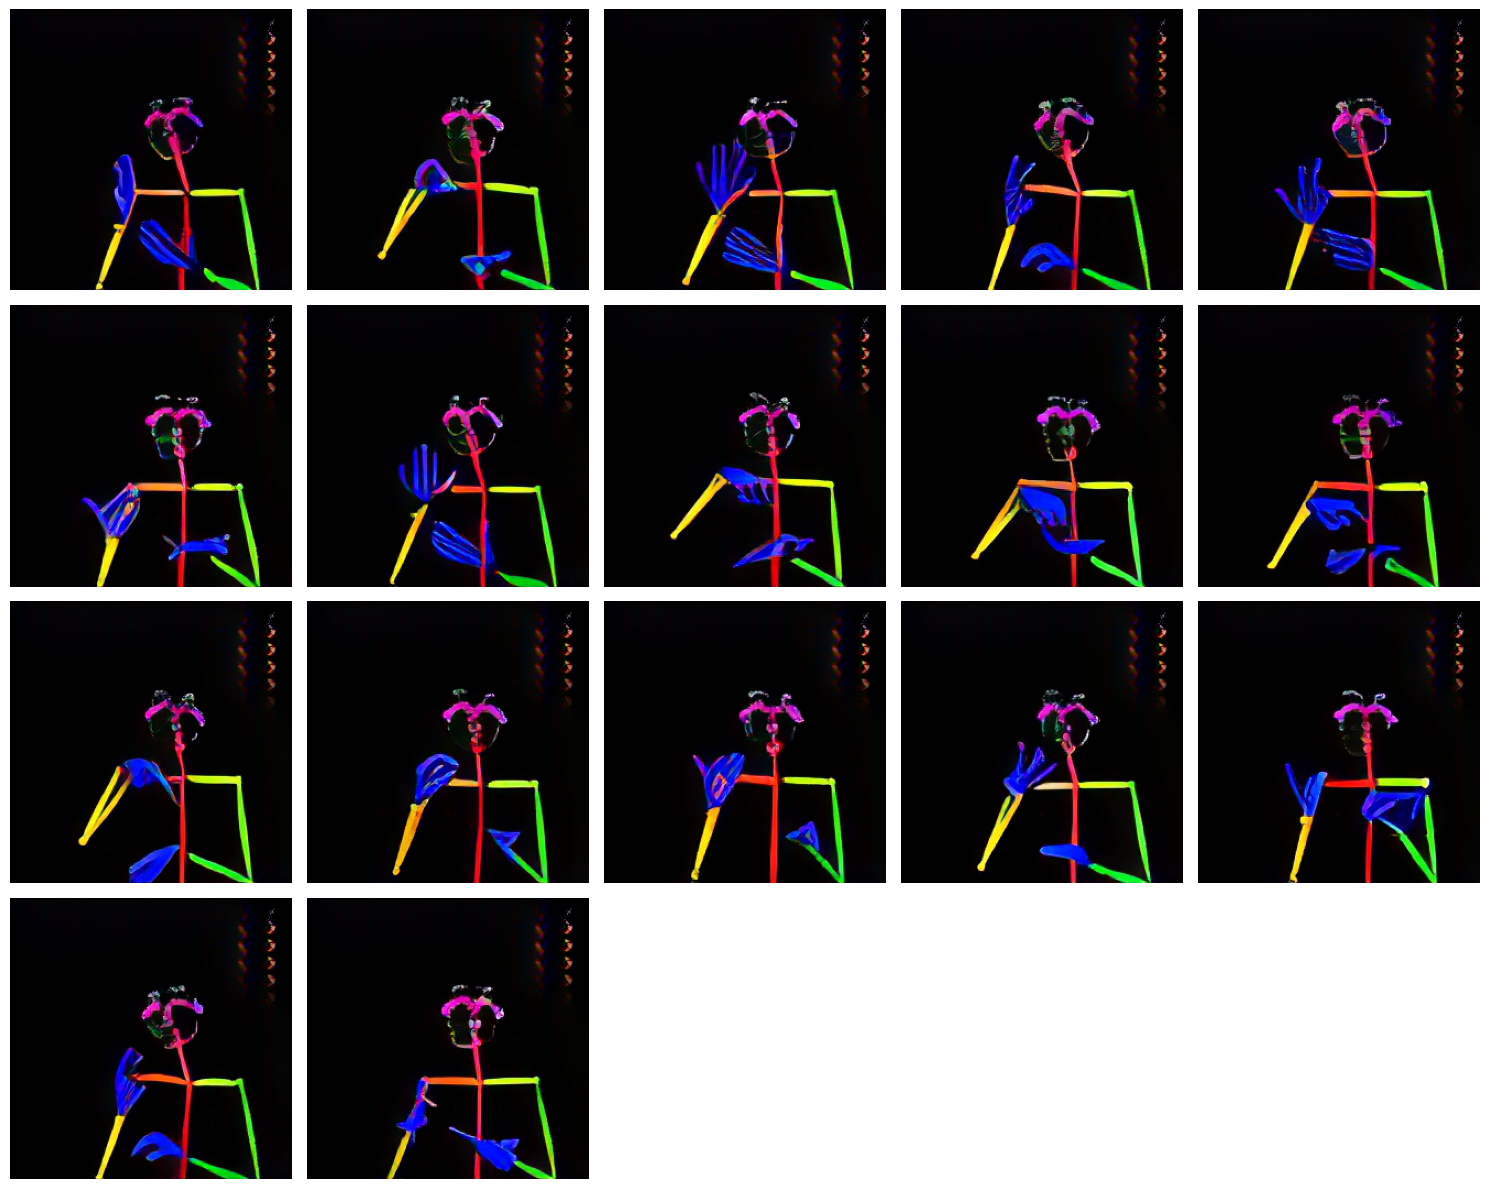

In [13]:
import numpy as np
import torch
from pathlib import Path
from cosmos_tokenizer.image_lib import ImageTokenizer
from matplotlib import pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────
NPZ_PATH   = "/work/com-304/IAY_neurons_u2/dataset/tokenized_256_256_dataset/train/pose/09cQe0gC2-0_5-8-rgb_front.npz"  # modifie ce chemin
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'

# ─── CHARGER LES TOKENS ────────────────────────────────────────────────────
data   = np.load(NPZ_PATH)
tokens = data["tokens"]  
print(data["positional_ids"].shape)
print(data["positional_ids"])

print(torch.from_numpy(tokens).shape)


# ─── RECONSTRUIRE CHAQUE FRAME ─────────────────────────────────────────────
# ─── RECONSTRUIRE CHAQUE FRAME ─────────────────────────────────────────────
recons = []
for i in range(tokens.shape[0]):
    inds  = torch.from_numpy(tokens[i]).unsqueeze(0).to(DEVICE)# (1, num_tokens)
    print(inds.shape)
    img_t = image_tokenizer.decode(inds).squeeze(0).cpu()          # peut être en bfloat16
    img_t = img_t.to(torch.float32)                              # ← conversion en float32
    # si les sorties sont dans [-1,1], on repasse en [0,1]
    img_t = img_t.clamp(-1,1) * 0.5 + 0.5
    print(img_t.shape)
    recons.append(img_t)

# ─── AFFICHER EN GRILLE ────────────────────────────────────────────────────
T    = len(recons)
cols = 5
rows = (T + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()

for ax, img in zip(axes, recons):
    ax.imshow(img.permute(1,2,0).numpy())
    ax.axis('off')

for ax in axes[T:]:
    ax.axis('off')

plt.tight_layout()
plt.show()